# S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
# Parameters
seed = 7


In [3]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [4]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [5]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 7, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [6]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [8]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [9]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 13, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|                                             | 0/192000 [00:00<?, ?it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 1/192000 [00:01<84:47:34,  1.59s/it]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 2/192000 [00:01<42:40:05,  1.25it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 28/192000 [00:01<2:04:01, 25.80it/s]

Training for 192000 iter, 300.00 epochs:   0%| | 28/192000 [00:02<2:04:01, 25.80it/s, epoch=0.08/300.00, iter=50/19200

Training for 192000 iter, 300.00 epochs:   0%| | 59/192000 [00:02<53:38, 59.64it/s, epoch=0.08/300.00, iter=50/192000,

Training for 192000 iter, 300.00 epochs:   0%| | 97/192000 [00:02<30:11, 105.95it/s, epoch=0.08/300.00, iter=50/192000

Training for 192000 iter, 300.00 epochs:   0%| | 97/192000 [00:02<30:11, 105.95it/s, epoch=0.16/300.00, iter=100/19200

Training for 192000 iter, 300.00 epochs:   0%| | 132/192000 [00:02<21:42, 147.36it/s, epoch=0.16/300.00, iter=100/1920

Training for 192000 iter, 300.00 epochs:   0%| | 132/192000 [00:02<21:42, 147.36it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 168/192000 [00:02<17:00, 188.03it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 168/192000 [00:02<17:00, 188.03it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 206/192000 [00:02<13:55, 229.58it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 244/192000 [00:02<12:05, 264.48it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 244/192000 [00:02<12:05, 264.48it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 281/192000 [00:02<10:58, 290.97it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 281/192000 [00:02<10:58, 290.97it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 322/192000 [00:02<09:56, 321.14it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 322/192000 [00:02<09:56, 321.14it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 361/192000 [00:02<09:24, 339.65it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 361/192000 [00:02<09:24, 339.65it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 400/192000 [00:02<09:06, 350.81it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 439/192000 [00:03<08:49, 361.71it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 439/192000 [00:03<08:49, 361.71it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 477/192000 [00:03<08:50, 361.20it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 477/192000 [00:03<08:50, 361.20it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 516/192000 [00:03<08:38, 369.20it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 516/192000 [00:03<08:38, 369.20it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 555/192000 [00:03<08:30, 374.91it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 594/192000 [00:03<08:30, 375.13it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 594/192000 [00:03<08:30, 375.13it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 634/192000 [00:03<08:21, 381.58it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 634/192000 [00:03<08:21, 381.58it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 673/192000 [00:03<10:00, 318.46it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 673/192000 [00:03<10:00, 318.46it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 707/192000 [00:03<11:44, 271.41it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 744/192000 [00:04<10:52, 293.00it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 744/192000 [00:04<10:52, 293.00it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 776/192000 [00:04<11:48, 269.88it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 776/192000 [00:04<11:48, 269.88it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 815/192000 [00:04<10:39, 298.76it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 815/192000 [00:04<10:39, 298.76it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 855/192000 [00:04<09:49, 324.21it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 895/192000 [00:04<09:15, 343.88it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 895/192000 [00:04<09:15, 343.88it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 935/192000 [00:04<08:53, 357.88it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 935/192000 [00:04<08:53, 357.88it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 975/192000 [00:04<08:39, 368.03it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 975/192000 [00:04<08:39, 368.03it/s, epoch=1.56/300.00, iter=1000/192

Training for 192000 iter, 300.00 epochs:   1%| | 1015/192000 [00:04<08:28, 375.60it/s, epoch=1.56/300.00, iter=1000/19

Training for 192000 iter, 300.00 epochs:   1%| | 1015/192000 [00:04<08:28, 375.60it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1055/192000 [00:04<08:20, 381.71it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1096/192000 [00:04<08:12, 387.62it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1096/192000 [00:04<08:12, 387.62it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1137/192000 [00:05<08:07, 391.52it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1137/192000 [00:05<08:07, 391.52it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1178/192000 [00:05<08:03, 394.29it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1178/192000 [00:05<08:03, 394.29it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1218/192000 [00:05<08:02, 395.00it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1218/192000 [00:05<08:02, 395.00it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1258/192000 [00:05<08:01, 396.45it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1298/192000 [00:05<08:15, 384.59it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1298/192000 [00:05<08:15, 384.59it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1339/192000 [00:05<08:08, 390.67it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1339/192000 [00:05<08:08, 390.67it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1380/192000 [00:05<08:04, 393.41it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1380/192000 [00:05<08:04, 393.41it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1420/192000 [00:05<08:02, 394.94it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1420/192000 [00:05<08:02, 394.94it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1460/192000 [00:05<08:01, 395.95it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1460/192000 [00:05<08:01, 395.95it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1500/192000 [00:05<08:00, 396.53it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1540/192000 [00:06<08:00, 396.67it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1540/192000 [00:06<08:00, 396.67it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1580/192000 [00:06<08:00, 396.56it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1580/192000 [00:06<08:00, 396.56it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1621/192000 [00:06<07:56, 399.36it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1621/192000 [00:06<07:56, 399.36it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1662/192000 [00:06<07:55, 400.28it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1662/192000 [00:06<07:55, 400.28it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1703/192000 [00:06<07:55, 400.13it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1744/192000 [00:06<08:24, 377.22it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1744/192000 [00:06<08:24, 377.22it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1783/192000 [00:06<08:43, 363.11it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1783/192000 [00:06<08:43, 363.11it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1824/192000 [00:06<08:26, 375.57it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1824/192000 [00:06<08:26, 375.57it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1864/192000 [00:06<08:17, 382.21it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1864/192000 [00:07<08:17, 382.21it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1904/192000 [00:07<08:13, 385.32it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1943/192000 [00:07<08:32, 371.20it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1943/192000 [00:07<08:32, 371.20it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1981/192000 [00:07<08:41, 364.70it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1981/192000 [00:07<08:41, 364.70it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2022/192000 [00:07<08:24, 376.26it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2022/192000 [00:07<08:24, 376.26it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2063/192000 [00:07<08:12, 385.81it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2063/192000 [00:07<08:12, 385.81it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2102/192000 [00:07<08:25, 375.95it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2142/192000 [00:07<08:17, 381.85it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2142/192000 [00:07<08:17, 381.85it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2182/192000 [00:07<08:11, 386.43it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2182/192000 [00:07<08:11, 386.43it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2222/192000 [00:07<08:06, 389.78it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2222/192000 [00:07<08:06, 389.78it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2262/192000 [00:07<08:03, 392.54it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2262/192000 [00:08<08:03, 392.54it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2303/192000 [00:08<08:00, 395.06it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2344/192000 [00:08<07:57, 397.42it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2344/192000 [00:08<07:57, 397.42it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2384/192000 [00:08<07:56, 397.56it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2384/192000 [00:08<07:56, 397.56it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2424/192000 [00:08<07:56, 397.59it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2424/192000 [00:08<07:56, 397.59it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2465/192000 [00:08<07:55, 398.40it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2465/192000 [00:08<07:55, 398.40it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2506/192000 [00:08<07:54, 399.43it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2547/192000 [00:08<07:52, 400.77it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2547/192000 [00:08<07:52, 400.77it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2588/192000 [00:08<08:20, 378.34it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2588/192000 [00:08<08:20, 378.34it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2627/192000 [00:08<08:34, 367.83it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2627/192000 [00:08<08:34, 367.83it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2666/192000 [00:09<08:26, 373.70it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2666/192000 [00:09<08:26, 373.70it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2707/192000 [00:09<08:16, 381.30it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2746/192000 [00:09<08:19, 378.62it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2746/192000 [00:09<08:19, 378.62it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2787/192000 [00:09<08:10, 386.01it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2787/192000 [00:09<08:10, 386.01it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2828/192000 [00:09<08:03, 391.55it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2828/192000 [00:09<08:03, 391.55it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   1%| | 2868/192000 [00:09<08:19, 378.51it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   1%| | 2868/192000 [00:09<08:19, 378.51it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2907/192000 [00:09<08:18, 379.64it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2947/192000 [00:09<08:12, 383.91it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2947/192000 [00:09<08:12, 383.91it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2988/192000 [00:09<08:06, 388.74it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2988/192000 [00:09<08:06, 388.74it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3028/192000 [00:09<08:06, 388.35it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3028/192000 [00:10<08:06, 388.35it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3068/192000 [00:10<08:05, 389.48it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3068/192000 [00:10<08:05, 389.48it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3108/192000 [00:10<08:01, 391.91it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3148/192000 [00:10<07:59, 394.01it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3148/192000 [00:10<07:59, 394.01it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3188/192000 [00:10<08:02, 391.44it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3188/192000 [00:10<08:02, 391.44it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3228/192000 [00:10<08:18, 379.00it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3228/192000 [00:10<08:18, 379.00it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3267/192000 [00:10<08:13, 382.15it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3267/192000 [00:10<08:13, 382.15it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3307/192000 [00:10<08:10, 384.92it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3347/192000 [00:10<08:05, 388.69it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3347/192000 [00:10<08:05, 388.69it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3387/192000 [00:10<08:02, 390.95it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3387/192000 [00:10<08:02, 390.95it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3427/192000 [00:10<07:59, 392.97it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3427/192000 [00:11<07:59, 392.97it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3467/192000 [00:11<07:57, 394.67it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3467/192000 [00:11<07:57, 394.67it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3507/192000 [00:11<08:01, 391.52it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3547/192000 [00:11<07:59, 393.04it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3547/192000 [00:11<07:59, 393.04it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3587/192000 [00:11<07:56, 395.09it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3587/192000 [00:11<07:56, 395.09it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3627/192000 [00:11<07:55, 396.44it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3627/192000 [00:11<07:55, 396.44it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3668/192000 [00:11<07:53, 397.53it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3668/192000 [00:11<07:53, 397.53it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3708/192000 [00:11<07:57, 394.58it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3749/192000 [00:11<07:54, 396.90it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3749/192000 [00:11<07:54, 396.90it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3790/192000 [00:11<07:52, 397.97it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3790/192000 [00:11<07:52, 397.97it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3831/192000 [00:11<07:51, 398.82it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3831/192000 [00:12<07:51, 398.82it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3871/192000 [00:12<08:18, 377.41it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3871/192000 [00:12<08:18, 377.41it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3911/192000 [00:12<08:12, 381.64it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3911/192000 [00:12<08:12, 381.64it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3951/192000 [00:12<08:06, 386.18it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3991/192000 [00:12<08:01, 390.10it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3991/192000 [00:12<08:01, 390.10it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4031/192000 [00:12<07:58, 392.72it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4031/192000 [00:12<07:58, 392.72it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4071/192000 [00:12<07:56, 394.35it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4071/192000 [00:12<07:56, 394.35it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4112/192000 [00:12<07:53, 396.62it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4112/192000 [00:12<07:53, 396.62it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4152/192000 [00:12<07:53, 396.69it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4192/192000 [00:12<07:59, 391.62it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4192/192000 [00:12<07:59, 391.62it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4232/192000 [00:13<07:56, 393.94it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4232/192000 [00:13<07:56, 393.94it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4273/192000 [00:13<07:54, 395.87it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4273/192000 [00:13<07:54, 395.87it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4314/192000 [00:13<07:52, 397.30it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4314/192000 [00:13<07:52, 397.30it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4355/192000 [00:13<07:51, 398.29it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4396/192000 [00:13<07:49, 399.30it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4396/192000 [00:13<07:49, 399.30it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4436/192000 [00:13<07:51, 397.54it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4436/192000 [00:13<07:51, 397.54it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4476/192000 [00:13<07:52, 396.67it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4476/192000 [00:13<07:52, 396.67it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4516/192000 [00:13<08:14, 379.20it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4516/192000 [00:13<08:14, 379.20it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4555/192000 [00:13<08:13, 379.60it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4595/192000 [00:13<08:09, 383.17it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4595/192000 [00:13<08:09, 383.17it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4635/192000 [00:14<08:02, 388.00it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4635/192000 [00:14<08:02, 388.00it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4675/192000 [00:14<07:58, 391.22it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4675/192000 [00:14<07:58, 391.22it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4715/192000 [00:14<07:57, 392.14it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4715/192000 [00:14<07:57, 392.14it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4755/192000 [00:14<07:57, 392.15it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4796/192000 [00:14<07:53, 395.37it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4796/192000 [00:14<07:53, 395.37it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4837/192000 [00:14<07:50, 397.68it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4837/192000 [00:14<07:50, 397.68it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4878/192000 [00:14<07:49, 398.50it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4878/192000 [00:14<07:49, 398.50it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4918/192000 [00:14<07:51, 397.10it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4918/192000 [00:14<07:51, 397.10it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4958/192000 [00:14<08:16, 377.09it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4998/192000 [00:14<08:10, 380.87it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4998/192000 [00:15<08:10, 380.87it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5037/192000 [00:15<08:31, 365.24it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5037/192000 [00:15<08:31, 365.24it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5077/192000 [00:15<08:18, 374.65it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5077/192000 [00:15<08:18, 374.65it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5116/192000 [00:15<08:14, 378.07it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5116/192000 [00:15<08:14, 378.07it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5154/192000 [00:15<08:43, 356.76it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5191/192000 [00:15<08:38, 360.37it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5191/192000 [00:15<08:38, 360.37it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5232/192000 [00:15<08:22, 372.02it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5232/192000 [00:15<08:22, 372.02it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5273/192000 [00:15<08:09, 381.76it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5273/192000 [00:15<08:09, 381.76it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5312/192000 [00:15<08:08, 382.10it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5312/192000 [00:15<08:08, 382.10it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5351/192000 [00:15<08:09, 381.30it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5392/192000 [00:16<07:59, 388.79it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5392/192000 [00:16<07:59, 388.79it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5431/192000 [00:16<08:06, 383.27it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5431/192000 [00:16<08:06, 383.27it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5470/192000 [00:16<08:24, 369.56it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5470/192000 [00:16<08:24, 369.56it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5508/192000 [00:16<08:30, 365.67it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5547/192000 [00:16<08:21, 372.07it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5547/192000 [00:16<08:21, 372.07it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5586/192000 [00:16<08:17, 375.03it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5586/192000 [00:16<08:17, 375.03it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5624/192000 [00:16<08:17, 374.69it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5624/192000 [00:16<08:17, 374.69it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5665/192000 [00:16<08:06, 382.75it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5665/192000 [00:16<08:06, 382.75it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5706/192000 [00:16<07:58, 389.27it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5746/192000 [00:16<07:57, 389.80it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5746/192000 [00:16<07:57, 389.80it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5786/192000 [00:17<08:32, 363.57it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5786/192000 [00:17<08:32, 363.57it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5827/192000 [00:17<08:16, 375.18it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5827/192000 [00:17<08:16, 375.18it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5865/192000 [00:17<08:42, 356.52it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5865/192000 [00:17<08:42, 356.52it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5903/192000 [00:17<08:35, 361.06it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5944/192000 [00:17<08:18, 373.27it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5944/192000 [00:17<08:18, 373.27it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5982/192000 [00:17<08:18, 373.08it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5982/192000 [00:17<08:18, 373.08it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6023/192000 [00:17<08:07, 381.24it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6023/192000 [00:17<08:07, 381.24it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6062/192000 [00:17<08:16, 374.77it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6062/192000 [00:17<08:16, 374.77it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6103/192000 [00:17<08:04, 383.41it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6144/192000 [00:18<07:56, 390.04it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6144/192000 [00:18<07:56, 390.04it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6184/192000 [00:18<07:55, 390.79it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6184/192000 [00:18<07:55, 390.79it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6225/192000 [00:18<07:50, 394.45it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6225/192000 [00:18<07:50, 394.45it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6266/192000 [00:18<07:47, 397.47it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6266/192000 [00:18<07:47, 397.47it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6307/192000 [00:18<07:45, 399.20it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6348/192000 [00:18<07:42, 401.26it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6348/192000 [00:18<07:42, 401.26it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6389/192000 [00:18<07:43, 400.37it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6389/192000 [00:18<07:43, 400.37it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6430/192000 [00:18<08:04, 382.75it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6430/192000 [00:18<08:04, 382.75it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6469/192000 [00:18<08:12, 376.95it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6469/192000 [00:18<08:12, 376.95it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6507/192000 [00:18<08:22, 368.88it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6544/192000 [00:19<09:26, 327.10it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6544/192000 [00:19<09:26, 327.10it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6578/192000 [00:19<10:03, 307.46it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6578/192000 [00:19<10:03, 307.46it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6610/192000 [00:19<10:35, 291.74it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6640/192000 [00:19<10:31, 293.35it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6640/192000 [00:19<10:31, 293.35it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6675/192000 [00:19<10:00, 308.42it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6675/192000 [00:19<10:00, 308.42it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   3%| | 6707/192000 [00:19<09:56, 310.87it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   4%| | 6740/192000 [00:19<09:48, 314.81it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   4%| | 6740/192000 [00:19<09:48, 314.81it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6777/192000 [00:19<09:20, 330.21it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6777/192000 [00:19<09:20, 330.21it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6817/192000 [00:19<08:49, 349.51it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6817/192000 [00:20<08:49, 349.51it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6853/192000 [00:20<09:27, 325.97it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6888/192000 [00:20<09:17, 332.01it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6888/192000 [00:20<09:17, 332.01it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6928/192000 [00:20<08:49, 349.45it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6928/192000 [00:20<08:49, 349.45it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6965/192000 [00:20<08:44, 353.05it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6965/192000 [00:20<08:44, 353.05it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7004/192000 [00:20<08:30, 362.20it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7041/192000 [00:20<08:34, 359.38it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7041/192000 [00:20<08:34, 359.38it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7081/192000 [00:20<08:22, 368.05it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7081/192000 [00:20<08:22, 368.05it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7118/192000 [00:20<09:35, 321.10it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7118/192000 [00:20<09:35, 321.10it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7157/192000 [00:20<09:07, 337.82it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7193/192000 [00:21<08:57, 343.66it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7193/192000 [00:21<08:57, 343.66it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7232/192000 [00:21<08:40, 355.11it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7232/192000 [00:21<08:40, 355.11it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7272/192000 [00:21<08:25, 365.31it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7272/192000 [00:21<08:25, 365.31it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7312/192000 [00:21<08:14, 373.33it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7312/192000 [00:21<08:14, 373.33it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7351/192000 [00:21<08:11, 375.56it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7389/192000 [00:21<08:19, 369.78it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7389/192000 [00:21<08:19, 369.78it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7430/192000 [00:21<08:04, 381.05it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7430/192000 [00:21<08:04, 381.05it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7469/192000 [00:21<08:01, 383.38it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7469/192000 [00:21<08:01, 383.38it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7509/192000 [00:21<07:57, 386.02it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7509/192000 [00:22<07:57, 386.02it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7550/192000 [00:22<07:49, 392.82it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7591/192000 [00:22<07:44, 396.91it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7591/192000 [00:22<07:44, 396.91it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7631/192000 [00:22<07:44, 397.33it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7631/192000 [00:22<07:44, 397.33it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7672/192000 [00:22<07:41, 399.27it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7672/192000 [00:22<07:41, 399.27it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7712/192000 [00:22<07:55, 387.20it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7712/192000 [00:22<07:55, 387.20it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7751/192000 [00:22<08:17, 370.24it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7791/192000 [00:22<08:08, 377.10it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7791/192000 [00:22<08:08, 377.10it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7829/192000 [00:22<08:09, 376.54it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7829/192000 [00:22<08:09, 376.54it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7867/192000 [00:22<08:21, 366.83it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7867/192000 [00:22<08:21, 366.83it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7906/192000 [00:22<08:14, 372.51it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7945/192000 [00:23<08:09, 375.84it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7945/192000 [00:23<08:09, 375.84it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7985/192000 [00:23<08:00, 382.81it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7985/192000 [00:23<08:00, 382.81it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8024/192000 [00:23<08:01, 381.82it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8024/192000 [00:23<08:01, 381.82it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8063/192000 [00:23<08:09, 375.50it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8063/192000 [00:23<08:09, 375.50it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8101/192000 [00:23<08:10, 375.26it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8140/192000 [00:23<08:06, 378.00it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8140/192000 [00:23<08:06, 378.00it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8178/192000 [00:23<08:22, 366.00it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8178/192000 [00:23<08:22, 366.00it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8216/192000 [00:23<08:19, 368.00it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8216/192000 [00:23<08:19, 368.00it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8254/192000 [00:23<08:18, 368.54it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8294/192000 [00:23<08:07, 376.59it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8294/192000 [00:23<08:07, 376.59it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8332/192000 [00:24<08:28, 361.17it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8332/192000 [00:24<08:28, 361.17it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8370/192000 [00:24<08:23, 364.56it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8370/192000 [00:24<08:23, 364.56it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8408/192000 [00:24<08:20, 367.00it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8445/192000 [00:24<08:31, 358.54it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8445/192000 [00:24<08:31, 358.54it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8487/192000 [00:24<08:10, 373.93it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8487/192000 [00:24<08:10, 373.93it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8527/192000 [00:24<08:03, 379.78it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8527/192000 [00:24<08:03, 379.78it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8568/192000 [00:24<07:55, 385.45it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8568/192000 [00:24<07:55, 385.45it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   4%| | 8609/192000 [00:24<07:48, 391.36it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   4%| | 8609/192000 [00:24<07:48, 391.36it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8650/192000 [00:24<07:43, 395.69it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8691/192000 [00:25<07:38, 399.81it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8691/192000 [00:25<07:38, 399.81it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8732/192000 [00:25<07:38, 399.72it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8732/192000 [00:25<07:38, 399.72it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8773/192000 [00:25<07:36, 401.59it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8773/192000 [00:25<07:36, 401.59it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8814/192000 [00:25<07:35, 402.08it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8814/192000 [00:25<07:35, 402.08it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8855/192000 [00:25<07:38, 399.17it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8895/192000 [00:25<07:39, 398.91it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8895/192000 [00:25<07:39, 398.91it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8935/192000 [00:25<07:38, 399.20it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8935/192000 [00:25<07:38, 399.20it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8975/192000 [00:25<07:54, 385.92it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8975/192000 [00:25<07:54, 385.92it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9016/192000 [00:25<07:48, 390.65it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9016/192000 [00:25<07:48, 390.65it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9057/192000 [00:25<07:42, 395.96it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9099/192000 [00:26<07:36, 400.74it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9099/192000 [00:26<07:36, 400.74it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9141/192000 [00:26<07:32, 404.16it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9141/192000 [00:26<07:32, 404.16it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9182/192000 [00:26<07:31, 404.98it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9182/192000 [00:26<07:31, 404.98it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9223/192000 [00:26<07:30, 405.89it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9223/192000 [00:26<07:30, 405.89it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9264/192000 [00:26<07:29, 406.60it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9264/192000 [00:26<07:29, 406.60it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9305/192000 [00:26<07:28, 407.23it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9346/192000 [00:26<07:28, 407.57it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9346/192000 [00:26<07:28, 407.57it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9387/192000 [00:26<07:28, 407.06it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9387/192000 [00:26<07:28, 407.06it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9428/192000 [00:26<07:37, 399.28it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9428/192000 [00:26<07:37, 399.28it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9468/192000 [00:26<07:43, 393.91it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9468/192000 [00:27<07:43, 393.91it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9508/192000 [00:27<07:54, 384.44it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9549/192000 [00:27<07:48, 389.64it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9549/192000 [00:27<07:48, 389.64it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9589/192000 [00:27<07:47, 389.92it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9589/192000 [00:27<07:47, 389.92it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9629/192000 [00:27<07:58, 381.30it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9629/192000 [00:27<07:58, 381.30it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9668/192000 [00:27<08:02, 378.19it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9668/192000 [00:27<08:02, 378.19it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9708/192000 [00:27<07:54, 384.22it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9747/192000 [00:27<08:38, 351.45it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9747/192000 [00:27<08:38, 351.45it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9783/192000 [00:27<08:35, 353.79it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9783/192000 [00:27<08:35, 353.79it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9824/192000 [00:27<08:14, 368.66it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9824/192000 [00:27<08:14, 368.66it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9865/192000 [00:28<08:00, 379.38it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9865/192000 [00:28<08:00, 379.38it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9906/192000 [00:28<07:51, 386.24it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9947/192000 [00:28<07:43, 393.01it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9947/192000 [00:28<07:43, 393.01it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9988/192000 [00:28<07:40, 395.11it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9988/192000 [00:28<07:40, 395.11it/s, epoch=15.62/300.00, iter=10000/

Training for 192000 iter, 300.00 epochs:   5%| | 10028/192000 [00:28<07:41, 394.15it/s, epoch=15.62/300.00, iter=10000

Training for 192000 iter, 300.00 epochs:   5%| | 10028/192000 [00:28<07:41, 394.15it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10069/192000 [00:28<07:38, 397.04it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10069/192000 [00:28<07:38, 397.04it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10110/192000 [00:28<07:35, 399.06it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10110/192000 [00:28<07:35, 399.06it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10150/192000 [00:28<07:35, 399.16it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10191/192000 [00:28<07:33, 401.04it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10191/192000 [00:28<07:33, 401.04it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10232/192000 [00:28<07:45, 390.73it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10232/192000 [00:29<07:45, 390.73it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10272/192000 [00:29<08:16, 365.84it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10272/192000 [00:29<08:16, 365.84it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10313/192000 [00:29<08:02, 376.65it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10313/192000 [00:29<08:02, 376.65it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10354/192000 [00:29<07:53, 384.00it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10395/192000 [00:29<07:45, 390.12it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10395/192000 [00:29<07:45, 390.12it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10435/192000 [00:29<07:44, 391.28it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10435/192000 [00:29<07:44, 391.28it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10475/192000 [00:29<07:43, 391.71it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10475/192000 [00:29<07:43, 391.71it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10516/192000 [00:29<07:39, 394.69it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10516/192000 [00:29<07:39, 394.69it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   5%| | 10557/192000 [00:29<07:36, 397.23it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10598/192000 [00:29<07:34, 398.94it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10598/192000 [00:29<07:34, 398.94it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10638/192000 [00:29<07:36, 397.53it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10638/192000 [00:30<07:36, 397.53it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10679/192000 [00:30<07:34, 399.06it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10679/192000 [00:30<07:34, 399.06it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10719/192000 [00:30<08:09, 370.21it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10719/192000 [00:30<08:09, 370.21it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10758/192000 [00:30<08:05, 373.63it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10799/192000 [00:30<07:53, 382.59it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10799/192000 [00:30<07:53, 382.59it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10840/192000 [00:30<07:46, 388.40it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10840/192000 [00:30<07:46, 388.40it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10881/192000 [00:30<07:52, 383.35it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10881/192000 [00:30<07:52, 383.35it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10921/192000 [00:30<07:46, 387.76it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10921/192000 [00:30<07:46, 387.76it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10962/192000 [00:30<07:42, 391.55it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10962/192000 [00:30<07:42, 391.55it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11002/192000 [00:30<07:43, 390.31it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11042/192000 [00:31<07:53, 382.11it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11042/192000 [00:31<07:53, 382.11it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11081/192000 [00:31<07:54, 381.48it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11081/192000 [00:31<07:54, 381.48it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11122/192000 [00:31<07:47, 387.28it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11122/192000 [00:31<07:47, 387.28it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11162/192000 [00:31<07:42, 390.60it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11162/192000 [00:31<07:42, 390.60it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11203/192000 [00:31<07:38, 394.65it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11243/192000 [00:31<07:40, 392.30it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11243/192000 [00:31<07:40, 392.30it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11283/192000 [00:31<07:41, 391.75it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11283/192000 [00:31<07:41, 391.75it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11324/192000 [00:31<07:38, 394.34it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11324/192000 [00:31<07:38, 394.34it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11364/192000 [00:31<07:36, 395.88it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11364/192000 [00:31<07:36, 395.88it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11404/192000 [00:31<07:35, 396.44it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11445/192000 [00:32<07:33, 398.27it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11445/192000 [00:32<07:33, 398.27it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11486/192000 [00:32<07:32, 399.08it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11486/192000 [00:32<07:32, 399.08it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11526/192000 [00:32<07:45, 387.99it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11526/192000 [00:32<07:45, 387.99it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11565/192000 [00:32<07:45, 387.31it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11565/192000 [00:32<07:45, 387.31it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11605/192000 [00:32<07:43, 389.50it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11644/192000 [00:32<07:45, 387.29it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11644/192000 [00:32<07:45, 387.29it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11684/192000 [00:32<07:41, 390.61it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11684/192000 [00:32<07:41, 390.61it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11724/192000 [00:32<07:39, 391.95it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11724/192000 [00:32<07:39, 391.95it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11764/192000 [00:32<07:39, 391.93it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11764/192000 [00:32<07:39, 391.93it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11804/192000 [00:32<07:39, 392.42it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11845/192000 [00:33<07:35, 395.93it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11845/192000 [00:33<07:35, 395.93it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11885/192000 [00:33<07:41, 390.56it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11885/192000 [00:33<07:41, 390.56it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11925/192000 [00:33<07:39, 392.08it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11925/192000 [00:33<07:39, 392.08it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11965/192000 [00:33<07:38, 392.58it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11965/192000 [00:33<07:38, 392.58it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12005/192000 [00:33<07:36, 394.58it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12046/192000 [00:33<07:33, 396.91it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12046/192000 [00:33<07:33, 396.91it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12087/192000 [00:33<07:29, 399.89it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12087/192000 [00:33<07:29, 399.89it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12127/192000 [00:33<07:44, 387.62it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12127/192000 [00:33<07:44, 387.62it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12166/192000 [00:33<08:12, 364.92it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12166/192000 [00:34<08:12, 364.92it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12206/192000 [00:34<08:01, 373.31it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12246/192000 [00:34<07:52, 380.44it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12246/192000 [00:34<07:52, 380.44it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12287/192000 [00:34<07:45, 386.41it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12287/192000 [00:34<07:45, 386.41it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12327/192000 [00:34<07:40, 389.86it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12327/192000 [00:34<07:40, 389.86it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12367/192000 [00:34<07:40, 389.75it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12367/192000 [00:34<07:40, 389.75it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12407/192000 [00:34<07:38, 391.56it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12448/192000 [00:34<07:33, 396.01it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12448/192000 [00:34<07:33, 396.01it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   7%| | 12488/192000 [00:34<07:46, 385.01it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   7%| | 12488/192000 [00:34<07:46, 385.01it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12529/192000 [00:34<07:39, 390.43it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12529/192000 [00:34<07:39, 390.43it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12570/192000 [00:34<07:34, 394.59it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12570/192000 [00:35<07:34, 394.59it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12611/192000 [00:35<07:32, 396.61it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12611/192000 [00:35<07:32, 396.61it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12651/192000 [00:35<07:44, 386.13it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12690/192000 [00:35<07:43, 386.95it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12690/192000 [00:35<07:43, 386.95it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12731/192000 [00:35<07:38, 391.27it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12731/192000 [00:35<07:38, 391.27it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12772/192000 [00:35<07:34, 394.13it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12772/192000 [00:35<07:34, 394.13it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12812/192000 [00:35<07:57, 375.57it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12812/192000 [00:35<07:57, 375.57it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12850/192000 [00:35<08:03, 370.41it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12890/192000 [00:35<07:54, 377.50it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12890/192000 [00:35<07:54, 377.50it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12929/192000 [00:35<07:51, 379.69it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12929/192000 [00:35<07:51, 379.69it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12969/192000 [00:36<07:46, 384.01it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12969/192000 [00:36<07:46, 384.01it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13009/192000 [00:36<07:42, 387.16it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13048/192000 [00:36<08:05, 368.42it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13048/192000 [00:36<08:05, 368.42it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13086/192000 [00:36<08:34, 347.45it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13086/192000 [00:36<08:34, 347.45it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13126/192000 [00:36<08:15, 360.93it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13126/192000 [00:36<08:15, 360.93it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13163/192000 [00:36<08:25, 353.76it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13163/192000 [00:36<08:25, 353.76it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13200/192000 [00:36<08:21, 356.45it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13240/192000 [00:36<08:04, 368.61it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13240/192000 [00:36<08:04, 368.61it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13280/192000 [00:36<07:53, 377.27it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13280/192000 [00:36<07:53, 377.27it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13320/192000 [00:36<07:45, 383.86it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13320/192000 [00:37<07:45, 383.86it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13361/192000 [00:37<07:38, 389.32it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13361/192000 [00:37<07:38, 389.32it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13401/192000 [00:37<07:35, 392.34it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13441/192000 [00:37<07:43, 385.65it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13441/192000 [00:37<07:43, 385.65it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13480/192000 [00:37<08:26, 352.66it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13480/192000 [00:37<08:26, 352.66it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13516/192000 [00:37<08:39, 343.84it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13516/192000 [00:37<08:39, 343.84it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13555/192000 [00:37<08:23, 354.35it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13591/192000 [00:37<09:21, 317.97it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13591/192000 [00:37<09:21, 317.97it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13630/192000 [00:37<08:49, 337.02it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13630/192000 [00:37<08:49, 337.02it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13671/192000 [00:37<08:20, 356.31it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13671/192000 [00:38<08:20, 356.31it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13712/192000 [00:38<08:00, 370.88it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13712/192000 [00:38<08:00, 370.88it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13753/192000 [00:38<07:48, 380.37it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13792/192000 [00:38<07:47, 381.17it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13792/192000 [00:38<07:47, 381.17it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13833/192000 [00:38<07:38, 388.64it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13833/192000 [00:38<07:38, 388.64it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13874/192000 [00:38<07:34, 392.14it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13874/192000 [00:38<07:34, 392.14it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13914/192000 [00:38<07:34, 391.98it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13914/192000 [00:38<07:34, 391.98it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13954/192000 [00:38<07:32, 393.19it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13994/192000 [00:38<07:49, 379.03it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13994/192000 [00:38<07:49, 379.03it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14034/192000 [00:38<07:43, 384.22it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14034/192000 [00:38<07:43, 384.22it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14073/192000 [00:38<07:46, 381.43it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14073/192000 [00:39<07:46, 381.43it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14112/192000 [00:39<07:54, 374.94it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14112/192000 [00:39<07:54, 374.94it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14153/192000 [00:39<07:45, 382.33it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14194/192000 [00:39<07:36, 389.64it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14194/192000 [00:39<07:36, 389.64it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14234/192000 [00:39<07:38, 387.51it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14234/192000 [00:39<07:38, 387.51it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14275/192000 [00:39<07:32, 392.76it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14275/192000 [00:39<07:32, 392.76it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14316/192000 [00:39<07:27, 396.80it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14316/192000 [00:39<07:27, 396.80it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14357/192000 [00:39<07:24, 399.48it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14398/192000 [00:39<07:21, 402.43it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14398/192000 [00:39<07:21, 402.43it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14439/192000 [00:39<07:30, 393.96it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14439/192000 [00:39<07:30, 393.96it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14479/192000 [00:40<07:28, 395.72it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14479/192000 [00:40<07:28, 395.72it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14519/192000 [00:40<07:29, 395.12it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14519/192000 [00:40<07:29, 395.12it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14559/192000 [00:40<07:32, 392.34it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14559/192000 [00:40<07:32, 392.34it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14600/192000 [00:40<07:28, 395.16it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14641/192000 [00:40<07:23, 399.48it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14641/192000 [00:40<07:23, 399.48it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14681/192000 [00:40<07:42, 383.47it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14681/192000 [00:40<07:42, 383.47it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14721/192000 [00:40<07:59, 369.88it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14721/192000 [00:40<07:59, 369.88it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14759/192000 [00:40<08:08, 362.58it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14799/192000 [00:40<07:57, 371.39it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14799/192000 [00:40<07:57, 371.39it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14837/192000 [00:40<07:58, 370.20it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14837/192000 [00:41<07:58, 370.20it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14875/192000 [00:41<08:44, 337.96it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14875/192000 [00:41<08:44, 337.96it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14910/192000 [00:41<09:01, 327.26it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14947/192000 [00:41<08:43, 338.35it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14947/192000 [00:41<08:43, 338.35it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14987/192000 [00:41<08:19, 354.08it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14987/192000 [00:41<08:19, 354.08it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15026/192000 [00:41<08:06, 363.57it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15026/192000 [00:41<08:06, 363.57it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15066/192000 [00:41<07:54, 373.21it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15066/192000 [00:41<07:54, 373.21it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15104/192000 [00:41<08:10, 360.44it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15143/192000 [00:41<07:59, 368.59it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15143/192000 [00:41<07:59, 368.59it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15181/192000 [00:41<08:06, 363.10it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15181/192000 [00:42<08:06, 363.10it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15219/192000 [00:42<08:00, 367.82it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15219/192000 [00:42<08:00, 367.82it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15257/192000 [00:42<07:59, 368.93it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15298/192000 [00:42<07:47, 378.13it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15298/192000 [00:42<07:47, 378.13it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15336/192000 [00:42<07:50, 375.81it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15336/192000 [00:42<07:50, 375.81it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15374/192000 [00:42<08:04, 364.84it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15374/192000 [00:42<08:04, 364.84it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15414/192000 [00:42<07:51, 374.14it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15414/192000 [00:42<07:51, 374.14it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15455/192000 [00:42<07:41, 382.49it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15494/192000 [00:42<07:41, 382.88it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15494/192000 [00:42<07:41, 382.88it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15535/192000 [00:42<07:34, 388.04it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15535/192000 [00:42<07:34, 388.04it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15574/192000 [00:42<07:34, 387.97it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15574/192000 [00:43<07:34, 387.97it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15615/192000 [00:43<07:29, 392.62it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15615/192000 [00:43<07:29, 392.62it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15655/192000 [00:43<08:06, 362.81it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15696/192000 [00:43<07:51, 374.08it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15696/192000 [00:43<07:51, 374.08it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15734/192000 [00:43<09:09, 320.52it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15734/192000 [00:43<09:09, 320.52it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15768/192000 [00:43<09:51, 297.79it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15799/192000 [00:43<10:10, 288.64it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15799/192000 [00:43<10:10, 288.64it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15840/192000 [00:43<09:13, 318.25it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15840/192000 [00:43<09:13, 318.25it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15879/192000 [00:43<08:44, 335.76it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15879/192000 [00:43<08:44, 335.76it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15918/192000 [00:44<08:24, 349.35it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15918/192000 [00:44<08:24, 349.35it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15959/192000 [00:44<08:02, 365.07it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15997/192000 [00:44<08:02, 365.03it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15997/192000 [00:44<08:02, 365.03it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16034/192000 [00:44<08:10, 358.97it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16034/192000 [00:44<08:10, 358.97it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16074/192000 [00:44<07:55, 370.16it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16074/192000 [00:44<07:55, 370.16it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16113/192000 [00:44<07:47, 375.85it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16113/192000 [00:44<07:47, 375.85it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16153/192000 [00:44<07:41, 381.40it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16193/192000 [00:44<07:35, 386.23it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16193/192000 [00:44<07:35, 386.23it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16233/192000 [00:44<07:31, 389.14it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16233/192000 [00:44<07:31, 389.14it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16274/192000 [00:44<07:27, 392.84it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16274/192000 [00:45<07:27, 392.84it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   8%| | 16314/192000 [00:45<07:46, 376.92it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   8%| | 16314/192000 [00:45<07:46, 376.92it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16352/192000 [00:45<08:51, 330.26it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16387/192000 [00:45<08:48, 332.09it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16387/192000 [00:45<08:48, 332.09it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16425/192000 [00:45<08:29, 344.85it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16425/192000 [00:45<08:29, 344.85it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16466/192000 [00:45<08:06, 360.77it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16466/192000 [00:45<08:06, 360.77it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16503/192000 [00:45<09:07, 320.76it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16537/192000 [00:45<09:31, 306.85it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16537/192000 [00:45<09:31, 306.85it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16577/192000 [00:45<08:53, 329.12it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16577/192000 [00:45<08:53, 329.12it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16615/192000 [00:45<08:31, 342.74it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16615/192000 [00:46<08:31, 342.74it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16651/192000 [00:46<08:35, 340.31it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16691/192000 [00:46<08:12, 356.18it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16691/192000 [00:46<08:12, 356.18it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16731/192000 [00:46<07:55, 368.64it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16731/192000 [00:46<07:55, 368.64it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16772/192000 [00:46<07:43, 378.14it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16772/192000 [00:46<07:43, 378.14it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16812/192000 [00:46<07:36, 383.99it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16812/192000 [00:46<07:36, 383.99it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16852/192000 [00:46<07:30, 388.62it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16893/192000 [00:46<07:26, 392.25it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16893/192000 [00:46<07:26, 392.25it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16933/192000 [00:46<07:24, 394.01it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16933/192000 [00:46<07:24, 394.01it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16973/192000 [00:46<07:23, 394.84it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16973/192000 [00:46<07:23, 394.84it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17013/192000 [00:47<07:22, 395.69it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17013/192000 [00:47<07:22, 395.69it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17053/192000 [00:47<07:20, 396.80it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17094/192000 [00:47<07:19, 397.99it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17094/192000 [00:47<07:19, 397.99it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17134/192000 [00:47<07:19, 398.31it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17134/192000 [00:47<07:19, 398.31it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17174/192000 [00:47<07:19, 397.99it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17174/192000 [00:47<07:19, 397.99it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17214/192000 [00:47<07:19, 397.70it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17214/192000 [00:47<07:19, 397.70it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17254/192000 [00:47<07:19, 397.45it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17294/192000 [00:47<07:39, 380.37it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17294/192000 [00:47<07:39, 380.37it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17333/192000 [00:47<07:37, 381.67it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17333/192000 [00:47<07:37, 381.67it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17373/192000 [00:47<07:32, 386.25it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17373/192000 [00:47<07:32, 386.25it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17413/192000 [00:48<07:28, 389.37it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17413/192000 [00:48<07:28, 389.37it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17453/192000 [00:48<07:24, 392.39it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17493/192000 [00:48<07:24, 392.78it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17493/192000 [00:48<07:24, 392.78it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17534/192000 [00:48<07:20, 396.22it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17534/192000 [00:48<07:20, 396.22it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17574/192000 [00:48<07:19, 397.16it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17574/192000 [00:48<07:19, 397.16it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17614/192000 [00:48<07:18, 397.90it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17614/192000 [00:48<07:18, 397.90it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17654/192000 [00:48<07:19, 397.00it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17694/192000 [00:48<07:18, 397.58it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17694/192000 [00:48<07:18, 397.58it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17734/192000 [00:48<07:17, 398.21it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17734/192000 [00:48<07:17, 398.21it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17774/192000 [00:48<07:17, 398.45it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17774/192000 [00:49<07:17, 398.45it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17815/192000 [00:49<07:15, 399.54it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17815/192000 [00:49<07:15, 399.54it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17856/192000 [00:49<07:15, 399.92it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17897/192000 [00:49<07:14, 400.90it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17897/192000 [00:49<07:14, 400.90it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17938/192000 [00:49<07:27, 388.89it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17938/192000 [00:49<07:27, 388.89it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17978/192000 [00:49<07:26, 389.94it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17978/192000 [00:49<07:26, 389.94it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18018/192000 [00:49<07:24, 391.43it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18018/192000 [00:49<07:24, 391.43it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18058/192000 [00:49<07:23, 392.17it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18098/192000 [00:49<07:21, 394.04it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18098/192000 [00:49<07:21, 394.04it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18138/192000 [00:49<07:20, 394.46it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18138/192000 [00:49<07:20, 394.46it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18178/192000 [00:50<08:12, 352.90it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18178/192000 [00:50<08:12, 352.90it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18215/192000 [00:50<08:33, 338.62it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18215/192000 [00:50<08:33, 338.62it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18250/192000 [00:50<08:41, 333.27it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18291/192000 [00:50<08:12, 353.00it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18291/192000 [00:50<08:12, 353.00it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18327/192000 [00:50<08:11, 353.37it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18327/192000 [00:50<08:11, 353.37it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18368/192000 [00:50<07:51, 368.10it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18368/192000 [00:50<07:51, 368.10it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18409/192000 [00:50<07:38, 378.92it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18448/192000 [00:50<07:38, 378.60it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18448/192000 [00:50<07:38, 378.60it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18489/192000 [00:50<07:30, 385.52it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18489/192000 [00:50<07:30, 385.52it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18530/192000 [00:50<07:23, 390.99it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18530/192000 [00:51<07:23, 390.99it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18570/192000 [00:51<08:11, 352.60it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18570/192000 [00:51<08:11, 352.60it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18610/192000 [00:51<07:55, 364.99it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18610/192000 [00:51<07:55, 364.99it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18651/192000 [00:51<07:40, 376.17it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18690/192000 [00:51<07:54, 364.93it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18690/192000 [00:51<07:54, 364.93it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18732/192000 [00:51<07:38, 377.95it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18732/192000 [00:51<07:38, 377.95it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18771/192000 [00:51<07:42, 374.75it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18771/192000 [00:51<07:42, 374.75it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18812/192000 [00:51<07:32, 382.41it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18812/192000 [00:51<07:32, 382.41it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18851/192000 [00:51<07:41, 375.58it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18890/192000 [00:51<07:36, 379.48it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18890/192000 [00:51<07:36, 379.48it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18929/192000 [00:52<07:34, 380.97it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18929/192000 [00:52<07:34, 380.97it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18969/192000 [00:52<07:27, 386.51it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18969/192000 [00:52<07:27, 386.51it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19010/192000 [00:52<07:20, 392.58it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19010/192000 [00:52<07:20, 392.58it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19051/192000 [00:52<07:16, 396.46it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19091/192000 [00:52<07:20, 392.73it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19091/192000 [00:52<07:20, 392.73it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19132/192000 [00:52<07:17, 394.95it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19132/192000 [00:52<07:17, 394.95it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19173/192000 [00:52<07:14, 397.70it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19173/192000 [00:52<07:14, 397.70it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19213/192000 [00:52<07:51, 366.21it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19213/192000 [00:52<07:51, 366.21it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19251/192000 [00:52<07:47, 369.18it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19290/192000 [00:52<07:44, 372.07it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19290/192000 [00:53<07:44, 372.07it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19328/192000 [00:53<08:07, 354.50it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19328/192000 [00:53<08:07, 354.50it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19364/192000 [00:53<08:49, 326.00it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19399/192000 [00:53<08:39, 331.95it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19399/192000 [00:53<08:39, 331.95it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19439/192000 [00:53<08:14, 348.81it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19439/192000 [00:53<08:14, 348.81it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19480/192000 [00:53<07:54, 363.82it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19480/192000 [00:53<07:54, 363.82it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19520/192000 [00:53<07:41, 373.81it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19520/192000 [00:53<07:41, 373.81it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19560/192000 [00:53<07:34, 379.30it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19560/192000 [00:53<07:34, 379.30it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19600/192000 [00:53<07:28, 384.44it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19639/192000 [00:53<07:46, 369.11it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19639/192000 [00:53<07:46, 369.11it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19679/192000 [00:54<07:37, 376.91it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19679/192000 [00:54<07:37, 376.91it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19719/192000 [00:54<07:30, 382.58it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19719/192000 [00:54<07:30, 382.58it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19758/192000 [00:54<07:45, 369.94it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19798/192000 [00:54<07:35, 377.82it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19798/192000 [00:54<07:35, 377.82it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19839/192000 [00:54<07:27, 384.97it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19839/192000 [00:54<07:27, 384.97it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19878/192000 [00:54<07:32, 380.36it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19878/192000 [00:54<07:32, 380.36it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19918/192000 [00:54<07:27, 384.84it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19918/192000 [00:54<07:27, 384.84it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19958/192000 [00:54<07:24, 386.65it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19999/192000 [00:54<07:19, 391.28it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19999/192000 [00:54<07:19, 391.28it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20040/192000 [00:54<07:15, 394.60it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20040/192000 [00:54<07:15, 394.60it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20080/192000 [00:55<07:16, 393.79it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20080/192000 [00:55<07:16, 393.79it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20121/192000 [00:55<07:14, 395.78it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20121/192000 [00:55<07:14, 395.78it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20162/192000 [00:55<07:11, 398.17it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20162/192000 [00:55<07:11, 398.17it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20203/192000 [00:55<07:09, 399.60it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20244/192000 [00:55<07:07, 401.88it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20244/192000 [00:55<07:07, 401.88it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20285/192000 [00:55<07:08, 401.12it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20285/192000 [00:55<07:08, 401.12it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20326/192000 [00:55<07:09, 400.15it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20326/192000 [00:55<07:09, 400.15it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20367/192000 [00:55<07:09, 399.87it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20367/192000 [00:55<07:09, 399.87it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20407/192000 [00:55<07:10, 398.47it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20447/192000 [00:55<07:14, 395.26it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20447/192000 [00:56<07:14, 395.26it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20487/192000 [00:56<07:30, 380.75it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20487/192000 [00:56<07:30, 380.75it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20527/192000 [00:56<07:25, 385.17it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20527/192000 [00:56<07:25, 385.17it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20566/192000 [00:56<08:03, 354.51it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20566/192000 [00:56<08:03, 354.51it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20602/192000 [00:56<09:53, 288.76it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20642/192000 [00:56<09:04, 314.50it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20642/192000 [00:56<09:04, 314.50it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20683/192000 [00:56<08:28, 337.01it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20683/192000 [00:56<08:28, 337.01it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20719/192000 [00:56<08:32, 334.20it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20719/192000 [00:56<08:32, 334.20it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20758/192000 [00:56<08:10, 349.12it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20794/192000 [00:57<08:15, 345.29it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20794/192000 [00:57<08:15, 345.29it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20830/192000 [00:57<08:21, 341.61it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20830/192000 [00:57<08:21, 341.61it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20867/192000 [00:57<08:10, 349.00it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20867/192000 [00:57<08:10, 349.00it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20903/192000 [00:57<09:25, 302.55it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20941/192000 [00:57<08:52, 321.05it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20941/192000 [00:57<08:52, 321.05it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20982/192000 [00:57<08:15, 344.90it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20982/192000 [00:57<08:15, 344.90it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21023/192000 [00:57<07:52, 362.09it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21023/192000 [00:57<07:52, 362.09it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21061/192000 [00:57<07:48, 364.49it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21061/192000 [00:57<07:48, 364.49it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21102/192000 [00:57<07:35, 375.02it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21140/192000 [00:58<07:36, 374.30it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21140/192000 [00:58<07:36, 374.30it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21181/192000 [00:58<07:26, 382.94it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21181/192000 [00:58<07:26, 382.94it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21220/192000 [00:58<07:24, 383.81it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21220/192000 [00:58<07:24, 383.81it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21259/192000 [00:58<07:23, 384.58it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21298/192000 [00:58<08:05, 351.84it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21298/192000 [00:58<08:05, 351.84it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21334/192000 [00:58<08:47, 323.31it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21334/192000 [00:58<08:47, 323.31it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21372/192000 [00:58<08:25, 337.39it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21372/192000 [00:58<08:25, 337.39it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21408/192000 [00:58<08:21, 339.92it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21443/192000 [00:58<09:17, 305.85it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21443/192000 [00:58<09:17, 305.85it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21482/192000 [00:59<08:42, 326.12it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21482/192000 [00:59<08:42, 326.12it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21523/192000 [00:59<08:11, 347.05it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21523/192000 [00:59<08:11, 347.05it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21564/192000 [00:59<07:49, 363.38it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21564/192000 [00:59<07:49, 363.38it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21602/192000 [00:59<07:59, 355.23it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21642/192000 [00:59<07:45, 365.77it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21642/192000 [00:59<07:45, 365.77it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21682/192000 [00:59<07:34, 374.89it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21682/192000 [00:59<07:34, 374.89it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21723/192000 [00:59<07:23, 383.53it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21723/192000 [00:59<07:23, 383.53it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21762/192000 [00:59<07:37, 371.96it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21762/192000 [00:59<07:37, 371.96it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21800/192000 [00:59<07:35, 373.62it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21841/192000 [00:59<07:25, 381.53it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21841/192000 [01:00<07:25, 381.53it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21881/192000 [01:00<07:25, 382.04it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21881/192000 [01:00<07:25, 382.04it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21920/192000 [01:00<07:32, 375.82it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21920/192000 [01:00<07:32, 375.82it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21958/192000 [01:00<07:33, 375.36it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21997/192000 [01:00<07:30, 377.40it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21997/192000 [01:00<07:30, 377.40it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22037/192000 [01:00<07:23, 383.00it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22037/192000 [01:00<07:23, 383.00it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  11%| | 22076/192000 [01:00<07:28, 379.03it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  11%| | 22076/192000 [01:00<07:28, 379.03it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22114/192000 [01:00<07:37, 370.96it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22114/192000 [01:00<07:37, 370.96it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22154/192000 [01:00<07:28, 378.97it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22192/192000 [01:00<07:32, 375.22it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22192/192000 [01:00<07:32, 375.22it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22233/192000 [01:01<07:23, 383.00it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22233/192000 [01:01<07:23, 383.00it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22274/192000 [01:01<07:15, 389.62it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22274/192000 [01:01<07:15, 389.62it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22314/192000 [01:01<07:12, 392.63it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22314/192000 [01:01<07:12, 392.63it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22355/192000 [01:01<07:09, 395.37it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22397/192000 [01:01<07:03, 400.59it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22397/192000 [01:01<07:03, 400.59it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22438/192000 [01:01<07:27, 378.52it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22438/192000 [01:01<07:27, 378.52it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22477/192000 [01:01<08:19, 339.48it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22477/192000 [01:01<08:19, 339.48it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22518/192000 [01:01<07:55, 356.14it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22518/192000 [01:01<07:55, 356.14it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22558/192000 [01:01<07:40, 367.66it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22596/192000 [01:01<07:44, 364.92it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22596/192000 [01:02<07:44, 364.92it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22633/192000 [01:02<07:47, 362.50it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22633/192000 [01:02<07:47, 362.50it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22673/192000 [01:02<07:36, 371.27it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22673/192000 [01:02<07:36, 371.27it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22713/192000 [01:02<07:26, 379.00it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22713/192000 [01:02<07:26, 379.00it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22752/192000 [01:02<07:31, 374.58it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22790/192000 [01:02<07:32, 373.93it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22790/192000 [01:02<07:32, 373.93it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22828/192000 [01:02<08:02, 350.26it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22828/192000 [01:02<08:02, 350.26it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22866/192000 [01:02<07:54, 356.66it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22866/192000 [01:02<07:54, 356.66it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22906/192000 [01:02<07:39, 367.69it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22944/192000 [01:02<07:39, 367.92it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22944/192000 [01:02<07:39, 367.92it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22985/192000 [01:03<07:27, 377.54it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22985/192000 [01:03<07:27, 377.54it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23023/192000 [01:03<07:57, 353.73it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23023/192000 [01:03<07:57, 353.73it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23059/192000 [01:03<08:14, 341.57it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23094/192000 [01:03<08:15, 340.89it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23094/192000 [01:03<08:15, 340.89it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23133/192000 [01:03<07:56, 354.24it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23133/192000 [01:03<07:56, 354.24it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23174/192000 [01:03<07:38, 367.93it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23174/192000 [01:03<07:38, 367.93it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23215/192000 [01:03<07:24, 379.49it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23215/192000 [01:03<07:24, 379.49it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23256/192000 [01:03<07:17, 386.14it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23296/192000 [01:03<07:14, 388.02it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23296/192000 [01:03<07:14, 388.02it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23336/192000 [01:03<07:11, 390.78it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23336/192000 [01:04<07:11, 390.78it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23376/192000 [01:04<07:08, 393.08it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23376/192000 [01:04<07:08, 393.08it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23417/192000 [01:04<07:04, 397.13it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23417/192000 [01:04<07:04, 397.13it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23457/192000 [01:04<07:08, 393.72it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23497/192000 [01:04<07:21, 381.81it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23497/192000 [01:04<07:21, 381.81it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23536/192000 [01:04<07:33, 371.37it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23536/192000 [01:04<07:33, 371.37it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23576/192000 [01:04<07:26, 376.99it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23576/192000 [01:04<07:26, 376.99it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23617/192000 [01:04<07:17, 384.62it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23617/192000 [01:04<07:17, 384.62it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23658/192000 [01:04<07:10, 390.85it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23698/192000 [01:04<07:29, 374.56it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23698/192000 [01:04<07:29, 374.56it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23738/192000 [01:05<07:23, 379.24it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23738/192000 [01:05<07:23, 379.24it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23777/192000 [01:05<07:22, 379.81it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23777/192000 [01:05<07:22, 379.81it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23816/192000 [01:05<07:40, 365.60it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23816/192000 [01:05<07:40, 365.60it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23853/192000 [01:05<07:41, 364.05it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23890/192000 [01:05<08:13, 340.83it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23890/192000 [01:05<08:13, 340.83it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23929/192000 [01:05<07:55, 353.61it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23929/192000 [01:05<07:55, 353.61it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23970/192000 [01:05<07:36, 367.96it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23970/192000 [01:05<07:36, 367.96it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24008/192000 [01:05<07:34, 369.46it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24046/192000 [01:05<07:42, 362.96it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24046/192000 [01:05<07:42, 362.96it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24083/192000 [01:06<08:48, 317.96it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24083/192000 [01:06<08:48, 317.96it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24123/192000 [01:06<08:15, 338.70it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24123/192000 [01:06<08:15, 338.70it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24163/192000 [01:06<07:53, 354.83it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24163/192000 [01:06<07:53, 354.83it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24204/192000 [01:06<07:36, 367.92it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24242/192000 [01:06<07:33, 369.87it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24242/192000 [01:06<07:33, 369.87it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24283/192000 [01:06<07:22, 379.11it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24283/192000 [01:06<07:22, 379.11it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24322/192000 [01:06<07:25, 376.69it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24322/192000 [01:06<07:25, 376.69it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24360/192000 [01:06<07:44, 360.61it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24397/192000 [01:06<08:23, 333.04it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24397/192000 [01:06<08:23, 333.04it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24431/192000 [01:07<08:44, 319.68it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24431/192000 [01:07<08:44, 319.68it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24464/192000 [01:07<08:58, 310.92it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24464/192000 [01:07<08:58, 310.92it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24501/192000 [01:07<08:34, 325.84it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24539/192000 [01:07<08:14, 338.64it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24539/192000 [01:07<08:14, 338.64it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24579/192000 [01:07<07:50, 355.54it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24579/192000 [01:07<07:50, 355.54it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24620/192000 [01:07<07:33, 369.20it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24620/192000 [01:07<07:33, 369.20it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24658/192000 [01:07<07:46, 358.76it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24658/192000 [01:07<07:46, 358.76it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24700/192000 [01:07<07:28, 373.40it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24738/192000 [01:07<08:06, 344.03it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24738/192000 [01:07<08:06, 344.03it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24777/192000 [01:08<07:50, 355.57it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24777/192000 [01:08<07:50, 355.57it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24817/192000 [01:08<07:36, 366.11it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24817/192000 [01:08<07:36, 366.11it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24858/192000 [01:08<07:23, 377.16it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24899/192000 [01:08<07:13, 385.78it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24899/192000 [01:08<07:13, 385.78it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24939/192000 [01:08<07:08, 389.90it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24939/192000 [01:08<07:08, 389.90it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24979/192000 [01:08<07:23, 376.34it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24979/192000 [01:08<07:23, 376.34it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25017/192000 [01:08<07:28, 372.07it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25017/192000 [01:08<07:28, 372.07it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25057/192000 [01:08<07:20, 378.74it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25097/192000 [01:08<07:16, 382.47it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25097/192000 [01:08<07:16, 382.47it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25136/192000 [01:08<07:15, 382.73it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25136/192000 [01:08<07:15, 382.73it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25177/192000 [01:09<07:09, 388.01it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25177/192000 [01:09<07:09, 388.01it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25216/192000 [01:09<07:14, 383.48it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25216/192000 [01:09<07:14, 383.48it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25256/192000 [01:09<07:09, 388.14it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25296/192000 [01:09<07:06, 390.56it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25296/192000 [01:09<07:06, 390.56it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25336/192000 [01:09<07:06, 390.45it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25336/192000 [01:09<07:06, 390.45it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25376/192000 [01:09<07:04, 392.23it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25376/192000 [01:09<07:04, 392.23it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25416/192000 [01:09<07:04, 392.51it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25416/192000 [01:09<07:04, 392.51it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25456/192000 [01:09<07:02, 393.78it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25497/192000 [01:09<07:00, 395.96it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25497/192000 [01:09<07:00, 395.96it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25538/192000 [01:09<06:58, 397.68it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25538/192000 [01:09<06:58, 397.68it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25578/192000 [01:10<06:58, 398.05it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25578/192000 [01:10<06:58, 398.05it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25618/192000 [01:10<07:12, 384.84it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25618/192000 [01:10<07:12, 384.84it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25658/192000 [01:10<07:07, 388.71it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25698/192000 [01:10<07:07, 389.15it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25698/192000 [01:10<07:07, 389.15it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25738/192000 [01:10<07:06, 389.47it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25738/192000 [01:10<07:06, 389.47it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25778/192000 [01:10<07:03, 392.26it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25778/192000 [01:10<07:03, 392.26it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25818/192000 [01:10<07:01, 394.16it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25818/192000 [01:10<07:01, 394.16it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25858/192000 [01:10<07:00, 394.91it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25898/192000 [01:10<06:59, 395.78it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25898/192000 [01:10<06:59, 395.78it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  14%|▏| 25938/192000 [01:10<06:59, 396.33it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  14%|▏| 25938/192000 [01:11<06:59, 396.33it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25978/192000 [01:11<07:03, 391.73it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25978/192000 [01:11<07:03, 391.73it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26018/192000 [01:11<07:17, 379.16it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26018/192000 [01:11<07:17, 379.16it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26058/192000 [01:11<07:11, 384.21it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26058/192000 [01:11<07:11, 384.21it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26100/192000 [01:11<07:03, 391.80it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26141/192000 [01:11<07:00, 394.76it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26141/192000 [01:11<07:00, 394.76it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26182/192000 [01:11<06:57, 397.21it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26182/192000 [01:11<06:57, 397.21it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26222/192000 [01:11<07:03, 391.31it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26222/192000 [01:11<07:03, 391.31it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26262/192000 [01:11<07:26, 371.13it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26262/192000 [01:11<07:26, 371.13it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26301/192000 [01:11<07:21, 375.28it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26340/192000 [01:12<07:19, 377.13it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26340/192000 [01:12<07:19, 377.13it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26378/192000 [01:12<07:35, 363.56it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26378/192000 [01:12<07:35, 363.56it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26418/192000 [01:12<07:25, 372.06it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26418/192000 [01:12<07:25, 372.06it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26458/192000 [01:12<07:17, 378.20it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26498/192000 [01:12<07:13, 382.05it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26498/192000 [01:12<07:13, 382.05it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26537/192000 [01:12<07:21, 375.11it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26537/192000 [01:12<07:21, 375.11it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26575/192000 [01:12<07:49, 352.51it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26575/192000 [01:12<07:49, 352.51it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26613/192000 [01:12<07:41, 358.31it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26613/192000 [01:12<07:41, 358.31it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26653/192000 [01:12<07:27, 369.44it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26693/192000 [01:12<07:19, 376.27it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26693/192000 [01:13<07:19, 376.27it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26731/192000 [01:13<07:31, 366.42it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26731/192000 [01:13<07:31, 366.42it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26768/192000 [01:13<09:07, 301.97it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26768/192000 [01:13<09:07, 301.97it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26804/192000 [01:13<08:43, 315.51it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26843/192000 [01:13<08:14, 334.14it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26843/192000 [01:13<08:14, 334.14it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26881/192000 [01:13<08:11, 336.14it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26881/192000 [01:13<08:11, 336.14it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26917/192000 [01:13<08:01, 342.56it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26917/192000 [01:13<08:01, 342.56it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26957/192000 [01:13<07:41, 357.79it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26996/192000 [01:13<07:30, 366.25it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26996/192000 [01:13<07:30, 366.25it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27034/192000 [01:13<07:32, 364.57it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27034/192000 [01:14<07:32, 364.57it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27075/192000 [01:14<07:19, 375.14it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27075/192000 [01:14<07:19, 375.14it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27116/192000 [01:14<07:10, 382.73it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27116/192000 [01:14<07:10, 382.73it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27157/192000 [01:14<07:03, 388.89it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27197/192000 [01:14<07:44, 355.08it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27197/192000 [01:14<07:44, 355.08it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27237/192000 [01:14<07:28, 367.03it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27237/192000 [01:14<07:28, 367.03it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27277/192000 [01:14<07:18, 376.08it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27277/192000 [01:14<07:18, 376.08it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27317/192000 [01:14<07:10, 382.84it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27317/192000 [01:14<07:10, 382.84it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27357/192000 [01:14<07:04, 387.68it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27397/192000 [01:14<07:01, 390.62it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27397/192000 [01:14<07:01, 390.62it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27438/192000 [01:15<06:58, 393.68it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27438/192000 [01:15<06:58, 393.68it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27478/192000 [01:15<06:59, 392.62it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27478/192000 [01:15<06:59, 392.62it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27518/192000 [01:15<06:58, 393.45it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27518/192000 [01:15<06:58, 393.45it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27558/192000 [01:15<07:30, 365.20it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27598/192000 [01:15<07:20, 373.08it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27598/192000 [01:15<07:20, 373.08it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27638/192000 [01:15<07:12, 379.79it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27638/192000 [01:15<07:12, 379.79it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27678/192000 [01:15<07:06, 385.24it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27678/192000 [01:15<07:06, 385.24it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27718/192000 [01:15<07:02, 388.74it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27718/192000 [01:15<07:02, 388.74it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27758/192000 [01:15<06:59, 391.06it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27799/192000 [01:15<06:56, 394.25it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27799/192000 [01:15<06:56, 394.25it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27840/192000 [01:16<06:53, 397.15it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27840/192000 [01:16<06:53, 397.15it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27880/192000 [01:16<06:58, 392.26it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27880/192000 [01:16<06:58, 392.26it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27920/192000 [01:16<06:59, 391.35it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27920/192000 [01:16<06:59, 391.35it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27960/192000 [01:16<07:00, 389.67it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27999/192000 [01:16<07:04, 385.96it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27999/192000 [01:16<07:04, 385.96it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28039/192000 [01:16<07:02, 388.44it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28039/192000 [01:16<07:02, 388.44it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28078/192000 [01:16<07:04, 386.45it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28078/192000 [01:16<07:04, 386.45it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28117/192000 [01:16<07:04, 385.99it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28117/192000 [01:16<07:04, 385.99it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28157/192000 [01:16<07:01, 388.75it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28196/192000 [01:17<08:10, 333.87it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28196/192000 [01:17<08:10, 333.87it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28234/192000 [01:17<07:54, 345.37it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28234/192000 [01:17<07:54, 345.37it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28273/192000 [01:17<07:39, 356.07it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28273/192000 [01:17<07:39, 356.07it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28311/192000 [01:17<07:34, 360.30it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28311/192000 [01:17<07:34, 360.30it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28352/192000 [01:17<07:19, 372.13it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28392/192000 [01:17<07:11, 379.33it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28392/192000 [01:17<07:11, 379.33it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28431/192000 [01:17<07:11, 379.01it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28431/192000 [01:17<07:11, 379.01it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28470/192000 [01:17<07:08, 381.44it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28470/192000 [01:17<07:08, 381.44it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28510/192000 [01:17<07:02, 386.61it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28549/192000 [01:17<07:07, 382.25it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28549/192000 [01:17<07:07, 382.25it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28588/192000 [01:18<07:06, 383.22it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28588/192000 [01:18<07:06, 383.22it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28628/192000 [01:18<07:02, 387.03it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28628/192000 [01:18<07:02, 387.03it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28668/192000 [01:18<06:59, 388.90it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28668/192000 [01:18<06:59, 388.90it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28707/192000 [01:18<07:00, 388.37it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28746/192000 [01:18<07:00, 387.94it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28746/192000 [01:18<07:00, 387.94it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28787/192000 [01:18<06:56, 391.74it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28787/192000 [01:18<06:56, 391.74it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28827/192000 [01:18<07:26, 365.26it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28827/192000 [01:18<07:26, 365.26it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28864/192000 [01:18<07:37, 356.79it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28864/192000 [01:18<07:37, 356.79it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28902/192000 [01:18<07:29, 362.75it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28941/192000 [01:19<07:20, 370.17it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28941/192000 [01:19<07:20, 370.17it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28981/192000 [01:19<07:13, 376.27it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28981/192000 [01:19<07:13, 376.27it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29019/192000 [01:19<07:15, 373.89it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29019/192000 [01:19<07:15, 373.89it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29057/192000 [01:19<07:16, 372.94it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29095/192000 [01:19<07:24, 366.76it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29095/192000 [01:19<07:24, 366.76it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29133/192000 [01:19<07:24, 366.59it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29133/192000 [01:19<07:24, 366.59it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29170/192000 [01:19<07:58, 340.39it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29170/192000 [01:19<07:58, 340.39it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29205/192000 [01:19<08:00, 339.11it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29240/192000 [01:19<08:53, 305.09it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29240/192000 [01:19<08:53, 305.09it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29280/192000 [01:20<08:12, 330.11it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29280/192000 [01:20<08:12, 330.11it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29314/192000 [01:20<08:21, 324.56it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29348/192000 [01:20<08:16, 327.57it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29348/192000 [01:20<08:16, 327.57it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29382/192000 [01:20<08:12, 330.47it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29382/192000 [01:20<08:12, 330.47it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29421/192000 [01:20<07:49, 345.96it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29421/192000 [01:20<07:49, 345.96it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29457/192000 [01:20<07:47, 347.74it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29495/192000 [01:20<07:38, 354.73it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29495/192000 [01:20<07:38, 354.73it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29533/192000 [01:20<07:29, 361.11it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29533/192000 [01:20<07:29, 361.11it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29571/192000 [01:20<07:24, 365.52it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29571/192000 [01:20<07:24, 365.52it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29608/192000 [01:20<07:25, 364.71it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29648/192000 [01:21<07:12, 374.97it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29648/192000 [01:21<07:12, 374.97it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29688/192000 [01:21<07:05, 381.34it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29688/192000 [01:21<07:05, 381.34it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29727/192000 [01:21<07:06, 380.32it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29727/192000 [01:21<07:06, 380.32it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29766/192000 [01:21<07:05, 380.96it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29766/192000 [01:21<07:05, 380.96it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29805/192000 [01:21<07:10, 376.59it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29843/192000 [01:21<07:26, 362.79it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29843/192000 [01:21<07:26, 362.79it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29882/192000 [01:21<07:19, 368.81it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29882/192000 [01:21<07:19, 368.81it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29919/192000 [01:21<07:22, 366.04it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29919/192000 [01:21<07:22, 366.04it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29956/192000 [01:21<07:29, 360.46it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29994/192000 [01:21<07:23, 365.48it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29994/192000 [01:21<07:23, 365.48it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30035/192000 [01:22<07:08, 377.71it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30035/192000 [01:22<07:08, 377.71it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30077/192000 [01:22<06:57, 387.47it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30077/192000 [01:22<06:57, 387.47it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30116/192000 [01:22<07:15, 371.75it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30116/192000 [01:22<07:15, 371.75it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30154/192000 [01:22<07:22, 366.10it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30191/192000 [01:22<07:58, 338.39it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30191/192000 [01:22<07:58, 338.39it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30228/192000 [01:22<07:48, 345.54it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30228/192000 [01:22<07:48, 345.54it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30263/192000 [01:22<07:58, 338.32it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30298/192000 [01:22<08:31, 315.83it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30298/192000 [01:22<08:31, 315.83it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30330/192000 [01:22<08:44, 308.42it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30330/192000 [01:23<08:44, 308.42it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30370/192000 [01:23<08:06, 332.35it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30370/192000 [01:23<08:06, 332.35it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30410/192000 [01:23<07:40, 350.63it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30410/192000 [01:23<07:40, 350.63it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30450/192000 [01:23<07:24, 363.25it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30489/192000 [01:23<07:17, 368.83it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30489/192000 [01:23<07:17, 368.83it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30527/192000 [01:23<07:19, 367.67it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30527/192000 [01:23<07:19, 367.67it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30566/192000 [01:23<07:12, 373.52it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30566/192000 [01:23<07:12, 373.52it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30606/192000 [01:23<07:05, 379.25it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30645/192000 [01:23<07:09, 375.40it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30645/192000 [01:23<07:09, 375.40it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30683/192000 [01:23<07:31, 357.45it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30683/192000 [01:23<07:31, 357.45it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30720/192000 [01:24<07:28, 359.95it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30720/192000 [01:24<07:28, 359.95it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30757/192000 [01:24<07:35, 354.09it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30798/192000 [01:24<07:17, 368.64it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30798/192000 [01:24<07:17, 368.64it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30837/192000 [01:24<07:14, 371.08it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30837/192000 [01:24<07:14, 371.08it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30875/192000 [01:24<07:24, 362.25it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30875/192000 [01:24<07:24, 362.25it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30916/192000 [01:24<07:11, 373.68it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30916/192000 [01:24<07:11, 373.68it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30956/192000 [01:24<07:03, 380.21it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30995/192000 [01:24<07:05, 378.34it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30995/192000 [01:24<07:05, 378.34it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31033/192000 [01:24<07:13, 371.50it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31033/192000 [01:24<07:13, 371.50it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31071/192000 [01:24<07:15, 369.15it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31071/192000 [01:25<07:15, 369.15it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31111/192000 [01:25<07:05, 377.74it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31111/192000 [01:25<07:05, 377.74it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31152/192000 [01:25<06:56, 386.56it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31191/192000 [01:25<07:04, 379.24it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31191/192000 [01:25<07:04, 379.24it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31232/192000 [01:25<06:56, 386.22it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31232/192000 [01:25<06:56, 386.22it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31273/192000 [01:25<06:49, 392.39it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31273/192000 [01:25<06:49, 392.39it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31313/192000 [01:25<06:50, 391.19it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31313/192000 [01:25<06:50, 391.19it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31353/192000 [01:25<07:10, 373.55it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31391/192000 [01:25<07:48, 342.67it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31391/192000 [01:25<07:48, 342.67it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31427/192000 [01:25<07:44, 346.02it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31427/192000 [01:25<07:44, 346.02it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31467/192000 [01:26<07:25, 360.48it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31467/192000 [01:26<07:25, 360.48it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31504/192000 [01:26<07:36, 351.79it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31544/192000 [01:26<07:19, 364.85it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31544/192000 [01:26<07:19, 364.85it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31583/192000 [01:26<07:11, 371.77it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31583/192000 [01:26<07:11, 371.77it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31622/192000 [01:26<07:09, 373.73it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31622/192000 [01:26<07:09, 373.73it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  16%|▏| 31660/192000 [01:26<07:27, 358.55it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  16%|▏| 31660/192000 [01:26<07:27, 358.55it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31701/192000 [01:26<07:11, 371.38it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31743/192000 [01:26<06:58, 383.19it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31743/192000 [01:26<06:58, 383.19it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31783/192000 [01:26<06:53, 387.02it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31783/192000 [01:26<06:53, 387.02it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31824/192000 [01:26<06:51, 389.50it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31824/192000 [01:27<06:51, 389.50it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31864/192000 [01:27<07:01, 379.61it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31864/192000 [01:27<07:01, 379.61it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31905/192000 [01:27<06:53, 387.22it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31946/192000 [01:27<06:47, 392.94it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31946/192000 [01:27<06:47, 392.94it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31987/192000 [01:27<06:43, 396.40it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31987/192000 [01:27<06:43, 396.40it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32027/192000 [01:27<06:57, 383.32it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32027/192000 [01:27<06:57, 383.32it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32067/192000 [01:27<06:52, 387.26it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32067/192000 [01:27<06:52, 387.26it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32106/192000 [01:27<06:52, 387.63it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32145/192000 [01:27<07:24, 359.31it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32145/192000 [01:27<07:24, 359.31it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32183/192000 [01:27<07:20, 363.04it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32183/192000 [01:27<07:20, 363.04it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32224/192000 [01:28<07:07, 373.95it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32224/192000 [01:28<07:07, 373.95it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32264/192000 [01:28<06:59, 381.20it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32264/192000 [01:28<06:59, 381.20it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32303/192000 [01:28<07:03, 376.81it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32344/192000 [01:28<06:55, 383.85it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32344/192000 [01:28<06:55, 383.85it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32383/192000 [01:28<06:55, 384.38it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32383/192000 [01:28<06:55, 384.38it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32423/192000 [01:28<06:53, 386.37it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32423/192000 [01:28<06:53, 386.37it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32462/192000 [01:28<06:52, 387.02it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32462/192000 [01:28<06:52, 387.02it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32501/192000 [01:28<06:52, 386.77it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32540/192000 [01:28<07:02, 377.77it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32540/192000 [01:28<07:02, 377.77it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32578/192000 [01:28<07:16, 365.48it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32578/192000 [01:29<07:16, 365.48it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32615/192000 [01:29<07:36, 349.22it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32615/192000 [01:29<07:36, 349.22it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32651/192000 [01:29<07:47, 340.52it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32686/192000 [01:29<08:05, 327.86it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32686/192000 [01:29<08:05, 327.86it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32726/192000 [01:29<07:38, 347.26it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32726/192000 [01:29<07:38, 347.26it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32766/192000 [01:29<07:24, 358.52it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32766/192000 [01:29<07:24, 358.52it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32806/192000 [01:29<07:12, 367.91it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32846/192000 [01:29<07:02, 376.69it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32846/192000 [01:29<07:02, 376.69it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32884/192000 [01:29<07:03, 375.39it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32884/192000 [01:29<07:03, 375.39it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32922/192000 [01:29<07:02, 376.57it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32922/192000 [01:29<07:02, 376.57it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32961/192000 [01:30<06:58, 380.43it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32961/192000 [01:30<06:58, 380.43it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33002/192000 [01:30<06:50, 387.35it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33041/192000 [01:30<06:56, 381.77it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33041/192000 [01:30<06:56, 381.77it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33080/192000 [01:30<07:00, 377.83it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33080/192000 [01:30<07:00, 377.83it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33119/192000 [01:30<06:59, 378.65it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33119/192000 [01:30<06:59, 378.65it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33157/192000 [01:30<07:04, 374.24it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33198/192000 [01:30<06:55, 382.21it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33198/192000 [01:30<06:55, 382.21it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33238/192000 [01:30<06:49, 387.28it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33238/192000 [01:30<06:49, 387.28it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33279/192000 [01:30<06:44, 392.35it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33279/192000 [01:30<06:44, 392.35it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33319/192000 [01:30<06:56, 380.74it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33319/192000 [01:31<06:56, 380.74it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33360/192000 [01:31<06:50, 386.79it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33360/192000 [01:31<06:50, 386.79it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33401/192000 [01:31<06:45, 391.37it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33442/192000 [01:31<06:41, 394.85it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33442/192000 [01:31<06:41, 394.85it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33482/192000 [01:31<06:41, 394.44it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33482/192000 [01:31<06:41, 394.44it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33522/192000 [01:31<06:40, 395.78it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33522/192000 [01:31<06:40, 395.78it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33562/192000 [01:31<06:42, 393.72it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33562/192000 [01:31<06:42, 393.72it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33602/192000 [01:31<06:43, 392.65it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33642/192000 [01:31<06:43, 392.03it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33642/192000 [01:31<06:43, 392.03it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33682/192000 [01:31<06:47, 388.19it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33682/192000 [01:31<06:47, 388.19it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33721/192000 [01:31<06:52, 383.78it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33721/192000 [01:32<06:52, 383.78it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33760/192000 [01:32<07:04, 373.14it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33760/192000 [01:32<07:04, 373.14it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33800/192000 [01:32<06:56, 380.15it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33841/192000 [01:32<06:49, 386.07it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33841/192000 [01:32<06:49, 386.07it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33880/192000 [01:32<06:49, 386.45it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33880/192000 [01:32<06:49, 386.45it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33920/192000 [01:32<06:47, 387.98it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33920/192000 [01:32<06:47, 387.98it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33959/192000 [01:32<07:19, 359.82it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33999/192000 [01:32<07:06, 370.11it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33999/192000 [01:32<07:06, 370.11it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34039/192000 [01:32<06:59, 376.44it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34039/192000 [01:32<06:59, 376.44it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34079/192000 [01:32<06:52, 383.12it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34079/192000 [01:32<06:52, 383.12it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34118/192000 [01:33<06:53, 381.38it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34118/192000 [01:33<06:53, 381.38it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34157/192000 [01:33<07:02, 373.84it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34195/192000 [01:33<07:18, 360.09it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34195/192000 [01:33<07:18, 360.09it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34236/192000 [01:33<07:03, 372.92it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34236/192000 [01:33<07:03, 372.92it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34276/192000 [01:33<06:56, 378.95it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34276/192000 [01:33<06:56, 378.95it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34316/192000 [01:33<06:50, 384.48it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34316/192000 [01:33<06:50, 384.48it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34355/192000 [01:33<07:05, 370.69it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34394/192000 [01:33<06:59, 375.56it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34394/192000 [01:33<06:59, 375.56it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34434/192000 [01:33<06:54, 380.44it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34434/192000 [01:33<06:54, 380.44it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34473/192000 [01:33<07:00, 374.92it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34473/192000 [01:34<07:00, 374.92it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34511/192000 [01:34<07:17, 360.33it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34511/192000 [01:34<07:17, 360.33it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34553/192000 [01:34<06:59, 375.15it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34591/192000 [01:34<07:07, 368.30it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34591/192000 [01:34<07:07, 368.30it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34629/192000 [01:34<07:04, 370.62it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34629/192000 [01:34<07:04, 370.62it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34667/192000 [01:34<07:04, 370.28it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34667/192000 [01:34<07:04, 370.28it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34705/192000 [01:34<07:06, 368.79it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34742/192000 [01:34<07:18, 358.26it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34742/192000 [01:34<07:18, 358.26it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34781/192000 [01:34<07:09, 365.93it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34781/192000 [01:34<07:09, 365.93it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34821/192000 [01:34<06:58, 375.28it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34821/192000 [01:35<06:58, 375.28it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34859/192000 [01:35<07:11, 364.47it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34897/192000 [01:35<07:07, 367.18it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34897/192000 [01:35<07:07, 367.18it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34936/192000 [01:35<07:01, 372.38it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34936/192000 [01:35<07:01, 372.38it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34974/192000 [01:35<07:08, 366.18it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34974/192000 [01:35<07:08, 366.18it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35011/192000 [01:35<07:16, 360.04it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35049/192000 [01:35<07:10, 364.24it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35049/192000 [01:35<07:10, 364.24it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35086/192000 [01:35<07:10, 364.25it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35086/192000 [01:35<07:10, 364.25it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35123/192000 [01:35<07:11, 363.22it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35123/192000 [01:35<07:11, 363.22it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35160/192000 [01:35<07:11, 363.39it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35197/192000 [01:35<07:18, 357.93it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35197/192000 [01:35<07:18, 357.93it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35233/192000 [01:36<07:23, 353.11it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35233/192000 [01:36<07:23, 353.11it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35273/192000 [01:36<07:08, 365.34it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35273/192000 [01:36<07:08, 365.34it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35310/192000 [01:36<07:10, 363.92it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35310/192000 [01:36<07:10, 363.92it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35350/192000 [01:36<07:00, 372.65it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35388/192000 [01:36<07:02, 370.24it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35388/192000 [01:36<07:02, 370.24it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35426/192000 [01:36<07:04, 369.09it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35426/192000 [01:36<07:04, 369.09it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35463/192000 [01:36<07:12, 361.95it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35463/192000 [01:36<07:12, 361.95it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  18%|▏| 35500/192000 [01:36<07:17, 357.68it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  19%|▏| 35540/192000 [01:36<07:03, 369.31it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  19%|▏| 35540/192000 [01:36<07:03, 369.31it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35580/192000 [01:36<06:55, 376.56it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35580/192000 [01:37<06:55, 376.56it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35620/192000 [01:37<06:48, 382.78it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35620/192000 [01:37<06:48, 382.78it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35661/192000 [01:37<06:43, 387.85it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35661/192000 [01:37<06:43, 387.85it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35700/192000 [01:37<06:44, 386.63it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35740/192000 [01:37<06:42, 388.19it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35740/192000 [01:37<06:42, 388.19it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35781/192000 [01:37<06:38, 392.09it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35781/192000 [01:37<06:38, 392.09it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35821/192000 [01:37<07:00, 371.48it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35821/192000 [01:37<07:00, 371.48it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35859/192000 [01:37<07:05, 367.14it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35898/192000 [01:37<07:00, 371.28it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35898/192000 [01:37<07:00, 371.28it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35936/192000 [01:37<06:59, 372.10it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35936/192000 [01:37<06:59, 372.10it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35977/192000 [01:38<06:49, 380.61it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35977/192000 [01:38<06:49, 380.61it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36018/192000 [01:38<06:43, 386.76it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36018/192000 [01:38<06:43, 386.76it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36059/192000 [01:38<06:37, 392.42it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36099/192000 [01:38<06:38, 390.99it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36099/192000 [01:38<06:38, 390.99it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36139/192000 [01:38<07:28, 347.63it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36139/192000 [01:38<07:28, 347.63it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36179/192000 [01:38<07:13, 359.69it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36179/192000 [01:38<07:13, 359.69it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36219/192000 [01:38<07:01, 369.87it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36219/192000 [01:38<07:01, 369.87it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36258/192000 [01:38<06:54, 375.38it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36296/192000 [01:38<07:05, 365.93it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36296/192000 [01:38<07:05, 365.93it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36334/192000 [01:39<07:03, 367.92it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36334/192000 [01:39<07:03, 367.92it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36374/192000 [01:39<06:54, 375.13it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36374/192000 [01:39<06:54, 375.13it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36412/192000 [01:39<07:03, 367.59it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36412/192000 [01:39<07:03, 367.59it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36450/192000 [01:39<07:01, 368.75it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36487/192000 [01:39<07:08, 363.08it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36487/192000 [01:39<07:08, 363.08it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36524/192000 [01:39<07:06, 364.29it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36524/192000 [01:39<07:06, 364.29it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36561/192000 [01:39<07:13, 358.17it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36561/192000 [01:39<07:13, 358.17it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36602/192000 [01:39<06:58, 371.51it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36641/192000 [01:39<06:54, 375.00it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36641/192000 [01:39<06:54, 375.00it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36679/192000 [01:39<06:58, 370.97it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36679/192000 [01:39<06:58, 370.97it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36720/192000 [01:40<06:48, 380.48it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36720/192000 [01:40<06:48, 380.48it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36759/192000 [01:40<06:53, 375.28it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36797/192000 [01:40<06:59, 369.70it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36797/192000 [01:40<06:59, 369.70it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36835/192000 [01:40<07:28, 346.07it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36835/192000 [01:40<07:28, 346.07it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36872/192000 [01:40<07:22, 350.77it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36872/192000 [01:40<07:22, 350.77it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36908/192000 [01:40<08:07, 317.98it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36946/192000 [01:40<07:43, 334.24it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36946/192000 [01:40<07:43, 334.24it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36986/192000 [01:40<07:22, 350.71it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36986/192000 [01:40<07:22, 350.71it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37023/192000 [01:40<07:17, 353.90it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37023/192000 [01:40<07:17, 353.90it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37063/192000 [01:41<07:03, 365.71it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37063/192000 [01:41<07:03, 365.71it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37102/192000 [01:41<06:56, 372.25it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37140/192000 [01:41<07:02, 366.49it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37140/192000 [01:41<07:02, 366.49it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37177/192000 [01:41<07:45, 332.26it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37177/192000 [01:41<07:45, 332.26it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37211/192000 [01:41<08:06, 317.93it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37246/192000 [01:41<07:54, 326.20it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37246/192000 [01:41<07:54, 326.20it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37285/192000 [01:41<07:30, 343.44it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37285/192000 [01:41<07:30, 343.44it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37325/192000 [01:41<07:11, 358.29it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37325/192000 [01:41<07:11, 358.29it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37364/192000 [01:41<07:02, 365.78it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37364/192000 [01:41<07:02, 365.78it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37404/192000 [01:42<06:52, 374.33it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  20%|▏| 37445/192000 [01:42<06:43, 382.68it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  20%|▏| 37445/192000 [01:42<06:43, 382.68it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37486/192000 [01:42<06:37, 388.47it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37486/192000 [01:42<06:37, 388.47it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37525/192000 [01:42<06:41, 384.51it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37525/192000 [01:42<06:41, 384.51it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37564/192000 [01:42<06:40, 385.53it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37564/192000 [01:42<06:40, 385.53it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37604/192000 [01:42<06:38, 387.33it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37644/192000 [01:42<06:35, 390.63it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37644/192000 [01:42<06:35, 390.63it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37684/192000 [01:42<06:35, 390.26it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37684/192000 [01:42<06:35, 390.26it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37724/192000 [01:42<06:37, 387.69it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37724/192000 [01:42<06:37, 387.69it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37763/192000 [01:42<06:49, 376.79it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37763/192000 [01:43<06:49, 376.79it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37802/192000 [01:43<06:45, 380.36it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37843/192000 [01:43<06:39, 386.29it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37843/192000 [01:43<06:39, 386.29it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37883/192000 [01:43<06:35, 390.13it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37883/192000 [01:43<06:35, 390.13it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37924/192000 [01:43<06:31, 393.92it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37924/192000 [01:43<06:31, 393.92it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37965/192000 [01:43<06:29, 395.91it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37965/192000 [01:43<06:29, 395.91it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38006/192000 [01:43<06:27, 397.55it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38047/192000 [01:43<06:25, 399.66it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38047/192000 [01:43<06:25, 399.66it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38087/192000 [01:43<06:32, 392.41it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38087/192000 [01:43<06:32, 392.41it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38127/192000 [01:43<06:30, 394.22it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38127/192000 [01:43<06:30, 394.22it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38167/192000 [01:43<06:39, 384.85it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38167/192000 [01:44<06:39, 384.85it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38207/192000 [01:44<06:36, 388.18it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38248/192000 [01:44<06:32, 391.72it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38248/192000 [01:44<06:32, 391.72it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38289/192000 [01:44<06:29, 394.91it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38289/192000 [01:44<06:29, 394.91it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38330/192000 [01:44<06:26, 397.16it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38330/192000 [01:44<06:26, 397.16it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38371/192000 [01:44<06:24, 399.06it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38371/192000 [01:44<06:24, 399.06it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38411/192000 [01:44<06:40, 383.22it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38411/192000 [01:44<06:40, 383.22it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38450/192000 [01:44<06:49, 375.40it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38491/192000 [01:44<06:39, 384.49it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38491/192000 [01:44<06:39, 384.49it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38531/192000 [01:44<06:34, 388.75it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38531/192000 [01:44<06:34, 388.75it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38571/192000 [01:44<06:31, 391.41it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38571/192000 [01:45<06:31, 391.41it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38611/192000 [01:45<06:41, 381.94it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38611/192000 [01:45<06:41, 381.94it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38650/192000 [01:45<06:54, 369.76it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38690/192000 [01:45<06:47, 376.65it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38690/192000 [01:45<06:47, 376.65it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38731/192000 [01:45<06:37, 385.91it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38731/192000 [01:45<06:37, 385.91it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38771/192000 [01:45<06:34, 388.28it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38771/192000 [01:45<06:34, 388.28it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38811/192000 [01:45<06:32, 390.64it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38811/192000 [01:45<06:32, 390.64it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38852/192000 [01:45<06:29, 393.59it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38893/192000 [01:45<06:25, 397.28it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38893/192000 [01:45<06:25, 397.28it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38934/192000 [01:45<06:22, 400.68it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38934/192000 [01:45<06:22, 400.68it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38975/192000 [01:46<06:19, 403.10it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38975/192000 [01:46<06:19, 403.10it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39016/192000 [01:46<06:21, 401.39it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39016/192000 [01:46<06:21, 401.39it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39057/192000 [01:46<06:55, 368.18it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39095/192000 [01:46<06:51, 371.34it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39095/192000 [01:46<06:51, 371.34it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39133/192000 [01:46<07:29, 339.87it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39133/192000 [01:46<07:29, 339.87it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39172/192000 [01:46<07:13, 352.41it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39172/192000 [01:46<07:13, 352.41it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39209/192000 [01:46<07:09, 356.10it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39246/192000 [01:46<07:54, 321.83it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39246/192000 [01:46<07:54, 321.83it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39288/192000 [01:46<07:21, 345.76it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39288/192000 [01:46<07:21, 345.76it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39328/192000 [01:47<07:03, 360.23it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39328/192000 [01:47<07:03, 360.23it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39368/192000 [01:47<06:51, 371.04it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39368/192000 [01:47<06:51, 371.04it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39407/192000 [01:47<06:45, 376.18it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39446/192000 [01:47<06:42, 379.28it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39446/192000 [01:47<06:42, 379.28it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39485/192000 [01:47<06:39, 381.91it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39485/192000 [01:47<06:39, 381.91it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39524/192000 [01:47<06:40, 380.75it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39524/192000 [01:47<06:40, 380.75it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39565/192000 [01:47<06:33, 387.10it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39565/192000 [01:47<06:33, 387.10it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39606/192000 [01:47<06:28, 392.54it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39646/192000 [01:47<06:36, 383.77it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39646/192000 [01:47<06:36, 383.77it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39685/192000 [01:47<06:56, 365.76it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39685/192000 [01:48<06:56, 365.76it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39722/192000 [01:48<07:17, 348.11it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39722/192000 [01:48<07:17, 348.11it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39758/192000 [01:48<07:17, 347.86it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39799/192000 [01:48<06:59, 363.11it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39799/192000 [01:48<06:59, 363.11it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39839/192000 [01:48<06:48, 372.57it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39839/192000 [01:48<06:48, 372.57it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39878/192000 [01:48<06:43, 376.64it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39878/192000 [01:48<06:43, 376.64it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39918/192000 [01:48<06:36, 383.37it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39918/192000 [01:48<06:36, 383.37it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39957/192000 [01:48<06:41, 379.09it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39997/192000 [01:48<06:36, 383.35it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39997/192000 [01:48<06:36, 383.35it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40038/192000 [01:48<06:31, 388.51it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40038/192000 [01:48<06:31, 388.51it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40077/192000 [01:49<06:35, 384.54it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40077/192000 [01:49<06:35, 384.54it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40118/192000 [01:49<06:29, 390.20it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40118/192000 [01:49<06:29, 390.20it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40159/192000 [01:49<06:25, 393.98it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40199/192000 [01:49<06:26, 392.27it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40199/192000 [01:49<06:26, 392.27it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40239/192000 [01:49<06:25, 393.56it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40239/192000 [01:49<06:25, 393.56it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40280/192000 [01:49<06:21, 397.59it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40280/192000 [01:49<06:21, 397.59it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40321/192000 [01:49<06:29, 389.59it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40321/192000 [01:49<06:29, 389.59it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40361/192000 [01:49<06:46, 373.36it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40361/192000 [01:49<06:46, 373.36it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40401/192000 [01:49<06:39, 379.63it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40441/192000 [01:49<06:34, 384.55it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40441/192000 [01:49<06:34, 384.55it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40481/192000 [01:50<06:31, 387.20it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40481/192000 [01:50<06:31, 387.20it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40521/192000 [01:50<06:28, 390.26it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40521/192000 [01:50<06:28, 390.26it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40561/192000 [01:50<06:25, 392.60it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40561/192000 [01:50<06:25, 392.60it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40601/192000 [01:50<06:29, 388.64it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40641/192000 [01:50<06:28, 389.90it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40641/192000 [01:50<06:28, 389.90it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40681/192000 [01:50<06:28, 389.45it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40681/192000 [01:50<06:28, 389.45it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40720/192000 [01:50<06:29, 388.76it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40720/192000 [01:50<06:29, 388.76it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40760/192000 [01:50<06:28, 389.41it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40799/192000 [01:50<06:47, 370.70it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40799/192000 [01:50<06:47, 370.70it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40837/192000 [01:50<06:50, 368.40it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40837/192000 [01:51<06:50, 368.40it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40874/192000 [01:51<06:50, 368.00it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40874/192000 [01:51<06:50, 368.00it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40911/192000 [01:51<07:53, 318.87it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40911/192000 [01:51<07:53, 318.87it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40950/192000 [01:51<07:29, 336.35it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40985/192000 [01:51<07:33, 333.24it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40985/192000 [01:51<07:33, 333.24it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41026/192000 [01:51<07:08, 352.19it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41026/192000 [01:51<07:08, 352.19it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41065/192000 [01:51<06:58, 360.52it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41065/192000 [01:51<06:58, 360.52it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41102/192000 [01:51<06:56, 362.16it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41143/192000 [01:51<06:42, 374.76it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41143/192000 [01:51<06:42, 374.76it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41184/192000 [01:51<06:33, 383.13it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41184/192000 [01:52<06:33, 383.13it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41225/192000 [01:52<06:26, 390.05it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41225/192000 [01:52<06:26, 390.05it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  21%|▏| 41265/192000 [01:52<06:31, 385.32it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  21%|▏| 41265/192000 [01:52<06:31, 385.32it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41304/192000 [01:52<06:44, 372.32it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41344/192000 [01:52<06:39, 377.16it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41344/192000 [01:52<06:39, 377.16it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41382/192000 [01:52<06:42, 373.84it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41382/192000 [01:52<06:42, 373.84it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41423/192000 [01:52<06:34, 382.00it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41423/192000 [01:52<06:34, 382.00it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41464/192000 [01:52<06:27, 388.80it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41464/192000 [01:52<06:27, 388.80it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41504/192000 [01:52<06:24, 391.47it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41545/192000 [01:52<06:21, 394.72it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41545/192000 [01:52<06:21, 394.72it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41585/192000 [01:53<06:30, 384.70it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41585/192000 [01:53<06:30, 384.70it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41624/192000 [01:53<06:45, 370.56it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41624/192000 [01:53<06:45, 370.56it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41662/192000 [01:53<06:50, 366.33it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41662/192000 [01:53<06:50, 366.33it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41703/192000 [01:53<06:37, 378.53it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41741/192000 [01:53<06:40, 375.25it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41741/192000 [01:53<06:40, 375.25it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41782/192000 [01:53<06:31, 383.68it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41782/192000 [01:53<06:31, 383.68it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41823/192000 [01:53<06:23, 391.09it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41823/192000 [01:53<06:23, 391.09it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41863/192000 [01:53<06:21, 393.32it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41863/192000 [01:53<06:21, 393.32it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41903/192000 [01:53<06:21, 393.77it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41943/192000 [01:53<06:25, 389.15it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41943/192000 [01:53<06:25, 389.15it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41983/192000 [01:54<06:22, 392.07it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41983/192000 [01:54<06:22, 392.07it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42024/192000 [01:54<06:18, 396.07it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42024/192000 [01:54<06:18, 396.07it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42064/192000 [01:54<06:18, 395.94it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42064/192000 [01:54<06:18, 395.94it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42104/192000 [01:54<06:54, 361.88it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42145/192000 [01:54<06:40, 374.20it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42145/192000 [01:54<06:40, 374.20it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42185/192000 [01:54<06:32, 381.24it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42185/192000 [01:54<06:32, 381.24it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42224/192000 [01:54<07:23, 337.34it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42224/192000 [01:54<07:23, 337.34it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42260/192000 [01:54<07:17, 341.99it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42260/192000 [01:54<07:17, 341.99it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42301/192000 [01:54<06:56, 359.10it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42338/192000 [01:55<07:51, 317.70it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42338/192000 [01:55<07:51, 317.70it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42377/192000 [01:55<07:24, 336.29it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42377/192000 [01:55<07:24, 336.29it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42418/192000 [01:55<07:02, 354.04it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42418/192000 [01:55<07:02, 354.04it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42459/192000 [01:55<06:45, 368.58it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42497/192000 [01:55<06:46, 368.18it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42497/192000 [01:55<06:46, 368.18it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42535/192000 [01:55<06:42, 370.89it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42535/192000 [01:55<06:42, 370.89it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42573/192000 [01:55<06:53, 361.11it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42573/192000 [01:55<06:53, 361.11it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42611/192000 [01:55<06:47, 366.42it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42648/192000 [01:55<07:02, 353.82it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42648/192000 [01:55<07:02, 353.82it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42689/192000 [01:56<06:45, 367.97it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42689/192000 [01:56<06:45, 367.97it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42730/192000 [01:56<06:33, 379.30it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42730/192000 [01:56<06:33, 379.30it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42771/192000 [01:56<06:25, 387.26it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42771/192000 [01:56<06:25, 387.26it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42810/192000 [01:56<07:17, 341.17it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42846/192000 [01:56<07:19, 339.58it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42846/192000 [01:56<07:19, 339.58it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42882/192000 [01:56<07:14, 343.05it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42882/192000 [01:56<07:14, 343.05it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42917/192000 [01:56<07:22, 337.26it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42917/192000 [01:56<07:22, 337.26it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42956/192000 [01:56<07:05, 350.61it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42997/192000 [01:56<06:47, 366.02it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42997/192000 [01:56<06:47, 366.02it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43038/192000 [01:56<06:34, 377.58it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43038/192000 [01:57<06:34, 377.58it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43078/192000 [01:57<06:28, 382.90it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43078/192000 [01:57<06:28, 382.90it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43118/192000 [01:57<06:25, 385.97it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43118/192000 [01:57<06:25, 385.97it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43159/192000 [01:57<06:20, 390.76it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43159/192000 [01:57<06:20, 390.76it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  22%|▏| 43200/192000 [01:57<06:16, 395.59it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43241/192000 [01:57<06:12, 398.98it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43241/192000 [01:57<06:12, 398.98it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43282/192000 [01:57<06:11, 399.79it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43282/192000 [01:57<06:11, 399.79it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43323/192000 [01:57<06:11, 400.10it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43323/192000 [01:57<06:11, 400.10it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43364/192000 [01:57<06:15, 395.76it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43364/192000 [01:57<06:15, 395.76it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43404/192000 [01:57<06:31, 379.90it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43444/192000 [01:58<06:26, 384.71it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43444/192000 [01:58<06:26, 384.71it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43484/192000 [01:58<06:22, 388.61it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43484/192000 [01:58<06:22, 388.61it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43523/192000 [01:58<06:41, 369.37it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43523/192000 [01:58<06:41, 369.37it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43564/192000 [01:58<06:31, 379.48it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43564/192000 [01:58<06:31, 379.48it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43603/192000 [01:58<06:31, 379.29it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43642/192000 [01:58<06:41, 369.22it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43642/192000 [01:58<06:41, 369.22it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43680/192000 [01:58<07:15, 340.79it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43680/192000 [01:58<07:15, 340.79it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43715/192000 [01:58<07:32, 327.57it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43749/192000 [01:58<07:29, 329.57it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43749/192000 [01:58<07:29, 329.57it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43786/192000 [01:59<07:15, 340.26it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43786/192000 [01:59<07:15, 340.26it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43823/192000 [01:59<07:06, 347.65it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43823/192000 [01:59<07:06, 347.65it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43864/192000 [01:59<06:47, 363.94it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43864/192000 [01:59<06:47, 363.94it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43905/192000 [01:59<06:33, 376.40it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43946/192000 [01:59<06:24, 384.73it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43946/192000 [01:59<06:24, 384.73it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43986/192000 [01:59<06:22, 386.72it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43986/192000 [01:59<06:22, 386.72it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44027/192000 [01:59<06:16, 392.99it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44027/192000 [01:59<06:16, 392.99it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44068/192000 [01:59<06:12, 397.43it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44068/192000 [01:59<06:12, 397.43it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44108/192000 [01:59<06:13, 395.90it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44148/192000 [01:59<06:37, 371.53it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44148/192000 [01:59<06:37, 371.53it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44186/192000 [02:00<06:43, 365.92it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44186/192000 [02:00<06:43, 365.92it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44227/192000 [02:00<06:33, 375.94it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44227/192000 [02:00<06:33, 375.94it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44266/192000 [02:00<06:31, 377.50it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44266/192000 [02:00<06:31, 377.50it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44307/192000 [02:00<06:23, 384.73it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44346/192000 [02:00<07:00, 351.54it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44346/192000 [02:00<07:00, 351.54it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44387/192000 [02:00<06:43, 365.91it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44387/192000 [02:00<06:43, 365.91it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44427/192000 [02:00<06:33, 375.27it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44427/192000 [02:00<06:33, 375.27it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44468/192000 [02:00<06:25, 382.91it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44468/192000 [02:00<06:25, 382.91it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44507/192000 [02:00<06:38, 369.82it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44545/192000 [02:01<06:37, 370.88it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44545/192000 [02:01<06:37, 370.88it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44586/192000 [02:01<06:26, 381.10it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44586/192000 [02:01<06:26, 381.10it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44627/192000 [02:01<06:20, 387.68it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44627/192000 [02:01<06:20, 387.68it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44668/192000 [02:01<06:15, 392.76it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44668/192000 [02:01<06:15, 392.76it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44710/192000 [02:01<06:09, 398.20it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44710/192000 [02:01<06:09, 398.20it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44750/192000 [02:01<06:12, 395.09it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44791/192000 [02:01<06:10, 396.90it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44791/192000 [02:01<06:10, 396.90it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44831/192000 [02:01<06:22, 385.23it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44831/192000 [02:01<06:22, 385.23it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44871/192000 [02:01<06:17, 389.32it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44871/192000 [02:01<06:17, 389.32it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44911/192000 [02:01<06:15, 391.56it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44911/192000 [02:02<06:15, 391.56it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44951/192000 [02:02<06:16, 390.20it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44991/192000 [02:02<06:16, 390.72it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44991/192000 [02:02<06:16, 390.72it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45031/192000 [02:02<06:14, 392.15it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45031/192000 [02:02<06:14, 392.15it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45071/192000 [02:02<06:14, 391.96it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45071/192000 [02:02<06:14, 391.96it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  23%|▏| 45111/192000 [02:02<06:14, 391.99it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  23%|▏| 45111/192000 [02:02<06:14, 391.99it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45151/192000 [02:02<06:16, 389.74it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45190/192000 [02:02<06:35, 371.60it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45190/192000 [02:02<06:35, 371.60it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45229/192000 [02:02<06:29, 376.78it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45229/192000 [02:02<06:29, 376.78it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45267/192000 [02:02<06:29, 376.49it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45267/192000 [02:02<06:29, 376.49it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45305/192000 [02:02<06:30, 375.83it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45346/192000 [02:03<06:20, 385.58it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45346/192000 [02:03<06:20, 385.58it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45386/192000 [02:03<06:17, 388.34it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45386/192000 [02:03<06:17, 388.34it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45426/192000 [02:03<06:14, 391.53it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45426/192000 [02:03<06:14, 391.53it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45466/192000 [02:03<06:30, 375.55it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45466/192000 [02:03<06:30, 375.55it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45505/192000 [02:03<06:26, 379.33it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45546/192000 [02:03<06:17, 387.66it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45546/192000 [02:03<06:17, 387.66it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45587/192000 [02:03<06:12, 392.77it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45587/192000 [02:03<06:12, 392.77it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45628/192000 [02:03<06:09, 395.66it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45628/192000 [02:03<06:09, 395.66it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45668/192000 [02:03<06:16, 388.18it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45668/192000 [02:03<06:16, 388.18it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45707/192000 [02:03<06:19, 385.58it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45747/192000 [02:04<06:15, 389.72it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45747/192000 [02:04<06:15, 389.72it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45787/192000 [02:04<06:14, 390.87it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45787/192000 [02:04<06:14, 390.87it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45828/192000 [02:04<06:10, 394.85it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45828/192000 [02:04<06:10, 394.85it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45869/192000 [02:04<06:06, 398.30it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45869/192000 [02:04<06:06, 398.30it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45911/192000 [02:04<06:03, 402.12it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45911/192000 [02:04<06:03, 402.12it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45952/192000 [02:04<06:01, 404.02it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45994/192000 [02:04<05:59, 406.66it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45994/192000 [02:04<05:59, 406.66it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46035/192000 [02:04<05:58, 407.16it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46035/192000 [02:04<05:58, 407.16it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46076/192000 [02:04<05:58, 406.63it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46076/192000 [02:04<05:58, 406.63it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46117/192000 [02:05<06:16, 387.30it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46117/192000 [02:05<06:16, 387.30it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46157/192000 [02:05<06:14, 389.82it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46198/192000 [02:05<06:10, 393.89it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46198/192000 [02:05<06:10, 393.89it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46238/192000 [02:05<06:32, 371.52it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46238/192000 [02:05<06:32, 371.52it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46276/192000 [02:05<06:37, 366.67it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46276/192000 [02:05<06:37, 366.67it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46317/192000 [02:05<06:26, 376.79it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46317/192000 [02:05<06:26, 376.79it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46358/192000 [02:05<06:18, 385.29it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46399/192000 [02:05<06:13, 390.19it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46399/192000 [02:05<06:13, 390.19it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46439/192000 [02:05<06:11, 392.27it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46439/192000 [02:05<06:11, 392.27it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46479/192000 [02:05<06:38, 365.14it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46479/192000 [02:06<06:38, 365.14it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46520/192000 [02:06<06:26, 376.01it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46520/192000 [02:06<06:26, 376.01it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46560/192000 [02:06<06:20, 382.55it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46560/192000 [02:06<06:20, 382.55it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46601/192000 [02:06<06:14, 388.03it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46641/192000 [02:06<06:25, 376.99it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46641/192000 [02:06<06:25, 376.99it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46682/192000 [02:06<06:18, 384.10it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46682/192000 [02:06<06:18, 384.10it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46721/192000 [02:06<06:50, 353.91it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46721/192000 [02:06<06:50, 353.91it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46760/192000 [02:06<06:39, 363.48it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46797/192000 [02:06<06:38, 364.78it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46797/192000 [02:06<06:38, 364.78it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46836/192000 [02:06<06:32, 369.86it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46836/192000 [02:06<06:32, 369.86it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46874/192000 [02:07<06:38, 364.15it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46874/192000 [02:07<06:38, 364.15it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46911/192000 [02:07<06:38, 364.32it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46911/192000 [02:07<06:38, 364.32it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46950/192000 [02:07<06:30, 371.08it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46988/192000 [02:07<06:54, 349.45it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46988/192000 [02:07<06:54, 349.45it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47026/192000 [02:07<06:45, 357.14it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47026/192000 [02:07<06:45, 357.14it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47062/192000 [02:07<07:00, 344.73it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47062/192000 [02:07<07:00, 344.73it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47102/192000 [02:07<06:46, 356.65it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47143/192000 [02:07<06:32, 369.14it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47143/192000 [02:07<06:32, 369.14it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47183/192000 [02:07<06:24, 376.33it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47183/192000 [02:07<06:24, 376.33it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47223/192000 [02:07<06:18, 382.89it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47223/192000 [02:08<06:18, 382.89it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47262/192000 [02:08<06:33, 367.66it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47299/192000 [02:08<06:43, 358.83it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47299/192000 [02:08<06:43, 358.83it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47339/192000 [02:08<06:31, 369.69it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47339/192000 [02:08<06:31, 369.69it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47377/192000 [02:08<06:45, 356.99it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47377/192000 [02:08<06:45, 356.99it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47417/192000 [02:08<06:32, 368.75it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47417/192000 [02:08<06:32, 368.75it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47457/192000 [02:08<06:22, 377.42it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47498/192000 [02:08<06:15, 385.33it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47498/192000 [02:08<06:15, 385.33it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47539/192000 [02:08<06:08, 391.62it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47539/192000 [02:08<06:08, 391.62it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47579/192000 [02:08<06:12, 387.77it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47579/192000 [02:09<06:12, 387.77it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47620/192000 [02:09<06:08, 392.04it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47620/192000 [02:09<06:08, 392.04it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47660/192000 [02:09<06:25, 374.46it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47698/192000 [02:09<06:50, 351.79it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47698/192000 [02:09<06:50, 351.79it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47739/192000 [02:09<06:33, 366.72it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47739/192000 [02:09<06:33, 366.72it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47779/192000 [02:09<06:25, 373.95it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47779/192000 [02:09<06:25, 373.95it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47817/192000 [02:09<06:24, 375.17it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47817/192000 [02:09<06:24, 375.17it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47858/192000 [02:09<06:14, 384.84it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47897/192000 [02:09<06:16, 382.81it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47897/192000 [02:09<06:16, 382.81it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47936/192000 [02:09<06:15, 383.35it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47936/192000 [02:09<06:15, 383.35it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47975/192000 [02:10<06:27, 371.46it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47975/192000 [02:10<06:27, 371.46it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48013/192000 [02:10<06:34, 364.76it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48013/192000 [02:10<06:34, 364.76it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48054/192000 [02:10<06:21, 377.51it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48095/192000 [02:10<06:12, 385.96it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48095/192000 [02:10<06:12, 385.96it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48134/192000 [02:10<06:14, 384.36it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48134/192000 [02:10<06:14, 384.36it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48173/192000 [02:10<06:21, 377.42it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48173/192000 [02:10<06:21, 377.42it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48214/192000 [02:10<06:11, 386.64it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48214/192000 [02:10<06:11, 386.64it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48253/192000 [02:10<06:29, 369.10it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48294/192000 [02:10<06:19, 378.58it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48294/192000 [02:10<06:19, 378.58it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48333/192000 [02:10<06:16, 381.72it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48333/192000 [02:10<06:16, 381.72it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48372/192000 [02:11<06:17, 380.43it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48372/192000 [02:11<06:17, 380.43it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48411/192000 [02:11<06:39, 359.14it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48448/192000 [02:11<06:40, 358.79it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48448/192000 [02:11<06:40, 358.79it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48488/192000 [02:11<06:29, 368.49it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48488/192000 [02:11<06:29, 368.49it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48526/192000 [02:11<06:53, 346.87it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48526/192000 [02:11<06:53, 346.87it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48562/192000 [02:11<06:59, 342.28it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48562/192000 [02:11<06:59, 342.28it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48602/192000 [02:11<06:40, 358.04it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48641/192000 [02:11<06:45, 353.46it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48641/192000 [02:11<06:45, 353.46it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48677/192000 [02:11<06:47, 351.96it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48677/192000 [02:11<06:47, 351.96it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48714/192000 [02:12<06:41, 357.07it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48714/192000 [02:12<06:41, 357.07it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48750/192000 [02:12<06:52, 347.60it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48785/192000 [02:12<06:59, 341.54it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48785/192000 [02:12<06:59, 341.54it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48820/192000 [02:12<07:50, 304.10it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48820/192000 [02:12<07:50, 304.10it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48852/192000 [02:12<07:56, 300.37it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48890/192000 [02:12<07:26, 320.24it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48890/192000 [02:12<07:26, 320.24it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48923/192000 [02:12<07:24, 322.07it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48923/192000 [02:12<07:24, 322.07it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48963/192000 [02:12<06:57, 342.91it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48963/192000 [02:12<06:57, 342.91it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49002/192000 [02:12<06:42, 355.34it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49038/192000 [02:13<06:55, 344.40it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49038/192000 [02:13<06:55, 344.40it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49077/192000 [02:13<06:41, 356.40it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49077/192000 [02:13<06:41, 356.40it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49117/192000 [02:13<06:28, 368.02it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49117/192000 [02:13<06:28, 368.02it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49155/192000 [02:13<06:32, 363.68it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49195/192000 [02:13<06:23, 372.76it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49195/192000 [02:13<06:23, 372.76it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49236/192000 [02:13<06:13, 382.06it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49236/192000 [02:13<06:13, 382.06it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49277/192000 [02:13<06:07, 388.29it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49277/192000 [02:13<06:07, 388.29it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49316/192000 [02:13<06:19, 376.09it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49316/192000 [02:13<06:19, 376.09it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49356/192000 [02:13<06:14, 381.05it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49395/192000 [02:13<06:16, 379.11it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49395/192000 [02:13<06:16, 379.11it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49433/192000 [02:14<06:30, 365.07it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49433/192000 [02:14<06:30, 365.07it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49470/192000 [02:14<06:40, 356.13it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49470/192000 [02:14<06:40, 356.13it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49510/192000 [02:14<06:27, 367.29it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49547/192000 [02:14<06:38, 357.05it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49547/192000 [02:14<06:38, 357.05it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49586/192000 [02:14<06:29, 365.23it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49586/192000 [02:14<06:29, 365.23it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49625/192000 [02:14<06:23, 371.70it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49625/192000 [02:14<06:23, 371.70it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49665/192000 [02:14<06:16, 378.51it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49665/192000 [02:14<06:16, 378.51it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49705/192000 [02:14<06:10, 384.35it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49746/192000 [02:14<06:03, 391.09it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49746/192000 [02:14<06:03, 391.09it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49786/192000 [02:14<06:03, 391.51it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49786/192000 [02:15<06:03, 391.51it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49826/192000 [02:15<06:05, 388.67it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49826/192000 [02:15<06:05, 388.67it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49865/192000 [02:15<06:09, 384.20it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49865/192000 [02:15<06:09, 384.20it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49905/192000 [02:15<06:07, 386.56it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49944/192000 [02:15<06:24, 369.66it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49944/192000 [02:15<06:24, 369.66it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49984/192000 [02:15<06:16, 377.41it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49984/192000 [02:15<06:16, 377.41it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50024/192000 [02:15<06:09, 383.73it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50024/192000 [02:15<06:09, 383.73it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50064/192000 [02:15<06:06, 387.38it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50064/192000 [02:15<06:06, 387.38it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50103/192000 [02:15<07:07, 331.76it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50141/192000 [02:15<06:54, 342.43it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50141/192000 [02:16<06:54, 342.43it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50181/192000 [02:16<06:36, 357.24it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50181/192000 [02:16<06:36, 357.24it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50221/192000 [02:16<06:24, 368.57it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50221/192000 [02:16<06:24, 368.57it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50259/192000 [02:16<06:28, 365.16it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50299/192000 [02:16<06:17, 375.08it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50299/192000 [02:16<06:17, 375.08it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50338/192000 [02:16<06:14, 378.70it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50338/192000 [02:16<06:14, 378.70it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50377/192000 [02:16<06:23, 369.18it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50377/192000 [02:16<06:23, 369.18it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50416/192000 [02:16<06:20, 372.51it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50416/192000 [02:16<06:20, 372.51it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50456/192000 [02:16<06:14, 378.15it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50494/192000 [02:16<06:41, 352.04it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50494/192000 [02:16<06:41, 352.04it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50534/192000 [02:17<06:27, 364.66it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50534/192000 [02:17<06:27, 364.66it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50571/192000 [02:17<06:41, 351.89it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50571/192000 [02:17<06:41, 351.89it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50611/192000 [02:17<06:29, 363.44it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50611/192000 [02:17<06:29, 363.44it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50651/192000 [02:17<06:18, 373.04it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50691/192000 [02:17<06:11, 380.47it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50691/192000 [02:17<06:11, 380.47it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50730/192000 [02:17<06:08, 382.89it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50730/192000 [02:17<06:08, 382.89it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50769/192000 [02:17<06:07, 383.99it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50769/192000 [02:17<06:07, 383.99it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50809/192000 [02:17<06:04, 387.26it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50848/192000 [02:17<06:03, 387.89it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50848/192000 [02:17<06:03, 387.89it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  27%|▎| 50887/192000 [02:17<06:05, 386.27it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  27%|▎| 50887/192000 [02:17<06:05, 386.27it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50926/192000 [02:18<06:06, 384.47it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50926/192000 [02:18<06:06, 384.47it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50967/192000 [02:18<06:02, 389.57it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50967/192000 [02:18<06:02, 389.57it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51006/192000 [02:18<06:02, 388.83it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51045/192000 [02:18<06:03, 387.94it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51045/192000 [02:18<06:03, 387.94it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51084/192000 [02:18<06:08, 381.93it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51084/192000 [02:18<06:08, 381.93it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51124/192000 [02:18<06:04, 386.09it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51124/192000 [02:18<06:04, 386.09it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51165/192000 [02:18<06:00, 390.56it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51165/192000 [02:18<06:00, 390.56it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51205/192000 [02:18<06:11, 378.95it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51243/192000 [02:18<06:16, 373.63it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51243/192000 [02:18<06:16, 373.63it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51281/192000 [02:19<06:27, 363.54it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51281/192000 [02:19<06:27, 363.54it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51321/192000 [02:19<06:17, 372.66it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51321/192000 [02:19<06:17, 372.66it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51359/192000 [02:19<07:39, 306.28it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51398/192000 [02:19<07:10, 326.96it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51398/192000 [02:19<07:10, 326.96it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51433/192000 [02:19<07:07, 328.64it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51433/192000 [02:19<07:07, 328.64it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51469/192000 [02:19<06:57, 336.51it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51469/192000 [02:19<06:57, 336.51it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51508/192000 [02:19<06:40, 351.07it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51547/192000 [02:19<06:29, 360.89it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51547/192000 [02:19<06:29, 360.89it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51587/192000 [02:19<06:19, 370.43it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51587/192000 [02:19<06:19, 370.43it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51626/192000 [02:19<06:15, 374.10it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51626/192000 [02:20<06:15, 374.10it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51664/192000 [02:20<06:29, 360.68it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51664/192000 [02:20<06:29, 360.68it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51704/192000 [02:20<06:19, 369.79it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51745/192000 [02:20<06:09, 380.02it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51745/192000 [02:20<06:09, 380.02it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51786/192000 [02:20<06:03, 386.13it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51786/192000 [02:20<06:03, 386.13it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51825/192000 [02:20<06:05, 383.09it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51825/192000 [02:20<06:05, 383.09it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51864/192000 [02:20<06:15, 373.27it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51864/192000 [02:20<06:15, 373.27it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51904/192000 [02:20<06:09, 378.99it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51942/192000 [02:20<06:17, 371.39it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51942/192000 [02:20<06:17, 371.39it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51981/192000 [02:20<06:13, 374.50it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51981/192000 [02:20<06:13, 374.50it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52022/192000 [02:21<06:05, 383.37it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52022/192000 [02:21<06:05, 383.37it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52062/192000 [02:21<06:02, 385.58it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52062/192000 [02:21<06:02, 385.58it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52102/192000 [02:21<05:59, 389.13it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52143/192000 [02:21<05:53, 395.21it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52143/192000 [02:21<05:53, 395.21it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52184/192000 [02:21<05:51, 397.85it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52184/192000 [02:21<05:51, 397.85it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52224/192000 [02:21<05:52, 396.62it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52224/192000 [02:21<05:52, 396.62it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52264/192000 [02:21<06:10, 377.15it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52264/192000 [02:21<06:10, 377.15it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52302/192000 [02:21<07:28, 311.75it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52343/192000 [02:21<06:55, 336.29it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52343/192000 [02:21<06:55, 336.29it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52382/192000 [02:22<06:40, 348.62it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52382/192000 [02:22<06:40, 348.62it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52423/192000 [02:22<06:23, 363.84it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52423/192000 [02:22<06:23, 363.84it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52464/192000 [02:22<06:12, 374.78it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52464/192000 [02:22<06:12, 374.78it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52503/192000 [02:22<06:51, 339.03it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52539/192000 [02:22<07:29, 310.49it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52539/192000 [02:22<07:29, 310.49it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52576/192000 [02:22<07:09, 324.90it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52576/192000 [02:22<07:09, 324.90it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52615/192000 [02:22<06:47, 341.84it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52615/192000 [02:22<06:47, 341.84it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52655/192000 [02:22<06:29, 357.30it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52696/192000 [02:22<06:15, 370.90it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52696/192000 [02:22<06:15, 370.90it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52737/192000 [02:23<06:06, 379.80it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52737/192000 [02:23<06:06, 379.80it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52778/192000 [02:23<06:00, 386.56it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52778/192000 [02:23<06:00, 386.56it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52819/192000 [02:23<05:55, 391.16it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52819/192000 [02:23<05:55, 391.16it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52860/192000 [02:23<05:52, 395.17it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52860/192000 [02:23<05:52, 395.17it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52900/192000 [02:23<05:55, 391.50it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52941/192000 [02:23<05:51, 395.21it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52941/192000 [02:23<05:51, 395.21it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52981/192000 [02:23<05:54, 392.39it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52981/192000 [02:23<05:54, 392.39it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53021/192000 [02:23<06:06, 378.96it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53021/192000 [02:23<06:06, 378.96it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53060/192000 [02:23<06:08, 377.10it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53098/192000 [02:23<06:11, 373.94it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53098/192000 [02:23<06:11, 373.94it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53136/192000 [02:24<06:19, 365.90it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53136/192000 [02:24<06:19, 365.90it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53175/192000 [02:24<06:14, 370.70it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53175/192000 [02:24<06:14, 370.70it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53213/192000 [02:24<06:18, 366.27it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53213/192000 [02:24<06:18, 366.27it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53253/192000 [02:24<06:09, 375.86it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53291/192000 [02:24<06:19, 365.95it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53291/192000 [02:24<06:19, 365.95it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53330/192000 [02:24<06:14, 370.22it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53330/192000 [02:24<06:14, 370.22it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53370/192000 [02:24<06:06, 378.68it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53370/192000 [02:24<06:06, 378.68it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53408/192000 [02:24<06:35, 350.65it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53444/192000 [02:24<06:53, 335.09it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53444/192000 [02:24<06:53, 335.09it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53483/192000 [02:25<06:35, 350.01it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53483/192000 [02:25<06:35, 350.01it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53519/192000 [02:25<06:33, 352.03it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53519/192000 [02:25<06:33, 352.03it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53555/192000 [02:25<06:35, 349.94it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53594/192000 [02:25<06:23, 360.53it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53594/192000 [02:25<06:23, 360.53it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53634/192000 [02:25<06:12, 371.33it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53634/192000 [02:25<06:12, 371.33it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53675/192000 [02:25<06:03, 380.69it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53675/192000 [02:25<06:03, 380.69it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53716/192000 [02:25<05:57, 387.16it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53716/192000 [02:25<05:57, 387.16it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53757/192000 [02:25<05:52, 392.12it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53797/192000 [02:25<06:08, 374.58it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53797/192000 [02:25<06:08, 374.58it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53835/192000 [02:25<06:08, 375.31it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53835/192000 [02:26<06:08, 375.31it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53875/192000 [02:26<06:01, 382.03it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53875/192000 [02:26<06:01, 382.03it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53915/192000 [02:26<05:56, 387.01it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53915/192000 [02:26<05:56, 387.01it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53956/192000 [02:26<05:52, 391.09it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53996/192000 [02:26<05:59, 383.85it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53996/192000 [02:26<05:59, 383.85it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54037/192000 [02:26<05:52, 391.00it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54037/192000 [02:26<05:52, 391.00it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54078/192000 [02:26<05:48, 396.26it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54078/192000 [02:26<05:48, 396.26it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54119/192000 [02:26<05:46, 398.37it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54119/192000 [02:26<05:46, 398.37it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54159/192000 [02:26<05:46, 398.29it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54159/192000 [02:26<05:46, 398.29it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54200/192000 [02:26<05:45, 398.66it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54241/192000 [02:27<05:44, 399.85it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54241/192000 [02:27<05:44, 399.85it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54281/192000 [02:27<05:44, 399.87it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54281/192000 [02:27<05:44, 399.87it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54321/192000 [02:27<05:44, 399.39it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54321/192000 [02:27<05:44, 399.39it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54361/192000 [02:27<05:44, 399.53it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54361/192000 [02:27<05:44, 399.53it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54401/192000 [02:27<05:56, 386.15it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54442/192000 [02:27<05:52, 390.43it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54442/192000 [02:27<05:52, 390.43it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54483/192000 [02:27<05:48, 394.32it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54483/192000 [02:27<05:48, 394.32it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54523/192000 [02:27<05:50, 391.99it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54523/192000 [02:27<05:50, 391.99it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54563/192000 [02:27<06:56, 330.10it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54599/192000 [02:27<06:47, 337.50it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54599/192000 [02:27<06:47, 337.50it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54635/192000 [02:28<06:51, 334.12it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54635/192000 [02:28<06:51, 334.12it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54676/192000 [02:28<06:29, 352.96it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54676/192000 [02:28<06:29, 352.96it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  28%|▎| 54713/192000 [02:28<06:26, 355.21it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  28%|▎| 54713/192000 [02:28<06:26, 355.21it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54753/192000 [02:28<06:13, 367.84it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54791/192000 [02:28<06:12, 367.89it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54791/192000 [02:28<06:12, 367.89it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54831/192000 [02:28<06:05, 374.88it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54831/192000 [02:28<06:05, 374.88it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54869/192000 [02:28<06:04, 376.30it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54869/192000 [02:28<06:04, 376.30it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54907/192000 [02:28<06:07, 373.28it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54945/192000 [02:28<06:26, 354.84it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54945/192000 [02:28<06:26, 354.84it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54985/192000 [02:29<06:12, 367.37it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54985/192000 [02:29<06:12, 367.37it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55026/192000 [02:29<06:01, 378.50it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55026/192000 [02:29<06:01, 378.50it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55065/192000 [02:29<06:11, 368.81it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55065/192000 [02:29<06:11, 368.81it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55103/192000 [02:29<06:22, 357.68it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55144/192000 [02:29<06:08, 371.81it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55144/192000 [02:29<06:08, 371.81it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55182/192000 [02:29<06:11, 368.74it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55182/192000 [02:29<06:11, 368.74it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55222/192000 [02:29<06:02, 377.06it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55222/192000 [02:29<06:02, 377.06it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55260/192000 [02:29<06:02, 377.13it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55298/192000 [02:29<06:10, 369.04it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55298/192000 [02:29<06:10, 369.04it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55338/192000 [02:29<06:02, 377.44it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55338/192000 [02:30<06:02, 377.44it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55378/192000 [02:30<05:56, 382.78it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55378/192000 [02:30<05:56, 382.78it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55418/192000 [02:30<05:52, 387.02it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55418/192000 [02:30<05:52, 387.02it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55458/192000 [02:30<05:49, 390.65it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55498/192000 [02:30<05:49, 390.84it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55498/192000 [02:30<05:49, 390.84it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55538/192000 [02:30<05:52, 387.66it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55538/192000 [02:30<05:52, 387.66it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55578/192000 [02:30<05:49, 390.89it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55578/192000 [02:30<05:49, 390.89it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55619/192000 [02:30<05:45, 395.23it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55619/192000 [02:30<05:45, 395.23it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55660/192000 [02:30<05:42, 398.25it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55660/192000 [02:30<05:42, 398.25it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55700/192000 [02:30<06:01, 376.85it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55740/192000 [02:31<05:56, 382.42it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55740/192000 [02:31<05:56, 382.42it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55781/192000 [02:31<05:50, 388.95it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55781/192000 [02:31<05:50, 388.95it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55821/192000 [02:31<05:47, 391.98it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55821/192000 [02:31<05:47, 391.98it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55862/192000 [02:31<05:44, 395.18it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55862/192000 [02:31<05:44, 395.18it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55904/192000 [02:31<05:40, 399.68it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55945/192000 [02:31<05:39, 400.26it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55945/192000 [02:31<05:39, 400.26it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55986/192000 [02:31<05:39, 401.01it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55986/192000 [02:31<05:39, 401.01it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56027/192000 [02:31<05:38, 401.87it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56027/192000 [02:31<05:38, 401.87it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56068/192000 [02:31<05:38, 401.09it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56068/192000 [02:31<05:38, 401.09it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56109/192000 [02:31<05:37, 402.47it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56109/192000 [02:32<05:37, 402.47it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56150/192000 [02:32<05:36, 403.89it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56191/192000 [02:32<05:35, 404.60it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56191/192000 [02:32<05:35, 404.60it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56232/192000 [02:32<05:37, 401.95it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56232/192000 [02:32<05:37, 401.95it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56273/192000 [02:32<05:38, 401.46it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56273/192000 [02:32<05:38, 401.46it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56314/192000 [02:32<05:39, 400.12it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56314/192000 [02:32<05:39, 400.12it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56355/192000 [02:32<05:58, 378.11it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56395/192000 [02:32<05:52, 384.22it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56395/192000 [02:32<05:52, 384.22it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56435/192000 [02:32<05:49, 388.30it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56435/192000 [02:32<05:49, 388.30it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56474/192000 [02:32<05:50, 386.32it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56474/192000 [02:32<05:50, 386.32it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56514/192000 [02:32<05:48, 388.92it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56514/192000 [02:33<05:48, 388.92it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56555/192000 [02:33<05:44, 393.42it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56596/192000 [02:33<05:41, 396.47it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56596/192000 [02:33<05:41, 396.47it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56636/192000 [02:33<05:41, 396.46it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56636/192000 [02:33<05:41, 396.46it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56677/192000 [02:33<05:39, 398.15it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56677/192000 [02:33<05:39, 398.15it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56718/192000 [02:33<05:38, 399.29it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56718/192000 [02:33<05:38, 399.29it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56758/192000 [02:33<06:05, 369.96it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56796/192000 [02:33<06:05, 369.49it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56796/192000 [02:33<06:05, 369.49it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56836/192000 [02:33<06:00, 375.38it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56836/192000 [02:33<06:00, 375.38it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56874/192000 [02:33<06:01, 374.12it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56874/192000 [02:33<06:01, 374.12it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56914/192000 [02:34<05:55, 380.39it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56914/192000 [02:34<05:55, 380.39it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56953/192000 [02:34<05:54, 381.29it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56992/192000 [02:34<05:59, 375.16it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56992/192000 [02:34<05:59, 375.16it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57033/192000 [02:34<05:50, 384.79it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57033/192000 [02:34<05:50, 384.79it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57074/192000 [02:34<05:45, 390.48it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57074/192000 [02:34<05:45, 390.48it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57115/192000 [02:34<05:42, 394.20it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57115/192000 [02:34<05:42, 394.20it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57155/192000 [02:34<05:41, 394.94it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57195/192000 [02:34<05:41, 394.42it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57195/192000 [02:34<05:41, 394.42it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57235/192000 [02:34<05:40, 395.54it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57235/192000 [02:34<05:40, 395.54it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57275/192000 [02:34<05:53, 381.31it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57275/192000 [02:35<05:53, 381.31it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57314/192000 [02:35<05:54, 379.96it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57314/192000 [02:35<05:54, 379.96it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57353/192000 [02:35<06:02, 371.24it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57391/192000 [02:35<06:24, 350.01it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57391/192000 [02:35<06:24, 350.01it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57428/192000 [02:35<06:20, 353.73it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57428/192000 [02:35<06:20, 353.73it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57468/192000 [02:35<06:08, 364.87it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57468/192000 [02:35<06:08, 364.87it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57508/192000 [02:35<05:59, 374.29it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57546/192000 [02:35<05:59, 373.54it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57546/192000 [02:35<05:59, 373.54it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57584/192000 [02:35<05:58, 374.97it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57584/192000 [02:35<05:58, 374.97it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57622/192000 [02:35<06:09, 363.44it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57622/192000 [02:35<06:09, 363.44it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57659/192000 [02:35<06:09, 363.70it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57659/192000 [02:36<06:09, 363.70it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57700/192000 [02:36<05:59, 373.87it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57740/192000 [02:36<05:52, 381.41it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57740/192000 [02:36<05:52, 381.41it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57779/192000 [02:36<05:56, 376.77it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57779/192000 [02:36<05:56, 376.77it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57818/192000 [02:36<05:53, 379.98it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57818/192000 [02:36<05:53, 379.98it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57859/192000 [02:36<05:46, 387.38it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57899/192000 [02:36<05:43, 390.23it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57899/192000 [02:36<05:43, 390.23it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57940/192000 [02:36<05:39, 394.30it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57940/192000 [02:36<05:39, 394.30it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57980/192000 [02:36<05:40, 394.03it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57980/192000 [02:36<05:40, 394.03it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58021/192000 [02:36<05:38, 395.96it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58021/192000 [02:36<05:38, 395.96it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58061/192000 [02:37<05:38, 396.09it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58061/192000 [02:37<05:38, 396.09it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58101/192000 [02:37<05:39, 394.91it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58142/192000 [02:37<05:37, 396.76it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58142/192000 [02:37<05:37, 396.76it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58182/192000 [02:37<05:54, 377.34it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58182/192000 [02:37<05:54, 377.34it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58222/192000 [02:37<05:50, 382.08it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58222/192000 [02:37<05:50, 382.08it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58261/192000 [02:37<05:58, 372.98it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58261/192000 [02:37<05:58, 372.98it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58302/192000 [02:37<05:50, 381.57it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58343/192000 [02:37<05:44, 387.65it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58343/192000 [02:37<05:44, 387.65it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58382/192000 [02:37<05:47, 385.01it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58382/192000 [02:37<05:47, 385.01it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58423/192000 [02:37<05:41, 390.77it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58423/192000 [02:38<05:41, 390.77it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58463/192000 [02:38<05:44, 387.16it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58463/192000 [02:38<05:44, 387.16it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58503/192000 [02:38<05:41, 390.67it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58544/192000 [02:38<05:37, 395.55it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58544/192000 [02:38<05:37, 395.55it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58584/192000 [02:38<05:38, 394.08it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58584/192000 [02:38<05:38, 394.08it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58624/192000 [02:38<05:37, 395.40it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58624/192000 [02:38<05:37, 395.40it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58664/192000 [02:38<05:43, 387.88it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58664/192000 [02:38<05:43, 387.88it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58703/192000 [02:38<05:54, 376.06it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58741/192000 [02:38<05:54, 375.95it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58741/192000 [02:38<05:54, 375.95it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58779/192000 [02:38<06:01, 368.92it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58779/192000 [02:38<06:01, 368.92it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58816/192000 [02:39<06:14, 356.04it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58816/192000 [02:39<06:14, 356.04it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58854/192000 [02:39<06:06, 362.84it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58891/192000 [02:39<06:13, 356.66it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58891/192000 [02:39<06:13, 356.66it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58930/192000 [02:39<06:05, 364.09it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58930/192000 [02:39<06:05, 364.09it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58970/192000 [02:39<05:56, 373.21it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58970/192000 [02:39<05:56, 373.21it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59010/192000 [02:39<05:49, 380.46it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59010/192000 [02:39<05:49, 380.46it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59050/192000 [02:39<05:44, 385.97it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59091/192000 [02:39<05:40, 390.43it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59091/192000 [02:39<05:40, 390.43it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59131/192000 [02:39<05:38, 392.65it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59131/192000 [02:39<05:38, 392.65it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59171/192000 [02:39<05:36, 394.27it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59171/192000 [02:39<05:36, 394.27it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59211/192000 [02:40<05:35, 395.41it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59211/192000 [02:40<05:35, 395.41it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59251/192000 [02:40<05:34, 396.52it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59292/192000 [02:40<05:33, 398.38it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59292/192000 [02:40<05:33, 398.38it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59333/192000 [02:40<05:32, 399.48it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59333/192000 [02:40<05:32, 399.48it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59374/192000 [02:40<05:31, 400.14it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59374/192000 [02:40<05:31, 400.14it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59415/192000 [02:40<05:31, 400.27it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59415/192000 [02:40<05:31, 400.27it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59456/192000 [02:40<05:30, 401.05it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59497/192000 [02:40<05:30, 401.43it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59497/192000 [02:40<05:30, 401.43it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59538/192000 [02:40<05:38, 391.63it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59538/192000 [02:40<05:38, 391.63it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59579/192000 [02:40<05:35, 394.86it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59579/192000 [02:40<05:35, 394.86it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59619/192000 [02:41<05:34, 396.26it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59619/192000 [02:41<05:34, 396.26it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59659/192000 [02:41<05:33, 397.03it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59699/192000 [02:41<05:33, 396.14it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59699/192000 [02:41<05:33, 396.14it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59739/192000 [02:41<05:35, 393.80it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59739/192000 [02:41<05:35, 393.80it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59779/192000 [02:41<05:34, 395.51it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59779/192000 [02:41<05:34, 395.51it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59819/192000 [02:41<05:34, 395.38it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59819/192000 [02:41<05:34, 395.38it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59860/192000 [02:41<05:31, 398.36it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59860/192000 [02:41<05:31, 398.36it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59901/192000 [02:41<05:30, 399.12it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59941/192000 [02:41<05:32, 397.53it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59941/192000 [02:41<05:32, 397.53it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59981/192000 [02:41<05:50, 377.19it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59981/192000 [02:42<05:50, 377.19it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60019/192000 [02:42<06:25, 342.02it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60019/192000 [02:42<06:25, 342.02it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60059/192000 [02:42<06:09, 357.39it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60099/192000 [02:42<05:57, 368.82it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60099/192000 [02:42<05:57, 368.82it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60141/192000 [02:42<05:46, 380.79it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60141/192000 [02:42<05:46, 380.79it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60180/192000 [02:42<05:52, 373.83it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60180/192000 [02:42<05:52, 373.83it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60219/192000 [02:42<05:48, 378.28it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60219/192000 [02:42<05:48, 378.28it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60260/192000 [02:42<05:41, 385.31it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60299/192000 [02:42<05:49, 377.09it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60299/192000 [02:42<05:49, 377.09it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60340/192000 [02:42<05:41, 385.44it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60340/192000 [02:42<05:41, 385.44it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60380/192000 [02:43<05:38, 389.00it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60380/192000 [02:43<05:38, 389.00it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60420/192000 [02:43<05:36, 391.42it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60420/192000 [02:43<05:36, 391.42it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60460/192000 [02:43<05:34, 393.38it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60460/192000 [02:43<05:34, 393.38it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60500/192000 [02:43<05:56, 368.56it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60540/192000 [02:43<05:49, 376.67it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60540/192000 [02:43<05:49, 376.67it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60578/192000 [02:43<05:48, 376.75it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60578/192000 [02:43<05:48, 376.75it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60617/192000 [02:43<05:48, 377.29it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60617/192000 [02:43<05:48, 377.29it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60655/192000 [02:43<05:59, 365.28it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60692/192000 [02:43<05:58, 366.42it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60692/192000 [02:43<05:58, 366.42it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60729/192000 [02:43<05:59, 365.49it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60729/192000 [02:44<05:59, 365.49it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60768/192000 [02:44<05:52, 371.77it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60768/192000 [02:44<05:52, 371.77it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60806/192000 [02:44<06:07, 357.37it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60846/192000 [02:44<05:56, 368.07it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60846/192000 [02:44<05:56, 368.07it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60883/192000 [02:44<06:10, 354.36it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60883/192000 [02:44<06:10, 354.36it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60920/192000 [02:44<06:05, 358.69it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60920/192000 [02:44<06:05, 358.69it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60957/192000 [02:44<06:05, 358.88it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60993/192000 [02:44<06:11, 352.27it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60993/192000 [02:44<06:11, 352.27it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61029/192000 [02:44<06:17, 347.25it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61029/192000 [02:44<06:17, 347.25it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61068/192000 [02:44<06:06, 357.10it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61068/192000 [02:45<06:06, 357.10it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61109/192000 [02:45<05:52, 370.90it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61148/192000 [02:45<05:47, 376.16it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61148/192000 [02:45<05:47, 376.16it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61188/192000 [02:45<05:43, 380.71it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61188/192000 [02:45<05:43, 380.71it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61227/192000 [02:45<05:49, 374.09it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61227/192000 [02:45<05:49, 374.09it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61268/192000 [02:45<05:41, 382.88it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61268/192000 [02:45<05:41, 382.88it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61309/192000 [02:45<05:35, 389.15it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61349/192000 [02:45<05:33, 391.46it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61349/192000 [02:45<05:33, 391.46it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61389/192000 [02:45<05:37, 387.54it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61389/192000 [02:45<05:37, 387.54it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61429/192000 [02:45<05:34, 389.78it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61429/192000 [02:45<05:34, 389.78it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61469/192000 [02:45<05:53, 369.42it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61469/192000 [02:46<05:53, 369.42it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61507/192000 [02:46<05:52, 370.23it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61548/192000 [02:46<05:43, 379.83it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61548/192000 [02:46<05:43, 379.83it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61589/192000 [02:46<05:37, 386.10it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61589/192000 [02:46<05:37, 386.10it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61630/192000 [02:46<05:32, 391.77it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61630/192000 [02:46<05:32, 391.77it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61671/192000 [02:46<05:28, 396.66it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61671/192000 [02:46<05:28, 396.66it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61711/192000 [02:46<05:29, 395.46it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61711/192000 [02:46<05:29, 395.46it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61751/192000 [02:46<05:32, 392.04it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61791/192000 [02:46<06:31, 332.35it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61791/192000 [02:46<06:31, 332.35it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61826/192000 [02:46<06:28, 334.73it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61826/192000 [02:47<06:28, 334.73it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61867/192000 [02:47<06:08, 352.79it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61867/192000 [02:47<06:08, 352.79it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61908/192000 [02:47<05:54, 367.04it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61946/192000 [02:47<05:51, 369.94it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61946/192000 [02:47<05:51, 369.94it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61986/192000 [02:47<05:44, 376.97it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61986/192000 [02:47<05:44, 376.97it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62027/192000 [02:47<05:37, 385.03it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62027/192000 [02:47<05:37, 385.03it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62066/192000 [02:47<05:58, 362.45it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62066/192000 [02:47<05:58, 362.45it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62103/192000 [02:47<06:12, 348.72it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62142/192000 [02:47<06:01, 359.41it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62142/192000 [02:47<06:01, 359.41it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62182/192000 [02:47<05:52, 368.73it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62182/192000 [02:47<05:52, 368.73it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62220/192000 [02:48<06:05, 355.38it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62220/192000 [02:48<06:05, 355.38it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62259/192000 [02:48<05:57, 362.57it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62299/192000 [02:48<05:47, 372.99it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62299/192000 [02:48<05:47, 372.99it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62337/192000 [02:48<05:52, 367.39it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62337/192000 [02:48<05:52, 367.39it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62378/192000 [02:48<05:43, 377.90it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62378/192000 [02:48<05:43, 377.90it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62418/192000 [02:48<05:38, 383.17it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62418/192000 [02:48<05:38, 383.17it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62459/192000 [02:48<05:31, 390.45it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62499/192000 [02:48<05:34, 386.96it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62499/192000 [02:48<05:34, 386.96it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62539/192000 [02:48<05:33, 388.64it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62539/192000 [02:48<05:33, 388.64it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62578/192000 [02:48<05:35, 385.54it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62578/192000 [02:49<05:35, 385.54it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62619/192000 [02:49<05:31, 390.23it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62619/192000 [02:49<05:31, 390.23it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62660/192000 [02:49<05:27, 394.65it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62660/192000 [02:49<05:27, 394.65it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62701/192000 [02:49<05:25, 397.60it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62741/192000 [02:49<06:02, 356.46it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62741/192000 [02:49<06:02, 356.46it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62778/192000 [02:49<06:04, 354.41it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62778/192000 [02:49<06:04, 354.41it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62818/192000 [02:49<05:54, 364.89it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62818/192000 [02:49<05:54, 364.89it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62856/192000 [02:49<05:51, 367.36it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62894/192000 [02:49<05:48, 370.61it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62894/192000 [02:49<05:48, 370.61it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62934/192000 [02:49<05:41, 378.38it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62934/192000 [02:49<05:41, 378.38it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62974/192000 [02:50<05:36, 383.28it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62974/192000 [02:50<05:36, 383.28it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63013/192000 [02:50<05:40, 379.16it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63013/192000 [02:50<05:40, 379.16it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63052/192000 [02:50<05:41, 377.93it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63090/192000 [02:50<06:05, 352.74it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63090/192000 [02:50<06:05, 352.74it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63126/192000 [02:50<06:19, 339.95it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63126/192000 [02:50<06:19, 339.95it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63167/192000 [02:50<06:00, 357.72it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63167/192000 [02:50<06:00, 357.72it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63208/192000 [02:50<05:47, 370.68it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63249/192000 [02:50<05:38, 380.15it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63249/192000 [02:50<05:38, 380.15it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63289/192000 [02:50<05:35, 383.64it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63289/192000 [02:50<05:35, 383.64it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63329/192000 [02:50<05:33, 386.00it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63329/192000 [02:51<05:33, 386.00it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63368/192000 [02:51<05:44, 373.62it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63368/192000 [02:51<05:44, 373.62it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63408/192000 [02:51<05:38, 380.09it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63449/192000 [02:51<05:31, 387.38it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63449/192000 [02:51<05:31, 387.38it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63490/192000 [02:51<05:26, 393.21it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63490/192000 [02:51<05:26, 393.21it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63530/192000 [02:51<05:26, 393.52it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63530/192000 [02:51<05:26, 393.52it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63570/192000 [02:51<05:37, 380.57it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63570/192000 [02:51<05:37, 380.57it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63611/192000 [02:51<05:31, 387.58it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63611/192000 [02:51<05:31, 387.58it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63652/192000 [02:51<05:26, 392.78it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63693/192000 [02:51<05:22, 397.33it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63693/192000 [02:51<05:22, 397.33it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63733/192000 [02:51<05:25, 394.37it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63733/192000 [02:52<05:25, 394.37it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63774/192000 [02:52<05:21, 398.80it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63774/192000 [02:52<05:21, 398.80it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63815/192000 [02:52<05:19, 401.65it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63815/192000 [02:52<05:19, 401.65it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63856/192000 [02:52<05:21, 398.19it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63896/192000 [02:52<05:21, 398.31it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63896/192000 [02:52<05:21, 398.31it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63937/192000 [02:52<05:20, 399.37it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63937/192000 [02:52<05:20, 399.37it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63977/192000 [02:52<05:27, 391.09it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63977/192000 [02:52<05:27, 391.09it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64017/192000 [02:52<05:35, 381.03it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64017/192000 [02:52<05:35, 381.03it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64057/192000 [02:52<05:31, 386.44it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64098/192000 [02:52<05:25, 392.70it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64098/192000 [02:52<05:25, 392.70it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64139/192000 [02:53<05:23, 395.66it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64139/192000 [02:53<05:23, 395.66it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64180/192000 [02:53<05:21, 397.16it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64180/192000 [02:53<05:21, 397.16it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64220/192000 [02:53<05:25, 392.67it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64220/192000 [02:53<05:25, 392.67it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64261/192000 [02:53<05:22, 395.90it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64261/192000 [02:53<05:22, 395.90it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  33%|▎| 64302/192000 [02:53<05:21, 397.44it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  34%|▎| 64342/192000 [02:53<05:21, 396.65it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  34%|▎| 64342/192000 [02:53<05:21, 396.65it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64382/192000 [02:53<05:36, 379.02it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64382/192000 [02:53<05:36, 379.02it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64421/192000 [02:53<05:36, 379.07it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64421/192000 [02:53<05:36, 379.07it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64461/192000 [02:53<05:31, 384.93it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64461/192000 [02:53<05:31, 384.93it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64501/192000 [02:53<05:28, 387.94it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64542/192000 [02:54<05:25, 391.95it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64542/192000 [02:54<05:25, 391.95it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64582/192000 [02:54<05:39, 375.69it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64582/192000 [02:54<05:39, 375.69it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64620/192000 [02:54<06:06, 347.67it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64620/192000 [02:54<06:06, 347.67it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64656/192000 [02:54<06:37, 320.66it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64693/192000 [02:54<06:23, 331.94it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64693/192000 [02:54<06:23, 331.94it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64733/192000 [02:54<06:04, 349.12it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64733/192000 [02:54<06:04, 349.12it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64769/192000 [02:54<06:15, 339.17it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64769/192000 [02:54<06:15, 339.17it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64804/192000 [02:54<06:25, 329.81it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64842/192000 [02:54<06:12, 341.50it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64842/192000 [02:54<06:12, 341.50it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64880/192000 [02:55<06:01, 351.39it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64880/192000 [02:55<06:01, 351.39it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64920/192000 [02:55<05:47, 365.30it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64920/192000 [02:55<05:47, 365.30it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64961/192000 [02:55<05:37, 376.60it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64961/192000 [02:55<05:37, 376.60it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65000/192000 [02:55<05:35, 379.07it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65040/192000 [02:55<05:30, 384.68it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65040/192000 [02:55<05:30, 384.68it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65082/192000 [02:55<05:23, 392.33it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65082/192000 [02:55<05:23, 392.33it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65123/192000 [02:55<05:20, 395.30it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65123/192000 [02:55<05:20, 395.30it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65163/192000 [02:55<05:21, 394.41it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65163/192000 [02:55<05:21, 394.41it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65203/192000 [02:55<05:21, 394.37it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65243/192000 [02:55<05:22, 393.26it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65243/192000 [02:56<05:22, 393.26it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65283/192000 [02:56<05:43, 369.05it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65283/192000 [02:56<05:43, 369.05it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65321/192000 [02:56<07:15, 291.07it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65321/192000 [02:56<07:15, 291.07it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65359/192000 [02:56<06:45, 312.10it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65393/192000 [02:56<06:37, 318.74it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65393/192000 [02:56<06:37, 318.74it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65432/192000 [02:56<06:17, 335.20it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65432/192000 [02:56<06:17, 335.20it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65467/192000 [02:56<06:13, 339.10it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65467/192000 [02:56<06:13, 339.10it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65507/192000 [02:56<05:55, 356.22it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65548/192000 [02:56<05:41, 370.39it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65548/192000 [02:56<05:41, 370.39it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65590/192000 [02:57<05:30, 382.52it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65590/192000 [02:57<05:30, 382.52it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65631/192000 [02:57<05:23, 390.26it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65631/192000 [02:57<05:23, 390.26it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65673/192000 [02:57<05:18, 396.84it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65673/192000 [02:57<05:18, 396.84it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65714/192000 [02:57<05:15, 400.34it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65714/192000 [02:57<05:15, 400.34it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65755/192000 [02:57<05:14, 401.36it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65796/192000 [02:57<05:14, 401.87it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65796/192000 [02:57<05:14, 401.87it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65837/192000 [02:57<05:13, 401.85it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65837/192000 [02:57<05:13, 401.85it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65878/192000 [02:57<05:13, 401.79it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65878/192000 [02:57<05:13, 401.79it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65919/192000 [02:57<05:13, 402.60it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65919/192000 [02:57<05:13, 402.60it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65960/192000 [02:57<05:22, 390.29it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65960/192000 [02:58<05:22, 390.29it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66001/192000 [02:58<05:20, 393.22it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66042/192000 [02:58<05:17, 397.15it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66042/192000 [02:58<05:17, 397.15it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66082/192000 [02:58<05:21, 391.31it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66082/192000 [02:58<05:21, 391.31it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66122/192000 [02:58<05:22, 390.40it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66122/192000 [02:58<05:22, 390.40it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66162/192000 [02:58<05:32, 378.10it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66162/192000 [02:58<05:32, 378.10it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  34%|▎| 66202/192000 [02:58<05:29, 382.19it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  35%|▎| 66243/192000 [02:58<05:23, 389.15it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  35%|▎| 66243/192000 [02:58<05:23, 389.15it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66284/192000 [02:58<05:19, 393.16it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66284/192000 [02:58<05:19, 393.16it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66324/192000 [02:58<05:20, 392.16it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66324/192000 [02:58<05:20, 392.16it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66365/192000 [02:58<05:17, 396.08it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66365/192000 [02:59<05:17, 396.08it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66406/192000 [02:59<05:15, 397.90it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66447/192000 [02:59<05:13, 400.83it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66447/192000 [02:59<05:13, 400.83it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66488/192000 [02:59<05:12, 401.93it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66488/192000 [02:59<05:12, 401.93it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66529/192000 [02:59<05:13, 400.59it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66529/192000 [02:59<05:13, 400.59it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66570/192000 [02:59<05:20, 391.25it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66570/192000 [02:59<05:20, 391.25it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66610/192000 [02:59<05:23, 388.03it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66610/192000 [02:59<05:23, 388.03it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66650/192000 [02:59<05:20, 391.04it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66691/192000 [02:59<05:17, 394.39it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66691/192000 [02:59<05:17, 394.39it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66732/192000 [02:59<05:16, 396.38it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66732/192000 [02:59<05:16, 396.38it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66773/192000 [03:00<05:13, 398.99it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66773/192000 [03:00<05:13, 398.99it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66813/192000 [03:00<05:14, 397.57it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66813/192000 [03:00<05:14, 397.57it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66853/192000 [03:00<05:15, 396.46it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66894/192000 [03:00<05:14, 398.08it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66894/192000 [03:00<05:14, 398.08it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66934/192000 [03:00<05:14, 397.78it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66934/192000 [03:00<05:14, 397.78it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66974/192000 [03:00<05:14, 397.59it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66974/192000 [03:00<05:14, 397.59it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67014/192000 [03:00<05:16, 395.16it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67014/192000 [03:00<05:16, 395.16it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67054/192000 [03:00<05:22, 387.10it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67094/192000 [03:00<05:20, 389.37it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67094/192000 [03:00<05:20, 389.37it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67133/192000 [03:00<05:31, 377.12it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67133/192000 [03:00<05:31, 377.12it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67173/192000 [03:01<05:26, 382.76it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67173/192000 [03:01<05:26, 382.76it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67212/192000 [03:01<05:44, 362.24it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67249/192000 [03:01<06:25, 323.28it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67249/192000 [03:01<06:25, 323.28it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67289/192000 [03:01<06:03, 342.76it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67289/192000 [03:01<06:03, 342.76it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67328/192000 [03:01<05:51, 354.97it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67328/192000 [03:01<05:51, 354.97it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67367/192000 [03:01<05:42, 363.63it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67367/192000 [03:01<05:42, 363.63it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67407/192000 [03:01<05:33, 373.08it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67447/192000 [03:01<05:29, 378.02it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67447/192000 [03:01<05:29, 378.02it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67486/192000 [03:01<05:31, 375.36it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67486/192000 [03:01<05:31, 375.36it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67527/192000 [03:02<05:24, 383.76it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67527/192000 [03:02<05:24, 383.76it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67566/192000 [03:02<05:37, 369.21it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67566/192000 [03:02<05:37, 369.21it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67606/192000 [03:02<05:30, 375.83it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67644/192000 [03:02<05:31, 375.51it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67644/192000 [03:02<05:31, 375.51it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67682/192000 [03:02<05:34, 371.83it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67682/192000 [03:02<05:34, 371.83it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67720/192000 [03:02<05:47, 357.47it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67720/192000 [03:02<05:47, 357.47it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67760/192000 [03:02<05:37, 367.91it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67797/192000 [03:02<05:37, 367.75it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67797/192000 [03:02<05:37, 367.75it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67836/192000 [03:02<05:32, 373.54it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67836/192000 [03:02<05:32, 373.54it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67874/192000 [03:02<05:45, 359.26it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67874/192000 [03:03<05:45, 359.26it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67914/192000 [03:03<05:36, 369.16it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67914/192000 [03:03<05:36, 369.16it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67953/192000 [03:03<05:31, 374.44it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67993/192000 [03:03<05:24, 381.62it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67993/192000 [03:03<05:24, 381.62it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68033/192000 [03:03<05:21, 386.18it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68033/192000 [03:03<05:21, 386.18it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68072/192000 [03:03<05:20, 387.23it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68072/192000 [03:03<05:20, 387.23it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68112/192000 [03:03<05:17, 389.99it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68112/192000 [03:03<05:17, 389.99it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  35%|▎| 68153/192000 [03:03<05:14, 393.27it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68194/192000 [03:03<05:12, 396.43it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68194/192000 [03:03<05:12, 396.43it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68234/192000 [03:03<05:11, 397.13it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68234/192000 [03:03<05:11, 397.13it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68275/192000 [03:03<05:10, 398.25it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68275/192000 [03:04<05:10, 398.25it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68315/192000 [03:04<05:10, 397.88it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68315/192000 [03:04<05:10, 397.88it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68355/192000 [03:04<05:11, 397.28it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68396/192000 [03:04<05:10, 398.51it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68396/192000 [03:04<05:10, 398.51it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68437/192000 [03:04<05:09, 399.15it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68437/192000 [03:04<05:09, 399.15it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68478/192000 [03:04<05:08, 400.60it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68478/192000 [03:04<05:08, 400.60it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68519/192000 [03:04<05:19, 386.48it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68519/192000 [03:04<05:19, 386.48it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68560/192000 [03:04<05:15, 390.90it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68560/192000 [03:04<05:15, 390.90it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68601/192000 [03:04<05:12, 394.27it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68642/192000 [03:04<05:11, 396.11it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68642/192000 [03:04<05:11, 396.11it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68682/192000 [03:05<05:10, 396.62it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68682/192000 [03:05<05:10, 396.62it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68722/192000 [03:05<05:12, 394.75it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68722/192000 [03:05<05:12, 394.75it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68762/192000 [03:05<05:13, 393.32it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68762/192000 [03:05<05:13, 393.32it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68802/192000 [03:05<05:15, 390.68it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68842/192000 [03:05<05:13, 393.38it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68842/192000 [03:05<05:13, 393.38it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68883/192000 [03:05<05:11, 395.26it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68883/192000 [03:05<05:11, 395.26it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68923/192000 [03:05<05:20, 383.61it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68923/192000 [03:05<05:20, 383.61it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68963/192000 [03:05<05:17, 387.76it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68963/192000 [03:05<05:17, 387.76it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69002/192000 [03:05<05:22, 381.31it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69041/192000 [03:05<05:20, 383.59it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69041/192000 [03:05<05:20, 383.59it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69080/192000 [03:06<05:19, 385.03it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69080/192000 [03:06<05:19, 385.03it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69120/192000 [03:06<05:16, 387.89it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69120/192000 [03:06<05:16, 387.89it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69159/192000 [03:06<05:47, 353.27it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69199/192000 [03:06<05:36, 365.30it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69199/192000 [03:06<05:36, 365.30it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69239/192000 [03:06<05:27, 374.85it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69239/192000 [03:06<05:27, 374.85it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69278/192000 [03:06<05:23, 379.02it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69278/192000 [03:06<05:23, 379.02it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69317/192000 [03:06<05:22, 380.61it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69317/192000 [03:06<05:22, 380.61it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69357/192000 [03:06<05:19, 383.82it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69398/192000 [03:06<05:13, 390.68it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69398/192000 [03:06<05:13, 390.68it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69438/192000 [03:06<05:18, 385.20it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69438/192000 [03:07<05:18, 385.20it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69477/192000 [03:07<06:17, 324.45it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69477/192000 [03:07<06:17, 324.45it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69517/192000 [03:07<05:56, 343.51it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69517/192000 [03:07<05:56, 343.51it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69558/192000 [03:07<05:39, 360.69it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69596/192000 [03:07<05:36, 363.67it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69596/192000 [03:07<05:36, 363.67it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69634/192000 [03:07<05:39, 360.94it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69634/192000 [03:07<05:39, 360.94it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69672/192000 [03:07<05:35, 365.10it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69672/192000 [03:07<05:35, 365.10it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69713/192000 [03:07<05:25, 375.52it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69713/192000 [03:07<05:25, 375.52it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69755/192000 [03:07<05:16, 385.89it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69794/192000 [03:07<05:23, 377.42it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69794/192000 [03:08<05:23, 377.42it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69832/192000 [03:08<05:24, 376.81it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69832/192000 [03:08<05:24, 376.81it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69873/192000 [03:08<05:17, 384.50it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69873/192000 [03:08<05:17, 384.50it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69912/192000 [03:08<05:41, 357.50it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69912/192000 [03:08<05:41, 357.50it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69953/192000 [03:08<05:28, 371.87it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69995/192000 [03:08<05:18, 382.93it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69995/192000 [03:08<05:18, 382.93it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70035/192000 [03:08<05:14, 387.53it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70035/192000 [03:08<05:14, 387.53it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  36%|▎| 70076/192000 [03:08<05:11, 392.04it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  36%|▎| 70076/192000 [03:08<05:11, 392.04it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70117/192000 [03:08<05:08, 395.21it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70117/192000 [03:08<05:08, 395.21it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70157/192000 [03:08<05:10, 392.11it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70197/192000 [03:09<05:24, 375.23it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70197/192000 [03:09<05:24, 375.23it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70237/192000 [03:09<05:19, 381.16it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70237/192000 [03:09<05:19, 381.16it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70276/192000 [03:09<05:22, 377.68it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70276/192000 [03:09<05:22, 377.68it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70314/192000 [03:09<05:28, 370.50it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70314/192000 [03:09<05:28, 370.50it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70353/192000 [03:09<05:25, 373.81it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70391/192000 [03:09<05:54, 343.29it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70391/192000 [03:09<05:54, 343.29it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70426/192000 [03:09<05:59, 338.58it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70426/192000 [03:09<05:59, 338.58it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70467/192000 [03:09<05:40, 357.02it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70467/192000 [03:09<05:40, 357.02it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70504/192000 [03:09<05:41, 356.14it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70545/192000 [03:10<05:27, 371.13it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70545/192000 [03:10<05:27, 371.13it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70583/192000 [03:10<05:41, 355.80it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70583/192000 [03:10<05:41, 355.80it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70623/192000 [03:10<05:30, 367.59it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70623/192000 [03:10<05:30, 367.59it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70664/192000 [03:10<05:21, 377.36it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70664/192000 [03:10<05:21, 377.36it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70705/192000 [03:10<05:14, 385.86it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70744/192000 [03:10<05:15, 384.25it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70744/192000 [03:10<05:15, 384.25it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70784/192000 [03:10<05:13, 386.72it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70784/192000 [03:10<05:13, 386.72it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70825/192000 [03:10<05:10, 390.76it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70825/192000 [03:10<05:10, 390.76it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70865/192000 [03:10<05:10, 389.91it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70865/192000 [03:10<05:10, 389.91it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70905/192000 [03:10<05:13, 385.93it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70945/192000 [03:11<05:11, 388.26it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70945/192000 [03:11<05:11, 388.26it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70985/192000 [03:11<05:10, 389.44it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70985/192000 [03:11<05:10, 389.44it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71025/192000 [03:11<05:09, 390.67it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71025/192000 [03:11<05:09, 390.67it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71065/192000 [03:11<05:15, 382.86it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71065/192000 [03:11<05:15, 382.86it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71105/192000 [03:11<05:12, 386.61it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71146/192000 [03:11<05:09, 390.18it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71146/192000 [03:11<05:09, 390.18it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71186/192000 [03:11<05:14, 383.65it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71186/192000 [03:11<05:14, 383.65it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71226/192000 [03:11<05:13, 385.14it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71226/192000 [03:11<05:13, 385.14it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71265/192000 [03:11<05:18, 379.09it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71265/192000 [03:11<05:18, 379.09it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71305/192000 [03:11<05:14, 383.26it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71346/192000 [03:12<05:10, 388.62it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71346/192000 [03:12<05:10, 388.62it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71386/192000 [03:12<05:08, 390.37it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71386/192000 [03:12<05:08, 390.37it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71426/192000 [03:12<05:08, 390.94it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71426/192000 [03:12<05:08, 390.94it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71466/192000 [03:12<05:07, 392.05it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71466/192000 [03:12<05:07, 392.05it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71506/192000 [03:12<05:06, 393.37it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71547/192000 [03:12<05:04, 395.39it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71547/192000 [03:12<05:04, 395.39it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71587/192000 [03:12<05:03, 396.21it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71587/192000 [03:12<05:03, 396.21it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71627/192000 [03:12<05:04, 395.37it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71627/192000 [03:12<05:04, 395.37it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71667/192000 [03:12<05:04, 395.25it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71667/192000 [03:12<05:04, 395.25it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71707/192000 [03:13<05:17, 379.33it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71747/192000 [03:13<05:14, 382.97it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71747/192000 [03:13<05:14, 382.97it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71786/192000 [03:13<05:12, 384.35it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71786/192000 [03:13<05:12, 384.35it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71826/192000 [03:13<05:10, 386.76it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71826/192000 [03:13<05:10, 386.76it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71865/192000 [03:13<05:24, 369.93it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71865/192000 [03:13<05:24, 369.93it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71903/192000 [03:13<05:25, 368.50it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71944/192000 [03:13<05:16, 378.82it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71944/192000 [03:13<05:16, 378.82it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71982/192000 [03:13<05:17, 377.99it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71982/192000 [03:13<05:17, 377.99it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72020/192000 [03:13<05:30, 363.16it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72020/192000 [03:13<05:30, 363.16it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72058/192000 [03:13<05:27, 366.05it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72098/192000 [03:14<05:20, 374.49it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72098/192000 [03:14<05:20, 374.49it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72139/192000 [03:14<05:13, 382.36it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72139/192000 [03:14<05:13, 382.36it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72179/192000 [03:14<05:10, 386.28it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72179/192000 [03:14<05:10, 386.28it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72218/192000 [03:14<05:09, 387.11it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72218/192000 [03:14<05:09, 387.11it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72257/192000 [03:14<05:08, 387.82it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72298/192000 [03:14<05:05, 391.99it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72298/192000 [03:14<05:05, 391.99it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72338/192000 [03:14<05:13, 382.03it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72338/192000 [03:14<05:13, 382.03it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72377/192000 [03:14<05:11, 383.66it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72377/192000 [03:14<05:11, 383.66it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72418/192000 [03:14<05:07, 388.64it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72418/192000 [03:14<05:07, 388.64it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72458/192000 [03:14<05:05, 391.58it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72499/192000 [03:15<05:02, 394.71it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72499/192000 [03:15<05:02, 394.71it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72540/192000 [03:15<05:01, 396.70it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72540/192000 [03:15<05:01, 396.70it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72581/192000 [03:15<05:00, 397.76it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72581/192000 [03:15<05:00, 397.76it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72621/192000 [03:15<04:59, 398.37it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72621/192000 [03:15<04:59, 398.37it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72661/192000 [03:15<04:59, 398.44it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72661/192000 [03:15<04:59, 398.44it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72701/192000 [03:15<04:59, 398.53it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72742/192000 [03:15<04:58, 399.33it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72742/192000 [03:15<04:58, 399.33it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72783/192000 [03:15<04:58, 399.71it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72783/192000 [03:15<04:58, 399.71it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72824/192000 [03:15<04:58, 399.76it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72824/192000 [03:15<04:58, 399.76it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72864/192000 [03:15<04:58, 398.56it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72864/192000 [03:16<04:58, 398.56it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72905/192000 [03:16<04:57, 400.87it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72947/192000 [03:16<04:54, 404.03it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72947/192000 [03:16<04:54, 404.03it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72988/192000 [03:16<05:10, 382.78it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72988/192000 [03:16<05:10, 382.78it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73027/192000 [03:16<05:30, 359.83it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73027/192000 [03:16<05:30, 359.83it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73064/192000 [03:16<06:32, 302.81it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73064/192000 [03:16<06:32, 302.81it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73101/192000 [03:16<06:13, 318.08it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73142/192000 [03:16<05:47, 341.66it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73142/192000 [03:16<05:47, 341.66it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73183/192000 [03:16<05:30, 359.25it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73183/192000 [03:16<05:30, 359.25it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73224/192000 [03:17<05:19, 371.58it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73224/192000 [03:17<05:19, 371.58it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73266/192000 [03:17<05:10, 382.93it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73266/192000 [03:17<05:10, 382.93it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73307/192000 [03:17<05:04, 390.11it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73349/192000 [03:17<04:59, 396.38it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73349/192000 [03:17<04:59, 396.38it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73389/192000 [03:17<05:02, 392.33it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73389/192000 [03:17<05:02, 392.33it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73430/192000 [03:17<05:00, 395.22it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73430/192000 [03:17<05:00, 395.22it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73471/192000 [03:17<04:57, 398.11it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73471/192000 [03:17<04:57, 398.11it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73511/192000 [03:17<05:02, 391.63it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73511/192000 [03:17<05:02, 391.63it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73552/192000 [03:17<04:59, 395.89it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73594/192000 [03:17<04:54, 401.72it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73594/192000 [03:17<04:54, 401.72it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73635/192000 [03:18<05:06, 386.58it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73635/192000 [03:18<05:06, 386.58it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73677/192000 [03:18<05:00, 393.53it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73677/192000 [03:18<05:00, 393.53it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73718/192000 [03:18<04:59, 395.58it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73718/192000 [03:18<04:59, 395.58it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73759/192000 [03:18<04:56, 399.30it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73759/192000 [03:18<04:56, 399.30it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73800/192000 [03:18<05:09, 382.33it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73840/192000 [03:18<05:05, 386.87it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73840/192000 [03:18<05:05, 386.87it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73881/192000 [03:18<05:01, 392.37it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73881/192000 [03:18<05:01, 392.37it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73922/192000 [03:18<04:59, 394.01it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73922/192000 [03:18<04:59, 394.01it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73962/192000 [03:18<05:07, 384.07it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73962/192000 [03:18<05:07, 384.07it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74003/192000 [03:18<05:02, 390.50it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74044/192000 [03:19<04:57, 396.15it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74044/192000 [03:19<04:57, 396.15it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74085/192000 [03:19<04:56, 397.64it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74085/192000 [03:19<04:56, 397.64it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74126/192000 [03:19<04:54, 400.20it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74126/192000 [03:19<04:54, 400.20it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74167/192000 [03:19<04:53, 401.63it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74167/192000 [03:19<04:53, 401.63it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74208/192000 [03:19<05:04, 386.71it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74247/192000 [03:19<05:10, 379.46it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74247/192000 [03:19<05:10, 379.46it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74286/192000 [03:19<05:46, 339.52it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74286/192000 [03:19<05:46, 339.52it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74326/192000 [03:19<05:31, 355.50it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74326/192000 [03:19<05:31, 355.50it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74367/192000 [03:19<05:17, 370.15it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74367/192000 [03:20<05:17, 370.15it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74405/192000 [03:20<05:28, 357.45it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74444/192000 [03:20<05:22, 364.64it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74444/192000 [03:20<05:22, 364.64it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74485/192000 [03:20<05:12, 375.89it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74485/192000 [03:20<05:12, 375.89it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74523/192000 [03:20<05:20, 366.71it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74523/192000 [03:20<05:20, 366.71it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74560/192000 [03:20<05:28, 357.94it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74560/192000 [03:20<05:28, 357.94it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74600/192000 [03:20<05:19, 367.63it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74641/192000 [03:20<05:09, 379.01it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74641/192000 [03:20<05:09, 379.01it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74682/192000 [03:20<05:03, 386.05it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74682/192000 [03:20<05:03, 386.05it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74723/192000 [03:20<04:59, 391.73it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74723/192000 [03:20<04:59, 391.73it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74765/192000 [03:21<04:55, 397.21it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74765/192000 [03:21<04:55, 397.21it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74805/192000 [03:21<04:55, 396.16it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74846/192000 [03:21<04:54, 398.12it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74846/192000 [03:21<04:54, 398.12it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74886/192000 [03:21<05:01, 388.26it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74886/192000 [03:21<05:01, 388.26it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74927/192000 [03:21<04:58, 391.92it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74927/192000 [03:21<04:58, 391.92it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74968/192000 [03:21<04:56, 394.52it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74968/192000 [03:21<04:56, 394.52it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75009/192000 [03:21<04:55, 396.36it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75009/192000 [03:21<04:55, 396.36it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75050/192000 [03:21<04:53, 398.58it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75090/192000 [03:21<05:24, 359.73it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75090/192000 [03:21<05:24, 359.73it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75131/192000 [03:21<05:14, 371.52it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75131/192000 [03:22<05:14, 371.52it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75172/192000 [03:22<05:07, 380.34it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75172/192000 [03:22<05:07, 380.34it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75213/192000 [03:22<05:02, 386.35it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75213/192000 [03:22<05:02, 386.35it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75254/192000 [03:22<04:58, 390.57it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75295/192000 [03:22<04:56, 394.22it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75295/192000 [03:22<04:56, 394.22it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75336/192000 [03:22<04:54, 396.21it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75336/192000 [03:22<04:54, 396.21it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75377/192000 [03:22<04:53, 397.87it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75377/192000 [03:22<04:53, 397.87it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75418/192000 [03:22<04:52, 398.98it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75418/192000 [03:22<04:52, 398.98it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75459/192000 [03:22<04:51, 399.66it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75459/192000 [03:22<04:51, 399.66it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75500/192000 [03:22<04:50, 400.39it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75541/192000 [03:22<04:59, 389.32it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75541/192000 [03:23<04:59, 389.32it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75581/192000 [03:23<04:56, 392.24it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75581/192000 [03:23<04:56, 392.24it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75622/192000 [03:23<04:54, 394.73it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75622/192000 [03:23<04:54, 394.73it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75663/192000 [03:23<04:53, 396.46it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75663/192000 [03:23<04:53, 396.46it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75704/192000 [03:23<04:52, 398.03it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75745/192000 [03:23<04:50, 399.81it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75745/192000 [03:23<04:50, 399.81it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75786/192000 [03:23<04:50, 400.55it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75786/192000 [03:23<04:50, 400.55it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  39%|▍| 75827/192000 [03:23<04:49, 400.68it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  39%|▍| 75827/192000 [03:23<04:49, 400.68it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75868/192000 [03:23<04:49, 400.61it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75868/192000 [03:23<04:49, 400.61it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75909/192000 [03:23<04:50, 399.70it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75909/192000 [03:24<04:50, 399.70it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75950/192000 [03:24<04:49, 401.09it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75991/192000 [03:24<04:47, 402.91it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75991/192000 [03:24<04:47, 402.91it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76032/192000 [03:24<04:47, 403.37it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76032/192000 [03:24<04:47, 403.37it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76073/192000 [03:24<04:48, 401.21it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76073/192000 [03:24<04:48, 401.21it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76114/192000 [03:24<04:51, 397.73it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76114/192000 [03:24<04:51, 397.73it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76154/192000 [03:24<04:57, 389.21it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76193/192000 [03:24<05:22, 359.57it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76193/192000 [03:24<05:22, 359.57it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76233/192000 [03:24<05:13, 368.98it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76233/192000 [03:24<05:13, 368.98it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76271/192000 [03:24<05:16, 365.66it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76271/192000 [03:24<05:16, 365.66it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76309/192000 [03:24<05:13, 369.40it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76309/192000 [03:25<05:13, 369.40it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76350/192000 [03:25<05:04, 379.37it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76391/192000 [03:25<04:58, 386.70it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76391/192000 [03:25<04:58, 386.70it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76432/192000 [03:25<04:55, 391.22it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76432/192000 [03:25<04:55, 391.22it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76473/192000 [03:25<04:53, 394.22it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76473/192000 [03:25<04:53, 394.22it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76514/192000 [03:25<04:51, 396.45it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76514/192000 [03:25<04:51, 396.45it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76555/192000 [03:25<04:50, 397.71it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76596/192000 [03:25<04:49, 399.22it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76596/192000 [03:25<04:49, 399.22it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76637/192000 [03:25<04:48, 399.76it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76637/192000 [03:25<04:48, 399.76it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76677/192000 [03:25<04:54, 392.01it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76677/192000 [03:25<04:54, 392.01it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76717/192000 [03:25<04:52, 393.82it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76717/192000 [03:26<04:52, 393.82it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76758/192000 [03:26<04:51, 395.89it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76799/192000 [03:26<04:48, 399.22it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76799/192000 [03:26<04:48, 399.22it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76839/192000 [03:26<05:04, 378.26it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76839/192000 [03:26<05:04, 378.26it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76878/192000 [03:26<05:04, 378.33it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76878/192000 [03:26<05:04, 378.33it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76916/192000 [03:26<05:04, 378.05it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76916/192000 [03:26<05:04, 378.05it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76957/192000 [03:26<04:59, 384.13it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76996/192000 [03:26<06:12, 308.82it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76996/192000 [03:26<06:12, 308.82it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77037/192000 [03:26<05:44, 333.41it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77037/192000 [03:26<05:44, 333.41it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77073/192000 [03:27<06:04, 314.96it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77073/192000 [03:27<06:04, 314.96it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77108/192000 [03:27<05:56, 322.69it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77144/192000 [03:27<05:48, 330.04it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77144/192000 [03:27<05:48, 330.04it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77178/192000 [03:27<06:18, 303.75it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77178/192000 [03:27<06:18, 303.75it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77212/192000 [03:27<06:06, 313.23it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77212/192000 [03:27<06:06, 313.23it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77252/192000 [03:27<05:41, 336.44it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77292/192000 [03:27<05:24, 353.65it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77292/192000 [03:27<05:24, 353.65it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77332/192000 [03:27<05:13, 366.04it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77332/192000 [03:27<05:13, 366.04it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77372/192000 [03:27<05:06, 374.41it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77372/192000 [03:27<05:06, 374.41it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77412/192000 [03:27<05:01, 380.25it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77412/192000 [03:28<05:01, 380.25it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77451/192000 [03:28<05:05, 375.12it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77492/192000 [03:28<04:58, 383.60it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77492/192000 [03:28<04:58, 383.60it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77533/192000 [03:28<04:53, 389.45it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77533/192000 [03:28<04:53, 389.45it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77574/192000 [03:28<04:51, 392.68it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77574/192000 [03:28<04:51, 392.68it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77614/192000 [03:28<04:51, 392.58it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77614/192000 [03:28<04:51, 392.58it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77655/192000 [03:28<04:49, 394.91it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77695/192000 [03:28<04:48, 395.84it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77695/192000 [03:28<04:48, 395.84it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77735/192000 [03:28<04:47, 397.00it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77735/192000 [03:28<04:47, 397.00it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77775/192000 [03:28<04:53, 389.44it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77775/192000 [03:28<04:53, 389.44it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77815/192000 [03:29<04:51, 391.69it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77815/192000 [03:29<04:51, 391.69it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77855/192000 [03:29<04:51, 392.24it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77895/192000 [03:29<05:02, 377.44it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77895/192000 [03:29<05:02, 377.44it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77933/192000 [03:29<05:34, 341.31it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77933/192000 [03:29<05:34, 341.31it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77973/192000 [03:29<05:21, 354.86it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77973/192000 [03:29<05:21, 354.86it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78012/192000 [03:29<05:12, 364.43it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78012/192000 [03:29<05:12, 364.43it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78053/192000 [03:29<05:03, 375.40it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78091/192000 [03:29<05:06, 371.68it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78091/192000 [03:29<05:06, 371.68it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78131/192000 [03:29<05:01, 378.07it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78131/192000 [03:29<05:01, 378.07it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78170/192000 [03:29<05:02, 375.99it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78170/192000 [03:30<05:02, 375.99it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78210/192000 [03:30<04:57, 382.40it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78210/192000 [03:30<04:57, 382.40it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78250/192000 [03:30<04:53, 387.53it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78291/192000 [03:30<04:49, 392.31it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78291/192000 [03:30<04:49, 392.31it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78332/192000 [03:30<04:47, 395.10it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78332/192000 [03:30<04:47, 395.10it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78372/192000 [03:30<04:46, 396.51it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78372/192000 [03:30<04:46, 396.51it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78413/192000 [03:30<04:45, 397.70it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78413/192000 [03:30<04:45, 397.70it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78454/192000 [03:30<04:44, 399.49it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78495/192000 [03:30<04:43, 400.84it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78495/192000 [03:30<04:43, 400.84it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78536/192000 [03:30<04:44, 399.33it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78536/192000 [03:30<04:44, 399.33it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78576/192000 [03:30<04:45, 396.81it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78576/192000 [03:31<04:45, 396.81it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78617/192000 [03:31<04:44, 397.84it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78617/192000 [03:31<04:44, 397.84it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78658/192000 [03:31<04:44, 398.77it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78699/192000 [03:31<04:43, 399.27it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78699/192000 [03:31<04:43, 399.27it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78739/192000 [03:31<04:52, 386.80it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78739/192000 [03:31<04:52, 386.80it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78778/192000 [03:31<04:55, 383.54it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78778/192000 [03:31<04:55, 383.54it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78818/192000 [03:31<04:51, 387.86it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78818/192000 [03:31<04:51, 387.86it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78858/192000 [03:31<04:49, 390.71it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78899/192000 [03:31<04:47, 393.88it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78899/192000 [03:31<04:47, 393.88it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78940/192000 [03:31<04:45, 395.99it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78940/192000 [03:31<04:45, 395.99it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78980/192000 [03:32<04:45, 396.21it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78980/192000 [03:32<04:45, 396.21it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79020/192000 [03:32<04:46, 394.20it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79020/192000 [03:32<04:46, 394.20it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79060/192000 [03:32<04:45, 395.42it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79060/192000 [03:32<04:45, 395.42it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79100/192000 [03:32<04:45, 395.10it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79141/192000 [03:32<04:44, 396.80it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79141/192000 [03:32<04:44, 396.80it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79181/192000 [03:32<04:45, 395.64it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79181/192000 [03:32<04:45, 395.64it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79221/192000 [03:32<04:52, 385.23it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79221/192000 [03:32<04:52, 385.23it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79260/192000 [03:32<04:58, 378.00it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79299/192000 [03:32<04:55, 380.97it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79299/192000 [03:32<04:55, 380.97it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79339/192000 [03:32<04:52, 385.33it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79339/192000 [03:32<04:52, 385.33it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79378/192000 [03:33<04:56, 380.02it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79378/192000 [03:33<04:56, 380.02it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79417/192000 [03:33<04:55, 380.82it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79417/192000 [03:33<04:55, 380.82it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79457/192000 [03:33<04:51, 386.35it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79496/192000 [03:33<04:51, 385.64it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79496/192000 [03:33<04:51, 385.64it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79535/192000 [03:33<05:07, 365.26it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79535/192000 [03:33<05:07, 365.26it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79576/192000 [03:33<04:57, 377.51it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79576/192000 [03:33<04:57, 377.51it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79614/192000 [03:33<05:19, 352.19it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79614/192000 [03:33<05:19, 352.19it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  41%|▍| 79655/192000 [03:33<05:05, 367.45it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  42%|▍| 79693/192000 [03:33<05:18, 352.45it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  42%|▍| 79693/192000 [03:33<05:18, 352.45it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79732/192000 [03:34<05:09, 362.87it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79732/192000 [03:34<05:09, 362.87it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79769/192000 [03:34<05:11, 360.63it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79769/192000 [03:34<05:11, 360.63it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79809/192000 [03:34<05:03, 369.99it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79849/192000 [03:34<04:57, 377.42it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79849/192000 [03:34<04:57, 377.42it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79889/192000 [03:34<04:53, 381.67it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79889/192000 [03:34<04:53, 381.67it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79928/192000 [03:34<04:52, 383.42it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79928/192000 [03:34<04:52, 383.42it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79968/192000 [03:34<04:49, 386.77it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79968/192000 [03:34<04:49, 386.77it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80007/192000 [03:34<05:00, 373.26it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80047/192000 [03:34<04:54, 380.56it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80047/192000 [03:34<04:54, 380.56it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80087/192000 [03:34<04:49, 386.13it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80087/192000 [03:34<04:49, 386.13it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80127/192000 [03:35<04:47, 389.33it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80127/192000 [03:35<04:47, 389.33it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80167/192000 [03:35<04:45, 392.04it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80167/192000 [03:35<04:45, 392.04it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80207/192000 [03:35<04:44, 393.63it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80248/192000 [03:35<04:42, 396.11it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80248/192000 [03:35<04:42, 396.11it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80288/192000 [03:35<04:41, 396.96it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80288/192000 [03:35<04:41, 396.96it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80329/192000 [03:35<04:40, 397.88it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80329/192000 [03:35<04:40, 397.88it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80369/192000 [03:35<04:40, 397.91it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80369/192000 [03:35<04:40, 397.91it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80410/192000 [03:35<04:39, 399.01it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80410/192000 [03:35<04:39, 399.01it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80450/192000 [03:35<04:40, 398.30it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80491/192000 [03:35<04:39, 399.22it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80491/192000 [03:35<04:39, 399.22it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80531/192000 [03:36<04:40, 397.62it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80531/192000 [03:36<04:40, 397.62it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80572/192000 [03:36<04:39, 398.80it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80572/192000 [03:36<04:39, 398.80it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80612/192000 [03:36<04:41, 395.60it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80612/192000 [03:36<04:41, 395.60it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80652/192000 [03:36<05:04, 365.99it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80692/192000 [03:36<04:57, 373.84it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80692/192000 [03:36<04:57, 373.84it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80730/192000 [03:36<04:56, 374.77it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80730/192000 [03:36<04:56, 374.77it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80770/192000 [03:36<04:52, 380.49it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80770/192000 [03:36<04:52, 380.49it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80810/192000 [03:36<04:48, 385.17it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80810/192000 [03:36<04:48, 385.17it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80850/192000 [03:36<04:45, 388.83it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80891/192000 [03:37<04:42, 392.75it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80891/192000 [03:37<04:42, 392.75it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80932/192000 [03:37<04:40, 395.42it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80932/192000 [03:37<04:40, 395.42it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80972/192000 [03:37<04:39, 396.56it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80972/192000 [03:37<04:39, 396.56it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81012/192000 [03:37<04:39, 397.26it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81012/192000 [03:37<04:39, 397.26it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81052/192000 [03:37<04:39, 397.52it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81093/192000 [03:37<04:38, 398.69it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81093/192000 [03:37<04:38, 398.69it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81134/192000 [03:37<04:37, 399.52it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81134/192000 [03:37<04:37, 399.52it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81175/192000 [03:37<04:36, 400.19it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81175/192000 [03:37<04:36, 400.19it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81216/192000 [03:37<04:37, 399.26it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81216/192000 [03:37<04:37, 399.26it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81256/192000 [03:37<04:37, 398.75it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81296/192000 [03:38<04:47, 385.38it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81296/192000 [03:38<04:47, 385.38it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81335/192000 [03:38<04:51, 379.80it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81335/192000 [03:38<04:51, 379.80it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81375/192000 [03:38<04:48, 383.48it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81375/192000 [03:38<04:48, 383.48it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81415/192000 [03:38<04:45, 387.33it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81415/192000 [03:38<04:45, 387.33it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81454/192000 [03:38<04:46, 386.44it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81493/192000 [03:38<05:53, 312.29it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81493/192000 [03:38<05:53, 312.29it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81527/192000 [03:38<05:50, 315.62it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81527/192000 [03:38<05:50, 315.62it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81566/192000 [03:38<05:30, 334.34it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81566/192000 [03:38<05:30, 334.34it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81605/192000 [03:38<05:17, 348.23it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81645/192000 [03:39<05:04, 362.15it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81645/192000 [03:39<05:04, 362.15it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81683/192000 [03:39<05:06, 359.73it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81683/192000 [03:39<05:06, 359.73it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81723/192000 [03:39<04:57, 370.73it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81723/192000 [03:39<04:57, 370.73it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81761/192000 [03:39<04:56, 372.07it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81761/192000 [03:39<04:56, 372.07it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81801/192000 [03:39<04:51, 378.53it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81841/192000 [03:39<04:46, 384.40it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81841/192000 [03:39<04:46, 384.40it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81882/192000 [03:39<04:42, 389.81it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81882/192000 [03:39<04:42, 389.81it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81922/192000 [03:39<04:46, 384.50it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81922/192000 [03:39<04:46, 384.50it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81961/192000 [03:39<04:49, 380.37it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81961/192000 [03:39<04:49, 380.37it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82002/192000 [03:39<04:44, 387.09it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82042/192000 [03:40<04:41, 390.73it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82042/192000 [03:40<04:41, 390.73it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82083/192000 [03:40<04:37, 396.10it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82083/192000 [03:40<04:37, 396.10it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82123/192000 [03:40<04:38, 394.08it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82123/192000 [03:40<04:38, 394.08it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82163/192000 [03:40<04:44, 385.67it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82163/192000 [03:40<04:44, 385.67it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82202/192000 [03:40<04:46, 383.89it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82241/192000 [03:40<04:44, 385.50it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82241/192000 [03:40<04:44, 385.50it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82280/192000 [03:40<04:45, 384.64it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82280/192000 [03:40<04:45, 384.64it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82319/192000 [03:40<05:02, 362.47it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82319/192000 [03:40<05:02, 362.47it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82357/192000 [03:40<05:00, 365.19it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82398/192000 [03:41<04:50, 376.88it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82398/192000 [03:41<04:50, 376.88it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82439/192000 [03:41<04:45, 383.56it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82439/192000 [03:41<04:45, 383.56it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82479/192000 [03:41<04:42, 387.47it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82479/192000 [03:41<04:42, 387.47it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82519/192000 [03:41<04:41, 389.32it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82519/192000 [03:41<04:41, 389.32it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82559/192000 [03:41<04:39, 391.57it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82599/192000 [03:41<05:00, 364.18it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82599/192000 [03:41<05:00, 364.18it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82639/192000 [03:41<04:52, 373.58it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82639/192000 [03:41<04:52, 373.58it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82680/192000 [03:41<04:46, 381.23it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82680/192000 [03:41<04:46, 381.23it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82720/192000 [03:41<04:43, 385.89it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82720/192000 [03:41<04:43, 385.89it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82760/192000 [03:41<04:41, 388.63it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82760/192000 [03:42<04:41, 388.63it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82800/192000 [03:42<04:38, 391.50it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82840/192000 [03:42<04:38, 391.83it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82840/192000 [03:42<04:38, 391.83it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82880/192000 [03:42<04:37, 393.62it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82880/192000 [03:42<04:37, 393.62it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82921/192000 [03:42<04:34, 396.87it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82921/192000 [03:42<04:34, 396.87it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82962/192000 [03:42<04:32, 399.81it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82962/192000 [03:42<04:32, 399.81it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83003/192000 [03:42<04:32, 399.42it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83043/192000 [03:42<04:36, 393.38it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83043/192000 [03:42<04:36, 393.38it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83083/192000 [03:42<05:15, 345.51it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83083/192000 [03:42<05:15, 345.51it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83120/192000 [03:42<05:09, 351.41it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83120/192000 [03:42<05:09, 351.41it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83161/192000 [03:43<04:57, 366.04it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83161/192000 [03:43<04:57, 366.04it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83201/192000 [03:43<05:00, 362.61it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83240/192000 [03:43<04:54, 369.00it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83240/192000 [03:43<04:54, 369.00it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83280/192000 [03:43<04:47, 377.73it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83280/192000 [03:43<04:47, 377.73it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83319/192000 [03:43<04:45, 380.36it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83319/192000 [03:43<04:45, 380.36it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83358/192000 [03:43<04:45, 380.64it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83397/192000 [03:43<04:50, 373.76it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83397/192000 [03:43<04:50, 373.76it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83438/192000 [03:43<04:43, 383.43it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83438/192000 [03:43<04:43, 383.43it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83479/192000 [03:43<04:38, 388.99it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83479/192000 [03:43<04:38, 388.99it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  43%|▍| 83518/192000 [03:43<04:41, 384.78it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  43%|▍| 83518/192000 [03:44<04:41, 384.78it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83559/192000 [03:44<04:38, 389.74it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83559/192000 [03:44<04:38, 389.74it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83600/192000 [03:44<04:34, 394.46it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83641/192000 [03:44<04:31, 398.56it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83641/192000 [03:44<04:31, 398.56it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83682/192000 [03:44<04:30, 399.89it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83682/192000 [03:44<04:30, 399.89it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83723/192000 [03:44<04:29, 402.00it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83723/192000 [03:44<04:29, 402.00it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83764/192000 [03:44<04:30, 400.42it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83764/192000 [03:44<04:30, 400.42it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83805/192000 [03:44<04:59, 361.38it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83842/192000 [03:44<05:22, 335.72it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83842/192000 [03:44<05:22, 335.72it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83882/192000 [03:44<05:08, 350.79it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83882/192000 [03:44<05:08, 350.79it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83919/192000 [03:45<05:03, 355.74it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83919/192000 [03:45<05:03, 355.74it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83959/192000 [03:45<04:54, 367.15it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83999/192000 [03:45<04:47, 375.08it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83999/192000 [03:45<04:47, 375.08it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84037/192000 [03:45<04:55, 365.85it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84037/192000 [03:45<04:55, 365.85it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84074/192000 [03:45<04:58, 361.96it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84074/192000 [03:45<04:58, 361.96it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84114/192000 [03:45<04:49, 372.22it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84114/192000 [03:45<04:49, 372.22it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84152/192000 [03:45<05:18, 338.25it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84187/192000 [03:45<05:34, 322.31it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84187/192000 [03:45<05:34, 322.31it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84220/192000 [03:45<06:19, 283.73it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84220/192000 [03:46<06:19, 283.73it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84253/192000 [03:46<06:05, 294.87it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84291/192000 [03:46<05:41, 315.33it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84291/192000 [03:46<05:41, 315.33it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84329/192000 [03:46<05:25, 331.03it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84329/192000 [03:46<05:25, 331.03it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84368/192000 [03:46<05:10, 347.02it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84368/192000 [03:46<05:10, 347.02it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84408/192000 [03:46<04:58, 360.32it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84448/192000 [03:46<04:49, 370.92it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84448/192000 [03:46<04:49, 370.92it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84486/192000 [03:46<04:52, 367.84it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84486/192000 [03:46<04:52, 367.84it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84527/192000 [03:46<04:43, 378.74it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84527/192000 [03:46<04:43, 378.74it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84568/192000 [03:46<04:38, 385.85it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84568/192000 [03:46<04:38, 385.85it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84608/192000 [03:46<04:35, 389.95it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84649/192000 [03:47<04:32, 393.64it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84649/192000 [03:47<04:32, 393.64it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84690/192000 [03:47<04:30, 396.25it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84690/192000 [03:47<04:30, 396.25it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84730/192000 [03:47<04:30, 397.12it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84730/192000 [03:47<04:30, 397.12it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84771/192000 [03:47<04:27, 400.43it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84771/192000 [03:47<04:27, 400.43it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84812/192000 [03:47<04:27, 400.11it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84812/192000 [03:47<04:27, 400.11it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84853/192000 [03:47<04:28, 399.76it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84894/192000 [03:47<04:27, 400.58it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84894/192000 [03:47<04:27, 400.58it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84935/192000 [03:47<04:27, 400.95it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84935/192000 [03:47<04:27, 400.95it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84976/192000 [03:47<04:26, 401.25it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84976/192000 [03:47<04:26, 401.25it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85017/192000 [03:47<04:26, 401.40it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85017/192000 [03:48<04:26, 401.40it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85058/192000 [03:48<04:29, 397.27it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85099/192000 [03:48<04:27, 399.24it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85099/192000 [03:48<04:27, 399.24it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85139/192000 [03:48<04:51, 366.52it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85139/192000 [03:48<04:51, 366.52it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85177/192000 [03:48<04:53, 364.06it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85177/192000 [03:48<04:53, 364.06it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85214/192000 [03:48<04:51, 365.72it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85214/192000 [03:48<04:51, 365.72it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85254/192000 [03:48<04:44, 374.63it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85295/192000 [03:48<04:38, 382.82it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85295/192000 [03:48<04:38, 382.82it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85335/192000 [03:48<04:35, 386.92it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85335/192000 [03:48<04:35, 386.92it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85374/192000 [03:48<04:43, 376.56it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85374/192000 [03:49<04:43, 376.56it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85412/192000 [03:49<05:01, 354.09it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85412/192000 [03:49<05:01, 354.09it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85452/192000 [03:49<04:52, 364.79it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85489/192000 [03:49<05:05, 348.80it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85489/192000 [03:49<05:05, 348.80it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85529/192000 [03:49<04:54, 361.45it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85529/192000 [03:49<04:54, 361.45it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85567/192000 [03:49<04:51, 365.71it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85567/192000 [03:49<04:51, 365.71it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85607/192000 [03:49<04:43, 375.00it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85648/192000 [03:49<04:37, 383.37it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85648/192000 [03:49<04:37, 383.37it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85688/192000 [03:49<04:34, 387.65it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85688/192000 [03:49<04:34, 387.65it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85728/192000 [03:49<04:33, 388.89it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85728/192000 [03:49<04:33, 388.89it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85767/192000 [03:50<04:42, 376.35it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85767/192000 [03:50<04:42, 376.35it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85807/192000 [03:50<04:38, 381.77it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85848/192000 [03:50<04:33, 388.70it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85848/192000 [03:50<04:33, 388.70it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85888/192000 [03:50<04:31, 391.15it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85888/192000 [03:50<04:31, 391.15it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85928/192000 [03:50<04:33, 387.13it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85928/192000 [03:50<04:33, 387.13it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85967/192000 [03:50<05:05, 347.53it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85967/192000 [03:50<05:05, 347.53it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86007/192000 [03:50<04:53, 360.82it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86044/192000 [03:50<04:53, 360.92it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86044/192000 [03:50<04:53, 360.92it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86084/192000 [03:50<04:45, 371.00it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86084/192000 [03:50<04:45, 371.00it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86123/192000 [03:50<04:42, 374.95it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86123/192000 [03:51<04:42, 374.95it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86161/192000 [03:51<05:01, 350.50it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86161/192000 [03:51<05:01, 350.50it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86201/192000 [03:51<04:51, 362.79it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86243/192000 [03:51<04:40, 376.78it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86243/192000 [03:51<04:40, 376.78it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86282/192000 [03:51<04:46, 369.61it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86282/192000 [03:51<04:46, 369.61it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86322/192000 [03:51<04:40, 377.18it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86322/192000 [03:51<04:40, 377.18it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86361/192000 [03:51<04:39, 378.28it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86361/192000 [03:51<04:39, 378.28it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86401/192000 [03:51<04:41, 375.20it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86441/192000 [03:51<04:37, 380.26it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86441/192000 [03:51<04:37, 380.26it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86482/192000 [03:51<04:32, 386.93it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86482/192000 [03:51<04:32, 386.93it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86521/192000 [03:52<04:44, 370.32it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86521/192000 [03:52<04:44, 370.32it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86562/192000 [03:52<04:37, 380.41it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86562/192000 [03:52<04:37, 380.41it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86601/192000 [03:52<04:35, 382.16it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86642/192000 [03:52<04:30, 388.94it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86642/192000 [03:52<04:30, 388.94it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86681/192000 [03:52<04:47, 366.33it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86681/192000 [03:52<04:47, 366.33it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86718/192000 [03:52<04:49, 363.58it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86718/192000 [03:52<04:49, 363.58it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86760/192000 [03:52<04:38, 377.31it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86760/192000 [03:52<04:38, 377.31it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86802/192000 [03:52<04:31, 386.99it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86841/192000 [03:52<04:33, 384.10it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86841/192000 [03:52<04:33, 384.10it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86882/192000 [03:52<04:29, 390.43it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86882/192000 [03:53<04:29, 390.43it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86922/192000 [03:53<04:27, 392.53it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86922/192000 [03:53<04:27, 392.53it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86962/192000 [03:53<04:26, 393.53it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86962/192000 [03:53<04:26, 393.53it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87003/192000 [03:53<04:23, 397.81it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87043/192000 [03:53<04:32, 384.66it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87043/192000 [03:53<04:32, 384.66it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87083/192000 [03:53<04:30, 387.73it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87083/192000 [03:53<04:30, 387.73it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87122/192000 [03:53<04:44, 368.49it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87122/192000 [03:53<04:44, 368.49it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87160/192000 [03:53<04:54, 355.44it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87199/192000 [03:53<04:47, 364.66it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87199/192000 [03:53<04:47, 364.66it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87238/192000 [03:53<04:43, 369.65it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87238/192000 [03:53<04:43, 369.65it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87276/192000 [03:54<05:10, 337.38it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87276/192000 [03:54<05:10, 337.38it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87312/192000 [03:54<05:05, 342.36it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87347/192000 [03:54<05:32, 314.38it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87347/192000 [03:54<05:32, 314.38it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87380/192000 [03:54<05:45, 303.02it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87380/192000 [03:54<05:45, 303.02it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87419/192000 [03:54<05:22, 324.47it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87419/192000 [03:54<05:22, 324.47it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87459/192000 [03:54<05:04, 343.27it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87499/192000 [03:54<04:52, 356.82it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87499/192000 [03:54<04:52, 356.82it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87538/192000 [03:54<04:46, 364.56it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87538/192000 [03:54<04:46, 364.56it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87578/192000 [03:54<04:39, 373.06it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87578/192000 [03:54<04:39, 373.06it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87616/192000 [03:55<04:51, 358.10it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87616/192000 [03:55<04:51, 358.10it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87655/192000 [03:55<04:45, 365.34it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87692/192000 [03:55<04:48, 362.13it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87692/192000 [03:55<04:48, 362.13it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87729/192000 [03:55<04:49, 359.77it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87729/192000 [03:55<04:49, 359.77it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87766/192000 [03:55<04:55, 352.14it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87766/192000 [03:55<04:55, 352.14it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87802/192000 [03:55<04:58, 348.97it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87841/192000 [03:55<04:50, 358.76it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87841/192000 [03:55<04:50, 358.76it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87880/192000 [03:55<04:45, 365.31it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87880/192000 [03:55<04:45, 365.31it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87920/192000 [03:55<04:37, 375.29it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87920/192000 [03:55<04:37, 375.29it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87960/192000 [03:55<04:33, 379.99it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87999/192000 [03:56<04:33, 380.00it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87999/192000 [03:56<04:33, 380.00it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88038/192000 [03:56<04:52, 355.07it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88038/192000 [03:56<04:52, 355.07it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88077/192000 [03:56<04:46, 363.26it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88077/192000 [03:56<04:46, 363.26it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88116/192000 [03:56<04:41, 368.42it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88116/192000 [03:56<04:41, 368.42it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88156/192000 [03:56<04:35, 376.84it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88194/192000 [03:56<04:36, 375.43it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88194/192000 [03:56<04:36, 375.43it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88232/192000 [03:56<04:38, 372.55it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88232/192000 [03:56<04:38, 372.55it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88270/192000 [03:56<04:47, 360.97it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88270/192000 [03:56<04:47, 360.97it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88309/192000 [03:56<04:42, 367.42it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88346/192000 [03:57<04:57, 348.06it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88346/192000 [03:57<04:57, 348.06it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88385/192000 [03:57<04:50, 356.67it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88385/192000 [03:57<04:50, 356.67it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88421/192000 [03:57<05:07, 337.38it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88421/192000 [03:57<05:07, 337.38it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88462/192000 [03:57<04:50, 356.91it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88462/192000 [03:57<04:50, 356.91it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88502/192000 [03:57<04:42, 366.58it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88539/192000 [03:57<04:42, 366.66it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88539/192000 [03:57<04:42, 366.66it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88576/192000 [03:57<04:43, 365.11it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88576/192000 [03:57<04:43, 365.11it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88613/192000 [03:57<04:43, 364.10it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88613/192000 [03:57<04:43, 364.10it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88650/192000 [03:57<05:17, 325.74it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88684/192000 [03:58<05:46, 298.37it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88684/192000 [03:58<05:46, 298.37it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88724/192000 [03:58<05:18, 324.46it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88724/192000 [03:58<05:18, 324.46it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88764/192000 [03:58<04:59, 344.21it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88764/192000 [03:58<04:59, 344.21it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88802/192000 [03:58<04:53, 351.99it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88841/192000 [03:58<04:45, 360.94it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88841/192000 [03:58<04:45, 360.94it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88881/192000 [03:58<04:37, 371.00it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88881/192000 [03:58<04:37, 371.00it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88921/192000 [03:58<04:33, 377.10it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88921/192000 [03:58<04:33, 377.10it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88961/192000 [03:58<04:36, 372.97it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88999/192000 [03:58<04:39, 368.58it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88999/192000 [03:58<04:39, 368.58it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89038/192000 [03:58<04:37, 371.39it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89038/192000 [03:59<04:37, 371.39it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89076/192000 [03:59<05:15, 326.72it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89076/192000 [03:59<05:15, 326.72it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89113/192000 [03:59<05:04, 338.18it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89148/192000 [03:59<05:20, 321.18it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89148/192000 [03:59<05:20, 321.18it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89181/192000 [03:59<05:19, 321.58it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89181/192000 [03:59<05:19, 321.58it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89221/192000 [03:59<05:01, 340.92it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89221/192000 [03:59<05:01, 340.92it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  46%|▍| 89259/192000 [03:59<04:52, 351.58it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  47%|▍| 89296/192000 [03:59<04:48, 355.59it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  47%|▍| 89296/192000 [03:59<04:48, 355.59it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89336/192000 [03:59<04:39, 367.95it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89336/192000 [03:59<04:39, 367.95it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89374/192000 [03:59<04:37, 370.46it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89374/192000 [04:00<04:37, 370.46it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89414/192000 [04:00<04:32, 376.38it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89414/192000 [04:00<04:32, 376.38it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89454/192000 [04:00<04:28, 382.45it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89495/192000 [04:00<04:23, 389.55it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89495/192000 [04:00<04:23, 389.55it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89535/192000 [04:00<04:21, 391.96it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89535/192000 [04:00<04:21, 391.96it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89575/192000 [04:00<04:57, 344.54it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89575/192000 [04:00<04:57, 344.54it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89611/192000 [04:00<04:59, 342.10it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89611/192000 [04:00<04:59, 342.10it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89651/192000 [04:00<04:46, 357.48it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89691/192000 [04:00<04:36, 369.41it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89691/192000 [04:00<04:36, 369.41it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89731/192000 [04:00<04:32, 375.68it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89731/192000 [04:00<04:32, 375.68it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89772/192000 [04:01<04:25, 385.25it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89772/192000 [04:01<04:25, 385.25it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89811/192000 [04:01<04:26, 383.45it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89811/192000 [04:01<04:26, 383.45it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89852/192000 [04:01<04:21, 389.95it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89893/192000 [04:01<04:19, 392.92it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89893/192000 [04:01<04:19, 392.92it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89933/192000 [04:01<04:22, 389.33it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89933/192000 [04:01<04:22, 389.33it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89974/192000 [04:01<04:18, 394.26it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89974/192000 [04:01<04:18, 394.26it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90015/192000 [04:01<04:16, 397.72it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90015/192000 [04:01<04:16, 397.72it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90056/192000 [04:01<04:15, 399.43it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90097/192000 [04:01<04:13, 402.25it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90097/192000 [04:01<04:13, 402.25it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90138/192000 [04:01<04:29, 377.91it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90138/192000 [04:01<04:29, 377.91it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90178/192000 [04:02<04:25, 383.15it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90178/192000 [04:02<04:25, 383.15it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90217/192000 [04:02<04:39, 364.02it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90217/192000 [04:02<04:39, 364.02it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90254/192000 [04:02<04:46, 355.36it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90294/192000 [04:02<04:37, 366.66it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90294/192000 [04:02<04:37, 366.66it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90335/192000 [04:02<04:29, 377.34it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90335/192000 [04:02<04:29, 377.34it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90373/192000 [04:02<04:31, 374.72it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90373/192000 [04:02<04:31, 374.72it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90411/192000 [04:02<04:41, 360.47it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90411/192000 [04:02<04:41, 360.47it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90450/192000 [04:02<04:37, 366.35it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90492/192000 [04:02<04:27, 379.03it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90492/192000 [04:02<04:27, 379.03it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90532/192000 [04:03<04:23, 384.96it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90532/192000 [04:03<04:23, 384.96it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90572/192000 [04:03<04:21, 388.35it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90572/192000 [04:03<04:21, 388.35it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90613/192000 [04:03<04:17, 394.26it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90613/192000 [04:03<04:17, 394.26it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90654/192000 [04:03<04:14, 398.07it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90694/192000 [04:03<04:14, 397.29it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90694/192000 [04:03<04:14, 397.29it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90734/192000 [04:03<04:17, 393.10it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90734/192000 [04:03<04:17, 393.10it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90774/192000 [04:03<04:16, 394.75it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90774/192000 [04:03<04:16, 394.75it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90814/192000 [04:03<04:17, 392.43it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90814/192000 [04:03<04:17, 392.43it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90854/192000 [04:03<04:30, 374.34it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90892/192000 [04:03<04:48, 350.34it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90892/192000 [04:04<04:48, 350.34it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90928/192000 [04:04<05:22, 313.14it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90928/192000 [04:04<05:22, 313.14it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90967/192000 [04:04<05:03, 332.64it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90967/192000 [04:04<05:03, 332.64it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91007/192000 [04:04<04:49, 348.32it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91043/192000 [04:04<05:20, 315.44it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91043/192000 [04:04<05:20, 315.44it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91079/192000 [04:04<05:09, 325.77it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91079/192000 [04:04<05:09, 325.77it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91120/192000 [04:04<04:50, 347.20it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91120/192000 [04:04<04:50, 347.20it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91158/192000 [04:04<04:44, 354.17it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91198/192000 [04:04<04:36, 365.14it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91198/192000 [04:04<04:36, 365.14it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91238/192000 [04:04<04:29, 374.47it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91238/192000 [04:05<04:29, 374.47it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91277/192000 [04:05<04:26, 377.77it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91277/192000 [04:05<04:26, 377.77it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91318/192000 [04:05<04:21, 385.55it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91318/192000 [04:05<04:21, 385.55it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91357/192000 [04:05<04:21, 384.53it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91398/192000 [04:05<04:17, 391.11it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91398/192000 [04:05<04:17, 391.11it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91438/192000 [04:05<04:15, 393.66it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91438/192000 [04:05<04:15, 393.66it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91478/192000 [04:05<04:21, 384.09it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91478/192000 [04:05<04:21, 384.09it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91518/192000 [04:05<04:19, 386.58it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91518/192000 [04:05<04:19, 386.58it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91557/192000 [04:05<04:45, 352.28it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91595/192000 [04:05<04:39, 358.72it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91595/192000 [04:05<04:39, 358.72it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91632/192000 [04:06<05:04, 329.77it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91632/192000 [04:06<05:04, 329.77it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91670/192000 [04:06<04:53, 342.19it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91670/192000 [04:06<04:53, 342.19it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91709/192000 [04:06<04:43, 353.49it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91749/192000 [04:06<04:34, 365.13it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91749/192000 [04:06<04:34, 365.13it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91786/192000 [04:06<04:40, 357.44it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91786/192000 [04:06<04:40, 357.44it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91823/192000 [04:06<04:45, 350.99it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91823/192000 [04:06<04:45, 350.99it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91859/192000 [04:06<04:51, 343.21it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91859/192000 [04:06<04:51, 343.21it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91900/192000 [04:06<04:38, 359.18it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91940/192000 [04:06<04:30, 369.55it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91940/192000 [04:06<04:30, 369.55it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91981/192000 [04:07<04:23, 379.42it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91981/192000 [04:07<04:23, 379.42it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92022/192000 [04:07<04:18, 386.83it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92022/192000 [04:07<04:18, 386.83it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92063/192000 [04:07<04:15, 391.06it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92063/192000 [04:07<04:15, 391.06it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92103/192000 [04:07<04:16, 389.93it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92143/192000 [04:07<04:15, 391.55it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92143/192000 [04:07<04:15, 391.55it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92183/192000 [04:07<04:30, 368.51it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92183/192000 [04:07<04:30, 368.51it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92221/192000 [04:07<04:29, 370.54it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92221/192000 [04:07<04:29, 370.54it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92261/192000 [04:07<04:23, 377.96it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92261/192000 [04:07<04:23, 377.96it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92303/192000 [04:07<04:17, 387.60it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92345/192000 [04:07<04:12, 394.88it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92345/192000 [04:07<04:12, 394.88it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92385/192000 [04:08<04:36, 360.22it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92385/192000 [04:08<04:36, 360.22it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92422/192000 [04:08<04:49, 344.43it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92422/192000 [04:08<04:49, 344.43it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92464/192000 [04:08<04:34, 362.66it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92464/192000 [04:08<04:34, 362.66it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92506/192000 [04:08<04:23, 377.17it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92548/192000 [04:08<04:17, 386.66it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92548/192000 [04:08<04:17, 386.66it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92589/192000 [04:08<04:14, 390.88it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92589/192000 [04:08<04:14, 390.88it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92629/192000 [04:08<04:19, 382.25it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92629/192000 [04:08<04:19, 382.25it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92670/192000 [04:08<04:15, 389.32it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92670/192000 [04:08<04:15, 389.32it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92710/192000 [04:08<04:15, 388.97it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92710/192000 [04:09<04:15, 388.97it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92751/192000 [04:09<04:12, 393.21it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92793/192000 [04:09<04:08, 399.49it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92793/192000 [04:09<04:08, 399.49it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92834/192000 [04:09<04:31, 364.88it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92834/192000 [04:09<04:31, 364.88it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92875/192000 [04:09<04:23, 376.64it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92875/192000 [04:09<04:23, 376.64it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92914/192000 [04:09<04:35, 360.13it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92914/192000 [04:09<04:35, 360.13it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92955/192000 [04:09<04:26, 371.53it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92995/192000 [04:09<04:22, 377.29it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92995/192000 [04:09<04:22, 377.29it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93034/192000 [04:09<04:21, 378.75it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93034/192000 [04:09<04:21, 378.75it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93073/192000 [04:09<04:22, 377.13it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93073/192000 [04:09<04:22, 377.13it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  48%|▍| 93113/192000 [04:09<04:17, 383.36it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  48%|▍| 93113/192000 [04:10<04:17, 383.36it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93154/192000 [04:10<04:13, 389.58it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93194/192000 [04:10<04:12, 391.57it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93194/192000 [04:10<04:12, 391.57it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93234/192000 [04:10<04:24, 373.56it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93234/192000 [04:10<04:24, 373.56it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93274/192000 [04:10<04:19, 380.97it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93274/192000 [04:10<04:19, 380.97it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93314/192000 [04:10<04:16, 385.29it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93314/192000 [04:10<04:16, 385.29it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93354/192000 [04:10<04:13, 389.09it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93395/192000 [04:10<04:10, 394.31it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93395/192000 [04:10<04:10, 394.31it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93435/192000 [04:10<04:09, 395.50it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93435/192000 [04:10<04:09, 395.50it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93475/192000 [04:10<04:18, 381.38it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93475/192000 [04:10<04:18, 381.38it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93514/192000 [04:11<04:22, 375.29it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93514/192000 [04:11<04:22, 375.29it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93554/192000 [04:11<04:18, 381.48it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93595/192000 [04:11<04:12, 389.77it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93595/192000 [04:11<04:12, 389.77it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93636/192000 [04:11<04:09, 394.07it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93636/192000 [04:11<04:09, 394.07it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93676/192000 [04:11<04:16, 382.78it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93676/192000 [04:11<04:16, 382.78it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93715/192000 [04:11<04:17, 381.63it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93715/192000 [04:11<04:17, 381.63it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93755/192000 [04:11<04:14, 386.33it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93797/192000 [04:11<04:09, 393.57it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93797/192000 [04:11<04:09, 393.57it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93837/192000 [04:11<04:11, 390.67it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93837/192000 [04:11<04:11, 390.67it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93878/192000 [04:11<04:09, 393.99it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93878/192000 [04:12<04:09, 393.99it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93918/192000 [04:12<04:07, 395.68it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93918/192000 [04:12<04:07, 395.68it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93959/192000 [04:12<04:06, 397.61it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93999/192000 [04:12<04:12, 387.60it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93999/192000 [04:12<04:12, 387.60it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94040/192000 [04:12<04:10, 391.68it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94040/192000 [04:12<04:10, 391.68it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94081/192000 [04:12<04:19, 377.77it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94081/192000 [04:12<04:19, 377.77it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94119/192000 [04:12<04:21, 374.39it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94119/192000 [04:12<04:21, 374.39it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94159/192000 [04:12<04:16, 381.72it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94198/192000 [04:12<04:14, 384.08it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94198/192000 [04:12<04:14, 384.08it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94237/192000 [04:12<04:26, 366.20it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94237/192000 [04:12<04:26, 366.20it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94274/192000 [04:13<04:46, 341.40it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94274/192000 [04:13<04:46, 341.40it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94312/192000 [04:13<04:39, 349.73it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94312/192000 [04:13<04:39, 349.73it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94351/192000 [04:13<04:33, 357.56it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94389/192000 [04:13<04:30, 361.44it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94389/192000 [04:13<04:30, 361.44it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94427/192000 [04:13<04:26, 366.41it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94427/192000 [04:13<04:26, 366.41it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94464/192000 [04:13<04:38, 350.61it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94464/192000 [04:13<04:38, 350.61it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94501/192000 [04:13<04:34, 355.15it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94540/192000 [04:13<04:26, 365.10it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94540/192000 [04:13<04:26, 365.10it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94577/192000 [04:13<04:28, 363.12it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94577/192000 [04:13<04:28, 363.12it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94614/192000 [04:13<04:31, 358.74it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94614/192000 [04:14<04:31, 358.74it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94653/192000 [04:14<04:26, 365.41it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94692/192000 [04:14<04:21, 371.86it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94692/192000 [04:14<04:21, 371.86it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94730/192000 [04:14<04:23, 369.56it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94730/192000 [04:14<04:23, 369.56it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94770/192000 [04:14<04:17, 377.75it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94770/192000 [04:14<04:17, 377.75it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94808/192000 [04:14<04:41, 345.62it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94844/192000 [04:14<04:39, 347.01it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94844/192000 [04:14<04:39, 347.01it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94884/192000 [04:14<04:29, 360.92it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94884/192000 [04:14<04:29, 360.92it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94924/192000 [04:14<04:21, 371.18it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94924/192000 [04:14<04:21, 371.18it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94963/192000 [04:14<04:18, 375.34it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94963/192000 [04:15<04:18, 375.34it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95004/192000 [04:15<04:12, 383.72it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  50%|▍| 95043/192000 [04:15<04:20, 372.47it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  50%|▍| 95043/192000 [04:15<04:20, 372.47it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95083/192000 [04:15<04:15, 379.30it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95083/192000 [04:15<04:15, 379.30it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95123/192000 [04:15<04:12, 383.64it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95123/192000 [04:15<04:12, 383.64it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95162/192000 [04:15<04:14, 380.66it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95162/192000 [04:15<04:14, 380.66it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95201/192000 [04:15<04:19, 372.40it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95239/192000 [04:15<04:24, 366.33it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95239/192000 [04:15<04:24, 366.33it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95278/192000 [04:15<04:20, 370.69it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95278/192000 [04:15<04:20, 370.69it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95316/192000 [04:15<04:21, 370.42it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95316/192000 [04:15<04:21, 370.42it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95354/192000 [04:15<04:21, 369.51it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95391/192000 [04:16<04:39, 345.73it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95391/192000 [04:16<04:39, 345.73it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95426/192000 [04:16<04:44, 339.76it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95426/192000 [04:16<04:44, 339.76it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95465/192000 [04:16<04:33, 352.69it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95465/192000 [04:16<04:33, 352.69it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95505/192000 [04:16<04:24, 365.51it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95542/192000 [04:16<04:25, 362.67it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95542/192000 [04:16<04:25, 362.67it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95581/192000 [04:16<04:20, 369.84it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95581/192000 [04:16<04:20, 369.84it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95619/192000 [04:16<04:19, 371.07it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95619/192000 [04:16<04:19, 371.07it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95659/192000 [04:16<04:15, 377.17it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95697/192000 [04:16<04:15, 376.91it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95697/192000 [04:16<04:15, 376.91it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95735/192000 [04:17<04:16, 375.62it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95735/192000 [04:17<04:16, 375.62it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95773/192000 [04:17<04:31, 353.85it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95773/192000 [04:17<04:31, 353.85it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95813/192000 [04:17<04:22, 366.02it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95813/192000 [04:17<04:22, 366.02it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95851/192000 [04:17<04:20, 369.13it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95889/192000 [04:17<04:22, 365.67it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95889/192000 [04:17<04:22, 365.67it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95929/192000 [04:17<04:16, 373.95it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95929/192000 [04:17<04:16, 373.95it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95967/192000 [04:17<04:16, 374.80it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95967/192000 [04:17<04:16, 374.80it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96005/192000 [04:17<04:33, 350.90it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96046/192000 [04:17<04:21, 366.86it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96046/192000 [04:17<04:21, 366.86it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96086/192000 [04:17<04:16, 374.24it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96086/192000 [04:18<04:16, 374.24it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96126/192000 [04:18<04:12, 379.01it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96126/192000 [04:18<04:12, 379.01it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96167/192000 [04:18<04:07, 387.01it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96167/192000 [04:18<04:07, 387.01it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96208/192000 [04:18<04:05, 390.10it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96248/192000 [04:18<04:15, 374.42it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96248/192000 [04:18<04:15, 374.42it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96286/192000 [04:18<04:21, 365.42it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96286/192000 [04:18<04:21, 365.42it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96327/192000 [04:18<04:14, 375.49it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96327/192000 [04:18<04:14, 375.49it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96368/192000 [04:18<04:08, 384.55it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96368/192000 [04:18<04:08, 384.55it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96407/192000 [04:18<04:13, 377.07it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96446/192000 [04:18<04:11, 379.29it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96446/192000 [04:18<04:11, 379.29it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96485/192000 [04:19<04:11, 379.13it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96485/192000 [04:19<04:11, 379.13it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96525/192000 [04:19<04:08, 384.26it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96525/192000 [04:19<04:08, 384.26it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96565/192000 [04:19<04:06, 387.67it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96565/192000 [04:19<04:06, 387.67it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96604/192000 [04:19<04:08, 384.01it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96643/192000 [04:19<04:15, 373.87it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96643/192000 [04:19<04:15, 373.87it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96683/192000 [04:19<04:10, 380.73it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96683/192000 [04:19<04:10, 380.73it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96723/192000 [04:19<04:07, 384.52it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96723/192000 [04:19<04:07, 384.52it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96762/192000 [04:19<04:12, 376.83it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96762/192000 [04:19<04:12, 376.83it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96801/192000 [04:19<04:11, 378.12it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96839/192000 [04:19<04:16, 371.25it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96839/192000 [04:19<04:16, 371.25it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96877/192000 [04:20<04:18, 368.59it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96877/192000 [04:20<04:18, 368.59it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96917/192000 [04:20<04:13, 375.66it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96917/192000 [04:20<04:13, 375.66it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  50%|▌| 96955/192000 [04:20<04:12, 376.51it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  51%|▌| 96993/192000 [04:20<04:20, 365.04it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  51%|▌| 96993/192000 [04:20<04:20, 365.04it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97030/192000 [04:20<04:21, 363.84it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97030/192000 [04:20<04:21, 363.84it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97070/192000 [04:20<04:14, 372.87it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97070/192000 [04:20<04:14, 372.87it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97109/192000 [04:20<04:11, 376.99it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97149/192000 [04:20<04:07, 383.54it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97149/192000 [04:20<04:07, 383.54it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97190/192000 [04:20<04:03, 389.24it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97190/192000 [04:20<04:03, 389.24it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97231/192000 [04:20<03:59, 394.91it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97231/192000 [04:21<03:59, 394.91it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97273/192000 [04:21<03:56, 399.97it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97273/192000 [04:21<03:56, 399.97it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97314/192000 [04:21<04:14, 372.34it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97314/192000 [04:21<04:14, 372.34it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97352/192000 [04:21<04:15, 370.03it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97390/192000 [04:21<04:20, 362.50it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97390/192000 [04:21<04:20, 362.50it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97428/192000 [04:21<04:17, 366.90it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97428/192000 [04:21<04:17, 366.90it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97465/192000 [04:21<04:19, 364.52it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97465/192000 [04:21<04:19, 364.52it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97506/192000 [04:21<04:11, 375.82it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97547/192000 [04:21<04:05, 384.45it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97547/192000 [04:21<04:05, 384.45it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97588/192000 [04:21<04:02, 389.57it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97588/192000 [04:21<04:02, 389.57it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97628/192000 [04:22<04:37, 340.35it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97628/192000 [04:22<04:37, 340.35it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97668/192000 [04:22<04:24, 355.99it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97668/192000 [04:22<04:24, 355.99it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97709/192000 [04:22<04:15, 369.64it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97709/192000 [04:22<04:15, 369.64it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97750/192000 [04:22<04:08, 379.85it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97791/192000 [04:22<04:02, 388.41it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97791/192000 [04:22<04:02, 388.41it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97831/192000 [04:22<04:20, 361.45it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97831/192000 [04:22<04:20, 361.45it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97871/192000 [04:22<04:13, 371.78it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97871/192000 [04:22<04:13, 371.78it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97911/192000 [04:22<04:08, 378.73it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97911/192000 [04:22<04:08, 378.73it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97950/192000 [04:22<04:14, 369.82it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97988/192000 [04:23<04:12, 372.48it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97988/192000 [04:23<04:12, 372.48it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98026/192000 [04:23<04:15, 367.29it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98026/192000 [04:23<04:15, 367.29it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98065/192000 [04:23<04:12, 372.58it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98065/192000 [04:23<04:12, 372.58it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98104/192000 [04:23<04:08, 377.48it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98143/192000 [04:23<04:07, 378.48it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98143/192000 [04:23<04:07, 378.48it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98181/192000 [04:23<04:08, 377.62it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98181/192000 [04:23<04:08, 377.62it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98220/192000 [04:23<04:07, 379.56it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98220/192000 [04:23<04:07, 379.56it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98260/192000 [04:23<04:03, 384.68it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98260/192000 [04:23<04:03, 384.68it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98301/192000 [04:23<03:59, 390.47it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98341/192000 [04:23<04:01, 388.39it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98341/192000 [04:23<04:01, 388.39it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98380/192000 [04:24<04:14, 368.49it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98380/192000 [04:24<04:14, 368.49it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98418/192000 [04:24<04:18, 361.52it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98418/192000 [04:24<04:18, 361.52it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98455/192000 [04:24<04:17, 362.70it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98492/192000 [04:24<04:16, 364.08it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98492/192000 [04:24<04:16, 364.08it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98529/192000 [04:24<04:19, 360.32it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98529/192000 [04:24<04:19, 360.32it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98566/192000 [04:24<04:21, 356.90it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98566/192000 [04:24<04:21, 356.90it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98603/192000 [04:24<04:19, 360.02it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98640/192000 [04:24<04:17, 362.60it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98640/192000 [04:24<04:17, 362.60it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98677/192000 [04:24<04:23, 353.80it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98677/192000 [04:24<04:23, 353.80it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98713/192000 [04:25<04:25, 352.01it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98749/192000 [04:25<04:24, 352.89it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98749/192000 [04:25<04:24, 352.89it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98787/192000 [04:25<04:20, 358.33it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98787/192000 [04:25<04:20, 358.33it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98824/192000 [04:25<04:17, 361.20it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98824/192000 [04:25<04:17, 361.20it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  51%|▌| 98861/192000 [04:25<04:20, 357.62it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  52%|▌| 98899/192000 [04:25<04:16, 363.01it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  52%|▌| 98899/192000 [04:25<04:16, 363.01it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98938/192000 [04:25<04:11, 370.49it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98938/192000 [04:25<04:11, 370.49it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98977/192000 [04:25<04:09, 373.52it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98977/192000 [04:25<04:09, 373.52it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99015/192000 [04:25<04:10, 370.62it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99015/192000 [04:25<04:10, 370.62it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99055/192000 [04:25<04:06, 376.69it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99093/192000 [04:26<04:12, 367.80it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99093/192000 [04:26<04:12, 367.80it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99130/192000 [04:26<04:35, 336.70it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99130/192000 [04:26<04:35, 336.70it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99170/192000 [04:26<04:23, 352.37it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99170/192000 [04:26<04:23, 352.37it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99206/192000 [04:26<04:24, 351.23it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99245/192000 [04:26<04:16, 361.72it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99245/192000 [04:26<04:16, 361.72it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99286/192000 [04:26<04:08, 373.33it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99286/192000 [04:26<04:08, 373.33it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99327/192000 [04:26<04:02, 382.27it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99327/192000 [04:26<04:02, 382.27it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99367/192000 [04:26<03:59, 386.03it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99367/192000 [04:26<03:59, 386.03it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99406/192000 [04:26<04:04, 378.17it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99444/192000 [04:26<04:04, 378.47it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99444/192000 [04:27<04:04, 378.47it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99484/192000 [04:27<04:00, 384.04it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99484/192000 [04:27<04:00, 384.04it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99523/192000 [04:27<03:59, 385.68it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99523/192000 [04:27<03:59, 385.68it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99563/192000 [04:27<03:57, 389.51it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99563/192000 [04:27<03:57, 389.51it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99602/192000 [04:27<04:21, 352.92it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99643/192000 [04:27<04:11, 367.15it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99643/192000 [04:27<04:11, 367.15it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99681/192000 [04:27<04:16, 360.28it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99681/192000 [04:27<04:16, 360.28it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99721/192000 [04:27<04:09, 370.22it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99721/192000 [04:27<04:09, 370.22it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99760/192000 [04:27<04:05, 375.04it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99798/192000 [04:27<04:15, 361.43it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99798/192000 [04:27<04:15, 361.43it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99836/192000 [04:28<04:11, 366.35it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99836/192000 [04:28<04:11, 366.35it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99873/192000 [04:28<04:22, 350.60it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99873/192000 [04:28<04:22, 350.60it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99909/192000 [04:28<04:23, 348.95it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99909/192000 [04:28<04:23, 348.95it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99950/192000 [04:28<04:12, 364.37it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99992/192000 [04:28<04:03, 378.03it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99992/192000 [04:28<04:03, 378.03it/s, epoch=156.25/300.00, iter=1000

Training for 192000 iter, 300.00 epochs:  52%|▌| 100033/192000 [04:28<03:57, 386.45it/s, epoch=156.25/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100033/192000 [04:28<03:57, 386.45it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100072/192000 [04:28<03:57, 387.36it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100072/192000 [04:28<03:57, 387.36it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100112/192000 [04:28<03:56, 388.73it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100112/192000 [04:28<03:56, 388.73it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100151/192000 [04:28<03:56, 389.03it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100192/192000 [04:28<03:52, 394.70it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100192/192000 [04:29<03:52, 394.70it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100233/192000 [04:29<03:50, 397.28it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100233/192000 [04:29<03:50, 397.28it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100274/192000 [04:29<03:49, 399.45it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100274/192000 [04:29<03:49, 399.45it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100314/192000 [04:29<03:49, 399.34it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100314/192000 [04:29<03:49, 399.34it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100354/192000 [04:29<03:57, 386.25it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100394/192000 [04:29<03:55, 389.36it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100394/192000 [04:29<03:55, 389.36it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100434/192000 [04:29<03:53, 391.80it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100434/192000 [04:29<03:53, 391.80it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100475/192000 [04:29<03:51, 396.10it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100475/192000 [04:29<03:51, 396.10it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100515/192000 [04:29<03:59, 382.04it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100515/192000 [04:29<03:59, 382.04it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100554/192000 [04:29<04:00, 379.69it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100593/192000 [04:30<04:01, 378.13it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100593/192000 [04:30<04:01, 378.13it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100631/192000 [04:30<04:09, 366.75it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100631/192000 [04:30<04:09, 366.75it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100671/192000 [04:30<04:03, 375.13it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100671/192000 [04:30<04:03, 375.13it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100711/192000 [04:30<04:00, 379.85it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100711/192000 [04:30<04:00, 379.85it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100750/192000 [04:30<04:00, 379.57it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100789/192000 [04:30<03:59, 380.59it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100789/192000 [04:30<03:59, 380.59it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100828/192000 [04:30<04:04, 372.99it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100828/192000 [04:30<04:04, 372.99it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100866/192000 [04:30<04:24, 343.96it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100866/192000 [04:30<04:24, 343.96it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100905/192000 [04:30<04:15, 356.01it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100944/192000 [04:30<04:09, 364.38it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100944/192000 [04:31<04:09, 364.38it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100984/192000 [04:31<04:04, 372.95it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100984/192000 [04:31<04:04, 372.95it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101024/192000 [04:31<03:59, 380.36it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101024/192000 [04:31<03:59, 380.36it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101064/192000 [04:31<03:56, 384.78it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101064/192000 [04:31<03:56, 384.78it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101103/192000 [04:31<03:56, 384.88it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101142/192000 [04:31<04:00, 377.89it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101142/192000 [04:31<04:00, 377.89it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101180/192000 [04:31<04:08, 365.63it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101180/192000 [04:31<04:08, 365.63it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101220/192000 [04:31<04:02, 374.10it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101220/192000 [04:31<04:02, 374.10it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101261/192000 [04:31<03:57, 382.38it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101261/192000 [04:31<03:57, 382.38it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101302/192000 [04:31<03:53, 388.88it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101341/192000 [04:32<03:53, 387.67it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101341/192000 [04:32<03:53, 387.67it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101380/192000 [04:32<03:53, 387.78it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101380/192000 [04:32<03:53, 387.78it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101421/192000 [04:32<03:51, 391.99it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101421/192000 [04:32<03:51, 391.99it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101461/192000 [04:32<03:49, 394.22it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101461/192000 [04:32<03:49, 394.22it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101501/192000 [04:32<03:48, 395.73it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101542/192000 [04:32<03:47, 397.75it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101542/192000 [04:32<03:47, 397.75it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101582/192000 [04:32<03:46, 398.39it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101582/192000 [04:32<03:46, 398.39it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101623/192000 [04:32<03:46, 399.10it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101623/192000 [04:32<03:46, 399.10it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101663/192000 [04:32<03:46, 399.34it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101663/192000 [04:32<03:46, 399.34it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101703/192000 [04:32<03:46, 399.37it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101744/192000 [04:33<03:45, 400.71it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101744/192000 [04:33<03:45, 400.71it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101785/192000 [04:33<03:52, 387.31it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101785/192000 [04:33<03:52, 387.31it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101826/192000 [04:33<03:50, 391.26it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101826/192000 [04:33<03:50, 391.26it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101866/192000 [04:33<03:53, 386.67it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101866/192000 [04:33<03:53, 386.67it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101906/192000 [04:33<03:51, 389.73it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101947/192000 [04:33<03:48, 393.84it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101947/192000 [04:33<03:48, 393.84it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101987/192000 [04:33<03:57, 379.34it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101987/192000 [04:33<03:57, 379.34it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102028/192000 [04:33<03:53, 385.84it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102028/192000 [04:33<03:53, 385.84it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102067/192000 [04:33<03:56, 380.64it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102067/192000 [04:33<03:56, 380.64it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102107/192000 [04:33<03:53, 384.21it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102146/192000 [04:34<04:03, 368.53it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102146/192000 [04:34<04:03, 368.53it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102184/192000 [04:34<04:24, 339.03it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102184/192000 [04:34<04:24, 339.03it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102223/192000 [04:34<04:14, 352.69it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102223/192000 [04:34<04:14, 352.69it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102259/192000 [04:34<04:38, 322.71it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102296/192000 [04:34<04:28, 333.90it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102296/192000 [04:34<04:28, 333.90it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102336/192000 [04:34<04:15, 350.91it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102336/192000 [04:34<04:15, 350.91it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102377/192000 [04:34<04:05, 365.58it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102377/192000 [04:34<04:05, 365.58it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102415/192000 [04:34<04:07, 362.07it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102415/192000 [04:34<04:07, 362.07it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102456/192000 [04:34<03:59, 374.11it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102497/192000 [04:35<03:53, 383.63it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102497/192000 [04:35<03:53, 383.63it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102536/192000 [04:35<03:57, 377.40it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102536/192000 [04:35<03:57, 377.40it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102577/192000 [04:35<03:52, 384.08it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102577/192000 [04:35<03:52, 384.08it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102616/192000 [04:35<03:58, 375.12it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102616/192000 [04:35<03:58, 375.12it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102656/192000 [04:35<03:54, 381.63it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102695/192000 [04:35<04:30, 330.27it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102695/192000 [04:35<04:30, 330.27it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102730/192000 [04:35<04:38, 320.18it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102730/192000 [04:35<04:38, 320.18it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102763/192000 [04:35<04:37, 321.28it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102763/192000 [04:35<04:37, 321.28it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102800/192000 [04:35<04:27, 333.40it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102839/192000 [04:36<04:15, 348.84it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102839/192000 [04:36<04:15, 348.84it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102875/192000 [04:36<04:24, 337.52it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102875/192000 [04:36<04:24, 337.52it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102916/192000 [04:36<04:09, 356.72it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102916/192000 [04:36<04:09, 356.72it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102953/192000 [04:36<04:23, 338.58it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102992/192000 [04:36<04:13, 350.57it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102992/192000 [04:36<04:13, 350.57it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103034/192000 [04:36<04:01, 367.82it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103034/192000 [04:36<04:01, 367.82it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103072/192000 [04:36<04:16, 346.19it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103072/192000 [04:36<04:16, 346.19it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103112/192000 [04:36<04:06, 360.39it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103149/192000 [04:36<04:06, 359.84it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103149/192000 [04:36<04:06, 359.84it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103187/192000 [04:37<04:03, 364.61it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103187/192000 [04:37<04:03, 364.61it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103227/192000 [04:37<03:58, 372.90it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103227/192000 [04:37<03:58, 372.90it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103267/192000 [04:37<03:54, 378.62it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103267/192000 [04:37<03:54, 378.62it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103308/192000 [04:37<03:49, 386.39it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103349/192000 [04:37<03:45, 392.48it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103349/192000 [04:37<03:45, 392.48it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103389/192000 [04:37<03:44, 394.24it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103389/192000 [04:37<03:44, 394.24it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103430/192000 [04:37<03:43, 396.18it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103430/192000 [04:37<03:43, 396.18it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103470/192000 [04:37<03:43, 396.95it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103470/192000 [04:37<03:43, 396.95it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103510/192000 [04:37<03:44, 393.31it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103510/192000 [04:37<03:44, 393.31it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103551/192000 [04:37<03:43, 396.25it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103593/192000 [04:38<03:40, 400.79it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103593/192000 [04:38<03:40, 400.79it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103635/192000 [04:38<03:38, 404.12it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103635/192000 [04:38<03:38, 404.12it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103676/192000 [04:38<03:39, 401.73it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103676/192000 [04:38<03:39, 401.73it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103717/192000 [04:38<03:52, 379.06it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103717/192000 [04:38<03:52, 379.06it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103756/192000 [04:38<03:57, 371.61it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103796/192000 [04:38<03:53, 378.37it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103796/192000 [04:38<03:53, 378.37it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103837/192000 [04:38<03:48, 386.16it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103837/192000 [04:38<03:48, 386.16it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103876/192000 [04:38<03:49, 384.71it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103876/192000 [04:38<03:49, 384.71it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103915/192000 [04:38<03:59, 367.19it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103915/192000 [04:39<03:59, 367.19it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103953/192000 [04:39<03:58, 369.88it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103992/192000 [04:39<03:55, 373.58it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103992/192000 [04:39<03:55, 373.58it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104030/192000 [04:39<03:55, 373.64it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104030/192000 [04:39<03:55, 373.64it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104070/192000 [04:39<03:50, 380.69it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104070/192000 [04:39<03:50, 380.69it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104111/192000 [04:39<03:46, 387.59it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104111/192000 [04:39<03:46, 387.59it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104152/192000 [04:39<03:43, 392.49it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104192/192000 [04:39<03:48, 384.21it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104192/192000 [04:39<03:48, 384.21it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104231/192000 [04:39<03:52, 377.46it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104231/192000 [04:39<03:52, 377.46it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104272/192000 [04:39<03:48, 384.64it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104272/192000 [04:39<03:48, 384.64it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104311/192000 [04:39<03:51, 378.50it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104349/192000 [04:40<03:55, 372.92it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104349/192000 [04:40<03:55, 372.92it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104387/192000 [04:40<04:01, 362.75it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104387/192000 [04:40<04:01, 362.75it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104429/192000 [04:40<03:52, 377.16it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104429/192000 [04:40<03:52, 377.16it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104467/192000 [04:40<04:11, 348.00it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104467/192000 [04:40<04:11, 348.00it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104505/192000 [04:40<04:05, 355.98it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104546/192000 [04:40<03:56, 370.06it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104546/192000 [04:40<03:56, 370.06it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104584/192000 [04:40<03:55, 370.95it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104584/192000 [04:40<03:55, 370.95it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104622/192000 [04:40<03:57, 368.26it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104622/192000 [04:40<03:57, 368.26it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104662/192000 [04:40<03:51, 376.59it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104662/192000 [04:41<03:51, 376.59it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104701/192000 [04:41<03:50, 378.79it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104739/192000 [04:41<03:51, 377.37it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104739/192000 [04:41<03:51, 377.37it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104778/192000 [04:41<03:49, 380.67it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104778/192000 [04:41<03:49, 380.67it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104817/192000 [04:41<03:55, 370.62it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104817/192000 [04:41<03:55, 370.62it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104855/192000 [04:41<04:09, 349.83it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104895/192000 [04:41<03:59, 363.12it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104895/192000 [04:41<03:59, 363.12it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104935/192000 [04:41<03:53, 373.36it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104935/192000 [04:41<03:53, 373.36it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104973/192000 [04:41<04:06, 352.45it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104973/192000 [04:41<04:06, 352.45it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105013/192000 [04:41<03:59, 363.79it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105013/192000 [04:41<03:59, 363.79it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105053/192000 [04:41<03:52, 374.05it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105094/192000 [04:42<03:47, 382.38it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105094/192000 [04:42<03:47, 382.38it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105135/192000 [04:42<03:43, 387.80it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105135/192000 [04:42<03:43, 387.80it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105176/192000 [04:42<03:41, 391.72it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105176/192000 [04:42<03:41, 391.72it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105217/192000 [04:42<03:40, 394.31it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105217/192000 [04:42<03:40, 394.31it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105257/192000 [04:42<03:39, 395.22it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105297/192000 [04:42<03:43, 387.92it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105297/192000 [04:42<03:43, 387.92it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105338/192000 [04:42<03:40, 392.34it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105338/192000 [04:42<03:40, 392.34it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105378/192000 [04:42<03:39, 393.84it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105378/192000 [04:42<03:39, 393.84it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105418/192000 [04:42<03:40, 393.26it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105418/192000 [04:42<03:40, 393.26it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105459/192000 [04:43<03:37, 398.13it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105459/192000 [04:43<03:37, 398.13it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105500/192000 [04:43<03:36, 399.19it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105540/192000 [04:43<03:37, 397.12it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105540/192000 [04:43<03:37, 397.12it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105580/192000 [04:43<03:40, 392.07it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105580/192000 [04:43<03:40, 392.07it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105620/192000 [04:43<03:50, 375.54it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105620/192000 [04:43<03:50, 375.54it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105659/192000 [04:43<03:48, 378.14it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105698/192000 [04:43<03:46, 380.38it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105698/192000 [04:43<03:46, 380.38it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105737/192000 [04:43<03:53, 369.41it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105737/192000 [04:43<03:53, 369.41it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105777/192000 [04:43<03:48, 377.16it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105777/192000 [04:43<03:48, 377.16it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105815/192000 [04:43<03:52, 370.31it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105815/192000 [04:44<03:52, 370.31it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105855/192000 [04:44<03:48, 376.74it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105893/192000 [04:44<03:48, 377.05it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105893/192000 [04:44<03:48, 377.05it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105931/192000 [04:44<03:48, 376.28it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105931/192000 [04:44<03:48, 376.28it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105971/192000 [04:44<03:46, 379.51it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105971/192000 [04:44<03:46, 379.51it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106011/192000 [04:44<03:43, 384.43it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106011/192000 [04:44<03:43, 384.43it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106051/192000 [04:44<03:41, 388.60it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106092/192000 [04:44<03:38, 392.52it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106092/192000 [04:44<03:38, 392.52it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106133/192000 [04:44<03:37, 394.94it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106133/192000 [04:44<03:37, 394.94it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106174/192000 [04:44<03:36, 396.77it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106174/192000 [04:44<03:36, 396.77it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106215/192000 [04:44<03:34, 399.12it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106215/192000 [04:45<03:34, 399.12it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106255/192000 [04:45<03:39, 389.79it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106296/192000 [04:45<03:37, 394.89it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106296/192000 [04:45<03:37, 394.89it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106337/192000 [04:45<03:35, 398.30it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106337/192000 [04:45<03:35, 398.30it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106378/192000 [04:45<03:34, 400.09it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106378/192000 [04:45<03:34, 400.09it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106419/192000 [04:45<03:33, 400.35it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106419/192000 [04:45<03:33, 400.35it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106460/192000 [04:45<03:34, 398.30it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106460/192000 [04:45<03:34, 398.30it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106501/192000 [04:45<03:33, 400.02it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106542/192000 [04:45<03:37, 393.46it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106542/192000 [04:45<03:37, 393.46it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106582/192000 [04:45<03:39, 388.67it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106582/192000 [04:45<03:39, 388.67it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106623/192000 [04:46<03:36, 393.96it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106623/192000 [04:46<03:36, 393.96it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106665/192000 [04:46<03:33, 399.04it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106665/192000 [04:46<03:33, 399.04it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106705/192000 [04:46<03:36, 394.17it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106746/192000 [04:46<03:34, 397.34it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106746/192000 [04:46<03:34, 397.34it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106786/192000 [04:46<03:35, 394.56it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106786/192000 [04:46<03:35, 394.56it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106826/192000 [04:46<03:35, 395.40it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106826/192000 [04:46<03:35, 395.40it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106866/192000 [04:46<03:34, 396.23it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106866/192000 [04:46<03:34, 396.23it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106906/192000 [04:46<03:41, 384.37it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106946/192000 [04:46<03:39, 388.02it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106946/192000 [04:46<03:39, 388.02it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106987/192000 [04:46<03:35, 393.68it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106987/192000 [04:46<03:35, 393.68it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107027/192000 [04:47<03:44, 378.19it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107027/192000 [04:47<03:44, 378.19it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107065/192000 [04:47<03:54, 361.76it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107065/192000 [04:47<03:54, 361.76it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107104/192000 [04:47<03:50, 368.70it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107142/192000 [04:47<03:48, 371.32it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107142/192000 [04:47<03:48, 371.32it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107183/192000 [04:47<03:43, 380.08it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107183/192000 [04:47<03:43, 380.08it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107224/192000 [04:47<03:38, 387.58it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107224/192000 [04:47<03:38, 387.58it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107265/192000 [04:47<03:35, 392.80it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107265/192000 [04:47<03:35, 392.80it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107305/192000 [04:47<03:42, 380.13it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107344/192000 [04:47<03:47, 371.58it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107344/192000 [04:47<03:47, 371.58it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107383/192000 [04:47<03:44, 376.57it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107383/192000 [04:48<03:44, 376.57it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107424/192000 [04:48<03:38, 386.20it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107424/192000 [04:48<03:38, 386.20it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107465/192000 [04:48<03:35, 392.71it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107465/192000 [04:48<03:35, 392.71it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107506/192000 [04:48<03:32, 397.71it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107546/192000 [04:48<03:37, 387.65it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107546/192000 [04:48<03:37, 387.65it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107585/192000 [04:48<03:40, 383.14it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107585/192000 [04:48<03:40, 383.14it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107624/192000 [04:48<03:58, 353.46it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107624/192000 [04:48<03:58, 353.46it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107665/192000 [04:48<03:48, 369.02it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107665/192000 [04:48<03:48, 369.02it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107706/192000 [04:48<03:42, 378.36it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107746/192000 [04:48<03:39, 383.69it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107746/192000 [04:48<03:39, 383.69it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107787/192000 [04:49<03:35, 390.06it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107787/192000 [04:49<03:35, 390.06it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107828/192000 [04:49<03:33, 394.17it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107828/192000 [04:49<03:33, 394.17it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107869/192000 [04:49<03:32, 396.01it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107869/192000 [04:49<03:32, 396.01it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107910/192000 [04:49<03:31, 397.55it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107910/192000 [04:49<03:31, 397.55it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107951/192000 [04:49<03:30, 398.55it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107992/192000 [04:49<03:30, 399.72it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107992/192000 [04:49<03:30, 399.72it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108033/192000 [04:49<03:30, 399.29it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108033/192000 [04:49<03:30, 399.29it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108074/192000 [04:49<03:29, 399.66it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108074/192000 [04:49<03:29, 399.66it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108114/192000 [04:49<03:30, 399.23it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108114/192000 [04:49<03:30, 399.23it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108154/192000 [04:49<03:30, 399.00it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108194/192000 [04:50<03:42, 376.24it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108194/192000 [04:50<03:42, 376.24it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108233/192000 [04:50<03:41, 378.57it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108233/192000 [04:50<03:41, 378.57it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108272/192000 [04:50<03:45, 371.93it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108272/192000 [04:50<03:45, 371.93it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108310/192000 [04:50<04:16, 326.72it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108310/192000 [04:50<04:16, 326.72it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108351/192000 [04:50<04:00, 347.59it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108391/192000 [04:50<03:51, 361.55it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108391/192000 [04:50<03:51, 361.55it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108431/192000 [04:50<03:45, 371.00it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108431/192000 [04:50<03:45, 371.00it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108471/192000 [04:50<03:40, 378.28it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108471/192000 [04:50<03:40, 378.28it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108510/192000 [04:50<03:40, 378.81it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108510/192000 [04:51<03:40, 378.81it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108550/192000 [04:51<03:37, 383.98it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108591/192000 [04:51<03:34, 389.22it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108591/192000 [04:51<03:34, 389.22it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108631/192000 [04:51<03:33, 391.24it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108631/192000 [04:51<03:33, 391.24it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108671/192000 [04:51<03:31, 393.37it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108671/192000 [04:51<03:31, 393.37it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108711/192000 [04:51<03:30, 395.33it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108711/192000 [04:51<03:30, 395.33it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108751/192000 [04:51<03:30, 395.66it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108792/192000 [04:51<03:29, 398.11it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108792/192000 [04:51<03:29, 398.11it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108832/192000 [04:51<03:42, 373.89it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108832/192000 [04:51<03:42, 373.89it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108870/192000 [04:51<03:42, 374.41it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108870/192000 [04:51<03:42, 374.41it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108911/192000 [04:51<03:36, 383.02it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108911/192000 [04:52<03:36, 383.02it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108952/192000 [04:52<03:33, 388.54it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108994/192000 [04:52<03:29, 395.81it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108994/192000 [04:52<03:29, 395.81it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109035/192000 [04:52<03:28, 398.36it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109035/192000 [04:52<03:28, 398.36it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109076/192000 [04:52<03:27, 399.32it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109076/192000 [04:52<03:27, 399.32it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109116/192000 [04:52<03:32, 389.95it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109116/192000 [04:52<03:32, 389.95it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109156/192000 [04:52<03:32, 390.65it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109197/192000 [04:52<03:29, 395.54it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109197/192000 [04:52<03:29, 395.54it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109238/192000 [04:52<03:27, 399.42it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109238/192000 [04:52<03:27, 399.42it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109278/192000 [04:52<03:30, 393.50it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109278/192000 [04:52<03:30, 393.50it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109318/192000 [04:53<03:36, 382.59it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109318/192000 [04:53<03:36, 382.59it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109358/192000 [04:53<03:34, 386.17it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109397/192000 [04:53<03:48, 361.98it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109397/192000 [04:53<03:48, 361.98it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109434/192000 [04:53<04:29, 306.85it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109434/192000 [04:53<04:29, 306.85it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109467/192000 [04:53<04:41, 293.25it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109467/192000 [04:53<04:41, 293.25it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109507/192000 [04:53<04:17, 319.75it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109542/192000 [04:53<04:14, 324.53it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109542/192000 [04:53<04:14, 324.53it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109576/192000 [04:53<04:31, 303.80it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109576/192000 [04:53<04:31, 303.80it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109616/192000 [04:53<04:12, 326.78it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109616/192000 [04:54<04:12, 326.78it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109656/192000 [04:54<03:58, 344.64it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109697/192000 [04:54<03:46, 362.68it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109697/192000 [04:54<03:46, 362.68it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109734/192000 [04:54<03:50, 356.15it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109734/192000 [04:54<03:50, 356.15it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109774/192000 [04:54<03:43, 368.20it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109774/192000 [04:54<03:43, 368.20it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109812/192000 [04:54<03:44, 366.21it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109849/192000 [04:54<03:48, 358.89it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109849/192000 [04:54<03:48, 358.89it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109888/192000 [04:54<03:43, 367.17it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109888/192000 [04:54<03:43, 367.17it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109929/192000 [04:54<03:37, 377.21it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109929/192000 [04:54<03:37, 377.21it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109968/192000 [04:54<03:36, 378.49it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109968/192000 [04:54<03:36, 378.49it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110006/192000 [04:55<03:39, 373.83it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110044/192000 [04:55<03:43, 367.06it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110044/192000 [04:55<03:43, 367.06it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110082/192000 [04:55<03:41, 369.51it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110082/192000 [04:55<03:41, 369.51it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110122/192000 [04:55<03:36, 377.66it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110122/192000 [04:55<03:36, 377.66it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110162/192000 [04:55<03:33, 383.85it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110162/192000 [04:55<03:33, 383.85it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110203/192000 [04:55<03:30, 389.04it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110244/192000 [04:55<03:26, 395.15it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110244/192000 [04:55<03:26, 395.15it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110284/192000 [04:55<03:32, 383.77it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110284/192000 [04:55<03:32, 383.77it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110323/192000 [04:55<03:35, 379.39it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110323/192000 [04:55<03:35, 379.39it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110364/192000 [04:55<03:30, 387.62it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110364/192000 [04:56<03:30, 387.62it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110405/192000 [04:56<03:27, 393.15it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110445/192000 [04:56<03:26, 394.97it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110445/192000 [04:56<03:26, 394.97it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110485/192000 [04:56<03:32, 382.79it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110485/192000 [04:56<03:32, 382.79it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110525/192000 [04:56<03:30, 387.54it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110525/192000 [04:56<03:30, 387.54it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110564/192000 [04:56<03:47, 357.70it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110564/192000 [04:56<03:47, 357.70it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110603/192000 [04:56<03:42, 365.59it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110644/192000 [04:56<03:36, 376.39it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110644/192000 [04:56<03:36, 376.39it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110685/192000 [04:56<03:31, 383.66it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110685/192000 [04:56<03:31, 383.66it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110724/192000 [04:56<03:42, 365.72it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110724/192000 [04:56<03:42, 365.72it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110761/192000 [04:56<03:42, 365.94it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110761/192000 [04:57<03:42, 365.94it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110802/192000 [04:57<03:35, 376.13it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110841/192000 [04:57<03:33, 379.83it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110841/192000 [04:57<03:33, 379.83it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110880/192000 [04:57<04:28, 301.95it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110880/192000 [04:57<04:28, 301.95it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110913/192000 [04:57<04:39, 290.44it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110944/192000 [04:57<04:53, 276.26it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110944/192000 [04:57<04:53, 276.26it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110983/192000 [04:57<04:26, 303.97it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110983/192000 [04:57<04:26, 303.97it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111023/192000 [04:57<04:06, 328.60it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111023/192000 [04:57<04:06, 328.60it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111062/192000 [04:57<03:54, 345.30it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111062/192000 [04:58<03:54, 345.30it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111101/192000 [04:58<03:46, 357.80it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111140/192000 [04:58<03:40, 366.60it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111140/192000 [04:58<03:40, 366.60it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111180/192000 [04:58<03:36, 373.83it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111180/192000 [04:58<03:36, 373.83it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111220/192000 [04:58<03:32, 380.78it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111220/192000 [04:58<03:32, 380.78it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111260/192000 [04:58<03:28, 386.33it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111260/192000 [04:58<03:28, 386.33it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111300/192000 [04:58<03:26, 390.03it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111341/192000 [04:58<03:24, 394.52it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111341/192000 [04:58<03:24, 394.52it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111381/192000 [04:58<03:30, 382.73it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111381/192000 [04:58<03:30, 382.73it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111420/192000 [04:58<03:36, 372.61it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111420/192000 [04:58<03:36, 372.61it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111458/192000 [04:58<03:42, 361.85it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111495/192000 [04:59<03:47, 354.12it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111495/192000 [04:59<03:47, 354.12it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111531/192000 [04:59<03:55, 341.80it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111531/192000 [04:59<03:55, 341.80it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111566/192000 [04:59<03:58, 337.14it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111566/192000 [04:59<03:58, 337.14it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111607/192000 [04:59<03:46, 355.05it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111644/192000 [04:59<03:44, 357.84it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111644/192000 [04:59<03:44, 357.84it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111686/192000 [04:59<03:35, 373.50it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111686/192000 [04:59<03:35, 373.50it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111726/192000 [04:59<03:30, 381.15it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111726/192000 [04:59<03:30, 381.15it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111765/192000 [04:59<03:44, 357.56it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111765/192000 [04:59<03:44, 357.56it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111803/192000 [04:59<03:41, 362.41it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111840/192000 [05:00<03:40, 363.42it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111840/192000 [05:00<03:40, 363.42it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111880/192000 [05:00<03:34, 373.78it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111880/192000 [05:00<03:34, 373.78it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111919/192000 [05:00<03:31, 377.82it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111919/192000 [05:00<03:31, 377.82it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111959/192000 [05:00<03:29, 381.83it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111959/192000 [05:00<03:29, 381.83it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112000/192000 [05:00<03:25, 389.64it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112040/192000 [05:00<03:33, 374.59it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112040/192000 [05:00<03:33, 374.59it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112079/192000 [05:00<03:31, 377.66it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112079/192000 [05:00<03:31, 377.66it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112118/192000 [05:00<03:29, 380.46it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112118/192000 [05:00<03:29, 380.46it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112157/192000 [05:00<03:30, 379.44it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112198/192000 [05:00<03:26, 385.91it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112198/192000 [05:00<03:26, 385.91it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112239/192000 [05:01<03:24, 390.47it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112239/192000 [05:01<03:24, 390.47it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112280/192000 [05:01<03:22, 394.20it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112280/192000 [05:01<03:22, 394.20it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112320/192000 [05:01<03:21, 394.78it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112320/192000 [05:01<03:21, 394.78it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112360/192000 [05:01<03:27, 383.12it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112399/192000 [05:01<03:31, 376.36it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112399/192000 [05:01<03:31, 376.36it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112437/192000 [05:01<03:43, 356.17it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112437/192000 [05:01<03:43, 356.17it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112478/192000 [05:01<03:34, 370.41it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112478/192000 [05:01<03:34, 370.41it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112516/192000 [05:01<03:35, 369.65it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112516/192000 [05:01<03:35, 369.65it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112555/192000 [05:01<03:32, 374.56it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112596/192000 [05:02<03:27, 382.16it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112596/192000 [05:02<03:27, 382.16it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112637/192000 [05:02<03:23, 389.35it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112637/192000 [05:02<03:23, 389.35it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112677/192000 [05:02<03:30, 377.12it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112677/192000 [05:02<03:30, 377.12it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112718/192000 [05:02<03:25, 385.43it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112718/192000 [05:02<03:25, 385.43it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112758/192000 [05:02<03:23, 388.56it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112798/192000 [05:02<03:22, 390.39it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112798/192000 [05:02<03:22, 390.39it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112838/192000 [05:02<03:22, 391.11it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112838/192000 [05:02<03:22, 391.11it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112878/192000 [05:02<03:21, 392.60it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112878/192000 [05:02<03:21, 392.60it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112918/192000 [05:02<03:23, 388.63it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112918/192000 [05:02<03:23, 388.63it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112957/192000 [05:02<03:25, 384.10it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112998/192000 [05:03<03:22, 390.46it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112998/192000 [05:03<03:22, 390.46it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113039/192000 [05:03<03:19, 395.17it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113039/192000 [05:03<03:19, 395.17it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113079/192000 [05:03<03:24, 386.58it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113079/192000 [05:03<03:24, 386.58it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113118/192000 [05:03<03:27, 380.03it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113118/192000 [05:03<03:27, 380.03it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113158/192000 [05:03<03:25, 384.34it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113199/192000 [05:03<03:21, 390.15it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113199/192000 [05:03<03:21, 390.15it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113239/192000 [05:03<03:36, 364.52it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113239/192000 [05:03<03:36, 364.52it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113276/192000 [05:03<04:03, 323.77it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113276/192000 [05:03<04:03, 323.77it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113310/192000 [05:03<04:06, 319.17it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113310/192000 [05:04<04:06, 319.17it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113350/192000 [05:04<03:52, 338.49it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113390/192000 [05:04<03:41, 355.26it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113390/192000 [05:04<03:41, 355.26it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113430/192000 [05:04<03:34, 366.53it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113430/192000 [05:04<03:34, 366.53it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113470/192000 [05:04<03:29, 375.49it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113470/192000 [05:04<03:29, 375.49it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113510/192000 [05:04<03:25, 381.65it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113510/192000 [05:04<03:25, 381.65it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113550/192000 [05:04<03:23, 385.75it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113591/192000 [05:04<03:20, 391.44it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113591/192000 [05:04<03:20, 391.44it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113631/192000 [05:04<03:18, 393.84it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113631/192000 [05:04<03:18, 393.84it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113672/192000 [05:04<03:17, 396.25it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113672/192000 [05:04<03:17, 396.25it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113712/192000 [05:04<03:17, 396.82it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113712/192000 [05:05<03:17, 396.82it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113753/192000 [05:05<03:16, 397.99it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113794/192000 [05:05<03:15, 399.17it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113794/192000 [05:05<03:15, 399.17it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113835/192000 [05:05<03:15, 399.53it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113835/192000 [05:05<03:15, 399.53it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113876/192000 [05:05<03:15, 399.78it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113876/192000 [05:05<03:15, 399.78it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113917/192000 [05:05<03:14, 401.22it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113917/192000 [05:05<03:14, 401.22it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113958/192000 [05:05<03:24, 382.36it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113999/192000 [05:05<03:21, 387.98it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113999/192000 [05:05<03:21, 387.98it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114040/192000 [05:05<03:18, 392.23it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114040/192000 [05:05<03:18, 392.23it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114080/192000 [05:05<03:19, 389.77it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114080/192000 [05:05<03:19, 389.77it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114120/192000 [05:06<03:18, 392.59it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114120/192000 [05:06<03:18, 392.59it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114160/192000 [05:06<03:17, 394.60it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114160/192000 [05:06<03:17, 394.60it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114201/192000 [05:06<03:16, 396.41it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114242/192000 [05:06<03:15, 398.52it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114242/192000 [05:06<03:15, 398.52it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114283/192000 [05:06<03:14, 399.28it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114283/192000 [05:06<03:14, 399.28it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114324/192000 [05:06<03:13, 400.51it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114324/192000 [05:06<03:13, 400.51it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114365/192000 [05:06<03:13, 401.28it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114365/192000 [05:06<03:13, 401.28it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114406/192000 [05:06<03:12, 403.28it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114447/192000 [05:06<03:11, 404.06it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114447/192000 [05:06<03:11, 404.06it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114488/192000 [05:06<03:12, 403.20it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114488/192000 [05:06<03:12, 403.20it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114529/192000 [05:07<03:12, 402.00it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114529/192000 [05:07<03:12, 402.00it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114570/192000 [05:07<03:22, 381.71it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114570/192000 [05:07<03:22, 381.71it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114611/192000 [05:07<03:19, 388.52it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114611/192000 [05:07<03:19, 388.52it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114652/192000 [05:07<03:17, 392.37it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114692/192000 [05:07<03:16, 393.04it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114692/192000 [05:07<03:16, 393.04it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114732/192000 [05:07<03:30, 366.40it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114732/192000 [05:07<03:30, 366.40it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114773/192000 [05:07<03:24, 376.77it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114773/192000 [05:07<03:24, 376.77it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114815/192000 [05:07<03:19, 387.01it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114815/192000 [05:07<03:19, 387.01it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114856/192000 [05:07<03:16, 393.10it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114896/192000 [05:08<03:25, 374.56it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114896/192000 [05:08<03:25, 374.56it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114935/192000 [05:08<03:24, 376.53it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114935/192000 [05:08<03:24, 376.53it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114976/192000 [05:08<03:20, 383.84it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114976/192000 [05:08<03:20, 383.84it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115016/192000 [05:08<03:19, 386.76it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115016/192000 [05:08<03:19, 386.76it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115055/192000 [05:08<03:20, 384.40it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115094/192000 [05:08<03:19, 385.33it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115094/192000 [05:08<03:19, 385.33it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115133/192000 [05:08<03:25, 373.95it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115133/192000 [05:08<03:25, 373.95it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115171/192000 [05:08<03:26, 372.09it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115171/192000 [05:08<03:26, 372.09it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115209/192000 [05:08<03:31, 363.67it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115246/192000 [05:08<03:33, 359.59it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115246/192000 [05:08<03:33, 359.59it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115287/192000 [05:09<03:25, 372.82it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115287/192000 [05:09<03:25, 372.82it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115328/192000 [05:09<03:20, 383.24it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115328/192000 [05:09<03:20, 383.24it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115367/192000 [05:09<03:20, 381.79it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115367/192000 [05:09<03:20, 381.79it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115407/192000 [05:09<03:18, 386.29it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115446/192000 [05:09<03:21, 379.14it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115446/192000 [05:09<03:21, 379.14it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115485/192000 [05:09<03:20, 382.14it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115485/192000 [05:09<03:20, 382.14it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115526/192000 [05:09<03:16, 388.83it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115526/192000 [05:09<03:16, 388.83it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115566/192000 [05:09<03:15, 391.56it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115566/192000 [05:09<03:15, 391.56it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115607/192000 [05:09<03:14, 392.94it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115647/192000 [05:09<03:20, 380.63it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115647/192000 [05:09<03:20, 380.63it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115688/192000 [05:10<03:17, 387.20it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115688/192000 [05:10<03:17, 387.20it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115729/192000 [05:10<03:14, 391.36it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115729/192000 [05:10<03:14, 391.36it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115769/192000 [05:10<03:15, 389.89it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115769/192000 [05:10<03:15, 389.89it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115809/192000 [05:10<03:14, 390.92it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115849/192000 [05:10<03:22, 376.04it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115849/192000 [05:10<03:22, 376.04it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115889/192000 [05:10<03:19, 382.17it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115889/192000 [05:10<03:19, 382.17it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115928/192000 [05:10<03:20, 379.15it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115928/192000 [05:10<03:20, 379.15it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115967/192000 [05:10<03:22, 375.75it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115967/192000 [05:10<03:22, 375.75it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116007/192000 [05:10<03:18, 382.76it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116048/192000 [05:11<03:15, 388.84it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116048/192000 [05:11<03:15, 388.84it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116087/192000 [05:11<03:16, 387.12it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116087/192000 [05:11<03:16, 387.12it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116126/192000 [05:11<03:18, 381.41it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116126/192000 [05:11<03:18, 381.41it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116165/192000 [05:11<03:18, 381.97it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116165/192000 [05:11<03:18, 381.97it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116205/192000 [05:11<03:16, 385.13it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116244/192000 [05:11<03:19, 379.88it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116244/192000 [05:11<03:19, 379.88it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116283/192000 [05:11<03:31, 358.69it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116283/192000 [05:11<03:31, 358.69it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116322/192000 [05:11<03:26, 367.00it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116322/192000 [05:11<03:26, 367.00it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116363/192000 [05:11<03:20, 377.46it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116363/192000 [05:11<03:20, 377.46it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116403/192000 [05:11<03:17, 383.22it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116443/192000 [05:12<03:15, 387.45it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116443/192000 [05:12<03:15, 387.45it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116482/192000 [05:12<03:20, 377.07it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116482/192000 [05:12<03:20, 377.07it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116521/192000 [05:12<03:19, 378.59it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116521/192000 [05:12<03:19, 378.59it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116561/192000 [05:12<03:16, 383.72it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116561/192000 [05:12<03:16, 383.72it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116601/192000 [05:12<03:14, 388.22it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116642/192000 [05:12<03:12, 392.31it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116642/192000 [05:12<03:12, 392.31it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116682/192000 [05:12<03:11, 393.78it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116682/192000 [05:12<03:11, 393.78it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116722/192000 [05:12<03:10, 394.26it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116722/192000 [05:12<03:10, 394.26it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116763/192000 [05:12<03:09, 396.30it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116763/192000 [05:12<03:09, 396.30it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116803/192000 [05:12<03:09, 397.11it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116844/192000 [05:13<03:08, 398.84it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116844/192000 [05:13<03:08, 398.84it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116885/192000 [05:13<03:07, 399.89it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116885/192000 [05:13<03:07, 399.89it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116925/192000 [05:13<03:08, 397.30it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116925/192000 [05:13<03:08, 397.30it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116965/192000 [05:13<03:25, 365.82it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116965/192000 [05:13<03:25, 365.82it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117005/192000 [05:13<03:20, 373.95it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117046/192000 [05:13<03:15, 382.81it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117046/192000 [05:13<03:15, 382.81it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117085/192000 [05:13<03:30, 355.81it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117085/192000 [05:13<03:30, 355.81it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117122/192000 [05:13<04:13, 295.54it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117122/192000 [05:14<04:13, 295.54it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117160/192000 [05:14<03:57, 315.10it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117198/192000 [05:14<03:45, 331.21it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117198/192000 [05:14<03:45, 331.21it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117239/192000 [05:14<03:32, 351.43it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117239/192000 [05:14<03:32, 351.43it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117279/192000 [05:14<03:24, 364.86it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117279/192000 [05:14<03:24, 364.86it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117320/192000 [05:14<03:18, 375.87it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117320/192000 [05:14<03:18, 375.87it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117361/192000 [05:14<03:14, 384.17it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117361/192000 [05:14<03:14, 384.17it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117400/192000 [05:14<03:13, 385.50it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117440/192000 [05:14<03:12, 387.55it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117440/192000 [05:14<03:12, 387.55it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117481/192000 [05:14<03:09, 392.59it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117481/192000 [05:14<03:09, 392.59it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117521/192000 [05:14<03:08, 394.56it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117521/192000 [05:15<03:08, 394.56it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117561/192000 [05:15<03:12, 386.04it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117561/192000 [05:15<03:12, 386.04it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117601/192000 [05:15<03:11, 388.76it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117641/192000 [05:15<03:11, 389.16it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117641/192000 [05:15<03:11, 389.16it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117681/192000 [05:15<03:09, 392.06it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117681/192000 [05:15<03:09, 392.06it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117721/192000 [05:15<03:16, 378.15it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117721/192000 [05:15<03:16, 378.15it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117761/192000 [05:15<03:20, 370.10it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117799/192000 [05:15<04:01, 306.86it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117799/192000 [05:15<04:01, 306.86it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117840/192000 [05:15<03:44, 330.97it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117840/192000 [05:15<03:44, 330.97it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117881/192000 [05:15<03:32, 349.03it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117881/192000 [05:16<03:32, 349.03it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117918/192000 [05:16<03:51, 320.65it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117918/192000 [05:16<03:51, 320.65it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117958/192000 [05:16<03:37, 340.87it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117999/192000 [05:16<03:26, 359.16it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117999/192000 [05:16<03:26, 359.16it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118036/192000 [05:16<03:27, 356.36it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118036/192000 [05:16<03:27, 356.36it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118073/192000 [05:16<03:29, 352.97it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118073/192000 [05:16<03:29, 352.97it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118111/192000 [05:16<03:25, 360.28it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118148/192000 [05:16<03:24, 361.35it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118148/192000 [05:16<03:24, 361.35it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118187/192000 [05:16<03:20, 368.07it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118187/192000 [05:16<03:20, 368.07it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118227/192000 [05:16<03:15, 377.30it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118227/192000 [05:16<03:15, 377.30it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118268/192000 [05:17<03:11, 384.04it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118268/192000 [05:17<03:11, 384.04it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118308/192000 [05:17<03:09, 388.18it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118348/192000 [05:17<03:08, 391.36it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118348/192000 [05:17<03:08, 391.36it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118388/192000 [05:17<03:07, 392.18it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118388/192000 [05:17<03:07, 392.18it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118428/192000 [05:17<03:17, 372.95it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118428/192000 [05:17<03:17, 372.95it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118468/192000 [05:17<03:14, 378.37it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118468/192000 [05:17<03:14, 378.37it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118507/192000 [05:17<03:33, 343.59it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118543/192000 [05:17<03:39, 334.99it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118543/192000 [05:17<03:39, 334.99it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118584/192000 [05:17<03:27, 353.09it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118584/192000 [05:17<03:27, 353.09it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118625/192000 [05:17<03:19, 367.00it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118625/192000 [05:18<03:19, 367.00it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118666/192000 [05:18<03:14, 377.07it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118666/192000 [05:18<03:14, 377.07it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118707/192000 [05:18<03:11, 383.73it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118746/192000 [05:18<03:32, 344.51it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118746/192000 [05:18<03:32, 344.51it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118782/192000 [05:18<03:32, 344.54it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118782/192000 [05:18<03:32, 344.54it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118823/192000 [05:18<03:23, 360.38it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118823/192000 [05:18<03:23, 360.38it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118862/192000 [05:18<03:19, 367.02it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118862/192000 [05:18<03:19, 367.02it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118902/192000 [05:18<03:14, 375.81it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118942/192000 [05:18<03:11, 382.14it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118942/192000 [05:18<03:11, 382.14it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118982/192000 [05:18<03:09, 385.31it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118982/192000 [05:18<03:09, 385.31it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119023/192000 [05:19<03:05, 392.41it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119023/192000 [05:19<03:05, 392.41it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119063/192000 [05:19<03:19, 366.48it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119063/192000 [05:19<03:19, 366.48it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119101/192000 [05:19<03:18, 367.71it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119139/192000 [05:19<03:19, 365.64it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119139/192000 [05:19<03:19, 365.64it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119180/192000 [05:19<03:13, 376.21it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119180/192000 [05:19<03:13, 376.21it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119220/192000 [05:19<03:10, 382.27it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119220/192000 [05:19<03:10, 382.27it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119261/192000 [05:19<03:06, 389.06it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119261/192000 [05:19<03:06, 389.06it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119302/192000 [05:19<03:04, 393.78it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119343/192000 [05:19<03:03, 395.78it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119343/192000 [05:19<03:03, 395.78it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119383/192000 [05:19<03:05, 392.32it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119383/192000 [05:20<03:05, 392.32it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119423/192000 [05:20<03:08, 385.25it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119423/192000 [05:20<03:08, 385.25it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119463/192000 [05:20<03:07, 386.43it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119463/192000 [05:20<03:07, 386.43it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119502/192000 [05:20<03:07, 387.28it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119544/192000 [05:20<03:03, 394.62it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119544/192000 [05:20<03:03, 394.62it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119584/192000 [05:20<03:03, 393.61it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119584/192000 [05:20<03:03, 393.61it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119626/192000 [05:20<03:01, 398.99it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119626/192000 [05:20<03:01, 398.99it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119668/192000 [05:20<02:59, 402.96it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119668/192000 [05:20<02:59, 402.96it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119709/192000 [05:20<03:07, 386.27it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119709/192000 [05:20<03:07, 386.27it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119750/192000 [05:20<03:04, 391.24it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119790/192000 [05:21<03:04, 392.41it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119790/192000 [05:21<03:04, 392.41it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119830/192000 [05:21<03:13, 372.41it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119830/192000 [05:21<03:13, 372.41it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119868/192000 [05:21<03:14, 370.51it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119868/192000 [05:21<03:14, 370.51it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119908/192000 [05:21<03:10, 378.89it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119948/192000 [05:21<03:07, 383.54it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119948/192000 [05:21<03:07, 383.54it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119989/192000 [05:21<03:04, 389.95it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119989/192000 [05:21<03:04, 389.95it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120029/192000 [05:21<03:04, 389.44it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120029/192000 [05:21<03:04, 389.44it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120069/192000 [05:21<03:06, 386.29it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120069/192000 [05:21<03:06, 386.29it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120108/192000 [05:21<03:08, 380.52it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120147/192000 [05:21<03:08, 382.14it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120147/192000 [05:21<03:08, 382.14it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120187/192000 [05:22<03:06, 385.20it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120187/192000 [05:22<03:06, 385.20it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120227/192000 [05:22<03:05, 387.34it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120227/192000 [05:22<03:05, 387.34it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120267/192000 [05:22<03:03, 390.42it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120267/192000 [05:22<03:03, 390.42it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120308/192000 [05:22<03:02, 393.53it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120348/192000 [05:22<03:09, 378.73it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120348/192000 [05:22<03:09, 378.73it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120387/192000 [05:22<03:07, 381.41it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120387/192000 [05:22<03:07, 381.41it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120427/192000 [05:22<03:05, 385.97it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120427/192000 [05:22<03:05, 385.97it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120467/192000 [05:22<03:04, 387.90it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120467/192000 [05:22<03:04, 387.90it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120507/192000 [05:22<03:02, 391.18it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120547/192000 [05:23<03:06, 383.35it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120547/192000 [05:23<03:06, 383.35it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120587/192000 [05:23<03:04, 387.39it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120587/192000 [05:23<03:04, 387.39it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120628/192000 [05:23<03:01, 392.79it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120628/192000 [05:23<03:01, 392.79it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120669/192000 [05:23<03:00, 396.20it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120669/192000 [05:23<03:00, 396.20it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120709/192000 [05:23<02:59, 396.17it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120709/192000 [05:23<02:59, 396.17it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120750/192000 [05:23<02:59, 397.13it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120791/192000 [05:23<02:58, 398.41it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120791/192000 [05:23<02:58, 398.41it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120831/192000 [05:23<02:58, 398.71it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120831/192000 [05:23<02:58, 398.71it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120872/192000 [05:23<02:58, 399.15it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120872/192000 [05:23<02:58, 399.15it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120912/192000 [05:23<02:59, 395.49it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120912/192000 [05:24<02:59, 395.49it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120953/192000 [05:24<02:58, 397.19it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120993/192000 [05:24<03:03, 387.74it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120993/192000 [05:24<03:03, 387.74it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121033/192000 [05:24<03:01, 390.48it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121033/192000 [05:24<03:01, 390.48it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121073/192000 [05:24<03:01, 390.38it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121073/192000 [05:24<03:01, 390.38it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121113/192000 [05:24<03:02, 389.43it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121113/192000 [05:24<03:02, 389.43it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121152/192000 [05:24<03:02, 388.88it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121191/192000 [05:24<03:04, 383.89it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121191/192000 [05:24<03:04, 383.89it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121230/192000 [05:24<03:06, 379.38it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121230/192000 [05:24<03:06, 379.38it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121268/192000 [05:24<03:12, 366.50it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121268/192000 [05:24<03:12, 366.50it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121305/192000 [05:24<03:21, 350.81it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121341/192000 [05:25<03:21, 350.62it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121341/192000 [05:25<03:21, 350.62it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121377/192000 [05:25<03:20, 352.33it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121377/192000 [05:25<03:20, 352.33it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121416/192000 [05:25<03:16, 359.30it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121416/192000 [05:25<03:16, 359.30it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121452/192000 [05:25<03:21, 350.96it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121488/192000 [05:25<03:21, 349.19it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121488/192000 [05:25<03:21, 349.19it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121525/192000 [05:25<03:18, 354.33it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121525/192000 [05:25<03:18, 354.33it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121565/192000 [05:25<03:12, 366.04it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121565/192000 [05:25<03:12, 366.04it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121602/192000 [05:25<03:16, 357.90it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121639/192000 [05:25<03:16, 358.95it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121639/192000 [05:25<03:16, 358.95it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121676/192000 [05:26<03:14, 361.26it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121676/192000 [05:26<03:14, 361.26it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121713/192000 [05:26<03:14, 361.95it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121713/192000 [05:26<03:14, 361.95it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121754/192000 [05:26<03:07, 375.08it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121793/192000 [05:26<03:05, 379.15it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121793/192000 [05:26<03:05, 379.15it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121831/192000 [05:26<03:07, 374.20it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121831/192000 [05:26<03:07, 374.20it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121872/192000 [05:26<03:03, 382.45it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121872/192000 [05:26<03:03, 382.45it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121913/192000 [05:26<02:59, 389.87it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121913/192000 [05:26<02:59, 389.87it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121954/192000 [05:26<02:57, 394.31it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121994/192000 [05:26<02:57, 394.48it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121994/192000 [05:26<02:57, 394.48it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122034/192000 [05:26<02:58, 391.42it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122034/192000 [05:26<02:58, 391.42it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122075/192000 [05:27<02:57, 394.75it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122075/192000 [05:27<02:57, 394.75it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122116/192000 [05:27<02:55, 398.69it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122116/192000 [05:27<02:55, 398.69it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122157/192000 [05:27<02:54, 401.07it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122199/192000 [05:27<02:52, 403.99it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122199/192000 [05:27<02:52, 403.99it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122240/192000 [05:27<02:59, 388.96it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122240/192000 [05:27<02:59, 388.96it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122280/192000 [05:27<03:06, 373.74it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122280/192000 [05:27<03:06, 373.74it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122319/192000 [05:27<03:04, 377.23it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122319/192000 [05:27<03:04, 377.23it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122359/192000 [05:27<03:01, 382.66it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122398/192000 [05:27<03:02, 381.49it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122398/192000 [05:27<03:02, 381.49it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122437/192000 [05:28<03:11, 362.35it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122437/192000 [05:28<03:11, 362.35it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122474/192000 [05:28<03:23, 341.15it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122474/192000 [05:28<03:23, 341.15it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122509/192000 [05:28<03:34, 323.69it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122542/192000 [05:28<03:44, 308.73it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122542/192000 [05:28<03:44, 308.73it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122583/192000 [05:28<03:27, 334.50it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122583/192000 [05:28<03:27, 334.50it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122624/192000 [05:28<03:16, 353.77it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122624/192000 [05:28<03:16, 353.77it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122665/192000 [05:28<03:08, 368.09it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122665/192000 [05:28<03:08, 368.09it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122705/192000 [05:28<03:04, 375.24it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122745/192000 [05:28<03:01, 380.98it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122745/192000 [05:28<03:01, 380.98it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122784/192000 [05:28<03:10, 362.72it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122784/192000 [05:29<03:10, 362.72it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122824/192000 [05:29<03:05, 372.02it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122824/192000 [05:29<03:05, 372.02it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122865/192000 [05:29<03:01, 380.22it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122865/192000 [05:29<03:01, 380.22it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122904/192000 [05:29<03:09, 364.32it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122943/192000 [05:29<03:06, 370.62it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122943/192000 [05:29<03:06, 370.62it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122981/192000 [05:29<03:14, 355.61it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122981/192000 [05:29<03:14, 355.61it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123020/192000 [05:29<03:09, 364.58it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123020/192000 [05:29<03:09, 364.58it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123060/192000 [05:29<03:04, 373.61it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123099/192000 [05:29<03:02, 377.32it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123099/192000 [05:29<03:02, 377.32it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123140/192000 [05:29<02:59, 384.64it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123140/192000 [05:29<02:59, 384.64it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123179/192000 [05:30<03:00, 382.05it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123179/192000 [05:30<03:00, 382.05it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123220/192000 [05:30<02:57, 388.58it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123220/192000 [05:30<02:57, 388.58it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123260/192000 [05:30<02:55, 391.10it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123260/192000 [05:30<02:55, 391.10it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123300/192000 [05:30<02:56, 388.73it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123339/192000 [05:30<02:56, 388.24it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123339/192000 [05:30<02:56, 388.24it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123380/192000 [05:30<02:54, 393.18it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123380/192000 [05:30<02:54, 393.18it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123420/192000 [05:30<02:55, 389.80it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123420/192000 [05:30<02:55, 389.80it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123460/192000 [05:30<02:58, 385.02it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123460/192000 [05:30<02:58, 385.02it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123501/192000 [05:30<02:55, 391.27it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123541/192000 [05:30<03:01, 377.20it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123541/192000 [05:31<03:01, 377.20it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123579/192000 [05:31<03:13, 353.95it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123579/192000 [05:31<03:13, 353.95it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123615/192000 [05:31<03:24, 334.00it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123615/192000 [05:31<03:24, 334.00it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123654/192000 [05:31<03:15, 349.08it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123693/192000 [05:31<03:10, 358.30it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123693/192000 [05:31<03:10, 358.30it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123733/192000 [05:31<03:05, 368.94it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123733/192000 [05:31<03:05, 368.94it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123774/192000 [05:31<02:59, 379.58it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123774/192000 [05:31<02:59, 379.58it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123813/192000 [05:31<03:03, 371.53it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123813/192000 [05:31<03:03, 371.53it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123852/192000 [05:31<03:00, 376.64it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123891/192000 [05:31<02:59, 380.42it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123891/192000 [05:31<02:59, 380.42it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123931/192000 [05:32<02:57, 384.44it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123931/192000 [05:32<02:57, 384.44it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123971/192000 [05:32<02:55, 387.15it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123971/192000 [05:32<02:55, 387.15it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124011/192000 [05:32<02:54, 389.68it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124011/192000 [05:32<02:54, 389.68it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124052/192000 [05:32<02:52, 394.37it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124093/192000 [05:32<02:50, 398.02it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124093/192000 [05:32<02:50, 398.02it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124133/192000 [05:32<02:50, 397.16it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124133/192000 [05:32<02:50, 397.16it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124173/192000 [05:32<02:58, 380.20it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124173/192000 [05:32<02:58, 380.20it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124212/192000 [05:32<02:57, 382.58it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124212/192000 [05:32<02:57, 382.58it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124253/192000 [05:32<02:54, 388.02it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124292/192000 [05:32<02:57, 380.58it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124292/192000 [05:32<02:57, 380.58it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124331/192000 [05:33<02:56, 382.91it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124331/192000 [05:33<02:56, 382.91it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124370/192000 [05:33<03:02, 371.10it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124370/192000 [05:33<03:02, 371.10it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124411/192000 [05:33<02:57, 380.55it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124411/192000 [05:33<02:57, 380.55it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124450/192000 [05:33<02:58, 377.81it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124488/192000 [05:33<03:14, 347.40it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124488/192000 [05:33<03:14, 347.40it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124526/192000 [05:33<03:09, 356.27it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124526/192000 [05:33<03:09, 356.27it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124566/192000 [05:33<03:03, 367.90it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124566/192000 [05:33<03:03, 367.90it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124607/192000 [05:33<02:58, 378.55it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124646/192000 [05:33<03:10, 353.97it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124646/192000 [05:33<03:10, 353.97it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124682/192000 [05:34<03:20, 335.09it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124682/192000 [05:34<03:20, 335.09it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124723/192000 [05:34<03:09, 354.28it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124723/192000 [05:34<03:09, 354.28it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124761/192000 [05:34<03:07, 359.53it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124761/192000 [05:34<03:07, 359.53it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124801/192000 [05:34<03:08, 357.00it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124842/192000 [05:34<03:01, 369.73it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124842/192000 [05:34<03:01, 369.73it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124881/192000 [05:34<02:59, 373.37it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124881/192000 [05:34<02:59, 373.37it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124922/192000 [05:34<02:55, 382.55it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124922/192000 [05:34<02:55, 382.55it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124963/192000 [05:34<02:52, 388.11it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124963/192000 [05:34<02:52, 388.11it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125004/192000 [05:34<02:50, 392.29it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125045/192000 [05:35<02:49, 395.83it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125045/192000 [05:35<02:49, 395.83it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125085/192000 [05:35<02:48, 396.24it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125085/192000 [05:35<02:48, 396.24it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125125/192000 [05:35<02:48, 396.53it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125125/192000 [05:35<02:48, 396.53it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125165/192000 [05:35<02:50, 392.27it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125165/192000 [05:35<02:50, 392.27it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125206/192000 [05:35<02:48, 397.38it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125247/192000 [05:35<02:46, 400.02it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125247/192000 [05:35<02:46, 400.02it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125288/192000 [05:35<02:53, 383.86it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125288/192000 [05:35<02:53, 383.86it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125328/192000 [05:35<02:52, 386.93it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125328/192000 [05:35<02:52, 386.93it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125368/192000 [05:35<02:50, 390.69it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125368/192000 [05:35<02:50, 390.69it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125408/192000 [05:35<02:54, 381.30it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125447/192000 [05:36<02:59, 370.90it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125447/192000 [05:36<02:59, 370.90it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125485/192000 [05:36<03:02, 365.00it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125485/192000 [05:36<03:02, 365.00it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125525/192000 [05:36<02:57, 374.77it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125525/192000 [05:36<02:57, 374.77it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125565/192000 [05:36<02:54, 380.92it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125565/192000 [05:36<02:54, 380.92it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125606/192000 [05:36<02:51, 386.79it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125647/192000 [05:36<02:48, 393.36it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125647/192000 [05:36<02:48, 393.36it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125688/192000 [05:36<02:46, 397.49it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125688/192000 [05:36<02:46, 397.49it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125728/192000 [05:36<02:46, 397.12it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125728/192000 [05:36<02:46, 397.12it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125768/192000 [05:36<03:02, 363.44it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125768/192000 [05:36<03:02, 363.44it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125805/192000 [05:36<03:02, 363.42it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125845/192000 [05:37<02:57, 372.22it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125845/192000 [05:37<02:57, 372.22it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125883/192000 [05:37<03:52, 284.40it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125883/192000 [05:37<03:52, 284.40it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125915/192000 [05:37<03:55, 280.13it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125946/192000 [05:37<04:09, 264.99it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125946/192000 [05:37<04:09, 264.99it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125987/192000 [05:37<03:40, 298.81it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125987/192000 [05:37<03:40, 298.81it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126026/192000 [05:37<03:25, 321.76it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126026/192000 [05:37<03:25, 321.76it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126067/192000 [05:37<03:11, 343.73it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126067/192000 [05:37<03:11, 343.73it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126103/192000 [05:37<03:11, 343.26it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126143/192000 [05:38<03:03, 358.54it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126143/192000 [05:38<03:03, 358.54it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126183/192000 [05:38<02:57, 370.32it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126183/192000 [05:38<02:57, 370.32it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126223/192000 [05:38<02:53, 378.65it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126223/192000 [05:38<02:53, 378.65it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126264/192000 [05:38<02:50, 386.53it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126264/192000 [05:38<02:50, 386.53it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126304/192000 [05:38<02:49, 387.84it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126344/192000 [05:38<02:48, 390.73it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126344/192000 [05:38<02:48, 390.73it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126384/192000 [05:38<02:48, 389.10it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126384/192000 [05:38<02:48, 389.10it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126425/192000 [05:38<02:46, 394.08it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126425/192000 [05:38<02:46, 394.08it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126465/192000 [05:38<02:51, 381.34it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126465/192000 [05:38<02:51, 381.34it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126505/192000 [05:38<02:49, 386.34it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126546/192000 [05:39<02:47, 391.12it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126546/192000 [05:39<02:47, 391.12it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126587/192000 [05:39<02:45, 395.11it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126587/192000 [05:39<02:45, 395.11it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126628/192000 [05:39<02:44, 398.27it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126628/192000 [05:39<02:44, 398.27it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126668/192000 [05:39<02:44, 397.99it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126668/192000 [05:39<02:44, 397.99it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126708/192000 [05:39<02:48, 388.30it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126747/192000 [05:39<02:53, 376.16it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126747/192000 [05:39<02:53, 376.16it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126786/192000 [05:39<02:51, 379.94it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126786/192000 [05:39<02:51, 379.94it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126826/192000 [05:39<02:49, 385.46it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126826/192000 [05:39<02:49, 385.46it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126865/192000 [05:39<02:55, 370.84it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126865/192000 [05:40<02:55, 370.84it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126905/192000 [05:40<02:52, 377.24it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126946/192000 [05:40<02:49, 384.60it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126946/192000 [05:40<02:49, 384.60it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126986/192000 [05:40<02:47, 388.69it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126986/192000 [05:40<02:47, 388.69it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127026/192000 [05:40<02:45, 391.55it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127026/192000 [05:40<02:45, 391.55it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127066/192000 [05:40<02:44, 393.95it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127066/192000 [05:40<02:44, 393.95it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127106/192000 [05:40<02:44, 395.07it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127147/192000 [05:40<02:43, 396.57it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127147/192000 [05:40<02:43, 396.57it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127187/192000 [05:40<02:43, 396.23it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127187/192000 [05:40<02:43, 396.23it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127227/192000 [05:40<02:43, 396.59it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127227/192000 [05:40<02:43, 396.59it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127267/192000 [05:40<02:43, 396.81it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127267/192000 [05:41<02:43, 396.81it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127307/192000 [05:41<02:43, 395.05it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127348/192000 [05:41<02:42, 398.10it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127348/192000 [05:41<02:42, 398.10it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127388/192000 [05:41<02:46, 387.88it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127388/192000 [05:41<02:46, 387.88it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127429/192000 [05:41<02:44, 391.88it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127429/192000 [05:41<02:44, 391.88it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127470/192000 [05:41<02:43, 395.20it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127470/192000 [05:41<02:43, 395.20it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127511/192000 [05:41<02:42, 397.69it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127511/192000 [05:41<02:42, 397.69it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127552/192000 [05:41<02:41, 399.58it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127593/192000 [05:41<02:40, 400.62it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127593/192000 [05:41<02:40, 400.62it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127634/192000 [05:41<02:41, 398.38it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127634/192000 [05:41<02:41, 398.38it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127674/192000 [05:41<02:42, 396.23it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127674/192000 [05:42<02:42, 396.23it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127714/192000 [05:42<02:45, 387.80it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127714/192000 [05:42<02:45, 387.80it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127753/192000 [05:42<02:46, 387.00it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127792/192000 [05:42<02:45, 387.61it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127792/192000 [05:42<02:45, 387.61it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127831/192000 [05:42<02:46, 385.67it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127831/192000 [05:42<02:46, 385.67it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127872/192000 [05:42<02:44, 390.70it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127872/192000 [05:42<02:44, 390.70it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127913/192000 [05:42<02:42, 394.43it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127913/192000 [05:42<02:42, 394.43it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127954/192000 [05:42<02:41, 397.56it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127995/192000 [05:42<02:40, 399.31it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127995/192000 [05:42<02:40, 399.31it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128035/192000 [05:42<02:47, 381.48it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128035/192000 [05:42<02:47, 381.48it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128076/192000 [05:43<02:44, 388.76it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128076/192000 [05:43<02:44, 388.76it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128116/192000 [05:43<02:43, 389.79it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128116/192000 [05:43<02:43, 389.79it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128157/192000 [05:43<02:41, 395.14it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128197/192000 [05:43<02:41, 396.26it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128197/192000 [05:43<02:41, 396.26it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128237/192000 [05:43<02:40, 396.35it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128237/192000 [05:43<02:40, 396.35it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128277/192000 [05:43<02:40, 395.85it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128277/192000 [05:43<02:40, 395.85it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128318/192000 [05:43<02:39, 398.84it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128318/192000 [05:43<02:39, 398.84it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128358/192000 [05:43<02:42, 391.91it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128398/192000 [05:43<02:44, 386.68it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128398/192000 [05:43<02:44, 386.68it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128437/192000 [05:43<02:44, 387.52it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128437/192000 [05:43<02:44, 387.52it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128477/192000 [05:44<02:42, 390.68it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128477/192000 [05:44<02:42, 390.68it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128517/192000 [05:44<02:41, 392.02it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128517/192000 [05:44<02:41, 392.02it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128557/192000 [05:44<02:41, 391.65it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128597/192000 [05:44<02:48, 375.34it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128597/192000 [05:44<02:48, 375.34it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128638/192000 [05:44<02:45, 383.35it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128638/192000 [05:44<02:45, 383.35it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128677/192000 [05:44<02:52, 366.23it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128677/192000 [05:44<02:52, 366.23it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128714/192000 [05:44<02:59, 353.38it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128714/192000 [05:44<02:59, 353.38it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128753/192000 [05:44<02:54, 362.29it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128790/192000 [05:44<02:57, 356.42it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128790/192000 [05:44<02:57, 356.42it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128827/192000 [05:44<02:55, 360.24it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128827/192000 [05:45<02:55, 360.24it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128867/192000 [05:45<02:50, 370.49it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128867/192000 [05:45<02:50, 370.49it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128908/192000 [05:45<02:45, 380.21it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128949/192000 [05:45<02:42, 388.44it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128949/192000 [05:45<02:42, 388.44it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128989/192000 [05:45<02:41, 391.10it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128989/192000 [05:45<02:41, 391.10it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129030/192000 [05:45<02:39, 394.16it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129030/192000 [05:45<02:39, 394.16it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129070/192000 [05:45<02:39, 394.26it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129070/192000 [05:45<02:39, 394.26it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129110/192000 [05:45<02:38, 395.63it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129110/192000 [05:45<02:38, 395.63it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129150/192000 [05:45<02:40, 391.21it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129190/192000 [05:45<02:39, 393.58it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129190/192000 [05:45<02:39, 393.58it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129231/192000 [05:46<02:38, 394.79it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129231/192000 [05:46<02:38, 394.79it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129271/192000 [05:46<02:39, 392.99it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129271/192000 [05:46<02:39, 392.99it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129311/192000 [05:46<02:41, 387.16it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129311/192000 [05:46<02:41, 387.16it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129352/192000 [05:46<02:39, 393.30it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129393/192000 [05:46<02:37, 396.99it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129393/192000 [05:46<02:37, 396.99it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129433/192000 [05:46<02:37, 396.64it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129433/192000 [05:46<02:37, 396.64it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129473/192000 [05:46<02:37, 396.99it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129473/192000 [05:46<02:37, 396.99it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129513/192000 [05:46<02:38, 395.14it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129513/192000 [05:46<02:38, 395.14it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129553/192000 [05:46<02:40, 389.33it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129593/192000 [05:46<02:39, 390.61it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129593/192000 [05:46<02:39, 390.61it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129633/192000 [05:47<02:44, 380.24it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129633/192000 [05:47<02:44, 380.24it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129673/192000 [05:47<02:41, 384.86it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129673/192000 [05:47<02:41, 384.86it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129712/192000 [05:47<02:44, 378.76it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129712/192000 [05:47<02:44, 378.76it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129753/192000 [05:47<02:40, 387.38it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129794/192000 [05:47<02:38, 391.33it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129794/192000 [05:47<02:38, 391.33it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129834/192000 [05:47<02:39, 389.53it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129834/192000 [05:47<02:39, 389.53it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129873/192000 [05:47<02:40, 388.08it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129873/192000 [05:47<02:40, 388.08it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129914/192000 [05:47<02:38, 392.78it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129914/192000 [05:47<02:38, 392.78it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129954/192000 [05:47<02:43, 380.56it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129993/192000 [05:47<02:52, 359.61it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129993/192000 [05:48<02:52, 359.61it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130031/192000 [05:48<02:49, 364.60it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130031/192000 [05:48<02:49, 364.60it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130069/192000 [05:48<02:49, 365.73it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130069/192000 [05:48<02:49, 365.73it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130106/192000 [05:48<03:02, 339.34it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130147/192000 [05:48<02:52, 358.61it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130147/192000 [05:48<02:52, 358.61it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130188/192000 [05:48<02:45, 372.76it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130188/192000 [05:48<02:45, 372.76it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130226/192000 [05:48<02:48, 367.51it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130226/192000 [05:48<02:48, 367.51it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130264/192000 [05:48<02:56, 348.99it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130264/192000 [05:48<02:56, 348.99it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130301/192000 [05:48<02:54, 353.51it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130342/192000 [05:48<02:47, 367.30it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130342/192000 [05:48<02:47, 367.30it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130382/192000 [05:49<02:44, 374.62it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130382/192000 [05:49<02:44, 374.62it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130423/192000 [05:49<02:40, 382.82it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130423/192000 [05:49<02:40, 382.82it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130464/192000 [05:49<02:37, 389.52it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130464/192000 [05:49<02:37, 389.52it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130505/192000 [05:49<02:35, 394.72it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130546/192000 [05:49<02:34, 397.32it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130546/192000 [05:49<02:34, 397.32it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130586/192000 [05:49<02:44, 373.08it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130586/192000 [05:49<02:44, 373.08it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130625/192000 [05:49<02:42, 377.45it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130625/192000 [05:49<02:42, 377.45it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130664/192000 [05:49<02:44, 372.29it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130664/192000 [05:49<02:44, 372.29it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130704/192000 [05:49<02:42, 378.35it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130745/192000 [05:50<02:38, 386.77it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130745/192000 [05:50<02:38, 386.77it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130786/192000 [05:50<02:36, 391.67it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130786/192000 [05:50<02:36, 391.67it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130827/192000 [05:50<02:34, 394.98it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130827/192000 [05:50<02:34, 394.98it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130868/192000 [05:50<02:33, 397.54it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130868/192000 [05:50<02:33, 397.54it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130908/192000 [05:50<02:36, 390.69it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130948/192000 [05:50<02:44, 371.03it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130948/192000 [05:50<02:44, 371.03it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130989/192000 [05:50<02:40, 380.05it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130989/192000 [05:50<02:40, 380.05it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131029/192000 [05:50<02:38, 383.57it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131029/192000 [05:50<02:38, 383.57it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131070/192000 [05:50<02:36, 389.49it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131070/192000 [05:50<02:36, 389.49it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131110/192000 [05:50<02:36, 390.14it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131110/192000 [05:51<02:36, 390.14it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131150/192000 [05:51<02:40, 378.92it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131191/192000 [05:51<02:36, 387.63it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131191/192000 [05:51<02:36, 387.63it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131230/192000 [05:51<02:50, 356.81it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131230/192000 [05:51<02:50, 356.81it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131267/192000 [05:51<02:48, 359.68it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131267/192000 [05:51<02:48, 359.68it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131304/192000 [05:51<03:06, 324.65it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131344/192000 [05:51<02:56, 344.32it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131344/192000 [05:51<02:56, 344.32it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131385/192000 [05:51<02:47, 361.00it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131385/192000 [05:51<02:47, 361.00it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131426/192000 [05:51<02:41, 374.12it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131426/192000 [05:51<02:41, 374.12it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131466/192000 [05:51<02:38, 380.72it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131466/192000 [05:52<02:38, 380.72it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131506/192000 [05:52<02:37, 384.37it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131545/192000 [05:52<02:37, 384.96it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131545/192000 [05:52<02:37, 384.96it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131585/192000 [05:52<02:35, 388.63it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131585/192000 [05:52<02:35, 388.63it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131625/192000 [05:52<02:34, 390.64it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131625/192000 [05:52<02:34, 390.64it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131666/192000 [05:52<02:33, 394.14it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131666/192000 [05:52<02:33, 394.14it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131706/192000 [05:52<02:32, 394.54it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131746/192000 [05:52<02:32, 394.59it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131746/192000 [05:52<02:32, 394.59it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131787/192000 [05:52<02:31, 398.58it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131787/192000 [05:52<02:31, 398.58it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131828/192000 [05:52<02:30, 399.99it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131828/192000 [05:52<02:30, 399.99it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131869/192000 [05:52<02:40, 375.14it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131869/192000 [05:53<02:40, 375.14it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131907/192000 [05:53<02:46, 360.63it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131945/192000 [05:53<02:45, 363.77it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131945/192000 [05:53<02:45, 363.77it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131985/192000 [05:53<02:41, 371.93it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131985/192000 [05:53<02:41, 371.93it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132024/192000 [05:53<02:39, 377.00it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132024/192000 [05:53<02:39, 377.00it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132063/192000 [05:53<02:37, 380.10it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132063/192000 [05:53<02:37, 380.10it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132102/192000 [05:53<02:37, 379.88it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132141/192000 [05:53<02:38, 377.21it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132141/192000 [05:53<02:38, 377.21it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132181/192000 [05:53<02:36, 381.19it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132181/192000 [05:53<02:36, 381.19it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132220/192000 [05:53<02:40, 372.61it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132220/192000 [05:53<02:40, 372.61it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132258/192000 [05:54<02:40, 373.17it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132298/192000 [05:54<02:37, 378.84it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132298/192000 [05:54<02:37, 378.84it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132338/192000 [05:54<02:35, 384.16it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132338/192000 [05:54<02:35, 384.16it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132377/192000 [05:54<02:36, 381.63it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132377/192000 [05:54<02:36, 381.63it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132417/192000 [05:54<02:34, 385.39it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132417/192000 [05:54<02:34, 385.39it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132457/192000 [05:54<02:33, 386.77it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132496/192000 [05:54<02:38, 374.93it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132496/192000 [05:54<02:38, 374.93it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132537/192000 [05:54<02:35, 382.53it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132537/192000 [05:54<02:35, 382.53it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132578/192000 [05:54<02:33, 388.16it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132578/192000 [05:54<02:33, 388.16it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132619/192000 [05:54<02:31, 392.07it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132619/192000 [05:55<02:31, 392.07it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132660/192000 [05:55<02:30, 394.80it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132660/192000 [05:55<02:30, 394.80it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132701/192000 [05:55<02:29, 396.43it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132742/192000 [05:55<02:28, 398.20it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132742/192000 [05:55<02:28, 398.20it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132783/192000 [05:55<02:28, 398.94it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132783/192000 [05:55<02:28, 398.94it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132823/192000 [05:55<02:28, 397.39it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132823/192000 [05:55<02:28, 397.39it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132863/192000 [05:55<02:29, 395.22it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132863/192000 [05:55<02:29, 395.22it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132903/192000 [05:55<02:29, 394.77it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132944/192000 [05:55<02:28, 396.87it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132944/192000 [05:55<02:28, 396.87it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132984/192000 [05:55<02:28, 396.58it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132984/192000 [05:55<02:28, 396.58it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133025/192000 [05:55<02:28, 398.38it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133025/192000 [05:56<02:28, 398.38it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133065/192000 [05:56<02:30, 392.13it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133065/192000 [05:56<02:30, 392.13it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133105/192000 [05:56<02:31, 389.91it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133145/192000 [05:56<02:36, 376.43it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133145/192000 [05:56<02:36, 376.43it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133185/192000 [05:56<02:34, 381.09it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133185/192000 [05:56<02:34, 381.09it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133225/192000 [05:56<02:32, 386.00it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133225/192000 [05:56<02:32, 386.00it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133266/192000 [05:56<02:30, 390.85it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133266/192000 [05:56<02:30, 390.85it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133306/192000 [05:56<02:29, 392.81it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133346/192000 [05:56<02:29, 391.52it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133346/192000 [05:56<02:29, 391.52it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133386/192000 [05:56<02:30, 390.75it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133386/192000 [05:56<02:30, 390.75it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133426/192000 [05:56<02:29, 392.37it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133426/192000 [05:57<02:29, 392.37it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133466/192000 [05:57<02:28, 393.63it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133466/192000 [05:57<02:28, 393.63it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133506/192000 [05:57<02:27, 395.27it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133547/192000 [05:57<02:26, 397.78it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133547/192000 [05:57<02:26, 397.78it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133588/192000 [05:57<02:26, 398.75it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133588/192000 [05:57<02:26, 398.75it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133629/192000 [05:57<02:25, 400.50it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133629/192000 [05:57<02:25, 400.50it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133670/192000 [05:57<02:25, 399.93it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133670/192000 [05:57<02:25, 399.93it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133710/192000 [05:57<02:27, 394.45it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133710/192000 [05:57<02:27, 394.45it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133751/192000 [05:57<02:26, 396.52it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133791/192000 [05:57<02:32, 382.02it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133791/192000 [05:57<02:32, 382.02it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133831/192000 [05:58<02:31, 384.51it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133831/192000 [05:58<02:31, 384.51it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133871/192000 [05:58<02:29, 388.10it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133871/192000 [05:58<02:29, 388.10it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133910/192000 [05:58<02:29, 388.52it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133910/192000 [05:58<02:29, 388.52it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133950/192000 [05:58<02:28, 391.83it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133991/192000 [05:58<02:27, 394.61it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133991/192000 [05:58<02:27, 394.61it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134031/192000 [05:58<02:26, 395.81it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134031/192000 [05:58<02:26, 395.81it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134071/192000 [05:58<02:25, 397.04it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134071/192000 [05:58<02:25, 397.04it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134111/192000 [05:58<02:25, 397.60it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134111/192000 [05:58<02:25, 397.60it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134151/192000 [05:58<02:25, 397.84it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134191/192000 [05:58<02:26, 395.81it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134191/192000 [05:58<02:26, 395.81it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134231/192000 [05:59<02:25, 395.82it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134231/192000 [05:59<02:25, 395.82it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134271/192000 [05:59<02:25, 395.97it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134271/192000 [05:59<02:25, 395.97it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134311/192000 [05:59<02:25, 396.82it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134311/192000 [05:59<02:25, 396.82it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134351/192000 [05:59<02:25, 396.56it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134392/192000 [05:59<02:24, 398.28it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134392/192000 [05:59<02:24, 398.28it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134432/192000 [05:59<02:30, 382.14it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134432/192000 [05:59<02:30, 382.14it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134471/192000 [05:59<02:30, 382.66it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134471/192000 [05:59<02:30, 382.66it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134510/192000 [05:59<02:31, 380.72it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134549/192000 [05:59<02:30, 381.01it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134549/192000 [05:59<02:30, 381.01it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134589/192000 [05:59<02:28, 386.36it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134589/192000 [05:59<02:28, 386.36it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134628/192000 [06:00<02:28, 386.13it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134628/192000 [06:00<02:28, 386.13it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134668/192000 [06:00<02:27, 387.48it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134668/192000 [06:00<02:27, 387.48it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134707/192000 [06:00<02:32, 375.86it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134745/192000 [06:00<02:35, 367.05it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134745/192000 [06:00<02:35, 367.05it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134784/192000 [06:00<02:33, 372.89it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134784/192000 [06:00<02:33, 372.89it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134822/192000 [06:00<02:32, 374.09it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134822/192000 [06:00<02:32, 374.09it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134862/192000 [06:00<02:29, 381.04it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134862/192000 [06:00<02:29, 381.04it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134901/192000 [06:00<02:29, 382.62it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134940/192000 [06:00<02:29, 381.63it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134940/192000 [06:00<02:29, 381.63it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134981/192000 [06:00<02:27, 387.77it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134981/192000 [06:01<02:27, 387.77it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135022/192000 [06:01<02:24, 393.08it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135022/192000 [06:01<02:24, 393.08it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135062/192000 [06:01<02:27, 384.84it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135062/192000 [06:01<02:27, 384.84it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135103/192000 [06:01<02:25, 389.96it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135144/192000 [06:01<02:24, 393.91it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135144/192000 [06:01<02:24, 393.91it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135185/192000 [06:01<02:23, 396.77it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135185/192000 [06:01<02:23, 396.77it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135226/192000 [06:01<02:22, 398.42it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135226/192000 [06:01<02:22, 398.42it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135267/192000 [06:01<02:21, 399.65it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135267/192000 [06:01<02:21, 399.65it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135308/192000 [06:01<02:21, 401.02it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135349/192000 [06:01<02:23, 395.85it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135349/192000 [06:01<02:23, 395.85it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135389/192000 [06:02<02:26, 387.02it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135389/192000 [06:02<02:26, 387.02it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135428/192000 [06:02<02:26, 385.29it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135428/192000 [06:02<02:26, 385.29it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135469/192000 [06:02<02:24, 390.69it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135469/192000 [06:02<02:24, 390.69it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135510/192000 [06:02<02:22, 396.02it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135510/192000 [06:02<02:22, 396.02it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135550/192000 [06:02<02:24, 389.80it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135590/192000 [06:02<02:25, 387.61it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135590/192000 [06:02<02:25, 387.61it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135629/192000 [06:02<02:27, 381.58it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135629/192000 [06:02<02:27, 381.58it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135668/192000 [06:02<02:30, 375.21it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135668/192000 [06:02<02:30, 375.21it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135706/192000 [06:02<02:36, 360.81it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135743/192000 [06:02<02:45, 340.71it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135743/192000 [06:03<02:45, 340.71it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135778/192000 [06:03<02:50, 328.99it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135778/192000 [06:03<02:50, 328.99it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135818/192000 [06:03<02:41, 347.83it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135818/192000 [06:03<02:41, 347.83it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135858/192000 [06:03<02:35, 361.90it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135899/192000 [06:03<02:30, 373.53it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135899/192000 [06:03<02:30, 373.53it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135939/192000 [06:03<02:27, 380.68it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135939/192000 [06:03<02:27, 380.68it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135978/192000 [06:03<02:27, 379.45it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135978/192000 [06:03<02:27, 379.45it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136018/192000 [06:03<02:26, 383.27it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136018/192000 [06:03<02:26, 383.27it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136058/192000 [06:03<02:25, 385.65it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136097/192000 [06:03<02:26, 381.69it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136097/192000 [06:03<02:26, 381.69it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136136/192000 [06:04<02:27, 378.37it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136136/192000 [06:04<02:27, 378.37it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136174/192000 [06:04<02:38, 351.26it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136174/192000 [06:04<02:38, 351.26it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136210/192000 [06:04<02:40, 346.70it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136210/192000 [06:04<02:40, 346.70it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136250/192000 [06:04<02:34, 359.71it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136291/192000 [06:04<02:29, 373.13it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136291/192000 [06:04<02:29, 373.13it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136329/192000 [06:04<02:30, 370.01it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136329/192000 [06:04<02:30, 370.01it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136368/192000 [06:04<02:28, 373.67it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136368/192000 [06:04<02:28, 373.67it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136406/192000 [06:04<02:29, 371.88it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136446/192000 [06:04<02:26, 378.88it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136446/192000 [06:04<02:26, 378.88it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136487/192000 [06:04<02:23, 385.98it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136487/192000 [06:05<02:23, 385.98it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136526/192000 [06:05<02:26, 378.80it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136526/192000 [06:05<02:26, 378.80it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136567/192000 [06:05<02:23, 385.60it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136567/192000 [06:05<02:23, 385.60it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136608/192000 [06:05<02:21, 390.43it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136608/192000 [06:05<02:21, 390.43it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136650/192000 [06:05<02:19, 396.78it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136691/192000 [06:05<02:18, 399.53it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136691/192000 [06:05<02:18, 399.53it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136731/192000 [06:05<02:20, 394.73it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136731/192000 [06:05<02:20, 394.73it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136772/192000 [06:05<02:19, 397.06it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136772/192000 [06:05<02:19, 397.06it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136812/192000 [06:05<02:18, 397.52it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136812/192000 [06:05<02:18, 397.52it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136853/192000 [06:05<02:17, 400.09it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136894/192000 [06:06<02:17, 400.93it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136894/192000 [06:06<02:17, 400.93it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136935/192000 [06:06<02:19, 393.77it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136935/192000 [06:06<02:19, 393.77it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136975/192000 [06:06<02:30, 365.50it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136975/192000 [06:06<02:30, 365.50it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137015/192000 [06:06<02:27, 372.99it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137015/192000 [06:06<02:27, 372.99it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137054/192000 [06:06<02:25, 377.36it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137096/192000 [06:06<02:21, 387.96it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137096/192000 [06:06<02:21, 387.96it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137136/192000 [06:06<02:31, 361.19it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137136/192000 [06:06<02:31, 361.19it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137177/192000 [06:06<02:26, 373.91it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137177/192000 [06:06<02:26, 373.91it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137216/192000 [06:06<02:24, 378.45it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137216/192000 [06:06<02:24, 378.45it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137256/192000 [06:06<02:22, 383.55it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137296/192000 [06:07<02:21, 387.31it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137296/192000 [06:07<02:21, 387.31it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137336/192000 [06:07<02:20, 388.36it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137336/192000 [06:07<02:20, 388.36it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137376/192000 [06:07<02:19, 390.92it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137376/192000 [06:07<02:19, 390.92it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137416/192000 [06:07<02:21, 385.94it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137416/192000 [06:07<02:21, 385.94it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137455/192000 [06:07<02:24, 378.17it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137493/192000 [06:07<02:24, 378.17it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137493/192000 [06:07<02:24, 378.17it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137531/192000 [06:07<02:42, 335.86it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137531/192000 [06:07<02:42, 335.86it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137566/192000 [06:07<02:42, 335.15it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137566/192000 [06:07<02:42, 335.15it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137603/192000 [06:07<02:38, 344.02it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137644/192000 [06:08<02:30, 361.39it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137644/192000 [06:08<02:30, 361.39it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137685/192000 [06:08<02:25, 373.11it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137685/192000 [06:08<02:25, 373.11it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137725/192000 [06:08<02:23, 378.25it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137725/192000 [06:08<02:23, 378.25it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137764/192000 [06:08<02:29, 361.70it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137764/192000 [06:08<02:29, 361.70it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137805/192000 [06:08<02:24, 374.39it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137845/192000 [06:08<02:22, 380.85it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137845/192000 [06:08<02:22, 380.85it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137886/192000 [06:08<02:19, 387.12it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137886/192000 [06:08<02:19, 387.12it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137925/192000 [06:08<02:21, 382.71it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137925/192000 [06:08<02:21, 382.71it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137964/192000 [06:08<02:20, 383.98it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137964/192000 [06:08<02:20, 383.98it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138005/192000 [06:08<02:18, 390.41it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138046/192000 [06:09<02:16, 396.08it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138046/192000 [06:09<02:16, 396.08it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138087/192000 [06:09<02:15, 398.19it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138087/192000 [06:09<02:15, 398.19it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138128/192000 [06:09<02:14, 399.75it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138128/192000 [06:09<02:14, 399.75it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138169/192000 [06:09<02:14, 400.74it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138169/192000 [06:09<02:14, 400.74it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138210/192000 [06:09<02:15, 398.29it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138210/192000 [06:09<02:15, 398.29it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138250/192000 [06:09<02:18, 388.94it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138290/192000 [06:09<02:17, 390.51it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138290/192000 [06:09<02:17, 390.51it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138330/192000 [06:09<02:16, 392.28it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138330/192000 [06:09<02:16, 392.28it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138371/192000 [06:09<02:15, 395.27it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138371/192000 [06:09<02:15, 395.27it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138412/192000 [06:10<02:14, 397.20it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138412/192000 [06:10<02:14, 397.20it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138452/192000 [06:10<02:14, 396.81it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138494/192000 [06:10<02:13, 401.76it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138494/192000 [06:10<02:13, 401.76it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138535/192000 [06:10<02:13, 399.58it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138535/192000 [06:10<02:13, 399.58it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138576/192000 [06:10<02:13, 401.60it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138576/192000 [06:10<02:13, 401.60it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138617/192000 [06:10<02:14, 397.45it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138617/192000 [06:10<02:14, 397.45it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138657/192000 [06:10<02:15, 394.28it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138699/192000 [06:10<02:13, 399.18it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138699/192000 [06:10<02:13, 399.18it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138740/192000 [06:10<02:12, 401.98it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138740/192000 [06:10<02:12, 401.98it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138781/192000 [06:10<02:12, 401.09it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138781/192000 [06:10<02:12, 401.09it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138822/192000 [06:11<02:12, 402.26it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138822/192000 [06:11<02:12, 402.26it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138863/192000 [06:11<02:11, 403.28it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138863/192000 [06:11<02:11, 403.28it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138904/192000 [06:11<02:17, 385.76it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138943/192000 [06:11<02:29, 355.48it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138943/192000 [06:11<02:29, 355.48it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138981/192000 [06:11<02:26, 361.34it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138981/192000 [06:11<02:26, 361.34it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139019/192000 [06:11<02:24, 366.01it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139019/192000 [06:11<02:24, 366.01it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139058/192000 [06:11<02:22, 370.78it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139096/192000 [06:11<02:26, 359.94it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139096/192000 [06:11<02:26, 359.94it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139133/192000 [06:11<02:26, 360.67it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139133/192000 [06:11<02:26, 360.67it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139170/192000 [06:11<02:25, 362.26it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139170/192000 [06:12<02:25, 362.26it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139209/192000 [06:12<02:22, 370.27it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139249/192000 [06:12<02:19, 378.43it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139249/192000 [06:12<02:19, 378.43it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139288/192000 [06:12<02:18, 381.04it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139288/192000 [06:12<02:18, 381.04it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139327/192000 [06:12<02:18, 379.99it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139327/192000 [06:12<02:18, 379.99it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139366/192000 [06:12<02:18, 380.47it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139366/192000 [06:12<02:18, 380.47it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139405/192000 [06:12<02:20, 375.67it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139445/192000 [06:12<02:17, 380.98it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139445/192000 [06:12<02:17, 380.98it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139484/192000 [06:12<02:18, 380.24it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139484/192000 [06:12<02:18, 380.24it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139523/192000 [06:12<02:19, 375.00it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139523/192000 [06:12<02:19, 375.00it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139563/192000 [06:13<02:17, 381.17it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139563/192000 [06:13<02:17, 381.17it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139603/192000 [06:13<02:15, 385.79it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139644/192000 [06:13<02:14, 390.35it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139644/192000 [06:13<02:14, 390.35it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139685/192000 [06:13<02:12, 395.25it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139685/192000 [06:13<02:12, 395.25it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139726/192000 [06:13<02:11, 399.02it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139726/192000 [06:13<02:11, 399.02it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139766/192000 [06:13<02:10, 399.10it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139766/192000 [06:13<02:10, 399.10it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139806/192000 [06:13<02:11, 398.31it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139847/192000 [06:13<02:10, 399.10it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139847/192000 [06:13<02:10, 399.10it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139887/192000 [06:13<02:10, 398.11it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139887/192000 [06:13<02:10, 398.11it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139927/192000 [06:13<02:14, 387.64it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139927/192000 [06:14<02:14, 387.64it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139966/192000 [06:14<02:14, 387.87it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139966/192000 [06:14<02:14, 387.87it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140005/192000 [06:14<02:14, 387.50it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140045/192000 [06:14<02:12, 390.75it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140045/192000 [06:14<02:12, 390.75it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140085/192000 [06:14<02:12, 392.99it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140085/192000 [06:14<02:12, 392.99it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140125/192000 [06:14<02:13, 389.36it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140125/192000 [06:14<02:13, 389.36it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140164/192000 [06:14<02:20, 370.22it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140164/192000 [06:14<02:20, 370.22it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140204/192000 [06:14<02:17, 377.54it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140245/192000 [06:14<02:14, 385.05it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140245/192000 [06:14<02:14, 385.05it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140285/192000 [06:14<02:12, 389.28it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140285/192000 [06:14<02:12, 389.28it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140325/192000 [06:14<02:11, 392.06it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140325/192000 [06:15<02:11, 392.06it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140366/192000 [06:15<02:10, 395.31it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140366/192000 [06:15<02:10, 395.31it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140406/192000 [06:15<02:10, 396.57it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140447/192000 [06:15<02:09, 398.52it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140447/192000 [06:15<02:09, 398.52it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140488/192000 [06:15<02:08, 399.53it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140488/192000 [06:15<02:08, 399.53it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140529/192000 [06:15<02:08, 400.14it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140529/192000 [06:15<02:08, 400.14it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140570/192000 [06:15<02:08, 399.90it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140570/192000 [06:15<02:08, 399.90it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140611/192000 [06:15<02:08, 400.35it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140611/192000 [06:15<02:08, 400.35it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140652/192000 [06:15<02:07, 402.20it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140693/192000 [06:15<02:07, 401.52it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140693/192000 [06:15<02:07, 401.52it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140734/192000 [06:15<02:08, 399.90it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140734/192000 [06:16<02:08, 399.90it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140775/192000 [06:16<02:07, 400.36it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140775/192000 [06:16<02:07, 400.36it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140816/192000 [06:16<02:12, 387.39it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140816/192000 [06:16<02:12, 387.39it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140856/192000 [06:16<02:10, 390.97it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140897/192000 [06:16<02:09, 394.78it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140897/192000 [06:16<02:09, 394.78it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140937/192000 [06:16<02:09, 395.37it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140937/192000 [06:16<02:09, 395.37it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140977/192000 [06:16<02:09, 392.75it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140977/192000 [06:16<02:09, 392.75it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141017/192000 [06:16<02:11, 388.99it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141017/192000 [06:16<02:11, 388.99it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141058/192000 [06:16<02:09, 393.39it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141099/192000 [06:16<02:08, 395.88it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141099/192000 [06:16<02:08, 395.88it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141140/192000 [06:17<02:07, 398.30it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141140/192000 [06:17<02:07, 398.30it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141181/192000 [06:17<02:07, 399.71it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141181/192000 [06:17<02:07, 399.71it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141222/192000 [06:17<02:06, 401.02it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141222/192000 [06:17<02:06, 401.02it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141263/192000 [06:17<02:07, 399.17it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141263/192000 [06:17<02:07, 399.17it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141303/192000 [06:17<02:08, 394.60it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141343/192000 [06:17<02:08, 394.65it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141343/192000 [06:17<02:08, 394.65it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141383/192000 [06:17<02:13, 378.00it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141383/192000 [06:17<02:13, 378.00it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141421/192000 [06:17<02:21, 356.32it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141421/192000 [06:17<02:21, 356.32it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141457/192000 [06:17<02:22, 354.80it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141497/192000 [06:17<02:17, 367.24it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141497/192000 [06:17<02:17, 367.24it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141536/192000 [06:18<02:15, 371.51it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141536/192000 [06:18<02:15, 371.51it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141574/192000 [06:18<02:16, 368.60it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141574/192000 [06:18<02:16, 368.60it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141614/192000 [06:18<02:13, 377.52it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141614/192000 [06:18<02:13, 377.52it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141652/192000 [06:18<02:14, 373.87it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141690/192000 [06:18<02:14, 373.24it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141690/192000 [06:18<02:14, 373.24it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141730/192000 [06:18<02:12, 379.83it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141730/192000 [06:18<02:12, 379.83it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141769/192000 [06:18<02:12, 378.67it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141769/192000 [06:18<02:12, 378.67it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141807/192000 [06:18<02:32, 329.00it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141847/192000 [06:18<02:24, 347.37it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141847/192000 [06:18<02:24, 347.37it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141888/192000 [06:19<02:17, 364.02it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141888/192000 [06:19<02:17, 364.02it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141929/192000 [06:19<02:13, 374.98it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141929/192000 [06:19<02:13, 374.98it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141968/192000 [06:19<02:21, 353.03it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141968/192000 [06:19<02:21, 353.03it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142008/192000 [06:19<02:17, 363.85it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142048/192000 [06:19<02:14, 371.76it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142048/192000 [06:19<02:14, 371.76it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142086/192000 [06:19<02:15, 368.14it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142086/192000 [06:19<02:15, 368.14it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142126/192000 [06:19<02:12, 376.57it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142126/192000 [06:19<02:12, 376.57it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142164/192000 [06:19<02:14, 370.06it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142164/192000 [06:19<02:14, 370.06it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142203/192000 [06:19<02:13, 374.10it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142242/192000 [06:19<02:11, 377.80it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142242/192000 [06:20<02:11, 377.80it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142280/192000 [06:20<02:20, 352.82it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142280/192000 [06:20<02:20, 352.82it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142321/192000 [06:20<02:14, 368.74it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142321/192000 [06:20<02:14, 368.74it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142362/192000 [06:20<02:11, 377.95it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142362/192000 [06:20<02:11, 377.95it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142401/192000 [06:20<02:12, 375.29it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142441/192000 [06:20<02:09, 381.95it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142441/192000 [06:20<02:09, 381.95it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142481/192000 [06:20<02:08, 385.05it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142481/192000 [06:20<02:08, 385.05it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142521/192000 [06:20<02:07, 386.95it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142521/192000 [06:20<02:07, 386.95it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142562/192000 [06:20<02:06, 390.95it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142562/192000 [06:20<02:06, 390.95it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142602/192000 [06:20<02:08, 384.62it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142643/192000 [06:21<02:06, 390.95it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142643/192000 [06:21<02:06, 390.95it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142683/192000 [06:21<02:05, 391.80it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142683/192000 [06:21<02:05, 391.80it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142723/192000 [06:21<02:08, 383.06it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142723/192000 [06:21<02:08, 383.06it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142762/192000 [06:21<02:08, 382.24it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142762/192000 [06:21<02:08, 382.24it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142802/192000 [06:21<02:07, 385.61it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142842/192000 [06:21<02:06, 389.16it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142842/192000 [06:21<02:06, 389.16it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142883/192000 [06:21<02:04, 393.32it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142883/192000 [06:21<02:04, 393.32it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142923/192000 [06:21<02:04, 395.12it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142923/192000 [06:21<02:04, 395.12it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142963/192000 [06:21<02:03, 396.04it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142963/192000 [06:21<02:03, 396.04it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143003/192000 [06:21<02:03, 395.61it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143044/192000 [06:22<02:03, 397.27it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143044/192000 [06:22<02:03, 397.27it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143085/192000 [06:22<02:02, 398.19it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143085/192000 [06:22<02:02, 398.19it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143125/192000 [06:22<02:02, 398.72it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143125/192000 [06:22<02:02, 398.72it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143165/192000 [06:22<02:02, 398.01it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143165/192000 [06:22<02:02, 398.01it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143205/192000 [06:22<02:02, 397.63it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143245/192000 [06:22<02:02, 397.78it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143245/192000 [06:22<02:02, 397.78it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143285/192000 [06:22<02:06, 384.64it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143285/192000 [06:22<02:06, 384.64it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143324/192000 [06:22<02:08, 379.76it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143324/192000 [06:22<02:08, 379.76it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143363/192000 [06:22<02:11, 369.87it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143363/192000 [06:22<02:11, 369.87it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143402/192000 [06:23<02:09, 375.42it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143440/192000 [06:23<02:08, 376.64it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143440/192000 [06:23<02:08, 376.64it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143478/192000 [06:23<02:08, 377.04it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143478/192000 [06:23<02:08, 377.04it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143516/192000 [06:23<02:22, 339.64it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143516/192000 [06:23<02:22, 339.64it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143551/192000 [06:23<02:23, 336.51it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143589/192000 [06:23<02:19, 347.59it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143589/192000 [06:23<02:19, 347.59it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143630/192000 [06:23<02:12, 364.79it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143630/192000 [06:23<02:12, 364.79it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143669/192000 [06:23<02:10, 369.34it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143669/192000 [06:23<02:10, 369.34it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143707/192000 [06:23<02:10, 369.83it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143746/192000 [06:23<02:08, 375.47it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143746/192000 [06:23<02:08, 375.47it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143787/192000 [06:24<02:05, 383.38it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143787/192000 [06:24<02:05, 383.38it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143828/192000 [06:24<02:03, 388.78it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143828/192000 [06:24<02:03, 388.78it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143869/192000 [06:24<02:02, 392.79it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143869/192000 [06:24<02:02, 392.79it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143909/192000 [06:24<02:01, 394.76it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143909/192000 [06:24<02:01, 394.76it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143950/192000 [06:24<02:01, 396.75it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143991/192000 [06:24<01:59, 400.08it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143991/192000 [06:24<01:59, 400.08it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144032/192000 [06:24<02:15, 353.50it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144032/192000 [06:24<02:15, 353.50it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144072/192000 [06:24<02:11, 365.72it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144072/192000 [06:24<02:11, 365.72it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144110/192000 [06:24<02:10, 366.58it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144149/192000 [06:25<02:08, 372.98it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144149/192000 [06:25<02:08, 372.98it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144187/192000 [06:25<02:10, 365.45it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144187/192000 [06:25<02:10, 365.45it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144224/192000 [06:25<02:12, 359.92it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144224/192000 [06:25<02:12, 359.92it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144261/192000 [06:25<02:24, 329.57it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144295/192000 [06:25<02:47, 284.15it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144295/192000 [06:25<02:47, 284.15it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144326/192000 [06:25<02:44, 290.08it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144326/192000 [06:25<02:44, 290.08it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144364/192000 [06:25<02:32, 312.03it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144364/192000 [06:25<02:32, 312.03it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144401/192000 [06:25<02:25, 326.59it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144441/192000 [06:25<02:17, 346.87it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144441/192000 [06:25<02:17, 346.87it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144480/192000 [06:26<02:12, 358.40it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144480/192000 [06:26<02:12, 358.40it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144520/192000 [06:26<02:08, 369.62it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144520/192000 [06:26<02:08, 369.62it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144558/192000 [06:26<02:07, 371.25it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144598/192000 [06:26<02:05, 377.96it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144598/192000 [06:26<02:05, 377.96it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144638/192000 [06:26<02:03, 383.69it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144638/192000 [06:26<02:03, 383.69it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144677/192000 [06:26<02:09, 364.91it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144677/192000 [06:26<02:09, 364.91it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144715/192000 [06:26<02:08, 368.00it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144715/192000 [06:26<02:08, 368.00it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144753/192000 [06:26<02:11, 359.97it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144791/192000 [06:26<02:09, 364.98it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144791/192000 [06:26<02:09, 364.98it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144832/192000 [06:26<02:05, 376.38it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144832/192000 [06:27<02:05, 376.38it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144871/192000 [06:27<02:04, 379.03it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144871/192000 [06:27<02:04, 379.03it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144912/192000 [06:27<02:01, 387.61it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144912/192000 [06:27<02:01, 387.61it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144953/192000 [06:27<01:59, 393.61it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144995/192000 [06:27<01:57, 398.84it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144995/192000 [06:27<01:57, 398.84it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145035/192000 [06:27<01:58, 397.96it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145035/192000 [06:27<01:58, 397.96it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145075/192000 [06:27<01:58, 397.29it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145075/192000 [06:27<01:58, 397.29it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145115/192000 [06:27<02:00, 389.60it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145115/192000 [06:27<02:00, 389.60it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145155/192000 [06:27<02:01, 385.15it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145194/192000 [06:27<02:03, 378.93it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145194/192000 [06:27<02:03, 378.93it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145235/192000 [06:27<02:01, 384.81it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145235/192000 [06:28<02:01, 384.81it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145274/192000 [06:28<02:01, 384.11it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145274/192000 [06:28<02:01, 384.11it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145313/192000 [06:28<02:05, 372.46it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145313/192000 [06:28<02:05, 372.46it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145353/192000 [06:28<02:03, 379.10it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145394/192000 [06:28<02:00, 385.92it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145394/192000 [06:28<02:00, 385.92it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145434/192000 [06:28<01:59, 388.70it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145434/192000 [06:28<01:59, 388.70it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145474/192000 [06:28<01:59, 389.80it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145474/192000 [06:28<01:59, 389.80it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145514/192000 [06:28<01:58, 392.13it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145514/192000 [06:28<01:58, 392.13it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145554/192000 [06:28<01:58, 392.22it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145594/192000 [06:28<02:03, 375.35it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145594/192000 [06:28<02:03, 375.35it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145632/192000 [06:29<02:04, 372.67it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145632/192000 [06:29<02:04, 372.67it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145670/192000 [06:29<02:08, 361.71it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145670/192000 [06:29<02:08, 361.71it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145707/192000 [06:29<02:14, 344.37it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145747/192000 [06:29<02:09, 357.81it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145747/192000 [06:29<02:09, 357.81it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145787/192000 [06:29<02:05, 367.71it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145787/192000 [06:29<02:05, 367.71it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145825/192000 [06:29<02:04, 369.81it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145825/192000 [06:29<02:04, 369.81it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145864/192000 [06:29<02:03, 373.98it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145864/192000 [06:29<02:03, 373.98it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145904/192000 [06:29<02:01, 380.86it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145943/192000 [06:29<02:07, 360.14it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145943/192000 [06:29<02:07, 360.14it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145980/192000 [06:30<02:45, 277.39it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145980/192000 [06:30<02:45, 277.39it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146011/192000 [06:30<02:50, 269.97it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146041/192000 [06:30<02:47, 274.83it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146041/192000 [06:30<02:47, 274.83it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146075/192000 [06:30<02:38, 290.65it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146075/192000 [06:30<02:38, 290.65it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146116/192000 [06:30<02:22, 322.02it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146116/192000 [06:30<02:22, 322.02it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146157/192000 [06:30<02:12, 346.14it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146193/192000 [06:30<02:11, 348.56it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146193/192000 [06:30<02:11, 348.56it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146234/192000 [06:30<02:05, 363.86it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146234/192000 [06:30<02:05, 363.86it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146272/192000 [06:30<02:04, 368.21it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146272/192000 [06:31<02:04, 368.21it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146313/192000 [06:31<02:00, 379.67it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146313/192000 [06:31<02:00, 379.67it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146354/192000 [06:31<01:58, 386.36it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146395/192000 [06:31<01:56, 390.98it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146395/192000 [06:31<01:56, 390.98it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146435/192000 [06:31<01:56, 390.04it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146435/192000 [06:31<01:56, 390.04it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146476/192000 [06:31<01:55, 393.90it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146476/192000 [06:31<01:55, 393.90it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146517/192000 [06:31<01:54, 397.20it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146517/192000 [06:31<01:54, 397.20it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146559/192000 [06:31<01:53, 401.44it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146559/192000 [06:31<01:53, 401.44it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146600/192000 [06:31<02:02, 371.98it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146638/192000 [06:31<02:01, 372.57it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146638/192000 [06:31<02:01, 372.57it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146676/192000 [06:31<02:03, 367.88it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146676/192000 [06:32<02:03, 367.88it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146716/192000 [06:32<02:00, 375.65it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146716/192000 [06:32<02:00, 375.65it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146756/192000 [06:32<01:58, 381.19it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146796/192000 [06:32<01:57, 385.51it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146796/192000 [06:32<01:57, 385.51it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146836/192000 [06:32<01:56, 388.85it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146836/192000 [06:32<01:56, 388.85it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146876/192000 [06:32<01:55, 391.74it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146876/192000 [06:32<01:55, 391.74it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146917/192000 [06:32<01:54, 394.29it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146917/192000 [06:32<01:54, 394.29it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146958/192000 [06:32<01:53, 396.24it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146998/192000 [06:32<01:57, 381.54it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146998/192000 [06:32<01:57, 381.54it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147038/192000 [06:32<01:56, 386.32it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147038/192000 [06:32<01:56, 386.32it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147077/192000 [06:33<01:56, 385.54it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147077/192000 [06:33<01:56, 385.54it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147116/192000 [06:33<01:56, 383.97it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147116/192000 [06:33<01:56, 383.97it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147156/192000 [06:33<01:56, 386.29it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147197/192000 [06:33<01:54, 392.15it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147197/192000 [06:33<01:54, 392.15it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147237/192000 [06:33<02:01, 368.23it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147237/192000 [06:33<02:01, 368.23it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147275/192000 [06:33<02:02, 366.04it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147275/192000 [06:33<02:02, 366.04it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147315/192000 [06:33<01:59, 373.20it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147315/192000 [06:33<01:59, 373.20it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147353/192000 [06:33<02:02, 363.56it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147390/192000 [06:33<02:02, 363.81it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147390/192000 [06:33<02:02, 363.81it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147427/192000 [06:33<02:02, 363.48it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147427/192000 [06:34<02:02, 363.48it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147467/192000 [06:34<01:59, 373.32it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147467/192000 [06:34<01:59, 373.32it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147509/192000 [06:34<01:55, 384.23it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147509/192000 [06:34<01:55, 384.23it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147550/192000 [06:34<01:54, 388.82it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147590/192000 [06:34<01:53, 390.53it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147590/192000 [06:34<01:53, 390.53it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147630/192000 [06:34<01:54, 389.12it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147630/192000 [06:34<01:54, 389.12it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147672/192000 [06:34<01:52, 395.47it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147672/192000 [06:34<01:52, 395.47it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147714/192000 [06:34<01:50, 400.05it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147714/192000 [06:34<01:50, 400.05it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147755/192000 [06:34<01:52, 393.31it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147795/192000 [06:34<01:53, 390.31it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147795/192000 [06:34<01:53, 390.31it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147835/192000 [06:35<01:52, 391.86it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147835/192000 [06:35<01:52, 391.86it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147875/192000 [06:35<01:57, 376.62it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147875/192000 [06:35<01:57, 376.62it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147916/192000 [06:35<01:54, 384.43it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147916/192000 [06:35<01:54, 384.43it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147956/192000 [06:35<01:53, 388.34it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147995/192000 [06:35<01:53, 388.69it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147995/192000 [06:35<01:53, 388.69it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148034/192000 [06:35<01:56, 377.89it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148034/192000 [06:35<01:56, 377.89it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148072/192000 [06:35<01:57, 374.71it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148072/192000 [06:35<01:57, 374.71it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148110/192000 [06:35<01:58, 368.99it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148110/192000 [06:35<01:58, 368.99it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148150/192000 [06:35<01:56, 376.40it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148190/192000 [06:35<01:54, 382.20it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148190/192000 [06:35<01:54, 382.20it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148231/192000 [06:36<01:52, 388.51it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148231/192000 [06:36<01:52, 388.51it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148273/192000 [06:36<01:50, 395.30it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148273/192000 [06:36<01:50, 395.30it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148313/192000 [06:36<01:50, 396.01it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148313/192000 [06:36<01:50, 396.01it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148353/192000 [06:36<01:50, 396.63it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148394/192000 [06:36<01:49, 397.49it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148394/192000 [06:36<01:49, 397.49it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148434/192000 [06:36<01:49, 397.32it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148434/192000 [06:36<01:49, 397.32it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148475/192000 [06:36<01:48, 399.61it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148475/192000 [06:36<01:48, 399.61it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148515/192000 [06:36<02:00, 359.49it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148515/192000 [06:36<02:00, 359.49it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148553/192000 [06:36<01:59, 363.54it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148590/192000 [06:37<02:00, 359.57it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148590/192000 [06:37<02:00, 359.57it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148630/192000 [06:37<01:57, 369.12it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148630/192000 [06:37<01:57, 369.12it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148669/192000 [06:37<01:55, 373.83it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148669/192000 [06:37<01:55, 373.83it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148710/192000 [06:37<01:53, 381.96it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148710/192000 [06:37<01:53, 381.96it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148751/192000 [06:37<01:51, 387.99it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148792/192000 [06:37<01:50, 391.63it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148792/192000 [06:37<01:50, 391.63it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148832/192000 [06:37<01:50, 389.80it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148832/192000 [06:37<01:50, 389.80it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148873/192000 [06:37<01:49, 393.02it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148873/192000 [06:37<01:49, 393.02it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148914/192000 [06:37<01:48, 395.33it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148914/192000 [06:37<01:48, 395.33it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148954/192000 [06:37<01:49, 393.81it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148994/192000 [06:38<01:49, 393.92it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148994/192000 [06:38<01:49, 393.92it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149034/192000 [06:38<01:49, 393.71it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149034/192000 [06:38<01:49, 393.71it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149074/192000 [06:38<01:50, 389.45it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149074/192000 [06:38<01:50, 389.45it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149114/192000 [06:38<01:49, 391.62it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149114/192000 [06:38<01:49, 391.62it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149154/192000 [06:38<01:57, 365.48it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149191/192000 [06:38<01:59, 359.66it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149191/192000 [06:38<01:59, 359.66it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149228/192000 [06:38<02:04, 342.56it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149228/192000 [06:38<02:04, 342.56it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149263/192000 [06:38<02:23, 296.79it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149299/192000 [06:38<02:18, 308.07it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149299/192000 [06:38<02:18, 308.07it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149331/192000 [06:39<02:20, 303.08it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149331/192000 [06:39<02:20, 303.08it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149372/192000 [06:39<02:09, 330.37it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149372/192000 [06:39<02:09, 330.37it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149412/192000 [06:39<02:02, 349.08it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149412/192000 [06:39<02:02, 349.08it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149451/192000 [06:39<01:58, 359.09it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149491/192000 [06:39<01:55, 368.31it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149491/192000 [06:39<01:55, 368.31it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149532/192000 [06:39<01:51, 379.88it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149532/192000 [06:39<01:51, 379.88it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149571/192000 [06:39<01:56, 364.27it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149571/192000 [06:39<01:56, 364.27it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149612/192000 [06:39<01:52, 376.38it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149612/192000 [06:39<01:52, 376.38it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149652/192000 [06:39<01:51, 380.75it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149692/192000 [06:39<01:49, 384.94it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149692/192000 [06:40<01:49, 384.94it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149732/192000 [06:40<01:49, 387.39it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149732/192000 [06:40<01:49, 387.39it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149771/192000 [06:40<01:51, 379.61it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149771/192000 [06:40<01:51, 379.61it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149810/192000 [06:40<01:51, 377.56it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149810/192000 [06:40<01:51, 377.56it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149850/192000 [06:40<01:49, 383.58it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149889/192000 [06:40<01:49, 383.45it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149889/192000 [06:40<01:49, 383.45it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149929/192000 [06:40<01:48, 388.07it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149929/192000 [06:40<01:48, 388.07it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149969/192000 [06:40<01:47, 391.57it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149969/192000 [06:40<01:47, 391.57it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150010/192000 [06:40<01:46, 395.85it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150010/192000 [06:40<01:46, 395.85it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150050/192000 [06:40<01:45, 396.59it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150091/192000 [06:41<01:44, 399.24it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150091/192000 [06:41<01:44, 399.24it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150131/192000 [06:41<01:44, 399.41it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150131/192000 [06:41<01:44, 399.41it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150171/192000 [06:41<01:44, 398.78it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150171/192000 [06:41<01:44, 398.78it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150211/192000 [06:41<01:44, 398.49it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150211/192000 [06:41<01:44, 398.49it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150251/192000 [06:41<01:44, 398.79it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150292/192000 [06:41<01:44, 399.92it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150292/192000 [06:41<01:44, 399.92it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150332/192000 [06:41<01:44, 399.82it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150332/192000 [06:41<01:44, 399.82it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150372/192000 [06:41<01:44, 399.83it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150372/192000 [06:41<01:44, 399.83it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150412/192000 [06:41<01:48, 384.70it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150412/192000 [06:41<01:48, 384.70it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150453/192000 [06:41<01:46, 391.01it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150494/192000 [06:42<01:45, 395.16it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150494/192000 [06:42<01:45, 395.16it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150534/192000 [06:42<01:44, 395.16it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150534/192000 [06:42<01:44, 395.16it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150574/192000 [06:42<01:44, 395.53it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150574/192000 [06:42<01:44, 395.53it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150614/192000 [06:42<01:44, 395.26it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150614/192000 [06:42<01:44, 395.26it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150654/192000 [06:42<01:44, 395.44it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150694/192000 [06:42<01:44, 394.12it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150694/192000 [06:42<01:44, 394.12it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150734/192000 [06:42<01:47, 383.16it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150734/192000 [06:42<01:47, 383.16it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150773/192000 [06:42<01:47, 382.65it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150773/192000 [06:42<01:47, 382.65it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150812/192000 [06:42<01:49, 374.98it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150812/192000 [06:42<01:49, 374.98it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150852/192000 [06:42<01:47, 381.72it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150891/192000 [06:43<01:47, 381.20it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150891/192000 [06:43<01:47, 381.20it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150930/192000 [06:43<01:49, 374.66it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150930/192000 [06:43<01:49, 374.66it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150968/192000 [06:43<01:51, 368.16it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150968/192000 [06:43<01:51, 368.16it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151008/192000 [06:43<01:49, 375.63it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151046/192000 [06:43<01:50, 369.60it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151046/192000 [06:43<01:50, 369.60it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151084/192000 [06:43<01:52, 364.93it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151084/192000 [06:43<01:52, 364.93it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151121/192000 [06:43<01:57, 347.98it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151121/192000 [06:43<01:57, 347.98it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151159/192000 [06:43<01:54, 356.90it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151199/192000 [06:43<01:50, 367.96it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151199/192000 [06:43<01:50, 367.96it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151240/192000 [06:44<01:47, 379.94it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151240/192000 [06:44<01:47, 379.94it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151279/192000 [06:44<01:48, 376.29it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151279/192000 [06:44<01:48, 376.29it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151320/192000 [06:44<01:45, 384.07it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151320/192000 [06:44<01:45, 384.07it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151359/192000 [06:44<01:50, 369.17it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151397/192000 [06:44<02:08, 315.42it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151397/192000 [06:44<02:08, 315.42it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151432/192000 [06:44<02:05, 323.19it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151432/192000 [06:44<02:05, 323.19it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151473/192000 [06:44<01:57, 346.26it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151473/192000 [06:44<01:57, 346.26it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151514/192000 [06:44<01:51, 363.16it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151514/192000 [06:44<01:51, 363.16it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151555/192000 [06:44<01:48, 374.48it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151595/192000 [06:45<01:46, 379.69it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151595/192000 [06:45<01:46, 379.69it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151636/192000 [06:45<01:44, 386.21it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151636/192000 [06:45<01:44, 386.21it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151678/192000 [06:45<01:42, 393.71it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151678/192000 [06:45<01:42, 393.71it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151718/192000 [06:45<01:47, 374.76it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151718/192000 [06:45<01:47, 374.76it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151759/192000 [06:45<01:44, 383.84it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151759/192000 [06:45<01:44, 383.84it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151800/192000 [06:45<01:43, 389.75it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151841/192000 [06:45<01:41, 394.01it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151841/192000 [06:45<01:41, 394.01it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151882/192000 [06:45<01:41, 396.36it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151882/192000 [06:45<01:41, 396.36it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151923/192000 [06:45<01:40, 397.59it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151923/192000 [06:45<01:40, 397.59it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151963/192000 [06:45<01:40, 398.24it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151963/192000 [06:46<01:40, 398.24it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152004/192000 [06:46<01:40, 399.17it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152046/192000 [06:46<01:39, 403.27it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152046/192000 [06:46<01:39, 403.27it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152087/192000 [06:46<01:39, 401.39it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152087/192000 [06:46<01:39, 401.39it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152128/192000 [06:46<01:39, 400.27it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152128/192000 [06:46<01:39, 400.27it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152169/192000 [06:46<01:39, 398.94it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152169/192000 [06:46<01:39, 398.94it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152209/192000 [06:46<01:39, 398.22it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152209/192000 [06:46<01:39, 398.22it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152250/192000 [06:46<01:39, 398.40it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152291/192000 [06:46<01:39, 400.00it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152291/192000 [06:46<01:39, 400.00it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152332/192000 [06:46<01:42, 387.88it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152332/192000 [06:46<01:42, 387.88it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152371/192000 [06:47<02:10, 303.13it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152371/192000 [06:47<02:10, 303.13it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152411/192000 [06:47<02:01, 325.61it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152411/192000 [06:47<02:01, 325.61it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152451/192000 [06:47<01:55, 343.59it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152492/192000 [06:47<01:49, 360.91it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152492/192000 [06:47<01:49, 360.91it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152533/192000 [06:47<01:45, 374.46it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152533/192000 [06:47<01:45, 374.46it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152574/192000 [06:47<01:42, 383.21it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152574/192000 [06:47<01:42, 383.21it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152614/192000 [06:47<01:43, 379.39it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152614/192000 [06:47<01:43, 379.39it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152653/192000 [06:47<01:48, 363.27it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152694/192000 [06:47<01:45, 374.19it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152694/192000 [06:47<01:45, 374.19it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152732/192000 [06:47<01:44, 375.20it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152732/192000 [06:48<01:44, 375.20it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152773/192000 [06:48<01:42, 382.79it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152773/192000 [06:48<01:42, 382.79it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152813/192000 [06:48<01:41, 386.98it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152813/192000 [06:48<01:41, 386.98it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152854/192000 [06:48<01:39, 393.03it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152895/192000 [06:48<01:38, 396.46it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152895/192000 [06:48<01:38, 396.46it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152935/192000 [06:48<01:38, 397.04it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152935/192000 [06:48<01:38, 397.04it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152975/192000 [06:48<01:43, 375.65it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152975/192000 [06:48<01:43, 375.65it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153015/192000 [06:48<01:42, 380.48it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153015/192000 [06:48<01:42, 380.48it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153055/192000 [06:48<01:41, 384.10it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153094/192000 [06:48<01:41, 382.98it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153094/192000 [06:48<01:41, 382.98it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153133/192000 [06:49<01:40, 384.99it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153133/192000 [06:49<01:40, 384.99it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153172/192000 [06:49<01:40, 386.05it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153172/192000 [06:49<01:40, 386.05it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153211/192000 [06:49<01:40, 386.54it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153211/192000 [06:49<01:40, 386.54it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153251/192000 [06:49<01:39, 388.12it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153290/192000 [06:49<01:40, 383.64it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153290/192000 [06:49<01:40, 383.64it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153329/192000 [06:49<01:41, 380.65it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153329/192000 [06:49<01:41, 380.65it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153368/192000 [06:49<01:41, 381.84it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153368/192000 [06:49<01:41, 381.84it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153407/192000 [06:49<01:41, 381.06it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153447/192000 [06:49<01:40, 384.11it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153447/192000 [06:49<01:40, 384.11it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153487/192000 [06:49<01:39, 386.34it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153487/192000 [06:49<01:39, 386.34it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153526/192000 [06:50<01:45, 366.11it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153526/192000 [06:50<01:45, 366.11it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153565/192000 [06:50<01:43, 371.96it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153565/192000 [06:50<01:43, 371.96it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153603/192000 [06:50<01:44, 366.69it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153641/192000 [06:50<01:44, 368.47it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153641/192000 [06:50<01:44, 368.47it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153680/192000 [06:50<01:42, 372.35it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153680/192000 [06:50<01:42, 372.35it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153719/192000 [06:50<01:41, 375.51it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153719/192000 [06:50<01:41, 375.51it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153760/192000 [06:50<01:39, 382.90it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153760/192000 [06:50<01:39, 382.90it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153800/192000 [06:50<01:38, 387.47it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153840/192000 [06:50<01:38, 389.13it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153840/192000 [06:50<01:38, 389.13it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153880/192000 [06:50<01:37, 392.13it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153880/192000 [06:51<01:37, 392.13it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153920/192000 [06:51<01:36, 394.15it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153920/192000 [06:51<01:36, 394.15it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153960/192000 [06:51<01:36, 394.27it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153960/192000 [06:51<01:36, 394.27it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154000/192000 [06:51<01:38, 383.97it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154042/192000 [06:51<01:36, 391.88it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154042/192000 [06:51<01:36, 391.88it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154083/192000 [06:51<01:35, 396.46it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154083/192000 [06:51<01:35, 396.46it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154123/192000 [06:51<01:46, 354.08it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154123/192000 [06:51<01:46, 354.08it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154164/192000 [06:51<01:42, 367.46it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154164/192000 [06:51<01:42, 367.46it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154205/192000 [06:51<01:40, 377.73it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154244/192000 [06:51<01:49, 346.13it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154244/192000 [06:51<01:49, 346.13it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154284/192000 [06:52<01:44, 360.40it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154284/192000 [06:52<01:44, 360.40it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154325/192000 [06:52<01:41, 372.59it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154325/192000 [06:52<01:41, 372.59it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154365/192000 [06:52<01:39, 380.04it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154365/192000 [06:52<01:39, 380.04it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154406/192000 [06:52<01:37, 386.76it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154446/192000 [06:52<01:36, 387.68it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154446/192000 [06:52<01:36, 387.68it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154486/192000 [06:52<01:39, 376.90it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154486/192000 [06:52<01:39, 376.90it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154526/192000 [06:52<01:37, 383.07it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154526/192000 [06:52<01:37, 383.07it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154567/192000 [06:52<01:35, 390.13it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154567/192000 [06:52<01:35, 390.13it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154608/192000 [06:52<01:34, 395.06it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154608/192000 [06:53<01:34, 395.06it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154650/192000 [06:53<01:33, 399.02it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154690/192000 [06:53<01:34, 396.73it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154690/192000 [06:53<01:34, 396.73it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154730/192000 [06:53<01:33, 397.28it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154730/192000 [06:53<01:33, 397.28it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154770/192000 [06:53<01:36, 385.42it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154770/192000 [06:53<01:36, 385.42it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154810/192000 [06:53<01:35, 389.40it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154810/192000 [06:53<01:35, 389.40it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154850/192000 [06:53<01:34, 392.15it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154890/192000 [06:53<01:44, 355.41it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154890/192000 [06:53<01:44, 355.41it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154931/192000 [06:53<01:40, 369.00it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154931/192000 [06:53<01:40, 369.00it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154970/192000 [06:53<01:39, 373.47it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154970/192000 [06:53<01:39, 373.47it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155010/192000 [06:53<01:37, 379.52it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155010/192000 [06:54<01:37, 379.52it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155050/192000 [06:54<01:35, 384.99it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155091/192000 [06:54<01:34, 390.24it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155091/192000 [06:54<01:34, 390.24it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155131/192000 [06:54<01:34, 391.95it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155131/192000 [06:54<01:34, 391.95it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155172/192000 [06:54<01:33, 394.96it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155172/192000 [06:54<01:33, 394.96it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155213/192000 [06:54<01:32, 396.65it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155213/192000 [06:54<01:32, 396.65it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155254/192000 [06:54<01:32, 397.77it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155295/192000 [06:54<01:31, 399.47it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155295/192000 [06:54<01:31, 399.47it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155336/192000 [06:54<01:31, 400.27it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155336/192000 [06:54<01:31, 400.27it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155377/192000 [06:54<01:31, 399.46it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155377/192000 [06:54<01:31, 399.46it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155418/192000 [06:54<01:31, 400.22it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155418/192000 [06:55<01:31, 400.22it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155459/192000 [06:55<01:31, 400.33it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155459/192000 [06:55<01:31, 400.33it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155500/192000 [06:55<01:31, 400.63it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155541/192000 [06:55<01:34, 385.00it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155541/192000 [06:55<01:34, 385.00it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155580/192000 [06:55<01:35, 380.83it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155580/192000 [06:55<01:35, 380.83it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155620/192000 [06:55<01:34, 385.83it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155620/192000 [06:55<01:34, 385.83it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155661/192000 [06:55<01:33, 390.32it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155661/192000 [06:55<01:33, 390.32it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155701/192000 [06:55<01:32, 390.76it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155741/192000 [06:55<01:32, 392.19it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155741/192000 [06:55<01:32, 392.19it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155781/192000 [06:55<01:32, 393.15it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155781/192000 [06:55<01:32, 393.15it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155821/192000 [06:56<01:32, 390.62it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155821/192000 [06:56<01:32, 390.62it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155862/192000 [06:56<01:31, 393.87it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155862/192000 [06:56<01:31, 393.87it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155903/192000 [06:56<01:31, 395.77it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155944/192000 [06:56<01:30, 397.51it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155944/192000 [06:56<01:30, 397.51it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155985/192000 [06:56<01:30, 398.34it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155985/192000 [06:56<01:30, 398.34it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156025/192000 [06:56<01:30, 397.51it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156025/192000 [06:56<01:30, 397.51it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156066/192000 [06:56<01:29, 399.73it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156066/192000 [06:56<01:29, 399.73it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156106/192000 [06:56<01:32, 389.87it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156146/192000 [06:56<01:40, 355.72it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156146/192000 [06:56<01:40, 355.72it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156183/192000 [06:56<01:46, 334.88it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156183/192000 [06:57<01:46, 334.88it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156221/192000 [06:57<01:43, 346.16it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156221/192000 [06:57<01:43, 346.16it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156257/192000 [06:57<01:42, 348.13it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156293/192000 [06:57<01:41, 350.56it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156293/192000 [06:57<01:41, 350.56it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156329/192000 [06:57<01:56, 304.95it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156329/192000 [06:57<01:56, 304.95it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156368/192000 [06:57<01:49, 325.97it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156368/192000 [06:57<01:49, 325.97it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156408/192000 [06:57<01:43, 344.58it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156444/192000 [06:57<01:42, 348.18it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156444/192000 [06:57<01:42, 348.18it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156480/192000 [06:57<01:43, 342.72it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156480/192000 [06:57<01:43, 342.72it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156519/192000 [06:57<01:40, 354.57it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156519/192000 [06:58<01:40, 354.57it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156558/192000 [06:58<01:37, 363.19it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156595/192000 [06:58<01:43, 342.35it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156595/192000 [06:58<01:43, 342.35it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156632/192000 [06:58<01:41, 348.00it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156632/192000 [06:58<01:41, 348.00it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156668/192000 [06:58<01:42, 345.52it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156668/192000 [06:58<01:42, 345.52it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156706/192000 [06:58<01:39, 354.06it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156746/192000 [06:58<01:35, 367.28it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156746/192000 [06:58<01:35, 367.28it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156783/192000 [06:58<01:40, 350.29it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156783/192000 [06:58<01:40, 350.29it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156819/192000 [06:58<01:41, 344.99it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156819/192000 [06:58<01:41, 344.99it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156857/192000 [06:58<01:39, 353.86it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156895/192000 [06:59<01:37, 359.14it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156895/192000 [06:59<01:37, 359.14it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156932/192000 [06:59<01:42, 341.63it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156932/192000 [06:59<01:42, 341.63it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156967/192000 [06:59<01:42, 341.59it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156967/192000 [06:59<01:42, 341.59it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157003/192000 [06:59<01:41, 344.50it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157040/192000 [06:59<01:39, 351.62it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157040/192000 [06:59<01:39, 351.62it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157076/192000 [06:59<01:47, 324.53it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157076/192000 [06:59<01:47, 324.53it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157116/192000 [06:59<01:41, 343.92it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157116/192000 [06:59<01:41, 343.92it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157151/192000 [06:59<01:42, 341.28it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157186/192000 [06:59<01:47, 323.03it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157186/192000 [06:59<01:47, 323.03it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157219/192000 [07:00<01:52, 308.45it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157219/192000 [07:00<01:52, 308.45it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157256/192000 [07:00<01:46, 324.72it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157296/192000 [07:00<01:40, 344.26it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157296/192000 [07:00<01:40, 344.26it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157336/192000 [07:00<01:36, 359.48it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157336/192000 [07:00<01:36, 359.48it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157376/192000 [07:00<01:33, 369.06it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157376/192000 [07:00<01:33, 369.06it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157416/192000 [07:00<01:32, 375.58it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157416/192000 [07:00<01:32, 375.58it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157454/192000 [07:00<01:39, 348.72it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157490/192000 [07:00<01:41, 339.09it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157490/192000 [07:00<01:41, 339.09it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157531/192000 [07:00<01:36, 356.32it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157531/192000 [07:00<01:36, 356.32it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157571/192000 [07:00<01:33, 367.09it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157571/192000 [07:01<01:33, 367.09it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157611/192000 [07:01<01:31, 375.64it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157611/192000 [07:01<01:31, 375.64it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157651/192000 [07:01<01:29, 382.63it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157692/192000 [07:01<01:28, 388.74it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157692/192000 [07:01<01:28, 388.74it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157732/192000 [07:01<01:27, 391.82it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157732/192000 [07:01<01:27, 391.82it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157773/192000 [07:01<01:26, 394.78it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157773/192000 [07:01<01:26, 394.78it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157814/192000 [07:01<01:26, 396.73it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157814/192000 [07:01<01:26, 396.73it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157854/192000 [07:01<01:25, 397.27it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157894/192000 [07:01<01:25, 398.07it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157894/192000 [07:01<01:25, 398.07it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157935/192000 [07:01<01:25, 399.12it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157935/192000 [07:01<01:25, 399.12it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157975/192000 [07:02<01:25, 399.00it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157975/192000 [07:02<01:25, 399.00it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158016/192000 [07:02<01:24, 400.18it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158016/192000 [07:02<01:24, 400.18it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158057/192000 [07:02<01:24, 400.67it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158098/192000 [07:02<01:27, 387.87it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158098/192000 [07:02<01:27, 387.87it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158139/192000 [07:02<01:26, 391.89it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158139/192000 [07:02<01:26, 391.89it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158180/192000 [07:02<01:25, 395.56it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158180/192000 [07:02<01:25, 395.56it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158221/192000 [07:02<01:24, 398.05it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158221/192000 [07:02<01:24, 398.05it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158262/192000 [07:02<01:24, 399.26it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158262/192000 [07:02<01:24, 399.26it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158303/192000 [07:02<01:24, 400.32it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158344/192000 [07:02<01:26, 389.17it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158344/192000 [07:02<01:26, 389.17it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158384/192000 [07:03<01:26, 389.34it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158384/192000 [07:03<01:26, 389.34it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158424/192000 [07:03<01:26, 390.14it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158424/192000 [07:03<01:26, 390.14it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158464/192000 [07:03<01:25, 392.48it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158464/192000 [07:03<01:25, 392.48it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158504/192000 [07:03<01:25, 393.74it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158545/192000 [07:03<01:24, 396.49it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158545/192000 [07:03<01:24, 396.49it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158585/192000 [07:03<01:24, 397.04it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158585/192000 [07:03<01:24, 397.04it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158626/192000 [07:03<01:23, 398.12it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158626/192000 [07:03<01:23, 398.12it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158667/192000 [07:03<01:23, 398.82it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158667/192000 [07:03<01:23, 398.82it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158707/192000 [07:03<01:23, 398.43it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158747/192000 [07:03<01:25, 386.77it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158747/192000 [07:03<01:25, 386.77it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158786/192000 [07:04<01:25, 386.59it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158786/192000 [07:04<01:25, 386.59it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158825/192000 [07:04<01:27, 378.19it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158825/192000 [07:04<01:27, 378.19it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158863/192000 [07:04<01:27, 376.71it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158863/192000 [07:04<01:27, 376.71it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158901/192000 [07:04<01:30, 366.82it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158942/192000 [07:04<01:27, 377.44it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158942/192000 [07:04<01:27, 377.44it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158982/192000 [07:04<01:26, 383.09it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158982/192000 [07:04<01:26, 383.09it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159022/192000 [07:04<01:25, 385.18it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159022/192000 [07:04<01:25, 385.18it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159061/192000 [07:04<01:25, 383.65it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159061/192000 [07:04<01:25, 383.65it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159100/192000 [07:04<01:25, 383.68it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159140/192000 [07:04<01:24, 387.65it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159140/192000 [07:05<01:24, 387.65it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159179/192000 [07:05<01:27, 374.58it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159179/192000 [07:05<01:27, 374.58it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159217/192000 [07:05<01:28, 372.45it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159217/192000 [07:05<01:28, 372.45it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159257/192000 [07:05<01:26, 379.46it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159298/192000 [07:05<01:24, 387.44it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159298/192000 [07:05<01:24, 387.44it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159340/192000 [07:05<01:22, 395.01it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159340/192000 [07:05<01:22, 395.01it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159380/192000 [07:05<01:27, 373.98it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159380/192000 [07:05<01:27, 373.98it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159419/192000 [07:05<01:26, 378.53it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159419/192000 [07:05<01:26, 378.53it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159458/192000 [07:05<01:28, 367.18it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159495/192000 [07:05<01:28, 366.56it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159495/192000 [07:05<01:28, 366.56it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159533/192000 [07:06<01:27, 370.25it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159533/192000 [07:06<01:27, 370.25it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159573/192000 [07:06<01:25, 378.81it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159573/192000 [07:06<01:25, 378.81it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159613/192000 [07:06<01:24, 382.94it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159613/192000 [07:06<01:24, 382.94it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159653/192000 [07:06<01:23, 386.46it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159692/192000 [07:06<01:24, 382.65it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159692/192000 [07:06<01:24, 382.65it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159731/192000 [07:06<01:26, 371.94it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159731/192000 [07:06<01:26, 371.94it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159769/192000 [07:06<01:37, 329.48it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159769/192000 [07:06<01:37, 329.48it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159804/192000 [07:06<01:36, 334.33it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159839/192000 [07:06<01:41, 318.41it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159839/192000 [07:06<01:41, 318.41it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159875/192000 [07:07<01:37, 328.98it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159875/192000 [07:07<01:37, 328.98it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159909/192000 [07:07<01:37, 328.61it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159909/192000 [07:07<01:37, 328.61it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159950/192000 [07:07<01:31, 349.12it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159986/192000 [07:07<01:39, 321.70it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159986/192000 [07:07<01:39, 321.70it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160019/192000 [07:07<01:39, 322.22it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160019/192000 [07:07<01:39, 322.22it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160059/192000 [07:07<01:33, 341.66it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160099/192000 [07:07<01:29, 357.79it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160099/192000 [07:07<01:29, 357.79it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160139/192000 [07:07<01:26, 369.76it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160139/192000 [07:07<01:26, 369.76it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160180/192000 [07:07<01:23, 380.87it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160180/192000 [07:07<01:23, 380.87it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160222/192000 [07:07<01:21, 390.32it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160222/192000 [07:08<01:21, 390.32it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160262/192000 [07:08<01:21, 387.72it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160262/192000 [07:08<01:21, 387.72it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160304/192000 [07:08<01:20, 394.67it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160345/192000 [07:08<01:19, 396.37it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160345/192000 [07:08<01:19, 396.37it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160385/192000 [07:08<01:22, 385.43it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160385/192000 [07:08<01:22, 385.43it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160426/192000 [07:08<01:21, 389.75it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160426/192000 [07:08<01:21, 389.75it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160466/192000 [07:08<01:22, 384.09it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160466/192000 [07:08<01:22, 384.09it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160507/192000 [07:08<01:20, 390.86it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160549/192000 [07:08<01:19, 397.58it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160549/192000 [07:08<01:19, 397.58it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160589/192000 [07:08<01:19, 396.07it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160589/192000 [07:08<01:19, 396.07it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160630/192000 [07:09<01:18, 399.66it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160630/192000 [07:09<01:18, 399.66it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160671/192000 [07:09<01:21, 382.23it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160671/192000 [07:09<01:21, 382.23it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160711/192000 [07:09<01:21, 384.77it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160711/192000 [07:09<01:21, 384.77it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160750/192000 [07:09<01:21, 383.22it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160789/192000 [07:09<01:25, 365.17it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160789/192000 [07:09<01:25, 365.17it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160830/192000 [07:09<01:22, 376.08it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160830/192000 [07:09<01:22, 376.08it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160870/192000 [07:09<01:21, 381.52it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160870/192000 [07:09<01:21, 381.52it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160910/192000 [07:09<01:20, 385.70it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160949/192000 [07:09<01:24, 369.10it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160949/192000 [07:09<01:24, 369.10it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160989/192000 [07:09<01:22, 376.94it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160989/192000 [07:10<01:22, 376.94it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161027/192000 [07:10<01:24, 367.97it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161027/192000 [07:10<01:24, 367.97it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161067/192000 [07:10<01:22, 376.54it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161067/192000 [07:10<01:22, 376.54it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161108/192000 [07:10<01:20, 384.63it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161147/192000 [07:10<01:20, 385.00it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161147/192000 [07:10<01:20, 385.00it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161186/192000 [07:10<01:22, 371.44it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161186/192000 [07:10<01:22, 371.44it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161224/192000 [07:10<01:35, 323.79it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161224/192000 [07:10<01:35, 323.79it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161262/192000 [07:10<01:31, 337.69it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161297/192000 [07:10<01:30, 338.39it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161297/192000 [07:10<01:30, 338.39it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161335/192000 [07:10<01:28, 347.46it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161335/192000 [07:11<01:28, 347.46it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161371/192000 [07:11<01:29, 341.84it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161371/192000 [07:11<01:29, 341.84it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161410/192000 [07:11<01:26, 355.06it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161410/192000 [07:11<01:26, 355.06it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161450/192000 [07:11<01:23, 367.96it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161492/192000 [07:11<01:20, 380.61it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161492/192000 [07:11<01:20, 380.61it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161533/192000 [07:11<01:18, 387.69it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161533/192000 [07:11<01:18, 387.69it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161574/192000 [07:11<01:17, 392.22it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161574/192000 [07:11<01:17, 392.22it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161615/192000 [07:11<01:16, 394.94it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161615/192000 [07:11<01:16, 394.94it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161655/192000 [07:11<01:17, 393.93it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161696/192000 [07:11<01:16, 396.46it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161696/192000 [07:11<01:16, 396.46it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161736/192000 [07:11<01:16, 394.10it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161736/192000 [07:12<01:16, 394.10it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161776/192000 [07:12<01:16, 395.67it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161776/192000 [07:12<01:16, 395.67it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161817/192000 [07:12<01:15, 399.13it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161817/192000 [07:12<01:15, 399.13it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161857/192000 [07:12<01:17, 391.39it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161898/192000 [07:12<01:16, 394.36it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161898/192000 [07:12<01:16, 394.36it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161938/192000 [07:12<01:18, 384.86it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161938/192000 [07:12<01:18, 384.86it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161979/192000 [07:12<01:16, 391.52it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161979/192000 [07:12<01:16, 391.52it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162019/192000 [07:12<01:19, 379.44it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162019/192000 [07:12<01:19, 379.44it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162058/192000 [07:12<01:19, 375.28it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162096/192000 [07:12<01:19, 375.51it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162096/192000 [07:12<01:19, 375.51it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162137/192000 [07:13<01:17, 382.99it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162137/192000 [07:13<01:17, 382.99it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162178/192000 [07:13<01:16, 389.75it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162178/192000 [07:13<01:16, 389.75it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162218/192000 [07:13<01:18, 378.18it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162218/192000 [07:13<01:18, 378.18it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162256/192000 [07:13<01:18, 376.94it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162295/192000 [07:13<01:18, 379.45it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162295/192000 [07:13<01:18, 379.45it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162334/192000 [07:13<01:20, 370.03it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162334/192000 [07:13<01:20, 370.03it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162372/192000 [07:13<01:23, 352.87it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162372/192000 [07:13<01:23, 352.87it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162408/192000 [07:13<01:24, 349.32it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162444/192000 [07:13<01:25, 346.83it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162444/192000 [07:13<01:25, 346.83it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162483/192000 [07:14<01:22, 358.02it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162483/192000 [07:14<01:22, 358.02it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162521/192000 [07:14<01:21, 363.38it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162521/192000 [07:14<01:21, 363.38it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162560/192000 [07:14<01:19, 370.17it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162598/192000 [07:14<01:21, 361.33it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162598/192000 [07:14<01:21, 361.33it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162635/192000 [07:14<01:27, 336.47it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162635/192000 [07:14<01:27, 336.47it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162674/192000 [07:14<01:23, 349.91it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162674/192000 [07:14<01:23, 349.91it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162714/192000 [07:14<01:20, 363.54it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162714/192000 [07:14<01:20, 363.54it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162755/192000 [07:14<01:17, 375.86it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162796/192000 [07:14<01:15, 385.76it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162796/192000 [07:14<01:15, 385.76it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162836/192000 [07:14<01:14, 389.44it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162836/192000 [07:14<01:14, 389.44it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162876/192000 [07:15<01:15, 386.95it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162876/192000 [07:15<01:15, 386.95it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162917/192000 [07:15<01:14, 392.06it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162917/192000 [07:15<01:14, 392.06it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162958/192000 [07:15<01:13, 393.65it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162999/192000 [07:15<01:13, 396.73it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162999/192000 [07:15<01:13, 396.73it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163039/192000 [07:15<01:16, 376.56it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163039/192000 [07:15<01:16, 376.56it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163077/192000 [07:15<01:19, 362.73it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163077/192000 [07:15<01:19, 362.73it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163118/192000 [07:15<01:17, 374.72it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163118/192000 [07:15<01:17, 374.72it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163156/192000 [07:15<01:16, 376.15it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163197/192000 [07:15<01:14, 385.15it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163197/192000 [07:15<01:14, 385.15it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163236/192000 [07:16<01:19, 361.98it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163236/192000 [07:16<01:19, 361.98it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163273/192000 [07:16<01:21, 351.05it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163273/192000 [07:16<01:21, 351.05it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163309/192000 [07:16<01:22, 348.67it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163309/192000 [07:16<01:22, 348.67it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163350/192000 [07:16<01:18, 362.91it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163390/192000 [07:16<01:17, 371.22it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163390/192000 [07:16<01:17, 371.22it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163430/192000 [07:16<01:15, 379.24it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163430/192000 [07:16<01:15, 379.24it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163471/192000 [07:16<01:13, 387.02it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163471/192000 [07:16<01:13, 387.02it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163512/192000 [07:16<01:13, 390.04it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163512/192000 [07:16<01:13, 390.04it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163553/192000 [07:16<01:12, 394.99it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163595/192000 [07:16<01:10, 400.56it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163595/192000 [07:16<01:10, 400.56it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163636/192000 [07:17<01:11, 399.05it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163636/192000 [07:17<01:11, 399.05it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163677/192000 [07:17<01:10, 400.76it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163677/192000 [07:17<01:10, 400.76it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163718/192000 [07:17<01:10, 402.51it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163718/192000 [07:17<01:10, 402.51it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163759/192000 [07:17<01:10, 401.23it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163759/192000 [07:17<01:10, 401.23it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163800/192000 [07:17<01:11, 397.14it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163840/192000 [07:17<01:16, 366.15it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163840/192000 [07:17<01:16, 366.15it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163878/192000 [07:17<01:18, 356.00it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163878/192000 [07:17<01:18, 356.00it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163919/192000 [07:17<01:16, 368.93it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163919/192000 [07:17<01:16, 368.93it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163960/192000 [07:17<01:13, 379.55it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163960/192000 [07:18<01:13, 379.55it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164001/192000 [07:18<01:12, 387.52it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164040/192000 [07:18<01:12, 384.88it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164040/192000 [07:18<01:12, 384.88it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164079/192000 [07:18<01:12, 384.87it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164079/192000 [07:18<01:12, 384.87it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164119/192000 [07:18<01:12, 385.54it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164119/192000 [07:18<01:12, 385.54it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164160/192000 [07:18<01:11, 390.07it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164160/192000 [07:18<01:11, 390.07it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164200/192000 [07:18<01:11, 387.32it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164239/192000 [07:18<01:12, 382.14it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164239/192000 [07:18<01:12, 382.14it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164278/192000 [07:18<01:13, 375.76it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164278/192000 [07:18<01:13, 375.76it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164316/192000 [07:18<01:13, 374.85it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164316/192000 [07:18<01:13, 374.85it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164355/192000 [07:18<01:13, 378.52it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164393/192000 [07:19<01:23, 330.87it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164393/192000 [07:19<01:23, 330.87it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164433/192000 [07:19<01:18, 349.00it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164433/192000 [07:19<01:18, 349.00it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164471/192000 [07:19<01:17, 356.00it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164471/192000 [07:19<01:17, 356.00it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164508/192000 [07:19<01:19, 345.88it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164544/192000 [07:19<01:24, 326.49it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164544/192000 [07:19<01:24, 326.49it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164581/192000 [07:19<01:21, 336.89it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164581/192000 [07:19<01:21, 336.89it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164619/192000 [07:19<01:18, 348.65it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164619/192000 [07:19<01:18, 348.65it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164660/192000 [07:19<01:15, 363.70it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164660/192000 [07:19<01:15, 363.70it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164700/192000 [07:19<01:13, 373.19it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164740/192000 [07:20<01:11, 380.97it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164740/192000 [07:20<01:11, 380.97it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164781/192000 [07:20<01:10, 386.98it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164781/192000 [07:20<01:10, 386.98it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164822/192000 [07:20<01:09, 391.35it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164822/192000 [07:20<01:09, 391.35it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164862/192000 [07:20<01:08, 393.69it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164862/192000 [07:20<01:08, 393.69it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164903/192000 [07:20<01:08, 395.56it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164944/192000 [07:20<01:08, 397.43it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164944/192000 [07:20<01:08, 397.43it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164984/192000 [07:20<01:08, 397.10it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164984/192000 [07:20<01:08, 397.10it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165024/192000 [07:20<01:07, 397.52it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165024/192000 [07:20<01:07, 397.52it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165065/192000 [07:20<01:07, 398.60it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165065/192000 [07:20<01:07, 398.60it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165105/192000 [07:20<01:07, 396.87it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165145/192000 [07:21<01:11, 377.77it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165145/192000 [07:21<01:11, 377.77it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165185/192000 [07:21<01:10, 382.82it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165185/192000 [07:21<01:10, 382.82it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165224/192000 [07:21<01:09, 384.73it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165224/192000 [07:21<01:09, 384.73it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165264/192000 [07:21<01:08, 388.03it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165264/192000 [07:21<01:08, 388.03it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165304/192000 [07:21<01:08, 390.42it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165345/192000 [07:21<01:07, 394.35it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165345/192000 [07:21<01:07, 394.35it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165386/192000 [07:21<01:07, 396.19it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165386/192000 [07:21<01:07, 396.19it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165426/192000 [07:21<01:07, 396.36it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165426/192000 [07:21<01:07, 396.36it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165466/192000 [07:21<01:06, 396.97it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165466/192000 [07:21<01:06, 396.97it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165506/192000 [07:21<01:06, 396.88it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165547/192000 [07:22<01:06, 398.32it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165547/192000 [07:22<01:06, 398.32it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165587/192000 [07:22<01:06, 398.17it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165587/192000 [07:22<01:06, 398.17it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165627/192000 [07:22<01:06, 397.84it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165627/192000 [07:22<01:06, 397.84it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165667/192000 [07:22<01:06, 398.21it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165667/192000 [07:22<01:06, 398.21it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165708/192000 [07:22<01:05, 399.16it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165748/192000 [07:22<01:06, 395.99it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165748/192000 [07:22<01:06, 395.99it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165788/192000 [07:22<01:10, 373.13it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165788/192000 [07:22<01:10, 373.13it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165828/192000 [07:22<01:09, 378.71it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165828/192000 [07:22<01:09, 378.71it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165867/192000 [07:22<01:08, 379.71it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165867/192000 [07:23<01:08, 379.71it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165906/192000 [07:23<01:10, 372.45it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165946/192000 [07:23<01:08, 379.51it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165946/192000 [07:23<01:08, 379.51it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165985/192000 [07:23<01:14, 347.90it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165985/192000 [07:23<01:14, 347.90it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166021/192000 [07:23<01:19, 325.97it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166021/192000 [07:23<01:19, 325.97it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166055/192000 [07:23<01:21, 319.41it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166088/192000 [07:23<01:22, 312.36it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166088/192000 [07:23<01:22, 312.36it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166120/192000 [07:23<01:24, 307.37it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166120/192000 [07:23<01:24, 307.37it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166161/192000 [07:23<01:17, 334.18it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166197/192000 [07:23<01:16, 339.43it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166197/192000 [07:23<01:16, 339.43it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166236/192000 [07:24<01:13, 352.23it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166236/192000 [07:24<01:13, 352.23it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166276/192000 [07:24<01:10, 365.34it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166276/192000 [07:24<01:10, 365.34it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166316/192000 [07:24<01:08, 374.87it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166316/192000 [07:24<01:08, 374.87it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166357/192000 [07:24<01:07, 382.30it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166399/192000 [07:24<01:05, 392.13it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166399/192000 [07:24<01:05, 392.13it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166439/192000 [07:24<01:10, 362.32it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166439/192000 [07:24<01:10, 362.32it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166479/192000 [07:24<01:08, 370.92it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166479/192000 [07:24<01:08, 370.92it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166517/192000 [07:24<01:11, 355.53it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166517/192000 [07:24<01:11, 355.53it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166558/192000 [07:24<01:09, 368.45it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166598/192000 [07:24<01:07, 376.80it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166598/192000 [07:24<01:07, 376.80it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166639/192000 [07:25<01:05, 385.17it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166639/192000 [07:25<01:05, 385.17it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166678/192000 [07:25<01:06, 381.01it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166678/192000 [07:25<01:06, 381.01it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166719/192000 [07:25<01:04, 389.17it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166719/192000 [07:25<01:04, 389.17it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166759/192000 [07:25<01:09, 363.53it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166798/192000 [07:25<01:08, 370.17it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166798/192000 [07:25<01:08, 370.17it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166839/192000 [07:25<01:06, 380.33it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166839/192000 [07:25<01:06, 380.33it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166880/192000 [07:25<01:04, 388.58it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166880/192000 [07:25<01:04, 388.58it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166921/192000 [07:25<01:03, 393.32it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166921/192000 [07:25<01:03, 393.32it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166961/192000 [07:25<01:03, 392.93it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166961/192000 [07:26<01:03, 392.93it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167001/192000 [07:26<01:03, 392.00it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167041/192000 [07:26<01:04, 386.38it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167041/192000 [07:26<01:04, 386.38it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167080/192000 [07:26<01:04, 386.08it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167080/192000 [07:26<01:04, 386.08it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167120/192000 [07:26<01:04, 387.52it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167120/192000 [07:26<01:04, 387.52it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167162/192000 [07:26<01:02, 394.43it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167162/192000 [07:26<01:02, 394.43it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167202/192000 [07:26<01:03, 387.94it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167243/192000 [07:26<01:02, 394.34it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167243/192000 [07:26<01:02, 394.34it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167283/192000 [07:26<01:03, 387.02it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167283/192000 [07:26<01:03, 387.02it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167323/192000 [07:26<01:03, 388.00it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167323/192000 [07:26<01:03, 388.00it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167362/192000 [07:26<01:04, 380.28it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167362/192000 [07:27<01:04, 380.28it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167401/192000 [07:27<01:04, 379.73it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167440/192000 [07:27<01:04, 379.71it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167440/192000 [07:27<01:04, 379.71it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167480/192000 [07:27<01:03, 383.77it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167480/192000 [07:27<01:03, 383.77it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167519/192000 [07:27<01:04, 377.24it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167519/192000 [07:27<01:04, 377.24it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167559/192000 [07:27<01:03, 382.81it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167598/192000 [07:27<01:08, 354.88it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167598/192000 [07:27<01:08, 354.88it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167638/192000 [07:27<01:06, 366.34it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167638/192000 [07:27<01:06, 366.34it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167676/192000 [07:27<01:06, 364.66it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167676/192000 [07:27<01:06, 364.66it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167713/192000 [07:27<01:09, 349.86it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167713/192000 [07:28<01:09, 349.86it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167754/192000 [07:28<01:06, 364.93it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167794/192000 [07:28<01:04, 373.21it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167794/192000 [07:28<01:04, 373.21it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167835/192000 [07:28<01:03, 381.94it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167835/192000 [07:28<01:03, 381.94it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167874/192000 [07:28<01:03, 379.69it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167874/192000 [07:28<01:03, 379.69it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167915/192000 [07:28<01:02, 387.48it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167915/192000 [07:28<01:02, 387.48it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167954/192000 [07:28<01:03, 380.22it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167994/192000 [07:28<01:02, 383.88it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167994/192000 [07:28<01:02, 383.88it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168033/192000 [07:28<01:02, 383.85it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168033/192000 [07:28<01:02, 383.85it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168074/192000 [07:28<01:01, 391.28it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168074/192000 [07:28<01:01, 391.28it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168114/192000 [07:28<01:01, 391.50it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168114/192000 [07:29<01:01, 391.50it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168154/192000 [07:29<01:00, 393.52it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168196/192000 [07:29<00:59, 398.75it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168196/192000 [07:29<00:59, 398.75it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168237/192000 [07:29<00:59, 400.82it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168237/192000 [07:29<00:59, 400.82it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168278/192000 [07:29<00:59, 398.69it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168278/192000 [07:29<00:59, 398.69it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168319/192000 [07:29<00:59, 399.95it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168319/192000 [07:29<00:59, 399.95it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168360/192000 [07:29<01:02, 380.43it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168360/192000 [07:29<01:02, 380.43it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168400/192000 [07:29<01:01, 385.13it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168441/192000 [07:29<01:00, 390.44it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168441/192000 [07:29<01:00, 390.44it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168482/192000 [07:29<00:59, 395.83it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168482/192000 [07:29<00:59, 395.83it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168524/192000 [07:29<00:58, 400.37it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168524/192000 [07:30<00:58, 400.37it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168565/192000 [07:30<00:58, 399.03it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168565/192000 [07:30<00:58, 399.03it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168607/192000 [07:30<00:58, 402.54it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168649/192000 [07:30<00:57, 405.86it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168649/192000 [07:30<00:57, 405.86it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168690/192000 [07:30<00:57, 406.78it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168690/192000 [07:30<00:57, 406.78it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168731/192000 [07:30<00:57, 406.33it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168731/192000 [07:30<00:57, 406.33it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168772/192000 [07:30<00:57, 406.39it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168772/192000 [07:30<00:57, 406.39it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168813/192000 [07:30<00:57, 406.28it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168813/192000 [07:30<00:57, 406.28it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168854/192000 [07:30<00:57, 406.00it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168895/192000 [07:30<00:58, 393.11it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168895/192000 [07:30<00:58, 393.11it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168936/192000 [07:31<00:58, 396.94it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168936/192000 [07:31<00:58, 396.94it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168976/192000 [07:31<00:59, 387.54it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168976/192000 [07:31<00:59, 387.54it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169016/192000 [07:31<00:58, 390.80it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169016/192000 [07:31<00:58, 390.80it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169057/192000 [07:31<00:58, 395.03it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169097/192000 [07:31<00:58, 389.73it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169097/192000 [07:31<00:58, 389.73it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169137/192000 [07:31<00:58, 390.33it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169137/192000 [07:31<00:58, 390.33it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169177/192000 [07:31<00:58, 392.85it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169177/192000 [07:31<00:58, 392.85it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169218/192000 [07:31<00:57, 396.18it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169218/192000 [07:31<00:57, 396.18it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169259/192000 [07:31<00:57, 398.28it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169299/192000 [07:31<00:57, 397.31it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169299/192000 [07:31<00:57, 397.31it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169339/192000 [07:32<00:57, 393.14it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169339/192000 [07:32<00:57, 393.14it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169379/192000 [07:32<01:02, 359.22it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169379/192000 [07:32<01:02, 359.22it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169416/192000 [07:32<01:07, 334.40it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169416/192000 [07:32<01:07, 334.40it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169455/192000 [07:32<01:04, 349.10it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169496/192000 [07:32<01:01, 363.73it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169496/192000 [07:32<01:01, 363.73it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169536/192000 [07:32<01:00, 373.37it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169536/192000 [07:32<01:00, 373.37it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169576/192000 [07:32<00:58, 380.63it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169576/192000 [07:32<00:58, 380.63it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169615/192000 [07:32<01:00, 367.61it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169615/192000 [07:32<01:00, 367.61it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169656/192000 [07:32<00:59, 377.53it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169695/192000 [07:33<00:59, 377.23it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169695/192000 [07:33<00:59, 377.23it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169736/192000 [07:33<00:57, 384.18it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169736/192000 [07:33<00:57, 384.18it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169777/192000 [07:33<00:56, 390.32it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169777/192000 [07:33<00:56, 390.32it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169818/192000 [07:33<00:56, 394.01it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169818/192000 [07:33<00:56, 394.01it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169859/192000 [07:33<00:55, 396.65it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169859/192000 [07:33<00:55, 396.65it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169900/192000 [07:33<00:55, 398.72it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169941/192000 [07:33<00:55, 400.35it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169941/192000 [07:33<00:55, 400.35it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169982/192000 [07:33<00:55, 400.32it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169982/192000 [07:33<00:55, 400.32it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170023/192000 [07:33<00:54, 400.55it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170023/192000 [07:33<00:54, 400.55it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170064/192000 [07:33<00:56, 384.90it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170064/192000 [07:34<00:56, 384.90it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170105/192000 [07:34<00:56, 389.53it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170146/192000 [07:34<00:55, 392.86it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170146/192000 [07:34<00:55, 392.86it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170187/192000 [07:34<00:55, 395.62it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170187/192000 [07:34<00:55, 395.62it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170227/192000 [07:34<00:54, 396.51it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170227/192000 [07:34<00:54, 396.51it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170267/192000 [07:34<00:57, 380.26it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170267/192000 [07:34<00:57, 380.26it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170308/192000 [07:34<00:56, 386.84it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170349/192000 [07:34<00:55, 391.60it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170349/192000 [07:34<00:55, 391.60it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170390/192000 [07:34<00:54, 394.79it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170390/192000 [07:34<00:54, 394.79it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170430/192000 [07:34<00:54, 395.90it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170430/192000 [07:34<00:54, 395.90it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170471/192000 [07:34<00:54, 397.32it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170471/192000 [07:35<00:54, 397.32it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170512/192000 [07:35<00:53, 398.56it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170512/192000 [07:35<00:53, 398.56it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170552/192000 [07:35<00:53, 398.88it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170593/192000 [07:35<00:53, 400.17it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170593/192000 [07:35<00:53, 400.17it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170634/192000 [07:35<00:53, 400.33it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170634/192000 [07:35<00:53, 400.33it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170675/192000 [07:35<00:53, 400.74it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170675/192000 [07:35<00:53, 400.74it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170716/192000 [07:35<00:52, 401.88it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170716/192000 [07:35<00:52, 401.88it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170757/192000 [07:35<00:52, 402.58it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170798/192000 [07:35<00:54, 386.92it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170798/192000 [07:35<00:54, 386.92it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170837/192000 [07:35<01:00, 347.51it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170837/192000 [07:35<01:00, 347.51it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170877/192000 [07:36<00:58, 360.89it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170877/192000 [07:36<00:58, 360.89it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170914/192000 [07:36<00:58, 357.55it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170914/192000 [07:36<00:58, 357.55it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170953/192000 [07:36<00:57, 364.38it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170995/192000 [07:36<00:55, 378.02it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170995/192000 [07:36<00:55, 378.02it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171036/192000 [07:36<00:54, 386.67it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171036/192000 [07:36<00:54, 386.67it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171077/192000 [07:36<00:53, 392.75it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171077/192000 [07:36<00:53, 392.75it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171118/192000 [07:36<00:52, 397.20it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171118/192000 [07:36<00:52, 397.20it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171158/192000 [07:36<00:53, 390.08it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171199/192000 [07:36<00:52, 395.80it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171199/192000 [07:36<00:52, 395.80it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171239/192000 [07:36<00:52, 394.21it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171239/192000 [07:37<00:52, 394.21it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171279/192000 [07:37<00:53, 388.00it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171279/192000 [07:37<00:53, 388.00it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171318/192000 [07:37<00:54, 380.12it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171318/192000 [07:37<00:54, 380.12it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171359/192000 [07:37<00:53, 387.61it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171359/192000 [07:37<00:53, 387.61it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171400/192000 [07:37<00:52, 391.02it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171440/192000 [07:37<00:52, 388.58it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171440/192000 [07:37<00:52, 388.58it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171479/192000 [07:37<00:53, 383.46it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171479/192000 [07:37<00:53, 383.46it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171519/192000 [07:37<00:52, 387.40it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171519/192000 [07:37<00:52, 387.40it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171558/192000 [07:37<00:56, 363.95it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171598/192000 [07:37<00:54, 372.36it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171598/192000 [07:37<00:54, 372.36it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171636/192000 [07:38<00:59, 342.15it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171636/192000 [07:38<00:59, 342.15it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171671/192000 [07:38<01:01, 328.53it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171671/192000 [07:38<01:01, 328.53it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171712/192000 [07:38<00:58, 349.01it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171712/192000 [07:38<00:58, 349.01it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171753/192000 [07:38<00:55, 365.39it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171794/192000 [07:38<00:53, 377.81it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171794/192000 [07:38<00:53, 377.81it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171833/192000 [07:38<00:53, 378.08it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171833/192000 [07:38<00:53, 378.08it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171872/192000 [07:38<00:54, 370.54it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171872/192000 [07:38<00:54, 370.54it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171912/192000 [07:38<00:53, 378.47it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171912/192000 [07:38<00:53, 378.47it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171951/192000 [07:38<00:52, 378.63it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171989/192000 [07:39<00:55, 358.59it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171989/192000 [07:39<00:55, 358.59it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172030/192000 [07:39<00:53, 371.38it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172030/192000 [07:39<00:53, 371.38it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172071/192000 [07:39<00:52, 381.46it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172071/192000 [07:39<00:52, 381.46it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172112/192000 [07:39<00:51, 387.36it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172112/192000 [07:39<00:51, 387.36it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172154/192000 [07:39<00:50, 394.64it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172194/192000 [07:39<00:52, 378.06it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172194/192000 [07:39<00:52, 378.06it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172235/192000 [07:39<00:51, 386.40it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172235/192000 [07:39<00:51, 386.40it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172274/192000 [07:39<00:51, 383.07it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172274/192000 [07:39<00:51, 383.07it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172315/192000 [07:39<00:50, 390.57it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172315/192000 [07:39<00:50, 390.57it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172356/192000 [07:39<00:49, 395.91it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172396/192000 [07:40<00:49, 394.11it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172396/192000 [07:40<00:49, 394.11it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172436/192000 [07:40<00:50, 391.04it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172436/192000 [07:40<00:50, 391.04it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172477/192000 [07:40<00:49, 394.26it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172477/192000 [07:40<00:49, 394.26it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172518/192000 [07:40<00:48, 397.62it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172518/192000 [07:40<00:48, 397.62it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172559/192000 [07:40<00:48, 399.99it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172559/192000 [07:40<00:48, 399.99it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172600/192000 [07:40<00:49, 389.33it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172640/192000 [07:40<00:50, 385.62it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172640/192000 [07:40<00:50, 385.62it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172679/192000 [07:40<00:50, 384.85it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172679/192000 [07:40<00:50, 384.85it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172720/192000 [07:40<00:49, 390.03it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172720/192000 [07:40<00:49, 390.03it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172760/192000 [07:40<00:49, 389.27it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172760/192000 [07:41<00:49, 389.27it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172801/192000 [07:41<00:50, 378.33it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172842/192000 [07:41<00:49, 386.34it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172842/192000 [07:41<00:49, 386.34it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172883/192000 [07:41<00:48, 391.28it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172883/192000 [07:41<00:48, 391.28it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172924/192000 [07:41<00:48, 394.87it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172924/192000 [07:41<00:48, 394.87it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172964/192000 [07:41<00:48, 391.69it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172964/192000 [07:41<00:48, 391.69it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173004/192000 [07:41<00:50, 374.70it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173045/192000 [07:41<00:49, 383.43it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173045/192000 [07:41<00:49, 383.43it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173085/192000 [07:41<00:48, 387.74it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173085/192000 [07:41<00:48, 387.74it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173124/192000 [07:41<00:49, 385.03it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173124/192000 [07:41<00:49, 385.03it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173164/192000 [07:42<00:48, 387.12it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173164/192000 [07:42<00:48, 387.12it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173205/192000 [07:42<00:47, 392.03it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173245/192000 [07:42<00:48, 390.46it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173245/192000 [07:42<00:48, 390.46it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173285/192000 [07:42<00:48, 386.00it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173285/192000 [07:42<00:48, 386.00it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173324/192000 [07:42<00:55, 337.46it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173324/192000 [07:42<00:55, 337.46it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173363/192000 [07:42<00:53, 350.72it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173399/192000 [07:42<00:58, 318.56it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173399/192000 [07:42<00:58, 318.56it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173440/192000 [07:42<00:54, 341.67it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173440/192000 [07:42<00:54, 341.67it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173476/192000 [07:42<00:55, 330.82it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173476/192000 [07:43<00:55, 330.82it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173510/192000 [07:43<00:55, 331.01it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173544/192000 [07:43<00:57, 320.82it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173544/192000 [07:43<00:57, 320.82it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173583/192000 [07:43<00:54, 338.22it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173583/192000 [07:43<00:54, 338.22it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173623/192000 [07:43<00:51, 353.95it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173623/192000 [07:43<00:51, 353.95it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173664/192000 [07:43<00:49, 368.16it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173664/192000 [07:43<00:49, 368.16it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173702/192000 [07:43<00:50, 364.92it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173744/192000 [07:43<00:48, 378.55it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173744/192000 [07:43<00:48, 378.55it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173784/192000 [07:43<00:47, 383.76it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173784/192000 [07:43<00:47, 383.76it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173823/192000 [07:43<00:48, 378.28it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173823/192000 [07:43<00:48, 378.28it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173864/192000 [07:43<00:46, 386.08it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173864/192000 [07:44<00:46, 386.08it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173903/192000 [07:44<00:50, 360.86it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173942/192000 [07:44<00:49, 366.92it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173942/192000 [07:44<00:49, 366.92it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173982/192000 [07:44<00:47, 375.50it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173982/192000 [07:44<00:47, 375.50it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174021/192000 [07:44<00:47, 378.11it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174021/192000 [07:44<00:47, 378.11it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174060/192000 [07:44<00:47, 380.55it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174099/192000 [07:44<00:47, 374.47it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174099/192000 [07:44<00:47, 374.47it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174139/192000 [07:44<00:46, 381.74it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174139/192000 [07:44<00:46, 381.74it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174178/192000 [07:44<00:46, 383.80it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174178/192000 [07:44<00:46, 383.80it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174217/192000 [07:44<00:47, 375.16it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174217/192000 [07:45<00:47, 375.16it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174258/192000 [07:45<00:46, 383.62it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174297/192000 [07:45<00:46, 379.05it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174297/192000 [07:45<00:46, 379.05it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174338/192000 [07:45<00:45, 386.45it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174338/192000 [07:45<00:45, 386.45it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174377/192000 [07:45<00:45, 386.47it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174377/192000 [07:45<00:45, 386.47it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174418/192000 [07:45<00:44, 391.49it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174418/192000 [07:45<00:44, 391.49it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174458/192000 [07:45<00:44, 393.55it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174499/192000 [07:45<00:44, 397.57it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174499/192000 [07:45<00:44, 397.57it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174541/192000 [07:45<00:43, 401.89it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174541/192000 [07:45<00:43, 401.89it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174582/192000 [07:45<00:43, 398.60it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174582/192000 [07:45<00:43, 398.60it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174623/192000 [07:45<00:43, 401.46it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174623/192000 [07:46<00:43, 401.46it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174664/192000 [07:46<00:44, 391.62it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174664/192000 [07:46<00:44, 391.62it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174704/192000 [07:46<00:44, 390.61it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174744/192000 [07:46<00:46, 371.27it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174744/192000 [07:46<00:46, 371.27it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174782/192000 [07:46<00:47, 363.99it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174782/192000 [07:46<00:47, 363.99it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174819/192000 [07:46<00:47, 363.47it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174819/192000 [07:46<00:47, 363.47it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174856/192000 [07:46<00:47, 359.33it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174893/192000 [07:46<00:49, 347.49it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174893/192000 [07:46<00:49, 347.49it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174930/192000 [07:46<00:48, 352.52it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174930/192000 [07:46<00:48, 352.52it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174966/192000 [07:46<00:48, 352.54it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174966/192000 [07:47<00:48, 352.54it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175003/192000 [07:47<00:48, 353.23it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175039/192000 [07:47<00:51, 328.11it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175039/192000 [07:47<00:51, 328.11it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175078/192000 [07:47<00:49, 343.29it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175078/192000 [07:47<00:49, 343.29it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175113/192000 [07:47<00:49, 341.37it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175148/192000 [07:47<00:52, 322.44it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175148/192000 [07:47<00:52, 322.44it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175187/192000 [07:47<00:49, 339.81it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175187/192000 [07:47<00:49, 339.81it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175223/192000 [07:47<00:48, 343.50it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175223/192000 [07:47<00:48, 343.50it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175258/192000 [07:47<00:49, 338.72it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175298/192000 [07:47<00:46, 356.07it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175298/192000 [07:47<00:46, 356.07it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175334/192000 [07:48<00:50, 329.56it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175334/192000 [07:48<00:50, 329.56it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175368/192000 [07:48<00:50, 331.00it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175368/192000 [07:48<00:50, 331.00it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175408/192000 [07:48<00:47, 349.05it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175448/192000 [07:48<00:45, 362.45it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175448/192000 [07:48<00:45, 362.45it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175485/192000 [07:48<00:46, 358.39it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175485/192000 [07:48<00:46, 358.39it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175526/192000 [07:48<00:44, 372.24it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175526/192000 [07:48<00:44, 372.24it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175567/192000 [07:48<00:43, 380.74it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175567/192000 [07:48<00:43, 380.74it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175606/192000 [07:48<00:43, 380.54it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175645/192000 [07:48<00:42, 382.28it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175645/192000 [07:48<00:42, 382.28it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175684/192000 [07:48<00:42, 382.11it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175684/192000 [07:48<00:42, 382.11it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175724/192000 [07:49<00:42, 386.32it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175724/192000 [07:49<00:42, 386.32it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175765/192000 [07:49<00:41, 392.26it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175765/192000 [07:49<00:41, 392.26it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175806/192000 [07:49<00:40, 396.44it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175846/192000 [07:49<00:40, 395.99it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175846/192000 [07:49<00:40, 395.99it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175886/192000 [07:49<00:40, 396.48it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175886/192000 [07:49<00:40, 396.48it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175926/192000 [07:49<00:40, 396.25it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175926/192000 [07:49<00:40, 396.25it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175966/192000 [07:49<00:43, 372.83it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175966/192000 [07:49<00:43, 372.83it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176004/192000 [07:49<00:43, 363.70it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176041/192000 [07:49<00:45, 354.13it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176041/192000 [07:49<00:45, 354.13it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176077/192000 [07:50<00:49, 320.37it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176077/192000 [07:50<00:49, 320.37it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176110/192000 [07:50<00:51, 311.34it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176110/192000 [07:50<00:51, 311.34it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176151/192000 [07:50<00:47, 336.42it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176189/192000 [07:50<00:45, 348.20it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176189/192000 [07:50<00:45, 348.20it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176230/192000 [07:50<00:43, 363.30it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176230/192000 [07:50<00:43, 363.30it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176267/192000 [07:50<00:43, 362.27it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176267/192000 [07:50<00:43, 362.27it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176307/192000 [07:50<00:42, 372.16it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176347/192000 [07:50<00:41, 379.15it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176347/192000 [07:50<00:41, 379.15it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176386/192000 [07:50<00:44, 352.96it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176386/192000 [07:50<00:44, 352.96it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176427/192000 [07:50<00:42, 367.05it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176427/192000 [07:51<00:42, 367.05it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176465/192000 [07:51<00:42, 369.07it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176465/192000 [07:51<00:42, 369.07it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176504/192000 [07:51<00:41, 374.34it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176545/192000 [07:51<00:40, 384.64it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176545/192000 [07:51<00:40, 384.64it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176587/192000 [07:51<00:39, 392.99it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176587/192000 [07:51<00:39, 392.99it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176629/192000 [07:51<00:38, 398.36it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176629/192000 [07:51<00:38, 398.36it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176669/192000 [07:51<00:40, 379.26it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176669/192000 [07:51<00:40, 379.26it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176710/192000 [07:51<00:39, 386.37it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176749/192000 [07:51<00:39, 386.32it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176749/192000 [07:51<00:39, 386.32it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176788/192000 [07:51<00:40, 375.31it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176788/192000 [07:51<00:40, 375.31it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176826/192000 [07:52<00:40, 370.84it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176826/192000 [07:52<00:40, 370.84it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176864/192000 [07:52<00:41, 367.89it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176864/192000 [07:52<00:41, 367.89it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176904/192000 [07:52<00:40, 376.37it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176942/192000 [07:52<00:40, 374.51it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176942/192000 [07:52<00:40, 374.51it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176980/192000 [07:52<00:41, 360.53it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176980/192000 [07:52<00:41, 360.53it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177021/192000 [07:52<00:40, 372.99it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177021/192000 [07:52<00:40, 372.99it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177062/192000 [07:52<00:39, 382.47it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177062/192000 [07:52<00:39, 382.47it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177103/192000 [07:52<00:38, 388.06it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177144/192000 [07:52<00:37, 393.88it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177144/192000 [07:52<00:37, 393.88it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177185/192000 [07:52<00:37, 396.06it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177185/192000 [07:52<00:37, 396.06it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177226/192000 [07:53<00:37, 397.80it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177226/192000 [07:53<00:37, 397.80it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177266/192000 [07:53<00:38, 385.68it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177266/192000 [07:53<00:38, 385.68it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177305/192000 [07:53<00:39, 369.63it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177346/192000 [07:53<00:38, 380.88it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177346/192000 [07:53<00:38, 380.88it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177387/192000 [07:53<00:37, 387.38it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177387/192000 [07:53<00:37, 387.38it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177426/192000 [07:53<00:37, 386.71it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177426/192000 [07:53<00:37, 386.71it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177465/192000 [07:53<00:37, 383.10it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177465/192000 [07:53<00:37, 383.10it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177504/192000 [07:53<00:37, 382.97it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177544/192000 [07:53<00:37, 385.78it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177544/192000 [07:53<00:37, 385.78it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177584/192000 [07:54<00:37, 389.27it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177584/192000 [07:54<00:37, 389.27it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177623/192000 [07:54<00:38, 377.03it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177623/192000 [07:54<00:38, 377.03it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177661/192000 [07:54<00:38, 372.51it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177699/192000 [07:54<00:38, 372.82it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177699/192000 [07:54<00:38, 372.82it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177739/192000 [07:54<00:37, 377.91it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177739/192000 [07:54<00:37, 377.91it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177779/192000 [07:54<00:37, 383.22it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177779/192000 [07:54<00:37, 383.22it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177819/192000 [07:54<00:36, 387.19it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177819/192000 [07:54<00:36, 387.19it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177858/192000 [07:54<00:37, 377.58it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177896/192000 [07:54<00:42, 335.61it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177896/192000 [07:54<00:42, 335.61it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177931/192000 [07:54<00:43, 323.96it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177931/192000 [07:55<00:43, 323.96it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177968/192000 [07:55<00:41, 336.30it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177968/192000 [07:55<00:41, 336.30it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178003/192000 [07:55<00:42, 328.91it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178043/192000 [07:55<00:40, 348.25it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178043/192000 [07:55<00:40, 348.25it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178079/192000 [07:55<00:39, 350.62it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178079/192000 [07:55<00:39, 350.62it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178115/192000 [07:55<00:40, 345.02it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178115/192000 [07:55<00:40, 345.02it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178156/192000 [07:55<00:38, 363.46it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178196/192000 [07:55<00:36, 373.67it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178196/192000 [07:55<00:36, 373.67it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178237/192000 [07:55<00:36, 382.06it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178237/192000 [07:55<00:36, 382.06it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178277/192000 [07:55<00:35, 386.24it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178277/192000 [07:55<00:35, 386.24it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178317/192000 [07:56<00:35, 388.37it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178317/192000 [07:56<00:35, 388.37it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178357/192000 [07:56<00:34, 390.58it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178397/192000 [07:56<00:34, 391.91it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178397/192000 [07:56<00:34, 391.91it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178437/192000 [07:56<00:34, 393.11it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178437/192000 [07:56<00:34, 393.11it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178477/192000 [07:56<00:34, 394.42it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178477/192000 [07:56<00:34, 394.42it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178517/192000 [07:56<00:34, 395.48it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178517/192000 [07:56<00:34, 395.48it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178558/192000 [07:56<00:33, 397.74it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178598/192000 [07:56<00:35, 379.72it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178598/192000 [07:56<00:35, 379.72it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178638/192000 [07:56<00:34, 384.91it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178638/192000 [07:56<00:34, 384.91it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178679/192000 [07:56<00:34, 391.31it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178679/192000 [07:57<00:34, 391.31it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178719/192000 [07:57<00:35, 378.11it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178719/192000 [07:57<00:35, 378.11it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178759/192000 [07:57<00:34, 382.52it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178759/192000 [07:57<00:34, 382.52it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178800/192000 [07:57<00:34, 387.59it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178842/192000 [07:57<00:33, 395.39it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178842/192000 [07:57<00:33, 395.39it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178884/192000 [07:57<00:32, 400.57it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178884/192000 [07:57<00:32, 400.57it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178925/192000 [07:57<00:33, 387.00it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178925/192000 [07:57<00:33, 387.00it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178966/192000 [07:57<00:33, 393.46it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178966/192000 [07:57<00:33, 393.46it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179007/192000 [07:57<00:32, 397.71it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179047/192000 [07:57<00:32, 393.47it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179047/192000 [07:57<00:32, 393.47it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179088/192000 [07:57<00:32, 397.81it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179088/192000 [07:58<00:32, 397.81it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179129/192000 [07:58<00:32, 400.68it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179129/192000 [07:58<00:32, 400.68it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179170/192000 [07:58<00:32, 397.64it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179170/192000 [07:58<00:32, 397.64it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179210/192000 [07:58<00:34, 373.94it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179248/192000 [07:58<00:36, 345.14it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179248/192000 [07:58<00:36, 345.14it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179284/192000 [07:58<00:36, 344.57it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179284/192000 [07:58<00:36, 344.57it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179322/192000 [07:58<00:36, 351.82it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179322/192000 [07:58<00:36, 351.82it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179358/192000 [07:58<00:39, 318.91it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179391/192000 [07:58<00:39, 319.07it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179391/192000 [07:58<00:39, 319.07it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179432/192000 [07:59<00:36, 341.99it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179432/192000 [07:59<00:36, 341.99it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179467/192000 [07:59<00:37, 338.52it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179467/192000 [07:59<00:37, 338.52it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179507/192000 [07:59<00:35, 353.82it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179548/192000 [07:59<00:33, 367.91it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179548/192000 [07:59<00:33, 367.91it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179589/192000 [07:59<00:32, 378.16it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179589/192000 [07:59<00:32, 378.16it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179628/192000 [07:59<00:33, 369.55it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179628/192000 [07:59<00:33, 369.55it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179666/192000 [07:59<00:33, 368.06it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179666/192000 [07:59<00:33, 368.06it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179706/192000 [07:59<00:32, 375.31it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179744/192000 [07:59<00:35, 348.61it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179744/192000 [07:59<00:35, 348.61it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179780/192000 [07:59<00:34, 349.69it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179780/192000 [08:00<00:34, 349.69it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179821/192000 [08:00<00:33, 363.96it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179821/192000 [08:00<00:33, 363.96it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179858/192000 [08:00<00:33, 359.83it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179898/192000 [08:00<00:32, 368.86it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179898/192000 [08:00<00:32, 368.86it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179938/192000 [08:00<00:32, 375.72it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179938/192000 [08:00<00:32, 375.72it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179978/192000 [08:00<00:31, 381.38it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179978/192000 [08:00<00:31, 381.38it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180017/192000 [08:00<00:31, 381.23it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180017/192000 [08:00<00:31, 381.23it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180058/192000 [08:00<00:30, 387.50it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180097/192000 [08:00<00:31, 377.81it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180097/192000 [08:00<00:31, 377.81it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180136/192000 [08:00<00:31, 379.94it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180136/192000 [08:00<00:31, 379.94it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180175/192000 [08:00<00:31, 378.40it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180175/192000 [08:01<00:31, 378.40it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180215/192000 [08:01<00:30, 382.53it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180215/192000 [08:01<00:30, 382.53it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180254/192000 [08:01<00:31, 373.68it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180293/192000 [08:01<00:30, 378.06it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180293/192000 [08:01<00:30, 378.06it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180333/192000 [08:01<00:30, 382.47it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180333/192000 [08:01<00:30, 382.47it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180373/192000 [08:01<00:30, 387.42it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180373/192000 [08:01<00:30, 387.42it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180413/192000 [08:01<00:29, 389.86it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180413/192000 [08:01<00:29, 389.86it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180453/192000 [08:01<00:29, 390.38it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180493/192000 [08:01<00:30, 380.37it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180493/192000 [08:01<00:30, 380.37it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180534/192000 [08:01<00:29, 386.98it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180534/192000 [08:01<00:29, 386.98it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180575/192000 [08:02<00:29, 392.98it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180575/192000 [08:02<00:29, 392.98it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180616/192000 [08:02<00:28, 397.03it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180616/192000 [08:02<00:28, 397.03it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180656/192000 [08:02<00:28, 397.77it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180697/192000 [08:02<00:28, 398.55it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180697/192000 [08:02<00:28, 398.55it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180738/192000 [08:02<00:28, 399.57it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180738/192000 [08:02<00:28, 399.57it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180778/192000 [08:02<00:28, 399.63it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180778/192000 [08:02<00:28, 399.63it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180818/192000 [08:02<00:28, 399.17it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180818/192000 [08:02<00:28, 399.17it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180858/192000 [08:02<00:27, 398.37it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180899/192000 [08:02<00:27, 399.35it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180899/192000 [08:02<00:27, 399.35it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180940/192000 [08:02<00:27, 400.57it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180940/192000 [08:02<00:27, 400.57it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180981/192000 [08:03<00:27, 396.99it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180981/192000 [08:03<00:27, 396.99it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181021/192000 [08:03<00:27, 392.29it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181021/192000 [08:03<00:27, 392.29it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181062/192000 [08:03<00:27, 396.49it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181062/192000 [08:03<00:27, 396.49it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181102/192000 [08:03<00:28, 384.54it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181141/192000 [08:03<00:30, 357.16it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181141/192000 [08:03<00:30, 357.16it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181178/192000 [08:03<00:32, 337.60it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181178/192000 [08:03<00:32, 337.60it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181217/192000 [08:03<00:30, 351.15it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181217/192000 [08:03<00:30, 351.15it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181256/192000 [08:03<00:29, 361.91it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181294/192000 [08:03<00:29, 365.14it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181294/192000 [08:03<00:29, 365.14it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181331/192000 [08:04<00:30, 353.35it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181331/192000 [08:04<00:30, 353.35it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181370/192000 [08:04<00:29, 363.11it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181370/192000 [08:04<00:29, 363.11it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181410/192000 [08:04<00:28, 372.68it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181410/192000 [08:04<00:28, 372.68it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181450/192000 [08:04<00:27, 379.23it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181490/192000 [08:04<00:27, 383.85it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181490/192000 [08:04<00:27, 383.85it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181530/192000 [08:04<00:27, 386.89it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181530/192000 [08:04<00:27, 386.89it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181569/192000 [08:04<00:27, 378.86it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181569/192000 [08:04<00:27, 378.86it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181609/192000 [08:04<00:27, 384.45it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181609/192000 [08:04<00:27, 384.45it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181650/192000 [08:04<00:26, 388.55it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181690/192000 [08:04<00:26, 390.99it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181690/192000 [08:04<00:26, 390.99it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181731/192000 [08:05<00:25, 395.04it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181731/192000 [08:05<00:25, 395.04it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181771/192000 [08:05<00:27, 366.81it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181771/192000 [08:05<00:27, 366.81it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181812/192000 [08:05<00:27, 376.62it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181812/192000 [08:05<00:27, 376.62it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181853/192000 [08:05<00:26, 383.65it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181894/192000 [08:05<00:25, 390.59it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181894/192000 [08:05<00:25, 390.59it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181934/192000 [08:05<00:25, 388.49it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181934/192000 [08:05<00:25, 388.49it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181974/192000 [08:05<00:25, 389.93it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181974/192000 [08:05<00:25, 389.93it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182014/192000 [08:05<00:26, 380.45it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182014/192000 [08:05<00:26, 380.45it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182054/192000 [08:05<00:25, 386.00it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182094/192000 [08:05<00:25, 389.82it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182094/192000 [08:06<00:25, 389.82it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182134/192000 [08:06<00:25, 392.53it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182134/192000 [08:06<00:25, 392.53it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182174/192000 [08:06<00:25, 392.40it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182174/192000 [08:06<00:25, 392.40it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182215/192000 [08:06<00:24, 394.84it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182215/192000 [08:06<00:24, 394.84it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182256/192000 [08:06<00:24, 396.46it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182296/192000 [08:06<00:24, 397.39it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182296/192000 [08:06<00:24, 397.39it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182336/192000 [08:06<00:24, 397.94it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182336/192000 [08:06<00:24, 397.94it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182376/192000 [08:06<00:24, 397.59it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182376/192000 [08:06<00:24, 397.59it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182416/192000 [08:06<00:24, 384.93it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182416/192000 [08:06<00:24, 384.93it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182456/192000 [08:06<00:24, 387.64it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182496/192000 [08:07<00:24, 390.05it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182496/192000 [08:07<00:24, 390.05it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182536/192000 [08:07<00:25, 375.44it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182536/192000 [08:07<00:25, 375.44it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182574/192000 [08:07<00:25, 366.51it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182574/192000 [08:07<00:25, 366.51it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182614/192000 [08:07<00:25, 375.43it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182614/192000 [08:07<00:25, 375.43it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182654/192000 [08:07<00:24, 382.32it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182694/192000 [08:07<00:24, 387.36it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182694/192000 [08:07<00:24, 387.36it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182735/192000 [08:07<00:23, 391.15it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182735/192000 [08:07<00:23, 391.15it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182775/192000 [08:07<00:23, 392.40it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182775/192000 [08:07<00:23, 392.40it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182815/192000 [08:07<00:23, 393.96it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182815/192000 [08:07<00:23, 393.96it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182855/192000 [08:07<00:23, 394.67it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182896/192000 [08:08<00:22, 397.15it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182896/192000 [08:08<00:22, 397.15it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182937/192000 [08:08<00:22, 398.13it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182937/192000 [08:08<00:22, 398.13it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182977/192000 [08:08<00:22, 398.22it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182977/192000 [08:08<00:22, 398.22it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183017/192000 [08:08<00:22, 398.30it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183017/192000 [08:08<00:22, 398.30it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183057/192000 [08:08<00:23, 373.45it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183097/192000 [08:08<00:23, 380.84it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183097/192000 [08:08<00:23, 380.84it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183137/192000 [08:08<00:23, 384.19it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183137/192000 [08:08<00:23, 384.19it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183177/192000 [08:08<00:22, 387.02it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183177/192000 [08:08<00:22, 387.02it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183216/192000 [08:08<00:22, 386.05it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183216/192000 [08:08<00:22, 386.05it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183256/192000 [08:08<00:22, 388.80it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183298/192000 [08:09<00:22, 395.24it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183298/192000 [08:09<00:22, 395.24it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183338/192000 [08:09<00:21, 395.97it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183338/192000 [08:09<00:21, 395.97it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183378/192000 [08:09<00:21, 396.54it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183378/192000 [08:09<00:21, 396.54it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183419/192000 [08:09<00:21, 399.43it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183419/192000 [08:09<00:21, 399.43it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183459/192000 [08:09<00:21, 394.15it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183499/192000 [08:09<00:22, 380.32it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183499/192000 [08:09<00:22, 380.32it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183538/192000 [08:09<00:22, 378.59it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183538/192000 [08:09<00:22, 378.59it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183579/192000 [08:09<00:21, 386.58it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183579/192000 [08:09<00:21, 386.58it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183620/192000 [08:09<00:21, 391.07it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183620/192000 [08:10<00:21, 391.07it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183660/192000 [08:10<00:22, 363.13it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183697/192000 [08:10<00:23, 355.90it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183697/192000 [08:10<00:23, 355.90it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183737/192000 [08:10<00:22, 365.97it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183737/192000 [08:10<00:22, 365.97it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183774/192000 [08:10<00:23, 355.13it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183774/192000 [08:10<00:23, 355.13it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183814/192000 [08:10<00:22, 365.36it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183814/192000 [08:10<00:22, 365.36it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183854/192000 [08:10<00:21, 374.89it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183895/192000 [08:10<00:21, 383.29it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183895/192000 [08:10<00:21, 383.29it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183934/192000 [08:10<00:20, 384.37it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183934/192000 [08:10<00:20, 384.37it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183975/192000 [08:10<00:20, 390.19it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183975/192000 [08:10<00:20, 390.19it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184016/192000 [08:10<00:20, 394.42it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184016/192000 [08:11<00:20, 394.42it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184056/192000 [08:11<00:20, 394.99it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184096/192000 [08:11<00:19, 395.55it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184096/192000 [08:11<00:19, 395.55it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184137/192000 [08:11<00:19, 398.46it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184137/192000 [08:11<00:19, 398.46it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184178/192000 [08:11<00:19, 399.85it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184178/192000 [08:11<00:19, 399.85it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184218/192000 [08:11<00:19, 396.78it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184218/192000 [08:11<00:19, 396.78it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184258/192000 [08:11<00:19, 396.36it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184299/192000 [08:11<00:19, 397.55it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184299/192000 [08:11<00:19, 397.55it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184339/192000 [08:11<00:19, 383.71it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184339/192000 [08:11<00:19, 383.71it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184378/192000 [08:11<00:19, 381.72it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184378/192000 [08:11<00:19, 381.72it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184418/192000 [08:11<00:19, 386.81it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184418/192000 [08:12<00:19, 386.81it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184458/192000 [08:12<00:19, 390.51it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184498/192000 [08:12<00:19, 393.23it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184498/192000 [08:12<00:19, 393.23it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184538/192000 [08:12<00:18, 394.58it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184538/192000 [08:12<00:18, 394.58it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184578/192000 [08:12<00:19, 380.51it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184578/192000 [08:12<00:19, 380.51it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184617/192000 [08:12<00:19, 378.27it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184617/192000 [08:12<00:19, 378.27it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184657/192000 [08:12<00:19, 384.31it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184697/192000 [08:12<00:18, 388.65it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184697/192000 [08:12<00:18, 388.65it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184737/192000 [08:12<00:18, 391.95it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184737/192000 [08:12<00:18, 391.95it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184777/192000 [08:12<00:18, 392.75it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184777/192000 [08:12<00:18, 392.75it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184818/192000 [08:13<00:18, 394.88it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184818/192000 [08:13<00:18, 394.88it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184858/192000 [08:13<00:18, 387.34it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184897/192000 [08:13<00:19, 356.82it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184897/192000 [08:13<00:19, 356.82it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184936/192000 [08:13<00:19, 365.82it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184936/192000 [08:13<00:19, 365.82it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184973/192000 [08:13<00:19, 363.19it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184973/192000 [08:13<00:19, 363.19it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185012/192000 [08:13<00:18, 369.01it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185012/192000 [08:13<00:18, 369.01it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185053/192000 [08:13<00:18, 380.58it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185095/192000 [08:13<00:17, 389.86it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185095/192000 [08:13<00:17, 389.86it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185135/192000 [08:13<00:17, 390.51it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185135/192000 [08:13<00:17, 390.51it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185175/192000 [08:13<00:17, 387.78it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185175/192000 [08:14<00:17, 387.78it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185215/192000 [08:14<00:17, 390.13it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185215/192000 [08:14<00:17, 390.13it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185256/192000 [08:14<00:17, 395.26it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185298/192000 [08:14<00:16, 400.16it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185298/192000 [08:14<00:16, 400.16it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185339/192000 [08:14<00:17, 378.74it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185339/192000 [08:14<00:17, 378.74it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185378/192000 [08:14<00:18, 350.19it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185378/192000 [08:14<00:18, 350.19it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185417/192000 [08:14<00:18, 360.32it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185417/192000 [08:14<00:18, 360.32it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185454/192000 [08:14<00:18, 353.85it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185490/192000 [08:14<00:19, 339.70it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185490/192000 [08:14<00:19, 339.70it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185527/192000 [08:14<00:18, 347.28it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185527/192000 [08:15<00:18, 347.28it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185562/192000 [08:15<00:18, 343.43it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185598/192000 [08:15<00:18, 346.31it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185598/192000 [08:15<00:18, 346.31it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185633/192000 [08:15<00:19, 328.85it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185633/192000 [08:15<00:19, 328.85it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185673/192000 [08:15<00:18, 347.97it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185673/192000 [08:15<00:18, 347.97it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185714/192000 [08:15<00:17, 365.28it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185714/192000 [08:15<00:17, 365.28it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185754/192000 [08:15<00:16, 373.00it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185793/192000 [08:15<00:16, 376.03it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185793/192000 [08:15<00:16, 376.03it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185834/192000 [08:15<00:16, 384.58it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185834/192000 [08:15<00:16, 384.58it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185874/192000 [08:15<00:15, 388.94it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185874/192000 [08:15<00:15, 388.94it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185915/192000 [08:15<00:15, 392.58it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185915/192000 [08:16<00:15, 392.58it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185956/192000 [08:16<00:15, 395.14it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185997/192000 [08:16<00:15, 398.01it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185997/192000 [08:16<00:15, 398.01it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186038/192000 [08:16<00:14, 398.90it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186038/192000 [08:16<00:14, 398.90it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186078/192000 [08:16<00:14, 398.93it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186078/192000 [08:16<00:14, 398.93it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186118/192000 [08:16<00:14, 398.71it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186118/192000 [08:16<00:14, 398.71it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186158/192000 [08:16<00:14, 398.20it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186199/192000 [08:16<00:14, 399.58it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186199/192000 [08:16<00:14, 399.58it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186240/192000 [08:16<00:14, 401.95it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186240/192000 [08:16<00:14, 401.95it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186281/192000 [08:16<00:15, 375.91it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186281/192000 [08:16<00:15, 375.91it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186319/192000 [08:17<00:15, 369.56it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186319/192000 [08:17<00:15, 369.56it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186359/192000 [08:17<00:14, 377.86it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186359/192000 [08:17<00:14, 377.86it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186400/192000 [08:17<00:14, 386.42it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186442/192000 [08:17<00:14, 394.44it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186442/192000 [08:17<00:14, 394.44it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186483/192000 [08:17<00:13, 397.98it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186483/192000 [08:17<00:13, 397.98it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186524/192000 [08:17<00:13, 399.45it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186524/192000 [08:17<00:13, 399.45it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186565/192000 [08:17<00:13, 400.44it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186565/192000 [08:17<00:13, 400.44it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186606/192000 [08:17<00:13, 401.42it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186647/192000 [08:17<00:13, 402.68it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186647/192000 [08:17<00:13, 402.68it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186688/192000 [08:17<00:13, 402.68it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186688/192000 [08:17<00:13, 402.68it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186729/192000 [08:18<00:13, 402.40it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186729/192000 [08:18<00:13, 402.40it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186770/192000 [08:18<00:13, 402.30it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186770/192000 [08:18<00:13, 402.30it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186811/192000 [08:18<00:12, 402.00it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186811/192000 [08:18<00:12, 402.00it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186852/192000 [08:18<00:12, 402.42it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186893/192000 [08:18<00:13, 377.33it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186893/192000 [08:18<00:13, 377.33it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186933/192000 [08:18<00:13, 382.49it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186933/192000 [08:18<00:13, 382.49it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186973/192000 [08:18<00:13, 385.84it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186973/192000 [08:18<00:13, 385.84it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187012/192000 [08:18<00:12, 384.32it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187012/192000 [08:18<00:12, 384.32it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187051/192000 [08:18<00:13, 380.67it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187091/192000 [08:18<00:12, 383.76it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187091/192000 [08:19<00:12, 383.76it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187130/192000 [08:19<00:12, 375.74it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187130/192000 [08:19<00:12, 375.74it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187169/192000 [08:19<00:12, 379.57it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187169/192000 [08:19<00:12, 379.57it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187208/192000 [08:19<00:12, 379.59it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187248/192000 [08:19<00:12, 383.71it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187248/192000 [08:19<00:12, 383.71it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187287/192000 [08:19<00:12, 370.13it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187287/192000 [08:19<00:12, 370.13it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187325/192000 [08:19<00:15, 296.02it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187325/192000 [08:19<00:15, 296.02it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187362/192000 [08:19<00:14, 313.70it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187399/192000 [08:19<00:14, 328.23it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187399/192000 [08:19<00:14, 328.23it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187439/192000 [08:20<00:13, 346.34it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187439/192000 [08:20<00:13, 346.34it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187480/192000 [08:20<00:12, 362.87it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187480/192000 [08:20<00:12, 362.87it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187518/192000 [08:20<00:12, 366.54it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187518/192000 [08:20<00:12, 366.54it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187556/192000 [08:20<00:12, 354.18it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187597/192000 [08:20<00:11, 367.43it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187597/192000 [08:20<00:11, 367.43it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187637/192000 [08:20<00:11, 375.84it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187637/192000 [08:20<00:11, 375.84it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187677/192000 [08:20<00:11, 382.76it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187677/192000 [08:20<00:11, 382.76it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187718/192000 [08:20<00:11, 388.41it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187718/192000 [08:20<00:11, 388.41it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187760/192000 [08:20<00:10, 395.20it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187760/192000 [08:20<00:10, 395.20it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187800/192000 [08:20<00:10, 396.09it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187840/192000 [08:21<00:10, 395.52it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187840/192000 [08:21<00:10, 395.52it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187880/192000 [08:21<00:10, 395.40it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187880/192000 [08:21<00:10, 395.40it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187920/192000 [08:21<00:10, 391.63it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187920/192000 [08:21<00:10, 391.63it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187960/192000 [08:21<00:10, 392.91it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187960/192000 [08:21<00:10, 392.91it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188000/192000 [08:21<00:10, 394.76it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188040/192000 [08:21<00:10, 369.57it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188040/192000 [08:21<00:10, 369.57it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188078/192000 [08:21<00:10, 358.67it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188078/192000 [08:21<00:10, 358.67it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188115/192000 [08:21<00:10, 357.23it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188115/192000 [08:21<00:10, 357.23it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188156/192000 [08:21<00:10, 370.75it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188194/192000 [08:21<00:10, 367.56it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188194/192000 [08:22<00:10, 367.56it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188234/192000 [08:22<00:10, 376.35it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188234/192000 [08:22<00:10, 376.35it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188275/192000 [08:22<00:09, 383.68it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188275/192000 [08:22<00:09, 383.68it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188316/192000 [08:22<00:09, 388.94it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188316/192000 [08:22<00:09, 388.94it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188356/192000 [08:22<00:09, 391.62it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188397/192000 [08:22<00:09, 394.75it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188397/192000 [08:22<00:09, 394.75it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188437/192000 [08:22<00:08, 396.18it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188437/192000 [08:22<00:08, 396.18it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188478/192000 [08:22<00:08, 399.04it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188478/192000 [08:22<00:08, 399.04it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188519/192000 [08:22<00:08, 402.07it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188519/192000 [08:22<00:08, 402.07it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188560/192000 [08:22<00:08, 399.16it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188560/192000 [08:23<00:08, 399.16it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188601/192000 [08:23<00:08, 400.65it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188642/192000 [08:23<00:08, 399.17it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188642/192000 [08:23<00:08, 399.17it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188683/192000 [08:23<00:08, 401.17it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188683/192000 [08:23<00:08, 401.17it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188724/192000 [08:23<00:08, 379.91it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188724/192000 [08:23<00:08, 379.91it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188765/192000 [08:23<00:08, 387.23it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188765/192000 [08:23<00:08, 387.23it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188804/192000 [08:23<00:08, 381.84it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188843/192000 [08:23<00:08, 365.41it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188843/192000 [08:23<00:08, 365.41it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188880/192000 [08:23<00:08, 362.64it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188880/192000 [08:23<00:08, 362.64it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188920/192000 [08:23<00:08, 371.90it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188920/192000 [08:23<00:08, 371.90it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188958/192000 [08:23<00:08, 371.36it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188996/192000 [08:24<00:08, 358.06it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188996/192000 [08:24<00:08, 358.06it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189035/192000 [08:24<00:08, 366.08it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189035/192000 [08:24<00:08, 366.08it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189075/192000 [08:24<00:07, 374.54it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189075/192000 [08:24<00:07, 374.54it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189116/192000 [08:24<00:07, 382.75it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189116/192000 [08:24<00:07, 382.75it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189156/192000 [08:24<00:07, 387.28it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189198/192000 [08:24<00:07, 394.87it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189198/192000 [08:24<00:07, 394.87it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189239/192000 [08:24<00:06, 397.75it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189239/192000 [08:24<00:06, 397.75it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189279/192000 [08:24<00:06, 396.40it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189279/192000 [08:24<00:06, 396.40it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189320/192000 [08:24<00:06, 397.72it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189320/192000 [08:24<00:06, 397.72it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189360/192000 [08:24<00:06, 396.56it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189360/192000 [08:25<00:06, 396.56it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189400/192000 [08:25<00:06, 393.97it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189441/192000 [08:25<00:06, 384.98it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189441/192000 [08:25<00:06, 384.98it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189481/192000 [08:25<00:06, 387.47it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189481/192000 [08:25<00:06, 387.47it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189521/192000 [08:25<00:06, 390.92it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189521/192000 [08:25<00:06, 390.92it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189562/192000 [08:25<00:06, 394.20it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189562/192000 [08:25<00:06, 394.20it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189603/192000 [08:25<00:06, 398.61it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189645/192000 [08:25<00:05, 402.04it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189645/192000 [08:25<00:05, 402.04it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189686/192000 [08:25<00:05, 402.25it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189686/192000 [08:25<00:05, 402.25it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189727/192000 [08:25<00:05, 402.71it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189727/192000 [08:25<00:05, 402.71it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189768/192000 [08:26<00:05, 403.23it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189768/192000 [08:26<00:05, 403.23it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189809/192000 [08:26<00:05, 403.11it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189809/192000 [08:26<00:05, 403.11it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189850/192000 [08:26<00:05, 403.10it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189891/192000 [08:26<00:05, 403.65it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189891/192000 [08:26<00:05, 403.65it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189932/192000 [08:26<00:05, 403.36it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189932/192000 [08:26<00:05, 403.36it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189973/192000 [08:26<00:05, 403.37it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189973/192000 [08:26<00:05, 403.37it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190014/192000 [08:26<00:04, 403.40it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190014/192000 [08:26<00:04, 403.40it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190055/192000 [08:26<00:04, 404.91it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190096/192000 [08:26<00:04, 387.32it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190096/192000 [08:26<00:04, 387.32it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190135/192000 [08:26<00:04, 386.97it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190135/192000 [08:26<00:04, 386.97it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190176/192000 [08:27<00:04, 392.88it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190176/192000 [08:27<00:04, 392.88it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190217/192000 [08:27<00:04, 397.04it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190217/192000 [08:27<00:04, 397.04it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190257/192000 [08:27<00:04, 397.22it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190298/192000 [08:27<00:04, 399.36it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190298/192000 [08:27<00:04, 399.36it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190340/192000 [08:27<00:04, 402.30it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190340/192000 [08:27<00:04, 402.30it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190381/192000 [08:27<00:04, 402.20it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190381/192000 [08:27<00:04, 402.20it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190422/192000 [08:27<00:03, 401.67it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190422/192000 [08:27<00:03, 401.67it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190463/192000 [08:27<00:03, 401.27it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190463/192000 [08:27<00:03, 401.27it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190504/192000 [08:27<00:03, 399.73it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190544/192000 [08:27<00:03, 390.27it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190544/192000 [08:27<00:03, 390.27it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190584/192000 [08:28<00:03, 392.73it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190584/192000 [08:28<00:03, 392.73it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190625/192000 [08:28<00:03, 395.71it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190625/192000 [08:28<00:03, 395.71it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190665/192000 [08:28<00:03, 389.60it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190665/192000 [08:28<00:03, 389.60it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190706/192000 [08:28<00:03, 393.12it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190746/192000 [08:28<00:03, 382.33it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190746/192000 [08:28<00:03, 382.33it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190785/192000 [08:28<00:03, 376.73it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190785/192000 [08:28<00:03, 376.73it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190823/192000 [08:28<00:03, 326.89it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190823/192000 [08:28<00:03, 326.89it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190857/192000 [08:28<00:03, 316.03it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190898/192000 [08:28<00:03, 338.94it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190898/192000 [08:28<00:03, 338.94it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190937/192000 [08:29<00:03, 352.10it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190937/192000 [08:29<00:03, 352.10it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190977/192000 [08:29<00:02, 364.97it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190977/192000 [08:29<00:02, 364.97it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191017/192000 [08:29<00:02, 374.18it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191017/192000 [08:29<00:02, 374.18it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191057/192000 [08:29<00:02, 379.46it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191098/192000 [08:29<00:02, 386.19it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191098/192000 [08:29<00:02, 386.19it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191138/192000 [08:29<00:02, 389.18it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191138/192000 [08:29<00:02, 389.18it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191178/192000 [08:29<00:02, 391.90it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191178/192000 [08:29<00:02, 391.90it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191219/192000 [08:29<00:01, 394.66it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191219/192000 [08:29<00:01, 394.66it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191260/192000 [08:29<00:01, 396.08it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191260/192000 [08:29<00:01, 396.08it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191300/192000 [08:29<00:01, 392.59it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191341/192000 [08:30<00:01, 395.45it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191341/192000 [08:30<00:01, 395.45it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191381/192000 [08:30<00:01, 385.16it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191381/192000 [08:30<00:01, 385.16it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191422/192000 [08:30<00:01, 391.86it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191422/192000 [08:30<00:01, 391.86it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191462/192000 [08:30<00:01, 394.11it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191462/192000 [08:30<00:01, 394.11it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191502/192000 [08:30<00:01, 394.42it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191543/192000 [08:30<00:01, 396.76it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191543/192000 [08:30<00:01, 396.76it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191583/192000 [08:30<00:01, 397.66it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191583/192000 [08:30<00:01, 397.66it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191624/192000 [08:30<00:00, 399.21it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191624/192000 [08:30<00:00, 399.21it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191665/192000 [08:30<00:00, 400.49it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191665/192000 [08:31<00:00, 400.49it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191706/192000 [08:31<00:00, 397.62it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191747/192000 [08:31<00:00, 399.85it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191747/192000 [08:31<00:00, 399.85it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191787/192000 [08:31<00:00, 397.54it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191787/192000 [08:31<00:00, 397.54it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191827/192000 [08:31<00:00, 391.87it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191827/192000 [08:31<00:00, 391.87it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191867/192000 [08:31<00:00, 380.61it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191867/192000 [08:31<00:00, 380.61it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191906/192000 [08:31<00:00, 381.04it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191945/192000 [08:31<00:00, 372.29it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191945/192000 [08:31<00:00, 372.29it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191984/192000 [08:31<00:00, 377.13it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191984/192000 [08:31<00:00, 377.13it/s, epoch=300.00/300.00, iter=192

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:31<00:00, 375.15it/s, epoch=300.00/300.00, iter=192

{'logs': {'train_losses_log': [{'loss': np.float64(1323.7691232299806),
    'rec_loss': np.float64(1268.287840576172),
    'kl_loss': np.float64(4.2677911975979805),
    'kl_loss_0_S1': np.float64(0.4777289629355073),
    'kl_loss_1_R1': np.float64(2.4692300117015837),
    'kl_loss_2_R1': np.float64(1.3208322281762959),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(455.4318899536133),
    'rec_loss': np.float64(375.10859741210936),
    'kl_loss': np.float64(6.178714809417724),
    'kl_loss_0_S1': np.float64(1.443364132642746),
    'kl_loss_1_R1': np.float64(2.255055918097496),
    'kl_loss_2_R1': np.float64(2.4802947497367858),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(300.2690785217285),
    'rec_loss': np.float64(215.58250694274903),
    'kl_loss': np.float64(6.514351706504822),
    'kl_loss_0_S1': np.float64(1.715398890376091),
    'kl_loss_1_R1': np.float64(2.262318840622902),
    'kl_loss_2_R1': np.float64(2.5366339671611784),
    'iter': 600,
  

In [10]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


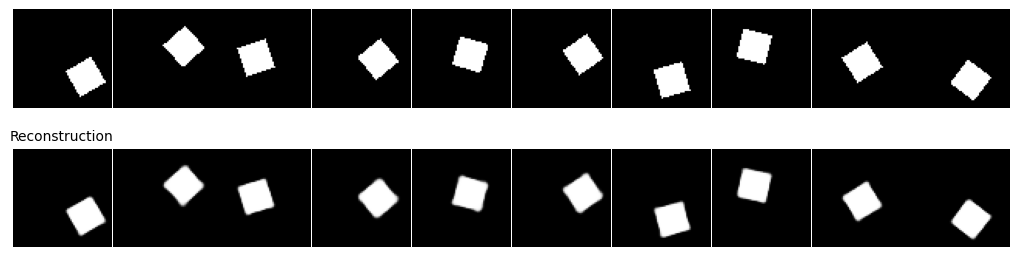

Plotting reconstructions from specific indices...


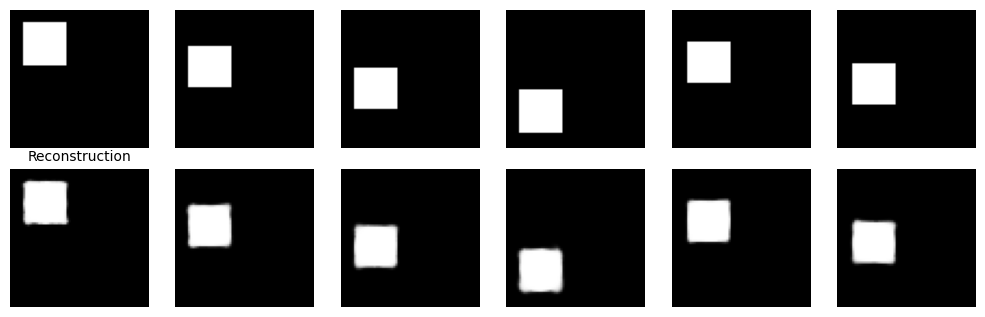

In [11]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


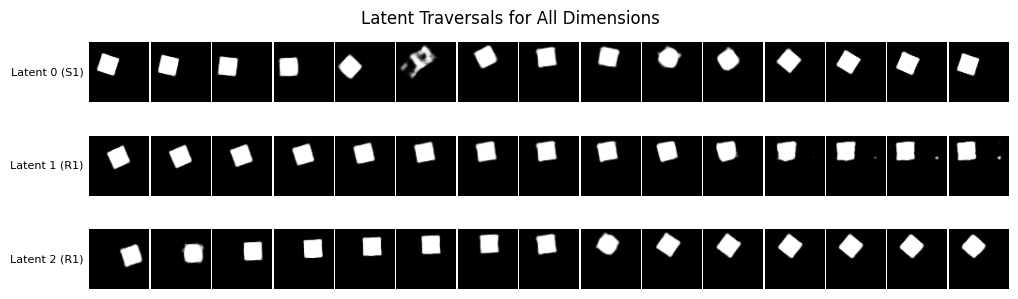

In [12]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

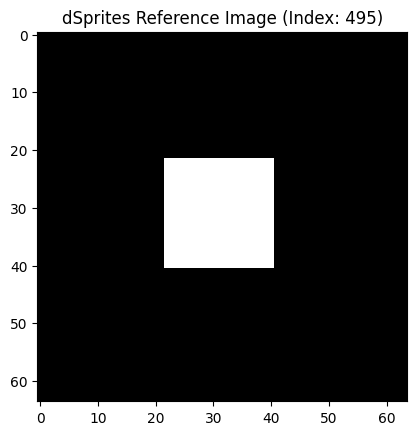

In [13]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


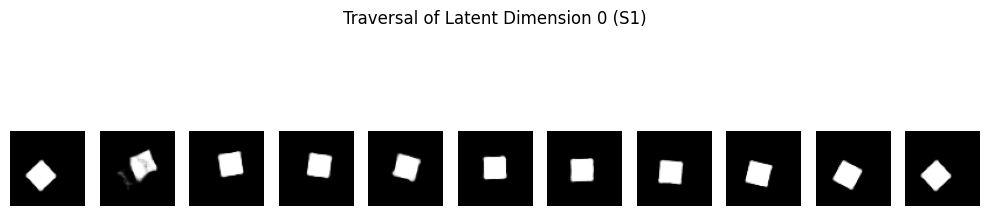

In [14]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


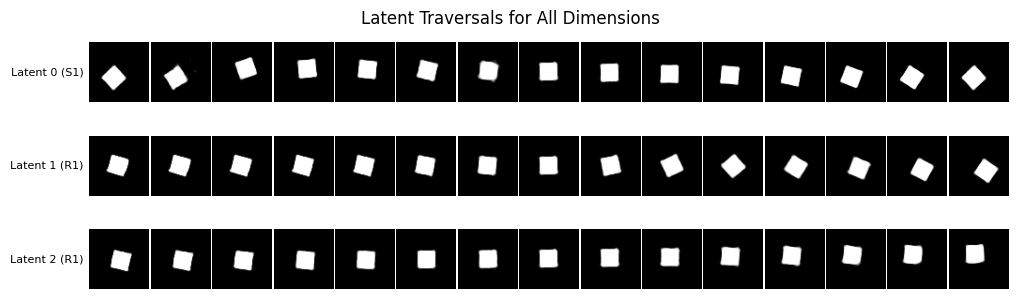

In [15]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )